## Questions:

### thinking about optimal model parameters vs. making the model realistic:

Should generations overlap?
Should parent pairs produce 2 offspring or one?

We are doing **single-point** crossover.
We could also do **double-point** (two  segmentations) or **uniform** (each gene is independent) crossover.

We are using **probibalistic tournament selection** with 3 random competitors vying to be parents (based on fitness)
We could also use **deterministic5 tournament selection**
We could also use **fitness proportionate selection**, which is tournament selection among a whole group
We could choose fathers (or mothers) using one of these methods, and then choose from among that agent's mates

## Socioecological variables to review

Degree of synchrony
Degree of skew

Coding genes as parameters of a (e.g. gamma) dist

# Import packages



In [10]:
import random as rd
import math
import statistics
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from numpy.random import choice
from numpy.random import uniform
from numpy.random import normal
from numpy.random import randint
from numpy.random import permutation
from numpy import corrcoef
from numpy import flip
from numpy import around
from numpy import array as nparray
from random import choices as rdchoices
from random import uniform as rduniform
import numba as nb
import time
import scipy.stats
from scipy.stats import multivariate_normal as mvn
from sklearn.utils import shuffle
import statistics
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp
from collections import Counter
from progress.bar import Bar
from scipy.stats import skewnorm
#import pandas as pd
from itertools import chain
import cProfile, pstats
from tqdm import tqdm

## Male object

Calling the class "male" instantiates a "male" object with the following class variables representing its behavioral and biological traits:

**"rank"** represents the agent's position in mating competition; the **makeMatingPairs** method of class "group" matches males of lower numerical **"rank"** (higher dominance) with females of higher **"swelling"**  for mating.

**"fitness"** is correlated with **"rank"** with a correlation coefficient of approximately **rankFitnessCorrelation ** and influences the chances that mating will result in surviving offspring when it is multiplied by **"conceptionRisk"** to determine **"reproductiveSuccess"**.

**"reproductiveSuccess"** results from mating with fertile females and through the **setupNextGen** method of class "group" and determines which males wil produce offspring to populate the next generation.

**"mateTiming"** indicates the **"cycleDay"** on which mating occurred (for visualiztion purposes only)

**"startingSwelling"** indicates how the fertility swelling **"genes"** will be distributed at the start of the model run. Because males do not swelling, this does not affect their behavior during th model, but can influence that of their female offspring.

**"genes"** determine swelling strength and are passed on to offspring. They only influence female behavior.

**"cost"** of swellinging only influences female reproduction.

Key: \
"Quotation marks" indicates a class \
**bold** indicates global variables \
***bold, italicized*** indicates methods \
**"bold, in quotation marks"** indicates class variables

In [23]:
class Male:
    
    __slots__ = 'rank', 'fitness', 'reproductiveSuccess',  'genes', 'cost', 'mateTiming'
    
    def __init__(self, m, fitness):
        self.rank = m
        self.fitness = fitness
        self.reproductiveSuccess = 0
        self.mateTiming = []
        if startingSwelling == "noSwelling":
            self.genes = [0] * 5
        elif startingSwelling == "randomUniform":
            self.genes = [randint(0,cycleLength+1)]
            self.genes += [randint(0,cycleLength+1 - sum(self.genes))]
            self.genes += [randint(0,cycleLength+1 - sum(self.genes))]
            self.genes += [randint(0,cycleLength+1 - sum(self.genes))] + [uniform(0,1)]
        self.cost = 0
        

# Female object

Calling the class "female" instantiates a "female" object with the following class variables representing its behavioral and biological traits:

**"ID"** helps locate the agent's index in lists

**"cycleDay"** determines the day of the cycle on which females start the model. High cycle **synchrony** constrains  it to fewer days

**"reproductiveSuccess"** results from mating with fit males and through the **setupNextGen** method of class "group" and determines which females will produce offspring to populate the next generation.

**"startingSwelling"** indicates how the fertility swelling **"genes"** will be distributed at the start of the model run.

**"genes"** determine swelling strength and are passed on to offspring

**"cost"** of swellinging is calculated by adding absolute daily swelling strengths and daily increases in swelling strength

Key: \
"Quotation marks" indicates a class \
**bold** indicates global variables \
***bold, italicized*** indicates methods \
**"bold, in quotation marks"** indicates class variables

In [22]:
class Female:

    __slots__ ='ID','cycleDay','mateList','reproductiveSuccess','genes','cost','swellingList','swelling','conceptionProbability'
    
    def __init__(self, f, cycleDay):
        self.ID = f
        self.cycleDay = cycleDay
        self.mateList = []
        self.reproductiveSuccess = 0
        if startingSwelling == "noSwelling":
            self.genes = [0] * 5
        elif startingSwelling == "randomUniform":
            self.genes = [randint(0,cycleLength+1)]
            self.genes += [randint(0,cycleLength+1 - sum(self.genes))]
            self.genes += [randint(0,cycleLength+1 - sum(self.genes))]
            self.genes += [randint(0,cycleLength+1 - sum(self.genes))] + [uniform(0,1)]
           
        self.swellingList = self.setSwelling()
        self.swelling = self.swellingList[self.cycleDay - 1]
        
        self.conceptionProbability = conceptionProbabilityList[self.cycleDay - 1]

    def setupCycleDay(self):  
        self.cycleDay = self.cycleDay + 1 if self.cycleDay < cycleLength else 1  
        self.swelling = self.swellingList[self.cycleDay - 1]
        self.conceptionProbability = conceptionProbabilityList[self.cycleDay - 1]
        
    def setSwelling(self):
        inceraseStartDay, increaseDuration, peakDuration, decreaseDuration, peakSwelling = self.genes
        peakStartDay = inceraseStartDay + increaseDuration
        decreaseStartDay = peakStartDay + peakDuration
        decreaseEndDay = decreaseStartDay + decreaseDuration
        increaseCoefficient =  peakSwelling / (increaseDuration + 1)
        decreaseCoefficient =  peakSwelling / (decreaseDuration + 1)

        x =  np.arange(1,cycleLength + 1,1)
        y = [0] * (inceraseStartDay - 1) + [0 + increaseCoefficient * i for i in range(1,increaseDuration)]
        y = y + [peakSwelling] * peakDuration + [peakSwelling - decreaseCoefficient * i for i in range(1,decreaseDuration+1)]
        y = y + [0] * (cycleLength - len(y))

        self.cost = sum(y) + (y[0]*10)
        for g in range(1, len(y)): # to add cost of growth
            self.cost = self.cost + (y[g] - y[g - 1])*10 if y[g] > y[g-1] else self.cost
            
        return(y)

# Group object

The class "group" generates and simulates the behavior of a single population over the course of a mating season. At initialization, the **"run"** boolean variable is set to "True" and **"step"**, which keeps count of timesteps (days) of the simulation, is set to 0. The ***setFitness*** method then sets up a list of male fitness values (**"fitnessList"**) that is correlated to male ranks with a correlation coefficient of approximately **rankFitnessCorrelation **. Finally, **nFemales** objects of class "female" and **nMales** objects of class "male" are instantiated in lists (**"males"** and **"females"**) contained in the "group" object.

The ***runModel*** method simulates agent behavior for **nDays** timesteps (days). It first calls the **makeMatingPairs** method, which orders "male" and "female" objects by **"rank"** and **"swelling"**, respctively. Mating pairs are created by pairing males and females with the same index in their respective ordered lists. Males then receive an increase to their **"reproductiveSuccess"** variable in the amount of the current **"conceptionProbability"** of their mate, and females receive an increase to their **"reproductiveSuccess"** variable in the amount of their current **"conceptionProbability"** multipled by the **"fitness"** of their mate.

For each "female" object, the ***setupCycleDay*** method of class "female" is run to 1) increase **"cycleDay"** by one, and set **"swelling"** and **"conceptionProbability"** based on the unique **"swellingList"** associating that "female's" **"cycleDay"** and **"swelling"** strength variables, and the global **conceptionProbabilityList**, which associates **"cycleDay"** with **"conceptionProbability"**.

Key: \
"Quotation marks" indicates a class \
**bold** indicates global variables \
***bold, italicized*** indicates methods \
**"bold, in quotation marks"** indicates class variables

In [13]:
class group:
    
    def __init__(self, g):
        
        self.ID = g
        self.step = 0
        
        #start = time.time()
        self.setFitness()
        self.cycleDayList = randint(1, round((cycleLength - 1) * (1 - synchrony)) + 2, size = nFemales)
        #print(time.time() - start)
        
        self.males, self.females = [], []
        
        self.tieBreaker = uniform(0,0.00000000001, nFemales * nDays)
        
        #start = time.time()
        for m in range(nMales):
            self.males.append(Male(m, self.fitnessList[m]))

        for f in range(nFemales):
            self.females.append(Female(f, self.cycleDayList[f]))
        #print(time.time() - start)
        
    def runModel(self):

        while self.step < nDays:
                
            self.females = sorted(self.females, key=self.sortSwelling)
            self.makeMatingPairs()
            self.setupCycleDay()

            self.step += 1
            
            '''
            elif self.step == nDays / 2:
                print(self.step)
            ''' 
            
    def setupCycleDay(self):
        self.cycleDayList += 1
        self.cycleDayList[self.cycleDayList == 31] = 1
        for f in self.females:
            f.cycleDay = self.cycleDayList[f.ID]
            f.swelling = f.swellingList[f.cycleDay - 1]
            f.swelling += self.tieBreaker[nFemales * (self.step):nFemales * (self.step + 1)][f.ID]
            f.conceptionProbability = conceptionProbabilityList[f.cycleDay - 1]
    
    def sortSwelling(self, f):
        return f.swelling

    def makeMatingPairs(self):
        i = 0
        while i < nPairs:
            f = nFemales - 1 - i
            self.males[i].reproductiveSuccess += self.females[f].conceptionProbability * self.males[i].fitness
            #self.males[i].mateTiming.append(self.females[f].cycleDay)
            self.females[f].reproductiveSuccess += self.females[f].conceptionProbability * self.males[i].fitness
            i += 1
        
    def setFitness(self):

        fitnessList = ranks
        i = 0.05
        while abs(0 - rankFitnessCorrelation  + corrcoef(ranks, fitnessList)[1,0]) > 0.05:
            fitnessList = [fitnessList[f] + rduniform(-i,i) for f in range(len(fitnessList))]
            i += 0.055
            if i >= 30:
                i = 0.5
                fitnessList = ranks
        
        self.fitnessList = flip((fitnessList - np.min(fitnessList))/np.ptp(fitnessList))
            
    def setupNextGen(self):
        
        self.nextGenMotherGenes = []
        motherProbabilities = [f.reproductiveSuccess - f.cost for f in self.females]
        # lack of ability to chose becomes a cost as rankFitnessCorrelation  goes down

        self.nextGenFatherGenes = []
        fatherProbabilities = [m.reproductiveSuccess for m in self.males] # does male fitness matter?
            
        parentsStartingPoint = model.generation * nGroups * nAgents + self.ID * nAgents    
        
        moms = [rdchoices(model.potentialMoms[parentsStartingPoint + i: parentsStartingPoint + i + 2],
                          weights=[motherProbabilities[p] for p in model.potentialMoms[
                              parentsStartingPoint + i: parentsStartingPoint + i+2]],k = 1)[0] for i in np.arange(0, (nAgents * 3), 3)]
        dads = [rdchoices(model.potentialDads[parentsStartingPoint + i:parentsStartingPoint + i + 2],
                          weights=[fatherProbabilities[p] for p in model.potentialDads[
                              parentsStartingPoint + i: parentsStartingPoint + i+2]], k = 1)[0] for i in np.arange(0, (nAgents * 3), 3)]
            
        self.nextGenMotherGenes = [self.females[m].genes for m in moms]
        self.nextGenFatherGenes = [self.males[d].genes for d in dads]

        self.recombination()
        self.mutation() if model.mutations[model.generation] > 0 else 0
        self.reset()
            
    def recombination(self):
        
        self.offspringGenes = []
        recombinationPoints = choice(range(numberGenes), nAgents)
        splitTypes = randint(0,2, nAgents)
        i = 0
        while i < nAgents:
            recombinationPoint = recombinationPoints[i]
            if splitTypes[i] == 1:
                self.offspringGenes.append([m for m in self.nextGenMotherGenes[i][:recombinationPoint]] + 
                                           [f for f in self.nextGenFatherGenes[i][recombinationPoint:]])
            else:
                self.offspringGenes.append([f for f in self.nextGenFatherGenes[i][:recombinationPoint]] + 
                                           [m for m in self.nextGenMotherGenes[i][recombinationPoint:]])
            i += 1
                
    def mutation(self):
        
        genesInGroup = nAgents * numberGenes
        mutations = model.mutations[model.generation]
       
        dayMutations = randint(mutations)
        peakMutations = mutations - dayMutations
      
        dayGenesMutating = choice(range(4), dayMutations)
        peakGenesMutating = [4] * (peakMutations)
        
        dayOffspringsMutating = choice(range(len(self.offspringGenes)), dayMutations)
        peakOffspringsMutating = choice(range(len(self.offspringGenes)), peakMutations)

        dayPertubations = choice([-1,1], dayMutations)
        peakPertubations = uniform(-0.02,0.02, peakMutations)
        
        newDayGenes = nparray([self.offspringGenes[dayOffspringsMutating[m]][dayGenesMutating[m]] + dayPertubations[m] for m in range(dayMutations)])
        newPeakGenes = nparray([self.offspringGenes[peakOffspringsMutating[m]][peakGenesMutating[m]] + peakPertubations[m] for m in range(peakMutations)]) 
        
        newDayGenes[newDayGenes > 30] = randint(cycleLength)
        newDayGenes[newDayGenes < 0] = randint(cycleLength)
        newPeakGenes[newPeakGenes < 0] = 0
        for m in range(dayMutations):
            self.offspringGenes[dayOffspringsMutating[m]][dayGenesMutating[m]] = newDayGenes[m]
            self.offspringGenes[m][self.offspringGenes[m].index(
                max(self.offspringGenes[m]))] = max(self.offspringGenes[m]) - sum(
                self.offspringGenes[m][:4]) - cycleLength if self.offspringGenes[m][sum(
                self.offspringGenes[m][:4]) > 30] == 2 else max(self.offspringGenes[m])
        for m in range(peakMutations):
            self.offspringGenes[peakOffspringsMutating[m]][peakGenesMutating[m]] = newPeakGenes[m]
     

    def setGenotypes(self):
        
        for f in self.females:
            f.genes = self.offspringGenes[f.ID]
            f.swellingList = f.setSwelling()
            #f.cost = sum(self.offspringGenes[f.ID])
            #f.swellingList = f.genes
            f.setupCycleDay()

        for m in self.males:
            m.genes = self.offspringGenes[m.rank + nFemales]
            
    def reset(self):
        self.step = 0
        self.setFitness()
        self.cycleDayList = randint(1, round((cycleLength - 1) * (1 - synchrony)) + 2, size = nFemales)
        self.males, self.females = [], []
        self.males = [Male(m, self.fitnessList[m]) for m in range(nMales)]
        self.females = [Female(f, self.cycleDayList[f]) for f in range(nFemales)]
            

# Evolving Model object

The class "evolvingModel" contains class variables and methods to initialize a simulated world with multiple groups and simulate biological evolution using a genetic algorithm. Initialization sets the model to generation 0 and instantiates **nGroups** social groups of class "group."

The ***evolve*** method of class "evolvingModel" loops through **nGenerations** generations. ***Evolve*** method process: First, the generation number is increased by 1. Then, the behavior of each group is simulated for a single generation using the ***runModel*** method of class "group." The ***setupNextGen*** and ***setGenotypes*** methods of class "group" then decides on a cohort of **nAgents** mothers and **nAgents** fathers for the next generation, perform  genetic **recombination** using mothers' and fathers' genes, performs probabilistic **mutation** of offspring genes, and finally initializes a new generation of **nFemales** and **nMales** with the those genes. Finally, the ***migration*** method of class "evolvingModel" probabilistically selects some number of the next gerenations' agents to migrate to new groups, based on parameter **migrationRate**, with a probability of **maleDispersalBias** that the agent selected for migration with be male. Migration switches the following class variables of the agent (a member of either class "female" or "male") : **"genes", "swellingList"** (females only), and **"cost"**.

If **realTimePlots** is set to True, a dot plot of average swelling strengh (Y-axis) across group 0 against cycle day (X-axis) appears in a quartz window following the first generation and updates with probability **realTimePlotsRate** for future generations. Following a model run of **nGenerations**, a line plot showing changes across generations in the intra-generation variability of cycle days on which the alpha male of group 0 mates, with lines for first quartile, median, and 3rd quartile of mating days. The Y-axis is mating days and the X-axis is generations. This concludes the model run.

Key: \
"Quotation marks" indicates a class \
**bold** indicates global variables \
***bold, italicized*** indicates methods \
**"bold, in quotation marks"** indicates class variables


In [14]:
class evolvingModel:
    
    def __init__(self):
        
        self.generation = 0
        
        self.groups = []
        
        for g in range(nGroups):
            self.groups.append(group(g))

        self.alphaMates, self.alphaMatingSpread = [], [[],[],[]]
        
        self.alphaMates, self.alphaMatingMedian,  self.alphaMating1Q, self.alphaMating3Q = [], [], [], []
        
        self.potentialMoms = rdchoices(range(nFemales), k = 3 * nAgents * nGroups * nGenerations)
        self.potentialDads = rdchoices(range(nMales), k = 3 * nAgents * nGroups * nGenerations)
        
        self.genesInGroup = numberGenes * nAgents 
        self.mutations = [round(uniform(0,self.genesInGroup * mutationRate * 2)) for i in range(nGenerations + 1)]
        
    def evolve(self):
          
#         if realTimePlots == True:
#             %matplotlib qt
        
        for self.generation in tqdm(range(nGenerations)):
            self.generation += 1
            
            g = 0
            while g < nGroups:
                self.groups[g].runModel() 
                g += 1
        
#             if realTimePlots == True and (rd.uniform(0,1) < realTimePlotsRate or self.generation == 1):
#                 self.plotSwelling() if whichPlot == "Swelling" else self.plotPairs()
#             elif rd.uniform(0,1) > 0.99:
#                 print(self.generation)
            
            #self.updateAlphaMatingDays()
            
#             if self.generation == nGenerations - 1:
#                 %matplotlib inline
#                 self.plotRS()
               
            for g in self.groups:
                g.setupNextGen()
                g.setGenotypes()
               
            if dispersal == True:
                self.migration()
        
        lst = []
        lstLower = []
        lstUpper =[]
        for j in range(cycleLength):
            lst.append(statistics.mean([f.swellingList[j] for f in sum([g.females for g in model.groups], [])]))
            SEM = scipy.stats.tstd([f.swellingList[j] for f in sum([g.females for g in model.groups], [])])
            lstLower.append(lst[j] - SEM) if SEM < lst[j] else lstLower.append(0)
            lstUpper.append(lst[j] + SEM)

        modelData[str(popSize), str(rankFitnessCorrelation), str(synchrony)]=[rankFitnessCorrelation]+[synchrony]+[popSize]+ lst + [SEM] + lstLower + lstUpper
        
#         if realTimePlots == False:
#             self.plotSwelling()
#             plt.figure()
#             self.plotPairs()
            
        #self.plotMatingDays()
            
    def migration(self):
                
        migrations = round(uniform(totalAgents * migrationRate * 2))
        groupsLeavingFrom = choice([g for g in self.groups], migrations)
        agentsLeaving = choice(range(nMales), migrations)
        
        for m in range(migrations):
            
            groupLeavingFrom = groupsLeavingFrom[m]
            
            if rd.uniform(0,1) > maleDispersalBias:
                agentLeaving = groupLeavingFrom.males[agentsLeaving[m]]
                agentComing = rd.choice(rd.choice([g for g in self.groups if g != groupLeavingFrom]).males)
            else:
                agentLeaving = groupLeavingFrom.females[agentsLeaving[m]]
                agentComing = rd.choice(rd.choice([g for g in self.groups if g != groupLeavingFrom]).females)
            
            tempGenes, tempCost = agentLeaving.genes, agentLeaving.cost
            agentLeaving.genes, agentLeaving.cost = agentComing.genes, agentComing.cost
            agentComing.genes, agentComing.cost = tempGenes, tempCost
        
    def plotSwelling(self):

        lst = []
        lstLower = []
        lstUpper =[]
        for j in range(cycleLength):
            lst.append(statistics.mean([f.swellingList[j] for f in sum([g.females for g in model.groups], [])]))
            SEM = scipy.stats.tstd([f.swellingList[j] for f in sum([g.females for g in model.groups], [])])
            lstLower.append(lst[j] - SEM) if SEM < lst[j] else lstLower.append(0)
            lstUpper.append(lst[j] + SEM)

        if rd.choice([1,2]) == 1:
            plt.clf()
            plt.plot(lst, "bo")
            plt.plot(lstLower, "r")
            plt.plot(lstUpper, "r")
            plt.ylim = [0,max(lst) * 1.1]
            plt.text(0.1, max(lst) * 0.9, str(self.generation))
            plt.pause(0.000001)
            plt.show()
            
    def plotRS(self):
        
        femaleRS = [f.reproductiveSuccess for f in model.groups[0].females]
        maleRS = [m.reproductiveSuccess for m in model.groups[0].males]
        
        print("SD^2 in female RS:"+str(statistics.variance(femaleRS)))
        print("SD^2 in male RS:"+str(statistics.variance(maleRS)))

        plt.figure()
        plt.hist(maleRS, alpha=0.5, label = "male RS")
        plt.hist(femaleRS, alpha=0.5, label = "female RS")
        plt.title('Male and female Reproductive Success')
        plt.legend(loc='upper right')
        plt.show()
        
        plt.figure()
        plt.plot([m.rank for m in model.groups[0].males],
                 [m.reproductiveSuccess for m in model.groups[0].males], 'bo')
        plt.title('male RS ~ rank')
        plt.show()
        
    def plotMatingDays(self):
        
        plt.figure()
        
        for i in range(3):
            plt.plot(range(self.generation), self.alphaMatingSpread[i])
        
        plt.ylim = [0, cycleLength]
        plt.xlim = [0, 1.0]
        plt.title("Synchrony: " + str(round(synchrony, 2)) + "; Rank/Fitness Correlation: " + str((rankFitnessCorrelation , 2)))
        
    def updateAlphaMatingDays(self):
    
        self.alphaMates.extend(self.groups[0].males[0].mateTiming)
        a,b,c = np.percentile(self.alphaMates,[25, 5, 75])

        self.alphaMatingSpread[0].append(a)
        self.alphaMatingSpread[1].append(b)
        self.alphaMatingSpread[2].append(c)
        
    def plotPairs(self):
        plt.clf()
        plotGroup = model.groups[0]
        plotGroup.females = sorted(choice(plotGroup.females, size=nFemales, replace=False), key=plotGroup.sortSwelling)
        swellings = [f.swelling * 1000 for f in plotGroup.females]
        IDs = [f.ID for f in plotGroup.females]
        plt.scatter([1] * nFemales, [f.ID for f in plotGroup.females], s = swellings)
        plt.scatter([2] * nMales, [m.rank for m in plotGroup.males], s = [m.rank for m in plotGroup.males])
        plt.scatter(0,0, s = 0)
        plt.scatter(3,0, s = 0)
        mates = [[plotGroup.females[i].ID] + [plotGroup.males[i].rank] for i in range(nPairs)]
        mates = [agent for pair in mates for agent in pair]
        for i in range(nPairs):
            plt.plot([1,2],[plotGroup.females[i].ID, plotGroup.males[i].rank],linewidth=0.5)
        plt.xlim = [0,3]
        plt.text(0.1, nMales * 0.9, str(model.generation))
        plt.title('mating pairs based on female swelling size (left)\nand male rank (right)')
        plt.pause(0.00001)
        plt.show()
        
# basic model parameters
dispersal = True
nMales = 25
nFemales = 25
nGroups = 10; dispersal = False if nGroups < 2 else dispersal
totalAgents = nAgents * nGroups
cycleLength = 30
rankFitnessCorrelation  = 0.8
synchrony = 0.0 # seasonality vs. group-size influences
mutationRate = 0.01
migrationRate = 0.01
maleDispersalBias = 0.5
realTimePlots = False
#whichPlot = "Pairs"
whichPlot = "swelling"
realTimePlotsRate = 0.1
nDays = 60
nGenerations = 1000
#swellingFunction = "eachDay"
swellingFunction = "slopes"
numberGenes = cycleLength if swellingFunction == "eachDay" else 5

# cycle parameters
ovulation = 16
prePOPLength = ovulation - 6
postPOPLength = cycleLength - prePOPLength - 6
conceptionProbabilityList = [0] * prePOPLength
conceptionProbabilityList += [.05784435, .16082819, .19820558, .25408223, .24362408, .10373275]
conceptionProbabilityList += [0] * postPOPLength

# swelling parameters
swellingConspicuousness = 1.0 # 0.0 - 1.0 does a less conspicuous swelling simply mean more noise in male preferences?
swellinging = True; swellingConspicuousness = 0.0 if swellinging == False else swellingConspicuousness
swellingSD = 2.5
swellingMean = 15
#startingswelling = "noswelling"
startingSwelling = "randomUniform"
        

In [213]:
nDays = 60
nGenerations = 1000
modelRuns = 0 
for popSize in [15, 50,100]:
    nMales = popSize
    nFemales = popSize
    nAgents = nFemales + nMales
    nPairs = min(nMales, nFemales)
    ranks = range(nMales)
    for rankCorVal in [0.0, 0.33, 0.66, 1.0]:
        rankFitnessCorrelation = rankCorVal
        for synchronyVal in tqdm([0.0, 0.33, 0.66, 1.0]):
            synchrony = synchronyVal
            model = evolvingModel()
            model.evolve()
            modelRuns += 1
            print(modelRuns)

modelData.to_csv('modelData.csv')



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<09:22,  1.78it/s]

  0%|          | 2/1000 [00:01<10:06,  1.65it/s]

  0%|          | 3/1000 [00:02<12:40,  1.31it/s]/Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:143: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


  0%|          | 4/1000 [00:02<10:36,  1.56it/s]

  0%|          | 5/1000 [00:03<10:03,  1.65it/s]

  1%|          | 6/1000 [00:04<11:56,  1.39it/s]

  1%|          | 7/1000 [00:05<13:25,  1.23it/s]

  1%|          | 8/1000 [00:06<12:54,  1.28it/s]

  1%|          | 9/1000 [00:06<12:06,  1.36it/s]

  1%|          | 10/1000 [00:07<10:50,  1.52it/s]

  1%|          | 11/1000 [00:07<09:51,  1.67it/s]

  1%|          | 12/1000 [00:08<09:13,  1.78it/s]

  1%|▏         | 13/1000 [00:08<08:31,  1.93it/s]

  1%|▏         | 14/1000 [00:09<08:44,  1.88it/s]

  2%|▏         | 

 14%|█▍        | 139/1000 [01:15<07:15,  1.98it/s]

 14%|█▍        | 140/1000 [01:16<07:38,  1.88it/s]

 14%|█▍        | 141/1000 [01:16<07:51,  1.82it/s]

 14%|█▍        | 142/1000 [01:17<08:34,  1.67it/s]

 14%|█▍        | 143/1000 [01:17<07:30,  1.90it/s]

 14%|█▍        | 144/1000 [01:18<07:37,  1.87it/s]

 14%|█▍        | 145/1000 [01:19<07:48,  1.82it/s]

 15%|█▍        | 146/1000 [01:19<07:36,  1.87it/s]

 15%|█▍        | 147/1000 [01:20<07:31,  1.89it/s]

 15%|█▍        | 148/1000 [01:20<07:03,  2.01it/s]

 15%|█▍        | 149/1000 [01:20<06:30,  2.18it/s]

 15%|█▌        | 150/1000 [01:21<06:21,  2.23it/s]

 15%|█▌        | 151/1000 [01:21<06:22,  2.22it/s]

 15%|█▌        | 152/1000 [01:22<05:57,  2.37it/s]

 15%|█▌        | 153/1000 [01:22<06:03,  2.33it/s]

 15%|█▌        | 154/1000 [01:23<06:08,  2.30it/s]

 16%|█▌        | 155/1000 [01:23<05:45,  2.45it/s]

 16%|█▌        | 156/1000 [01:23<05:39,  2.49it/s]

 16%|█▌        | 157/1000 [01:24<05:44,  2.45it/s]

 16%|█▌     

 28%|██▊       | 280/1000 [02:35<07:12,  1.67it/s]

 28%|██▊       | 281/1000 [02:35<06:28,  1.85it/s]

 28%|██▊       | 282/1000 [02:36<07:15,  1.65it/s]

 28%|██▊       | 283/1000 [02:36<06:56,  1.72it/s]

 28%|██▊       | 284/1000 [02:37<06:23,  1.86it/s]

 28%|██▊       | 285/1000 [02:37<06:55,  1.72it/s]

 29%|██▊       | 286/1000 [02:38<07:58,  1.49it/s]

 29%|██▊       | 287/1000 [02:39<07:48,  1.52it/s]

 29%|██▉       | 288/1000 [02:40<08:34,  1.38it/s]

 29%|██▉       | 289/1000 [02:40<07:22,  1.61it/s]

 29%|██▉       | 290/1000 [02:41<06:50,  1.73it/s]

 29%|██▉       | 291/1000 [02:41<06:31,  1.81it/s]

 29%|██▉       | 292/1000 [02:42<06:19,  1.86it/s]

 29%|██▉       | 293/1000 [02:42<06:31,  1.81it/s]

 29%|██▉       | 294/1000 [02:43<06:54,  1.70it/s]

 30%|██▉       | 295/1000 [02:43<06:17,  1.87it/s]

 30%|██▉       | 296/1000 [02:44<06:55,  1.69it/s]

 30%|██▉       | 297/1000 [02:45<07:34,  1.55it/s]

 30%|██▉       | 298/1000 [02:45<07:20,  1.59it/s]

 30%|██▉    

 42%|████▏     | 421/1000 [04:04<06:16,  1.54it/s]

 42%|████▏     | 422/1000 [04:05<05:30,  1.75it/s]

 42%|████▏     | 423/1000 [04:05<05:04,  1.90it/s]

 42%|████▏     | 424/1000 [04:05<04:54,  1.96it/s]

 42%|████▎     | 425/1000 [04:06<05:51,  1.64it/s]

 43%|████▎     | 426/1000 [04:07<05:23,  1.78it/s]

 43%|████▎     | 427/1000 [04:08<07:23,  1.29it/s]

 43%|████▎     | 428/1000 [04:09<07:28,  1.27it/s]

 43%|████▎     | 429/1000 [04:10<07:40,  1.24it/s]

 43%|████▎     | 430/1000 [04:11<07:55,  1.20it/s]

 43%|████▎     | 431/1000 [04:11<06:59,  1.35it/s]

 43%|████▎     | 432/1000 [04:12<07:08,  1.33it/s]

 43%|████▎     | 433/1000 [04:12<06:38,  1.42it/s]

 43%|████▎     | 434/1000 [04:13<06:31,  1.45it/s]

 44%|████▎     | 435/1000 [04:14<07:49,  1.20it/s]

 44%|████▎     | 436/1000 [04:15<06:32,  1.44it/s]

 44%|████▎     | 437/1000 [04:15<06:26,  1.46it/s]

 44%|████▍     | 438/1000 [04:16<05:47,  1.62it/s]

 44%|████▍     | 439/1000 [04:16<05:52,  1.59it/s]

 44%|████▍  

 56%|█████▌    | 562/1000 [05:27<04:17,  1.70it/s]

 56%|█████▋    | 563/1000 [05:28<04:19,  1.68it/s]

 56%|█████▋    | 564/1000 [05:28<03:57,  1.84it/s]

 56%|█████▋    | 565/1000 [05:29<03:53,  1.86it/s]

 57%|█████▋    | 566/1000 [05:29<03:31,  2.05it/s]

 57%|█████▋    | 567/1000 [05:30<03:58,  1.82it/s]

 57%|█████▋    | 568/1000 [05:31<04:07,  1.75it/s]

 57%|█████▋    | 569/1000 [05:31<03:43,  1.92it/s]

 57%|█████▋    | 570/1000 [05:32<04:06,  1.74it/s]

 57%|█████▋    | 571/1000 [05:32<03:41,  1.94it/s]

 57%|█████▋    | 572/1000 [05:33<03:29,  2.04it/s]

 57%|█████▋    | 573/1000 [05:33<03:47,  1.87it/s]

 57%|█████▋    | 574/1000 [05:34<04:00,  1.77it/s]

 57%|█████▊    | 575/1000 [05:35<04:27,  1.59it/s]

 58%|█████▊    | 576/1000 [05:35<04:36,  1.53it/s]

 58%|█████▊    | 577/1000 [05:36<04:12,  1.68it/s]

 58%|█████▊    | 578/1000 [05:36<03:52,  1.81it/s]

 58%|█████▊    | 579/1000 [05:37<03:54,  1.80it/s]

 58%|█████▊    | 580/1000 [05:37<03:36,  1.94it/s]

 58%|█████▊ 

 70%|███████   | 703/1000 [06:49<02:32,  1.95it/s]

 70%|███████   | 704/1000 [06:50<02:59,  1.65it/s]

 70%|███████   | 705/1000 [06:50<02:54,  1.69it/s]

 71%|███████   | 706/1000 [06:51<03:07,  1.57it/s]

 71%|███████   | 707/1000 [06:52<02:54,  1.68it/s]

 71%|███████   | 708/1000 [06:52<02:50,  1.72it/s]

 71%|███████   | 709/1000 [06:53<02:43,  1.78it/s]

 71%|███████   | 710/1000 [06:53<02:23,  2.02it/s]

 71%|███████   | 711/1000 [06:54<02:23,  2.01it/s]

 71%|███████   | 712/1000 [06:54<02:20,  2.05it/s]

 71%|███████▏  | 713/1000 [06:55<02:16,  2.11it/s]

 71%|███████▏  | 714/1000 [06:55<02:15,  2.11it/s]

 72%|███████▏  | 715/1000 [06:56<02:21,  2.02it/s]

 72%|███████▏  | 716/1000 [06:56<02:42,  1.75it/s]

 72%|███████▏  | 717/1000 [06:57<03:20,  1.41it/s]

 72%|███████▏  | 718/1000 [06:58<03:04,  1.53it/s]

 72%|███████▏  | 719/1000 [06:58<02:54,  1.61it/s]

 72%|███████▏  | 720/1000 [06:59<02:38,  1.77it/s]

 72%|███████▏  | 721/1000 [06:59<02:28,  1.87it/s]

 72%|███████

 84%|████████▍ | 844/1000 [08:07<01:16,  2.04it/s]

 84%|████████▍ | 845/1000 [08:07<01:14,  2.08it/s]

 85%|████████▍ | 846/1000 [08:08<01:23,  1.84it/s]

 85%|████████▍ | 847/1000 [08:09<01:34,  1.62it/s]

 85%|████████▍ | 848/1000 [08:10<01:35,  1.60it/s]

 85%|████████▍ | 849/1000 [08:10<01:26,  1.74it/s]

 85%|████████▌ | 850/1000 [08:10<01:15,  1.98it/s]

 85%|████████▌ | 851/1000 [08:11<01:13,  2.03it/s]

 85%|████████▌ | 852/1000 [08:11<01:21,  1.81it/s]

 85%|████████▌ | 853/1000 [08:12<01:27,  1.68it/s]

 85%|████████▌ | 854/1000 [08:13<01:17,  1.89it/s]

 86%|████████▌ | 855/1000 [08:13<01:17,  1.88it/s]

 86%|████████▌ | 856/1000 [08:14<01:11,  2.00it/s]

 86%|████████▌ | 857/1000 [08:14<01:09,  2.06it/s]

 86%|████████▌ | 858/1000 [08:14<01:09,  2.05it/s]

 86%|████████▌ | 859/1000 [08:15<01:12,  1.94it/s]

 86%|████████▌ | 860/1000 [08:15<01:06,  2.10it/s]

 86%|████████▌ | 861/1000 [08:16<01:03,  2.18it/s]

 86%|████████▌ | 862/1000 [08:16<01:06,  2.08it/s]

 86%|███████

 98%|█████████▊| 985/1000 [09:24<00:13,  1.12it/s]

 99%|█████████▊| 986/1000 [09:25<00:13,  1.04it/s]

 99%|█████████▊| 987/1000 [09:25<00:12,  1.08it/s]

 99%|█████████▉| 988/1000 [09:26<00:09,  1.26it/s]

 99%|█████████▉| 989/1000 [09:27<00:09,  1.17it/s]

 99%|█████████▉| 990/1000 [09:28<00:08,  1.13it/s]

 99%|█████████▉| 991/1000 [09:29<00:07,  1.24it/s]

 99%|█████████▉| 992/1000 [09:30<00:06,  1.15it/s]

 99%|█████████▉| 993/1000 [09:31<00:06,  1.00it/s]

 99%|█████████▉| 994/1000 [09:32<00:05,  1.07it/s]

100%|█████████▉| 995/1000 [09:32<00:04,  1.10it/s]

100%|█████████▉| 996/1000 [09:33<00:03,  1.16it/s]

100%|█████████▉| 997/1000 [09:34<00:02,  1.21it/s]

100%|█████████▉| 998/1000 [09:35<00:01,  1.25it/s]

100%|█████████▉| 999/1000 [09:35<00:00,  1.30it/s]

100%|██████████| 1000/1000 [09:37<00:00,  1.73it/s]

 25%|██▌       | 1/4 [09:38<28:55, 578.63s/it]

1




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<14:23,  1.16it/s]

  0%|          | 2/1000 [00:01<12:51,  1.29it/s]

  0%|          | 3/1000 [00:02<12:40,  1.31it/s]

  0%|          | 4/1000 [00:02<12:08,  1.37it/s]

  0%|          | 5/1000 [00:03<13:58,  1.19it/s]

  1%|          | 6/1000 [00:04<13:20,  1.24it/s]

  1%|          | 7/1000 [00:05<12:37,  1.31it/s]

  1%|          | 8/1000 [00:06<12:20,  1.34it/s]

  1%|          | 9/1000 [00:06<12:51,  1.28it/s]

  1%|          | 10/1000 [00:07<12:47,  1.29it/s]

  1%|          | 11/1000 [00:08<12:43,  1.30it/s]

  1%|          | 12/1000 [00:09<12:17,  1.34it/s]

  1%|▏         | 13/1000 [00:09<12:27,  1.32it/s]

  1%|▏         | 14/1000 [00:11<14:24,  1.14it/s]

  2%|▏         | 15/1000 [00:11<14:05,  1.16it/s]

  2%|▏         | 16/1000 [00:12<13:59,  1.17it/s]

  2%|▏         | 17/1000 [00:13<15:31,  1.06it/s]

  2%|▏         | 18/1000 [00:15<17:24,  1.06s/it]

  2%|▏         | 19/1000 [00:16<17:21,  1.06s/i

 14%|█▍        | 143/1000 [01:39<08:14,  1.73it/s]

 14%|█▍        | 144/1000 [01:40<07:34,  1.88it/s]

 14%|█▍        | 145/1000 [01:40<07:21,  1.94it/s]

 15%|█▍        | 146/1000 [01:41<06:50,  2.08it/s]

 15%|█▍        | 147/1000 [01:41<06:59,  2.03it/s]

 15%|█▍        | 148/1000 [01:42<06:57,  2.04it/s]

 15%|█▍        | 149/1000 [01:42<06:51,  2.07it/s]

 15%|█▌        | 150/1000 [01:43<06:46,  2.09it/s]

 15%|█▌        | 151/1000 [01:43<06:34,  2.15it/s]

 15%|█▌        | 152/1000 [01:44<06:52,  2.05it/s]

 15%|█▌        | 153/1000 [01:45<09:03,  1.56it/s]

 15%|█▌        | 154/1000 [01:45<08:15,  1.71it/s]

 16%|█▌        | 155/1000 [01:45<07:33,  1.86it/s]

 16%|█▌        | 156/1000 [01:46<09:18,  1.51it/s]

 16%|█▌        | 157/1000 [01:47<09:37,  1.46it/s]

 16%|█▌        | 158/1000 [01:48<11:53,  1.18it/s]

 16%|█▌        | 159/1000 [01:50<13:15,  1.06it/s]

 16%|█▌        | 160/1000 [01:50<12:50,  1.09it/s]

 16%|█▌        | 161/1000 [01:51<11:08,  1.26it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [03:05<06:25,  1.86it/s]

 28%|██▊       | 285/1000 [03:06<06:35,  1.81it/s]

 29%|██▊       | 286/1000 [03:06<06:21,  1.87it/s]

 29%|██▊       | 287/1000 [03:07<06:06,  1.94it/s]

 29%|██▉       | 288/1000 [03:07<05:50,  2.03it/s]

 29%|██▉       | 289/1000 [03:08<05:45,  2.06it/s]

 29%|██▉       | 290/1000 [03:08<05:32,  2.14it/s]

 29%|██▉       | 291/1000 [03:09<06:08,  1.93it/s]

 29%|██▉       | 292/1000 [03:09<06:31,  1.81it/s]

 29%|██▉       | 293/1000 [03:10<07:38,  1.54it/s]

 29%|██▉       | 294/1000 [03:11<06:59,  1.68it/s]

 30%|██▉       | 295/1000 [03:11<06:46,  1.73it/s]

 30%|██▉       | 296/1000 [03:12<06:47,  1.73it/s]

 30%|██▉       | 297/1000 [03:12<06:56,  1.69it/s]

 30%|██▉       | 298/1000 [03:13<06:36,  1.77it/s]

 30%|██▉       | 299/1000 [03:13<06:35,  1.77it/s]

 30%|███       | 300/1000 [03:14<06:04,  1.92it/s]

 30%|███       | 301/1000 [03:14<06:33,  1.77it/s]

 30%|███       | 302/1000 [03:15<06:23,  1.82it/s]

 30%|███    

 42%|████▎     | 425/1000 [04:19<04:21,  2.20it/s]

 43%|████▎     | 426/1000 [04:20<05:20,  1.79it/s]

 43%|████▎     | 427/1000 [04:20<04:43,  2.02it/s]

 43%|████▎     | 428/1000 [04:21<05:44,  1.66it/s]

 43%|████▎     | 429/1000 [04:22<06:42,  1.42it/s]

 43%|████▎     | 430/1000 [04:22<06:09,  1.54it/s]

 43%|████▎     | 431/1000 [04:23<05:46,  1.64it/s]

 43%|████▎     | 432/1000 [04:23<05:38,  1.68it/s]

 43%|████▎     | 433/1000 [04:24<05:29,  1.72it/s]

 43%|████▎     | 434/1000 [04:24<04:44,  1.99it/s]

 44%|████▎     | 435/1000 [04:25<04:36,  2.04it/s]

 44%|████▎     | 436/1000 [04:25<04:33,  2.07it/s]

 44%|████▎     | 437/1000 [04:26<04:13,  2.22it/s]

 44%|████▍     | 438/1000 [04:26<04:29,  2.08it/s]

 44%|████▍     | 439/1000 [04:27<04:46,  1.96it/s]

 44%|████▍     | 440/1000 [04:27<04:23,  2.12it/s]

 44%|████▍     | 441/1000 [04:28<04:11,  2.23it/s]

 44%|████▍     | 442/1000 [04:28<04:05,  2.27it/s]

 44%|████▍     | 443/1000 [04:28<03:56,  2.36it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [05:37<03:30,  2.06it/s]

 57%|█████▋    | 567/1000 [05:37<03:22,  2.14it/s]

 57%|█████▋    | 568/1000 [05:38<03:26,  2.09it/s]

 57%|█████▋    | 569/1000 [05:38<03:13,  2.23it/s]

 57%|█████▋    | 570/1000 [05:39<03:40,  1.95it/s]

 57%|█████▋    | 571/1000 [05:39<03:42,  1.93it/s]

 57%|█████▋    | 572/1000 [05:40<03:58,  1.80it/s]

 57%|█████▋    | 573/1000 [05:41<03:57,  1.80it/s]

 57%|█████▋    | 574/1000 [05:41<03:50,  1.85it/s]

 57%|█████▊    | 575/1000 [05:41<03:21,  2.11it/s]

 58%|█████▊    | 576/1000 [05:42<03:20,  2.12it/s]

 58%|█████▊    | 577/1000 [05:43<03:30,  2.01it/s]

 58%|█████▊    | 578/1000 [05:43<03:45,  1.87it/s]

 58%|█████▊    | 579/1000 [05:44<03:51,  1.82it/s]

 58%|█████▊    | 580/1000 [05:44<04:15,  1.64it/s]

 58%|█████▊    | 581/1000 [05:45<04:00,  1.74it/s]

 58%|█████▊    | 582/1000 [05:45<03:47,  1.84it/s]

 58%|█████▊    | 583/1000 [05:46<03:32,  1.96it/s]

 58%|█████▊    | 584/1000 [05:46<03:14,  2.13it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [06:52<02:37,  1.86it/s]

 71%|███████   | 708/1000 [06:52<02:25,  2.00it/s]

 71%|███████   | 709/1000 [06:53<02:25,  2.00it/s]

 71%|███████   | 710/1000 [06:53<02:20,  2.07it/s]

 71%|███████   | 711/1000 [06:54<02:09,  2.22it/s]

 71%|███████   | 712/1000 [06:54<01:58,  2.42it/s]

 71%|███████▏  | 713/1000 [06:54<01:58,  2.43it/s]

 71%|███████▏  | 714/1000 [06:55<02:05,  2.28it/s]

 72%|███████▏  | 715/1000 [06:56<02:42,  1.76it/s]

 72%|███████▏  | 716/1000 [06:57<02:59,  1.58it/s]

 72%|███████▏  | 717/1000 [06:57<02:40,  1.77it/s]

 72%|███████▏  | 718/1000 [06:58<02:42,  1.74it/s]

 72%|███████▏  | 719/1000 [06:58<02:26,  1.92it/s]

 72%|███████▏  | 720/1000 [06:59<02:26,  1.91it/s]

 72%|███████▏  | 721/1000 [06:59<02:10,  2.15it/s]

 72%|███████▏  | 722/1000 [06:59<01:57,  2.36it/s]

 72%|███████▏  | 723/1000 [07:00<02:10,  2.12it/s]

 72%|███████▏  | 724/1000 [07:00<02:10,  2.11it/s]

 72%|███████▎  | 725/1000 [07:01<02:02,  2.24it/s]

 73%|███████

 85%|████████▍ | 848/1000 [08:04<01:10,  2.16it/s]

 85%|████████▍ | 849/1000 [08:04<01:09,  2.17it/s]

 85%|████████▌ | 850/1000 [08:05<01:09,  2.15it/s]

 85%|████████▌ | 851/1000 [08:05<01:07,  2.21it/s]

 85%|████████▌ | 852/1000 [08:06<01:07,  2.19it/s]

 85%|████████▌ | 853/1000 [08:06<01:07,  2.17it/s]

 85%|████████▌ | 854/1000 [08:07<01:02,  2.33it/s]

 86%|████████▌ | 855/1000 [08:07<01:18,  1.84it/s]

 86%|████████▌ | 856/1000 [08:09<01:57,  1.23it/s]

 86%|████████▌ | 857/1000 [08:09<01:45,  1.36it/s]

 86%|████████▌ | 858/1000 [08:10<01:33,  1.52it/s]

 86%|████████▌ | 859/1000 [08:10<01:24,  1.67it/s]

 86%|████████▌ | 860/1000 [08:11<01:23,  1.67it/s]

 86%|████████▌ | 861/1000 [08:11<01:18,  1.77it/s]

 86%|████████▌ | 862/1000 [08:12<01:21,  1.69it/s]

 86%|████████▋ | 863/1000 [08:13<01:16,  1.80it/s]

 86%|████████▋ | 864/1000 [08:13<01:09,  1.97it/s]

 86%|████████▋ | 865/1000 [08:13<01:11,  1.90it/s]

 87%|████████▋ | 866/1000 [08:14<01:09,  1.94it/s]

 87%|███████

 99%|█████████▉| 989/1000 [09:20<00:06,  1.58it/s]

 99%|█████████▉| 990/1000 [09:21<00:06,  1.66it/s]

 99%|█████████▉| 991/1000 [09:21<00:04,  1.83it/s]

 99%|█████████▉| 992/1000 [09:22<00:04,  1.85it/s]

 99%|█████████▉| 993/1000 [09:22<00:03,  1.91it/s]

 99%|█████████▉| 994/1000 [09:23<00:03,  1.68it/s]

100%|█████████▉| 995/1000 [09:24<00:03,  1.64it/s]

100%|█████████▉| 996/1000 [09:24<00:02,  1.76it/s]

100%|█████████▉| 997/1000 [09:25<00:01,  1.54it/s]

100%|█████████▉| 998/1000 [09:25<00:01,  1.63it/s]

100%|█████████▉| 999/1000 [09:26<00:00,  1.66it/s]

100%|██████████| 1000/1000 [09:27<00:00,  1.76it/s]

 50%|█████     | 2/4 [19:08<19:11, 575.92s/it]

2




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<09:22,  1.78it/s]

  0%|          | 2/1000 [00:01<10:00,  1.66it/s]

  0%|          | 3/1000 [00:02<10:59,  1.51it/s]

  0%|          | 4/1000 [00:03<14:19,  1.16it/s]

  0%|          | 5/1000 [00:03<12:38,  1.31it/s]

  1%|          | 6/1000 [00:04<10:52,  1.52it/s]

  1%|          | 7/1000 [00:04<10:20,  1.60it/s]

  1%|          | 8/1000 [00:05<09:55,  1.66it/s]

  1%|          | 9/1000 [00:05<09:11,  1.80it/s]

  1%|          | 10/1000 [00:07<12:00,  1.37it/s]

  1%|          | 11/1000 [00:07<12:50,  1.28it/s]

  1%|          | 12/1000 [00:09<17:41,  1.07s/it]

  1%|▏         | 13/1000 [00:10<16:15,  1.01it/s]

  1%|▏         | 14/1000 [00:10<13:54,  1.18it/s]

  2%|▏         | 15/1000 [00:11<14:45,  1.11it/s]

  2%|▏         | 16/1000 [00:12<13:31,  1.21it/s]

  2%|▏         | 17/1000 [00:13<11:55,  1.37it/s]

  2%|▏         | 18/1000 [00:13<11:37,  1.41it/s]

  2%|▏         | 19/1000 [00:14<12:48,  1.28it/

 14%|█▍        | 143/1000 [01:28<09:30,  1.50it/s]

 14%|█▍        | 144/1000 [01:28<08:41,  1.64it/s]

 14%|█▍        | 145/1000 [01:29<08:16,  1.72it/s]

 15%|█▍        | 146/1000 [01:29<07:49,  1.82it/s]

 15%|█▍        | 147/1000 [01:30<07:41,  1.85it/s]

 15%|█▍        | 148/1000 [01:30<08:13,  1.73it/s]

 15%|█▍        | 149/1000 [01:31<07:29,  1.89it/s]

 15%|█▌        | 150/1000 [01:31<08:06,  1.75it/s]

 15%|█▌        | 151/1000 [01:32<08:14,  1.72it/s]

 15%|█▌        | 152/1000 [01:33<08:35,  1.65it/s]

 15%|█▌        | 153/1000 [01:33<07:59,  1.77it/s]

 15%|█▌        | 154/1000 [01:33<07:23,  1.91it/s]

 16%|█▌        | 155/1000 [01:34<09:36,  1.47it/s]

 16%|█▌        | 156/1000 [01:35<10:36,  1.33it/s]

 16%|█▌        | 157/1000 [01:36<09:34,  1.47it/s]

 16%|█▌        | 158/1000 [01:36<08:51,  1.58it/s]

 16%|█▌        | 159/1000 [01:37<08:41,  1.61it/s]

 16%|█▌        | 160/1000 [01:37<07:33,  1.85it/s]

 16%|█▌        | 161/1000 [01:38<07:11,  1.94it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [02:43<05:12,  2.29it/s]

 28%|██▊       | 285/1000 [02:43<05:05,  2.34it/s]

 29%|██▊       | 286/1000 [02:44<05:06,  2.33it/s]

 29%|██▊       | 287/1000 [02:45<06:05,  1.95it/s]

 29%|██▉       | 288/1000 [02:45<06:10,  1.92it/s]

 29%|██▉       | 289/1000 [02:46<07:48,  1.52it/s]

 29%|██▉       | 290/1000 [02:47<07:46,  1.52it/s]

 29%|██▉       | 291/1000 [02:47<07:59,  1.48it/s]

 29%|██▉       | 292/1000 [02:48<07:30,  1.57it/s]

 29%|██▉       | 293/1000 [02:48<06:50,  1.72it/s]

 29%|██▉       | 294/1000 [02:49<07:10,  1.64it/s]

 30%|██▉       | 295/1000 [02:50<08:18,  1.41it/s]

 30%|██▉       | 296/1000 [02:51<07:36,  1.54it/s]

 30%|██▉       | 297/1000 [02:51<07:10,  1.63it/s]

 30%|██▉       | 298/1000 [02:52<06:41,  1.75it/s]

 30%|██▉       | 299/1000 [02:52<06:52,  1.70it/s]

 30%|███       | 300/1000 [02:53<06:27,  1.81it/s]

 30%|███       | 301/1000 [02:53<06:18,  1.85it/s]

 30%|███       | 302/1000 [02:54<05:54,  1.97it/s]

 30%|███    

 42%|████▎     | 425/1000 [03:57<04:40,  2.05it/s]

 43%|████▎     | 426/1000 [03:57<04:34,  2.09it/s]

 43%|████▎     | 427/1000 [03:58<05:26,  1.75it/s]

 43%|████▎     | 428/1000 [03:59<06:02,  1.58it/s]

 43%|████▎     | 429/1000 [03:59<05:38,  1.69it/s]

 43%|████▎     | 430/1000 [04:00<05:13,  1.82it/s]

 43%|████▎     | 431/1000 [04:00<04:57,  1.91it/s]

 43%|████▎     | 432/1000 [04:01<04:39,  2.03it/s]

 43%|████▎     | 433/1000 [04:01<04:33,  2.07it/s]

 43%|████▎     | 434/1000 [04:02<04:30,  2.09it/s]

 44%|████▎     | 435/1000 [04:02<04:15,  2.21it/s]

 44%|████▎     | 436/1000 [04:03<04:53,  1.92it/s]

 44%|████▎     | 437/1000 [04:03<04:48,  1.95it/s]

 44%|████▍     | 438/1000 [04:04<04:41,  1.99it/s]

 44%|████▍     | 439/1000 [04:04<04:37,  2.02it/s]

 44%|████▍     | 440/1000 [04:05<04:19,  2.16it/s]

 44%|████▍     | 441/1000 [04:05<04:36,  2.02it/s]

 44%|████▍     | 442/1000 [04:06<04:28,  2.08it/s]

 44%|████▍     | 443/1000 [04:06<04:55,  1.89it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [05:12<04:12,  1.72it/s]

 57%|█████▋    | 567/1000 [05:12<04:22,  1.65it/s]

 57%|█████▋    | 568/1000 [05:13<04:01,  1.79it/s]

 57%|█████▋    | 569/1000 [05:13<03:47,  1.90it/s]

 57%|█████▋    | 570/1000 [05:14<04:25,  1.62it/s]

 57%|█████▋    | 571/1000 [05:15<04:18,  1.66it/s]

 57%|█████▋    | 572/1000 [05:15<04:00,  1.78it/s]

 57%|█████▋    | 573/1000 [05:16<03:38,  1.95it/s]

 57%|█████▋    | 574/1000 [05:16<03:28,  2.04it/s]

 57%|█████▊    | 575/1000 [05:17<03:52,  1.83it/s]

 58%|█████▊    | 576/1000 [05:17<03:40,  1.93it/s]

 58%|█████▊    | 577/1000 [05:18<03:49,  1.84it/s]

 58%|█████▊    | 578/1000 [05:18<03:33,  1.97it/s]

 58%|█████▊    | 579/1000 [05:18<03:13,  2.18it/s]

 58%|█████▊    | 580/1000 [05:19<03:04,  2.27it/s]

 58%|█████▊    | 581/1000 [05:19<03:20,  2.09it/s]

 58%|█████▊    | 582/1000 [05:20<03:37,  1.92it/s]

 58%|█████▊    | 583/1000 [05:21<04:11,  1.66it/s]

 58%|█████▊    | 584/1000 [05:21<04:06,  1.69it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [06:27<03:27,  1.41it/s]

 71%|███████   | 708/1000 [06:27<03:18,  1.47it/s]

 71%|███████   | 709/1000 [06:28<03:00,  1.61it/s]

 71%|███████   | 710/1000 [06:28<02:40,  1.80it/s]

 71%|███████   | 711/1000 [06:28<02:21,  2.04it/s]

 71%|███████   | 712/1000 [06:29<02:28,  1.93it/s]

 71%|███████▏  | 713/1000 [06:29<02:27,  1.94it/s]

 71%|███████▏  | 714/1000 [06:30<02:34,  1.86it/s]

 72%|███████▏  | 715/1000 [06:31<02:28,  1.93it/s]

 72%|███████▏  | 716/1000 [06:31<02:26,  1.94it/s]

 72%|███████▏  | 717/1000 [06:31<02:17,  2.06it/s]

 72%|███████▏  | 718/1000 [06:32<02:32,  1.85it/s]

 72%|███████▏  | 719/1000 [06:33<02:59,  1.56it/s]

 72%|███████▏  | 720/1000 [06:33<02:41,  1.74it/s]

 72%|███████▏  | 721/1000 [06:34<02:33,  1.82it/s]

 72%|███████▏  | 722/1000 [06:34<02:30,  1.84it/s]

 72%|███████▏  | 723/1000 [06:35<02:48,  1.64it/s]

 72%|███████▏  | 724/1000 [06:36<02:39,  1.73it/s]

 72%|███████▎  | 725/1000 [06:36<02:39,  1.73it/s]

 73%|███████

 85%|████████▍ | 848/1000 [07:42<01:08,  2.23it/s]

 85%|████████▍ | 849/1000 [07:42<01:07,  2.23it/s]

 85%|████████▌ | 850/1000 [07:43<01:09,  2.16it/s]

 85%|████████▌ | 851/1000 [07:43<01:03,  2.33it/s]

 85%|████████▌ | 852/1000 [07:43<01:05,  2.28it/s]

 85%|████████▌ | 853/1000 [07:44<01:19,  1.85it/s]

 85%|████████▌ | 854/1000 [07:45<01:34,  1.54it/s]

 86%|████████▌ | 855/1000 [07:46<01:23,  1.75it/s]

 86%|████████▌ | 856/1000 [07:46<01:16,  1.88it/s]

 86%|████████▌ | 857/1000 [07:46<01:12,  1.98it/s]

 86%|████████▌ | 858/1000 [07:47<01:05,  2.18it/s]

 86%|████████▌ | 859/1000 [07:47<01:07,  2.10it/s]

 86%|████████▌ | 860/1000 [07:48<01:04,  2.17it/s]

 86%|████████▌ | 861/1000 [07:48<01:04,  2.16it/s]

 86%|████████▌ | 862/1000 [07:49<01:08,  2.00it/s]

 86%|████████▋ | 863/1000 [07:49<01:09,  1.96it/s]

 86%|████████▋ | 864/1000 [07:50<01:00,  2.23it/s]

 86%|████████▋ | 865/1000 [07:50<01:08,  1.96it/s]

 87%|████████▋ | 866/1000 [07:51<01:17,  1.72it/s]

 87%|███████

 99%|█████████▉| 989/1000 [08:54<00:05,  2.00it/s]

 99%|█████████▉| 990/1000 [08:54<00:04,  2.07it/s]

 99%|█████████▉| 991/1000 [08:55<00:04,  2.02it/s]

 99%|█████████▉| 992/1000 [08:55<00:03,  2.12it/s]

 99%|█████████▉| 993/1000 [08:56<00:03,  2.06it/s]

 99%|█████████▉| 994/1000 [08:56<00:03,  1.64it/s]

100%|█████████▉| 995/1000 [08:57<00:03,  1.63it/s]

100%|█████████▉| 996/1000 [08:58<00:02,  1.74it/s]

100%|█████████▉| 997/1000 [08:58<00:01,  1.81it/s]

100%|█████████▉| 998/1000 [08:58<00:00,  2.13it/s]

100%|█████████▉| 999/1000 [08:59<00:00,  2.25it/s]

100%|██████████| 1000/1000 [08:59<00:00,  1.85it/s]

 75%|███████▌  | 3/4 [28:09<09:25, 565.44s/it]

3




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<07:03,  2.36it/s]

  0%|          | 2/1000 [00:00<07:25,  2.24it/s]

  0%|          | 3/1000 [00:01<06:59,  2.38it/s]

  0%|          | 4/1000 [00:01<06:38,  2.50it/s]

  0%|          | 5/1000 [00:01<06:26,  2.57it/s]

  1%|          | 6/1000 [00:02<06:21,  2.61it/s]

  1%|          | 7/1000 [00:02<06:32,  2.53it/s]

  1%|          | 8/1000 [00:03<07:23,  2.23it/s]

  1%|          | 9/1000 [00:03<07:23,  2.23it/s]

  1%|          | 10/1000 [00:04<08:11,  2.01it/s]

  1%|          | 11/1000 [00:04<07:56,  2.07it/s]

  1%|          | 12/1000 [00:05<09:20,  1.76it/s]

  1%|▏         | 13/1000 [00:06<10:58,  1.50it/s]

  1%|▏         | 14/1000 [00:07<10:12,  1.61it/s]

  2%|▏         | 15/1000 [00:07<09:17,  1.77it/s]

  2%|▏         | 16/1000 [00:07<08:43,  1.88it/s]

  2%|▏         | 17/1000 [00:08<08:15,  1.98it/s]

  2%|▏         | 18/1000 [00:08<07:48,  2.10it/s]

  2%|▏         | 19/1000 [00:09<07:14,  2.26it/

 14%|█▍        | 143/1000 [01:13<06:18,  2.27it/s]

 14%|█▍        | 144/1000 [01:14<06:56,  2.06it/s]

 14%|█▍        | 145/1000 [01:14<06:33,  2.17it/s]

 15%|█▍        | 146/1000 [01:15<06:19,  2.25it/s]

 15%|█▍        | 147/1000 [01:15<05:52,  2.42it/s]

 15%|█▍        | 148/1000 [01:15<06:09,  2.31it/s]

 15%|█▍        | 149/1000 [01:16<06:43,  2.11it/s]

 15%|█▌        | 150/1000 [01:17<06:49,  2.08it/s]

 15%|█▌        | 151/1000 [01:17<07:00,  2.02it/s]

 15%|█▌        | 152/1000 [01:18<09:51,  1.43it/s]

 15%|█▌        | 153/1000 [01:19<08:31,  1.66it/s]

 15%|█▌        | 154/1000 [01:19<09:09,  1.54it/s]

 16%|█▌        | 155/1000 [01:20<07:56,  1.77it/s]

 16%|█▌        | 156/1000 [01:20<07:53,  1.78it/s]

 16%|█▌        | 157/1000 [01:21<08:07,  1.73it/s]

 16%|█▌        | 158/1000 [01:22<08:39,  1.62it/s]

 16%|█▌        | 159/1000 [01:22<07:59,  1.75it/s]

 16%|█▌        | 160/1000 [01:23<07:38,  1.83it/s]

 16%|█▌        | 161/1000 [01:23<07:00,  1.99it/s]

 16%|█▌     

 28%|██▊       | 281/1000 [02:24<05:30,  2.18it/s]

 28%|██▊       | 282/1000 [02:24<05:14,  2.28it/s]

 28%|██▊       | 283/1000 [02:25<05:27,  2.19it/s]

 28%|██▊       | 284/1000 [02:25<05:28,  2.18it/s]

 28%|██▊       | 285/1000 [02:26<05:15,  2.27it/s]

 29%|██▊       | 286/1000 [02:26<05:06,  2.33it/s]

 29%|██▊       | 287/1000 [02:27<05:26,  2.19it/s]

 29%|██▉       | 288/1000 [02:27<05:18,  2.23it/s]

 29%|██▉       | 289/1000 [02:27<04:50,  2.45it/s]

 29%|██▉       | 290/1000 [02:28<05:32,  2.13it/s]

 29%|██▉       | 291/1000 [02:29<06:01,  1.96it/s]

 29%|██▉       | 292/1000 [02:30<07:23,  1.60it/s]

 29%|██▉       | 293/1000 [02:30<07:17,  1.62it/s]

 29%|██▉       | 294/1000 [02:31<06:24,  1.83it/s]

 30%|██▉       | 295/1000 [02:31<05:49,  2.02it/s]

 30%|██▉       | 296/1000 [02:31<05:32,  2.12it/s]

 30%|██▉       | 297/1000 [02:32<05:12,  2.25it/s]

 30%|██▉       | 298/1000 [02:32<05:21,  2.18it/s]

 30%|██▉       | 299/1000 [02:33<05:12,  2.25it/s]

 30%|███    

 42%|████▏     | 422/1000 [03:45<05:23,  1.79it/s]

 42%|████▏     | 423/1000 [03:46<05:23,  1.78it/s]

 42%|████▏     | 424/1000 [03:47<05:14,  1.83it/s]

 42%|████▎     | 425/1000 [03:47<04:55,  1.95it/s]

 43%|████▎     | 426/1000 [03:48<05:00,  1.91it/s]

 43%|████▎     | 427/1000 [03:48<04:29,  2.12it/s]

 43%|████▎     | 428/1000 [03:48<04:08,  2.30it/s]

 43%|████▎     | 429/1000 [03:49<04:25,  2.15it/s]

 43%|████▎     | 430/1000 [03:49<04:44,  2.00it/s]

 43%|████▎     | 431/1000 [03:50<04:49,  1.96it/s]

 43%|████▎     | 432/1000 [03:50<04:39,  2.03it/s]

 43%|████▎     | 433/1000 [03:51<05:16,  1.79it/s]

 43%|████▎     | 434/1000 [03:52<06:14,  1.51it/s]

 44%|████▎     | 435/1000 [03:53<06:29,  1.45it/s]

 44%|████▎     | 436/1000 [03:53<05:47,  1.62it/s]

 44%|████▎     | 437/1000 [03:54<05:30,  1.70it/s]

 44%|████▍     | 438/1000 [03:54<04:51,  1.93it/s]

 44%|████▍     | 439/1000 [03:55<05:00,  1.87it/s]

 44%|████▍     | 440/1000 [03:55<04:56,  1.89it/s]

 44%|████▍  

 56%|█████▋    | 563/1000 [05:00<03:47,  1.92it/s]

 56%|█████▋    | 564/1000 [05:00<03:25,  2.12it/s]

 56%|█████▋    | 565/1000 [05:01<03:26,  2.10it/s]

 57%|█████▋    | 566/1000 [05:01<03:19,  2.17it/s]

 57%|█████▋    | 567/1000 [05:02<03:07,  2.31it/s]

 57%|█████▋    | 568/1000 [05:02<02:55,  2.46it/s]

 57%|█████▋    | 569/1000 [05:02<02:51,  2.52it/s]

 57%|█████▋    | 570/1000 [05:03<03:22,  2.12it/s]

 57%|█████▋    | 571/1000 [05:04<04:36,  1.55it/s]

 57%|█████▋    | 572/1000 [05:05<04:38,  1.54it/s]

 57%|█████▋    | 573/1000 [05:05<04:14,  1.68it/s]

 57%|█████▋    | 574/1000 [05:06<03:54,  1.81it/s]

 57%|█████▊    | 575/1000 [05:06<03:48,  1.86it/s]

 58%|█████▊    | 576/1000 [05:07<03:34,  1.98it/s]

 58%|█████▊    | 577/1000 [05:07<03:37,  1.94it/s]

 58%|█████▊    | 578/1000 [05:07<03:17,  2.14it/s]

 58%|█████▊    | 579/1000 [05:08<03:25,  2.05it/s]

 58%|█████▊    | 580/1000 [05:08<03:19,  2.10it/s]

 58%|█████▊    | 581/1000 [05:09<03:02,  2.29it/s]

 58%|█████▊ 

 70%|███████   | 704/1000 [06:12<02:13,  2.22it/s]

 70%|███████   | 705/1000 [06:12<02:17,  2.14it/s]

 71%|███████   | 706/1000 [06:13<02:09,  2.28it/s]

 71%|███████   | 707/1000 [06:13<02:10,  2.24it/s]

 71%|███████   | 708/1000 [06:14<02:24,  2.03it/s]

 71%|███████   | 709/1000 [06:14<02:28,  1.96it/s]

 71%|███████   | 710/1000 [06:15<02:15,  2.14it/s]

 71%|███████   | 711/1000 [06:16<02:51,  1.68it/s]

 71%|███████   | 712/1000 [06:16<03:14,  1.48it/s]

 71%|███████▏  | 713/1000 [06:17<02:55,  1.63it/s]

 71%|███████▏  | 714/1000 [06:17<02:41,  1.77it/s]

 72%|███████▏  | 715/1000 [06:18<02:38,  1.79it/s]

 72%|███████▏  | 716/1000 [06:19<02:41,  1.76it/s]

 72%|███████▏  | 717/1000 [06:19<02:24,  1.96it/s]

 72%|███████▏  | 718/1000 [06:19<02:09,  2.18it/s]

 72%|███████▏  | 719/1000 [06:20<02:15,  2.07it/s]

 72%|███████▏  | 720/1000 [06:20<02:14,  2.09it/s]

 72%|███████▏  | 721/1000 [06:21<02:12,  2.11it/s]

 72%|███████▏  | 722/1000 [06:21<02:14,  2.06it/s]

 72%|███████

 84%|████████▍ | 845/1000 [07:24<01:32,  1.68it/s]

 85%|████████▍ | 846/1000 [07:24<01:28,  1.74it/s]

 85%|████████▍ | 847/1000 [07:25<01:22,  1.86it/s]

 85%|████████▍ | 848/1000 [07:25<01:19,  1.90it/s]

 85%|████████▍ | 849/1000 [07:26<01:19,  1.91it/s]

 85%|████████▌ | 850/1000 [07:26<01:11,  2.11it/s]

 85%|████████▌ | 851/1000 [07:27<01:13,  2.03it/s]

 85%|████████▌ | 852/1000 [07:28<01:30,  1.64it/s]

 85%|████████▌ | 853/1000 [07:28<01:38,  1.49it/s]

 85%|████████▌ | 854/1000 [07:29<01:31,  1.59it/s]

 86%|████████▌ | 855/1000 [07:30<01:34,  1.54it/s]

 86%|████████▌ | 856/1000 [07:30<01:27,  1.64it/s]

 86%|████████▌ | 857/1000 [07:31<01:20,  1.79it/s]

 86%|████████▌ | 858/1000 [07:31<01:14,  1.89it/s]

 86%|████████▌ | 859/1000 [07:32<01:09,  2.04it/s]

 86%|████████▌ | 860/1000 [07:32<01:04,  2.19it/s]

 86%|████████▌ | 861/1000 [07:32<01:02,  2.22it/s]

 86%|████████▌ | 862/1000 [07:33<01:05,  2.11it/s]

 86%|████████▋ | 863/1000 [07:33<00:59,  2.29it/s]

 86%|███████

 99%|█████████▊| 986/1000 [08:35<00:06,  2.18it/s]

 99%|█████████▊| 987/1000 [08:36<00:06,  2.09it/s]

 99%|█████████▉| 988/1000 [08:36<00:05,  2.07it/s]

 99%|█████████▉| 989/1000 [08:36<00:05,  2.12it/s]

 99%|█████████▉| 990/1000 [08:37<00:04,  2.10it/s]

 99%|█████████▉| 991/1000 [08:37<00:04,  2.13it/s]

 99%|█████████▉| 992/1000 [08:38<00:03,  2.13it/s]

 99%|█████████▉| 993/1000 [08:38<00:03,  2.10it/s]

 99%|█████████▉| 994/1000 [08:39<00:03,  1.67it/s]

100%|█████████▉| 995/1000 [08:40<00:03,  1.35it/s]

100%|█████████▉| 996/1000 [08:42<00:03,  1.11it/s]

100%|█████████▉| 997/1000 [08:42<00:02,  1.27it/s]

100%|█████████▉| 998/1000 [08:43<00:01,  1.49it/s]

100%|█████████▉| 999/1000 [08:43<00:00,  1.59it/s]

100%|██████████| 1000/1000 [08:44<00:00,  1.91it/s]

100%|██████████| 4/4 [36:54<00:00, 553.69s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

4




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<04:50,  3.43it/s]

  0%|          | 2/1000 [00:00<06:02,  2.75it/s]

  0%|          | 3/1000 [00:01<06:36,  2.51it/s]

  0%|          | 4/1000 [00:01<06:07,  2.71it/s]

  0%|          | 5/1000 [00:01<06:10,  2.68it/s]

  1%|          | 6/1000 [00:02<05:54,  2.80it/s]

  1%|          | 7/1000 [00:02<06:03,  2.73it/s]

  1%|          | 8/1000 [00:03<06:01,  2.74it/s]

  1%|          | 9/1000 [00:03<05:35,  2.95it/s]

  1%|          | 10/1000 [00:03<06:35,  2.50it/s]

  1%|          | 11/1000 [00:04<07:20,  2.25it/s]

  1%|          | 12/1000 [00:04<07:53,  2.09it/s]

  1%|▏         | 13/1000 [00:05<08:23,  1.96it/s]

  1%|▏         | 14/1000 [00:05<07:52,  2.09it/s]

  2%|▏         | 15/1000 [00:06<07:42,  2.13it/s]

  2%|▏         | 16/1000 [00:06<07:35,  2.16it/s]

  2%|▏         | 17/1000 [00:07<07:33,  2.17it/s]

  2%|▏         | 18/1000 [00:07<07:26,  2.20it/s]

  2%|▏         | 19/1000 [00:08<07:42,  2.12it/

 14%|█▍        | 143/1000 [00:47<05:23,  2.65it/s]

 14%|█▍        | 144/1000 [00:48<04:55,  2.90it/s]

 14%|█▍        | 145/1000 [00:48<04:36,  3.09it/s]

 15%|█▍        | 146/1000 [00:48<04:19,  3.29it/s]

 15%|█▍        | 147/1000 [00:48<04:10,  3.41it/s]

 15%|█▍        | 148/1000 [00:49<04:08,  3.43it/s]

 15%|█▍        | 149/1000 [00:49<04:03,  3.49it/s]

 15%|█▌        | 150/1000 [00:49<03:57,  3.58it/s]

 15%|█▌        | 151/1000 [00:49<03:50,  3.69it/s]

 15%|█▌        | 152/1000 [00:50<04:10,  3.39it/s]

 15%|█▌        | 153/1000 [00:50<04:34,  3.09it/s]

 15%|█▌        | 154/1000 [00:51<04:39,  3.03it/s]

 16%|█▌        | 155/1000 [00:51<04:32,  3.10it/s]

 16%|█▌        | 156/1000 [00:51<04:42,  2.99it/s]

 16%|█▌        | 157/1000 [00:51<04:25,  3.18it/s]

 16%|█▌        | 158/1000 [00:52<04:15,  3.30it/s]

 16%|█▌        | 159/1000 [00:52<04:14,  3.30it/s]

 16%|█▌        | 160/1000 [00:52<04:11,  3.34it/s]

 16%|█▌        | 161/1000 [00:53<04:01,  3.48it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [01:31<03:26,  3.46it/s]

 28%|██▊       | 285/1000 [01:31<03:29,  3.41it/s]

 29%|██▊       | 286/1000 [01:32<03:37,  3.29it/s]

 29%|██▊       | 287/1000 [01:32<03:29,  3.40it/s]

 29%|██▉       | 288/1000 [01:32<03:23,  3.49it/s]

 29%|██▉       | 289/1000 [01:32<03:16,  3.61it/s]

 29%|██▉       | 290/1000 [01:33<03:17,  3.60it/s]

 29%|██▉       | 291/1000 [01:33<03:21,  3.52it/s]

 29%|██▉       | 292/1000 [01:33<03:26,  3.43it/s]

 29%|██▉       | 293/1000 [01:34<03:20,  3.52it/s]

 29%|██▉       | 294/1000 [01:34<03:19,  3.54it/s]

 30%|██▉       | 295/1000 [01:34<03:14,  3.62it/s]

 30%|██▉       | 296/1000 [01:34<03:16,  3.57it/s]

 30%|██▉       | 297/1000 [01:35<03:11,  3.67it/s]

 30%|██▉       | 298/1000 [01:35<03:05,  3.78it/s]

 30%|██▉       | 299/1000 [01:35<03:04,  3.81it/s]

 30%|███       | 300/1000 [01:35<03:13,  3.62it/s]

 30%|███       | 301/1000 [01:36<03:10,  3.67it/s]

 30%|███       | 302/1000 [01:36<03:18,  3.52it/s]

 30%|███    

 42%|████▎     | 425/1000 [02:15<02:46,  3.45it/s]

 43%|████▎     | 426/1000 [02:15<02:49,  3.38it/s]

 43%|████▎     | 427/1000 [02:16<02:42,  3.53it/s]

 43%|████▎     | 428/1000 [02:16<02:35,  3.68it/s]

 43%|████▎     | 429/1000 [02:16<02:35,  3.67it/s]

 43%|████▎     | 430/1000 [02:16<02:33,  3.73it/s]

 43%|████▎     | 431/1000 [02:17<02:32,  3.73it/s]

 43%|████▎     | 432/1000 [02:17<02:34,  3.69it/s]

 43%|████▎     | 433/1000 [02:17<02:37,  3.59it/s]

 43%|████▎     | 434/1000 [02:17<02:36,  3.62it/s]

 44%|████▎     | 435/1000 [02:18<02:43,  3.45it/s]

 44%|████▎     | 436/1000 [02:18<03:22,  2.79it/s]

 44%|████▎     | 437/1000 [02:19<03:37,  2.59it/s]

 44%|████▍     | 438/1000 [02:19<03:52,  2.42it/s]

 44%|████▍     | 439/1000 [02:20<03:35,  2.61it/s]

 44%|████▍     | 440/1000 [02:20<03:15,  2.86it/s]

 44%|████▍     | 441/1000 [02:20<02:58,  3.13it/s]

 44%|████▍     | 442/1000 [02:20<02:48,  3.30it/s]

 44%|████▍     | 443/1000 [02:21<03:03,  3.03it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [02:59<01:57,  3.69it/s]

 57%|█████▋    | 567/1000 [02:59<01:58,  3.65it/s]

 57%|█████▋    | 568/1000 [02:59<02:31,  2.86it/s]

 57%|█████▋    | 569/1000 [03:00<02:51,  2.52it/s]

 57%|█████▋    | 570/1000 [03:00<02:57,  2.42it/s]

 57%|█████▋    | 571/1000 [03:01<02:54,  2.45it/s]

 57%|█████▋    | 572/1000 [03:01<02:51,  2.50it/s]

 57%|█████▋    | 573/1000 [03:01<02:34,  2.77it/s]

 57%|█████▋    | 574/1000 [03:02<02:22,  2.99it/s]

 57%|█████▊    | 575/1000 [03:02<02:20,  3.03it/s]

 58%|█████▊    | 576/1000 [03:02<02:17,  3.08it/s]

 58%|█████▊    | 577/1000 [03:03<02:12,  3.20it/s]

 58%|█████▊    | 578/1000 [03:03<02:07,  3.32it/s]

 58%|█████▊    | 579/1000 [03:03<02:05,  3.36it/s]

 58%|█████▊    | 580/1000 [03:03<02:00,  3.49it/s]

 58%|█████▊    | 581/1000 [03:04<01:56,  3.59it/s]

 58%|█████▊    | 582/1000 [03:04<02:03,  3.39it/s]

 58%|█████▊    | 583/1000 [03:04<01:56,  3.57it/s]

 58%|█████▊    | 584/1000 [03:04<01:54,  3.62it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [03:43<01:33,  3.13it/s]

 71%|███████   | 708/1000 [03:43<01:30,  3.24it/s]

 71%|███████   | 709/1000 [03:43<01:26,  3.35it/s]

 71%|███████   | 710/1000 [03:44<01:27,  3.31it/s]

 71%|███████   | 711/1000 [03:44<01:25,  3.37it/s]

 71%|███████   | 712/1000 [03:44<01:25,  3.35it/s]

 71%|███████▏  | 713/1000 [03:45<01:20,  3.55it/s]

 71%|███████▏  | 714/1000 [03:45<01:20,  3.55it/s]

 72%|███████▏  | 715/1000 [03:45<01:20,  3.55it/s]

 72%|███████▏  | 716/1000 [03:45<01:17,  3.66it/s]

 72%|███████▏  | 717/1000 [03:46<01:15,  3.74it/s]

 72%|███████▏  | 718/1000 [03:46<01:15,  3.74it/s]

 72%|███████▏  | 719/1000 [03:46<01:16,  3.69it/s]

 72%|███████▏  | 720/1000 [03:47<01:19,  3.54it/s]

 72%|███████▏  | 721/1000 [03:47<01:17,  3.61it/s]

 72%|███████▏  | 722/1000 [03:47<01:14,  3.73it/s]

 72%|███████▏  | 723/1000 [03:47<01:15,  3.68it/s]

 72%|███████▏  | 724/1000 [03:48<01:16,  3.63it/s]

 72%|███████▎  | 725/1000 [03:48<01:17,  3.54it/s]

 73%|███████

 85%|████████▍ | 848/1000 [04:29<00:44,  3.44it/s]

 85%|████████▍ | 849/1000 [04:29<00:41,  3.62it/s]

 85%|████████▌ | 850/1000 [04:30<00:42,  3.56it/s]

 85%|████████▌ | 851/1000 [04:30<00:41,  3.57it/s]

 85%|████████▌ | 852/1000 [04:30<00:41,  3.61it/s]

 85%|████████▌ | 853/1000 [04:30<00:40,  3.65it/s]

 85%|████████▌ | 854/1000 [04:31<00:39,  3.67it/s]

 86%|████████▌ | 855/1000 [04:31<00:38,  3.72it/s]

 86%|████████▌ | 856/1000 [04:31<00:37,  3.81it/s]

 86%|████████▌ | 857/1000 [04:31<00:37,  3.80it/s]

 86%|████████▌ | 858/1000 [04:32<00:38,  3.68it/s]

 86%|████████▌ | 859/1000 [04:32<00:46,  3.02it/s]

 86%|████████▌ | 860/1000 [04:33<00:51,  2.72it/s]

 86%|████████▌ | 861/1000 [04:33<00:54,  2.57it/s]

 86%|████████▌ | 862/1000 [04:33<00:55,  2.48it/s]

 86%|████████▋ | 863/1000 [04:34<00:50,  2.69it/s]

 86%|████████▋ | 864/1000 [04:34<00:46,  2.93it/s]

 86%|████████▋ | 865/1000 [04:34<00:42,  3.18it/s]

 87%|████████▋ | 866/1000 [04:35<00:40,  3.31it/s]

 87%|███████

 99%|█████████▉| 989/1000 [05:12<00:03,  3.36it/s]

 99%|█████████▉| 990/1000 [05:13<00:02,  3.35it/s]

 99%|█████████▉| 991/1000 [05:13<00:02,  3.20it/s]

 99%|█████████▉| 992/1000 [05:14<00:02,  2.68it/s]

 99%|█████████▉| 993/1000 [05:14<00:02,  2.48it/s]

 99%|█████████▉| 994/1000 [05:15<00:02,  2.36it/s]

100%|█████████▉| 995/1000 [05:15<00:02,  2.44it/s]

100%|█████████▉| 996/1000 [05:15<00:01,  2.67it/s]

100%|█████████▉| 997/1000 [05:16<00:01,  2.86it/s]

100%|█████████▉| 998/1000 [05:16<00:00,  3.18it/s]

100%|█████████▉| 999/1000 [05:16<00:00,  3.27it/s]

100%|██████████| 1000/1000 [05:16<00:00,  3.16it/s]

 25%|██▌       | 1/4 [05:18<15:54, 318.15s/it]

5




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<05:03,  3.30it/s]

  0%|          | 2/1000 [00:00<04:56,  3.36it/s]

  0%|          | 3/1000 [00:00<05:11,  3.20it/s]

  0%|          | 4/1000 [00:01<04:58,  3.34it/s]

  0%|          | 5/1000 [00:01<04:48,  3.45it/s]

  1%|          | 6/1000 [00:01<04:52,  3.40it/s]

  1%|          | 7/1000 [00:02<04:41,  3.53it/s]

  1%|          | 8/1000 [00:02<05:05,  3.25it/s]

  1%|          | 9/1000 [00:02<04:52,  3.38it/s]

  1%|          | 10/1000 [00:02<04:48,  3.43it/s]

  1%|          | 11/1000 [00:03<04:36,  3.58it/s]

  1%|          | 12/1000 [00:03<04:36,  3.57it/s]

  1%|▏         | 13/1000 [00:03<04:42,  3.50it/s]

  1%|▏         | 14/1000 [00:04<04:42,  3.49it/s]

  2%|▏         | 15/1000 [00:04<04:38,  3.54it/s]

  2%|▏         | 16/1000 [00:04<04:33,  3.60it/s]

  2%|▏         | 17/1000 [00:04<04:32,  3.60it/s]

  2%|▏         | 18/1000 [00:05<04:40,  3.51it/s]

  2%|▏         | 19/1000 [00:05<04:30,  3.62it/

 14%|█▍        | 143/1000 [00:44<04:08,  3.44it/s]

 14%|█▍        | 144/1000 [00:44<04:02,  3.53it/s]

 14%|█▍        | 145/1000 [00:44<03:56,  3.62it/s]

 15%|█▍        | 146/1000 [00:45<03:56,  3.62it/s]

 15%|█▍        | 147/1000 [00:45<03:48,  3.73it/s]

 15%|█▍        | 148/1000 [00:45<04:03,  3.50it/s]

 15%|█▍        | 149/1000 [00:46<04:18,  3.29it/s]

 15%|█▌        | 150/1000 [00:46<04:05,  3.47it/s]

 15%|█▌        | 151/1000 [00:46<03:50,  3.69it/s]

 15%|█▌        | 152/1000 [00:46<03:44,  3.78it/s]

 15%|█▌        | 153/1000 [00:47<03:55,  3.59it/s]

 15%|█▌        | 154/1000 [00:47<04:48,  2.93it/s]

 16%|█▌        | 155/1000 [00:48<05:20,  2.64it/s]

 16%|█▌        | 156/1000 [00:48<05:43,  2.46it/s]

 16%|█▌        | 157/1000 [00:48<05:40,  2.48it/s]

 16%|█▌        | 158/1000 [00:49<05:23,  2.60it/s]

 16%|█▌        | 159/1000 [00:49<04:54,  2.85it/s]

 16%|█▌        | 160/1000 [00:49<04:33,  3.08it/s]

 16%|█▌        | 161/1000 [00:50<04:22,  3.20it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [01:27<03:40,  3.24it/s]

 28%|██▊       | 285/1000 [01:28<03:42,  3.21it/s]

 29%|██▊       | 286/1000 [01:28<04:06,  2.90it/s]

 29%|██▊       | 287/1000 [01:29<04:35,  2.59it/s]

 29%|██▉       | 288/1000 [01:29<04:47,  2.47it/s]

 29%|██▉       | 289/1000 [01:30<04:50,  2.45it/s]

 29%|██▉       | 290/1000 [01:30<04:23,  2.70it/s]

 29%|██▉       | 291/1000 [01:30<04:04,  2.91it/s]

 29%|██▉       | 292/1000 [01:30<03:44,  3.16it/s]

 29%|██▉       | 293/1000 [01:31<03:39,  3.22it/s]

 29%|██▉       | 294/1000 [01:31<03:37,  3.25it/s]

 30%|██▉       | 295/1000 [01:31<03:26,  3.41it/s]

 30%|██▉       | 296/1000 [01:32<03:21,  3.49it/s]

 30%|██▉       | 297/1000 [01:32<03:17,  3.57it/s]

 30%|██▉       | 298/1000 [01:32<03:29,  3.36it/s]

 30%|██▉       | 299/1000 [01:32<03:27,  3.38it/s]

 30%|███       | 300/1000 [01:33<03:34,  3.27it/s]

 30%|███       | 301/1000 [01:33<03:31,  3.30it/s]

 30%|███       | 302/1000 [01:33<03:34,  3.26it/s]

 30%|███    

 42%|████▎     | 425/1000 [02:12<03:34,  2.68it/s]

 43%|████▎     | 426/1000 [02:12<03:19,  2.88it/s]

 43%|████▎     | 427/1000 [02:12<03:11,  3.00it/s]

 43%|████▎     | 428/1000 [02:13<03:01,  3.16it/s]

 43%|████▎     | 429/1000 [02:13<03:05,  3.08it/s]

 43%|████▎     | 430/1000 [02:13<02:57,  3.21it/s]

 43%|████▎     | 431/1000 [02:14<02:47,  3.40it/s]

 43%|████▎     | 432/1000 [02:14<02:42,  3.50it/s]

 43%|████▎     | 433/1000 [02:14<02:41,  3.51it/s]

 43%|████▎     | 434/1000 [02:14<02:57,  3.19it/s]

 44%|████▎     | 435/1000 [02:15<03:02,  3.10it/s]

 44%|████▎     | 436/1000 [02:15<02:55,  3.21it/s]

 44%|████▎     | 437/1000 [02:15<02:52,  3.26it/s]

 44%|████▍     | 438/1000 [02:16<02:59,  3.13it/s]

 44%|████▍     | 439/1000 [02:16<02:49,  3.31it/s]

 44%|████▍     | 440/1000 [02:16<02:43,  3.43it/s]

 44%|████▍     | 441/1000 [02:16<02:36,  3.57it/s]

 44%|████▍     | 442/1000 [02:17<02:34,  3.62it/s]

 44%|████▍     | 443/1000 [02:17<02:33,  3.64it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [02:54<02:02,  3.53it/s]

 57%|█████▋    | 567/1000 [02:54<02:06,  3.43it/s]

 57%|█████▋    | 568/1000 [02:55<02:03,  3.51it/s]

 57%|█████▋    | 569/1000 [02:55<02:05,  3.44it/s]

 57%|█████▋    | 570/1000 [02:55<01:59,  3.59it/s]

 57%|█████▋    | 571/1000 [02:55<01:58,  3.62it/s]

 57%|█████▋    | 572/1000 [02:56<01:55,  3.71it/s]

 57%|█████▋    | 573/1000 [02:56<01:54,  3.72it/s]

 57%|█████▋    | 574/1000 [02:56<01:54,  3.73it/s]

 57%|█████▊    | 575/1000 [02:56<01:57,  3.61it/s]

 58%|█████▊    | 576/1000 [02:57<01:56,  3.65it/s]

 58%|█████▊    | 577/1000 [02:57<01:59,  3.54it/s]

 58%|█████▊    | 578/1000 [02:57<02:02,  3.45it/s]

 58%|█████▊    | 579/1000 [02:58<02:03,  3.41it/s]

 58%|█████▊    | 580/1000 [02:58<01:59,  3.52it/s]

 58%|█████▊    | 581/1000 [02:58<01:59,  3.51it/s]

 58%|█████▊    | 582/1000 [02:58<01:57,  3.54it/s]

 58%|█████▊    | 583/1000 [02:59<01:53,  3.67it/s]

 58%|█████▊    | 584/1000 [02:59<01:52,  3.71it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [03:36<01:28,  3.30it/s]

 71%|███████   | 708/1000 [03:37<01:29,  3.27it/s]

 71%|███████   | 709/1000 [03:37<01:28,  3.29it/s]

 71%|███████   | 710/1000 [03:37<01:29,  3.25it/s]

 71%|███████   | 711/1000 [03:37<01:26,  3.36it/s]

 71%|███████   | 712/1000 [03:38<01:23,  3.46it/s]

 71%|███████▏  | 713/1000 [03:38<01:25,  3.37it/s]

 71%|███████▏  | 714/1000 [03:38<01:25,  3.35it/s]

 72%|███████▏  | 715/1000 [03:39<01:25,  3.35it/s]

 72%|███████▏  | 716/1000 [03:39<01:24,  3.36it/s]

 72%|███████▏  | 717/1000 [03:39<01:29,  3.15it/s]

 72%|███████▏  | 718/1000 [03:40<01:29,  3.16it/s]

 72%|███████▏  | 719/1000 [03:40<01:27,  3.20it/s]

 72%|███████▏  | 720/1000 [03:40<01:23,  3.37it/s]

 72%|███████▏  | 721/1000 [03:40<01:23,  3.34it/s]

 72%|███████▏  | 722/1000 [03:41<01:18,  3.56it/s]

 72%|███████▏  | 723/1000 [03:41<01:17,  3.58it/s]

 72%|███████▏  | 724/1000 [03:41<01:15,  3.68it/s]

 72%|███████▎  | 725/1000 [03:42<01:13,  3.77it/s]

 73%|███████

 85%|████████▍ | 848/1000 [04:19<00:41,  3.68it/s]

 85%|████████▍ | 849/1000 [04:19<00:42,  3.59it/s]

 85%|████████▌ | 850/1000 [04:19<00:42,  3.57it/s]

 85%|████████▌ | 851/1000 [04:19<00:40,  3.69it/s]

 85%|████████▌ | 852/1000 [04:20<00:39,  3.71it/s]

 85%|████████▌ | 853/1000 [04:20<00:40,  3.61it/s]

 85%|████████▌ | 854/1000 [04:20<00:40,  3.57it/s]

 86%|████████▌ | 855/1000 [04:21<00:39,  3.65it/s]

 86%|████████▌ | 856/1000 [04:21<00:39,  3.68it/s]

 86%|████████▌ | 857/1000 [04:21<00:37,  3.79it/s]

 86%|████████▌ | 858/1000 [04:21<00:37,  3.80it/s]

 86%|████████▌ | 859/1000 [04:22<00:39,  3.53it/s]

 86%|████████▌ | 860/1000 [04:22<00:40,  3.49it/s]

 86%|████████▌ | 861/1000 [04:22<00:42,  3.30it/s]

 86%|████████▌ | 862/1000 [04:23<00:39,  3.49it/s]

 86%|████████▋ | 863/1000 [04:23<00:38,  3.53it/s]

 86%|████████▋ | 864/1000 [04:23<00:39,  3.47it/s]

 86%|████████▋ | 865/1000 [04:24<00:48,  2.81it/s]

 87%|████████▋ | 866/1000 [04:24<00:58,  2.29it/s]

 87%|███████

 99%|█████████▉| 989/1000 [05:00<00:03,  3.56it/s]

 99%|█████████▉| 990/1000 [05:01<00:02,  3.69it/s]

 99%|█████████▉| 991/1000 [05:01<00:02,  3.82it/s]

 99%|█████████▉| 992/1000 [05:01<00:02,  3.80it/s]

 99%|█████████▉| 993/1000 [05:02<00:01,  3.62it/s]

 99%|█████████▉| 994/1000 [05:02<00:01,  3.62it/s]

100%|█████████▉| 995/1000 [05:02<00:01,  3.69it/s]

100%|█████████▉| 996/1000 [05:02<00:01,  3.63it/s]

100%|█████████▉| 997/1000 [05:03<00:00,  3.45it/s]

100%|█████████▉| 998/1000 [05:03<00:00,  3.59it/s]

100%|█████████▉| 999/1000 [05:03<00:00,  3.52it/s]

100%|██████████| 1000/1000 [05:04<00:00,  3.29it/s]

 50%|█████     | 2/4 [10:23<10:28, 314.28s/it]

6




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<06:50,  2.43it/s]

  0%|          | 2/1000 [00:00<07:05,  2.35it/s]

  0%|          | 3/1000 [00:01<06:15,  2.65it/s]

  0%|          | 4/1000 [00:01<05:40,  2.93it/s]

  0%|          | 5/1000 [00:01<05:18,  3.12it/s]

  1%|          | 6/1000 [00:01<05:02,  3.29it/s]

  1%|          | 7/1000 [00:02<05:03,  3.27it/s]

  1%|          | 8/1000 [00:02<05:04,  3.26it/s]

  1%|          | 9/1000 [00:02<05:05,  3.24it/s]

  1%|          | 10/1000 [00:03<04:58,  3.32it/s]

  1%|          | 11/1000 [00:03<04:44,  3.47it/s]

  1%|          | 12/1000 [00:03<04:32,  3.62it/s]

  1%|▏         | 13/1000 [00:03<04:43,  3.48it/s]

  1%|▏         | 14/1000 [00:04<04:36,  3.56it/s]

  2%|▏         | 15/1000 [00:04<04:25,  3.72it/s]

  2%|▏         | 16/1000 [00:04<04:15,  3.86it/s]

  2%|▏         | 17/1000 [00:04<04:10,  3.92it/s]

  2%|▏         | 18/1000 [00:05<04:08,  3.94it/s]

  2%|▏         | 19/1000 [00:05<04:11,  3.90it/

 14%|█▍        | 143/1000 [00:42<04:07,  3.46it/s]

 14%|█▍        | 144/1000 [00:42<03:57,  3.60it/s]

 14%|█▍        | 145/1000 [00:43<03:44,  3.81it/s]

 15%|█▍        | 146/1000 [00:43<03:38,  3.91it/s]

 15%|█▍        | 147/1000 [00:43<03:52,  3.67it/s]

 15%|█▍        | 148/1000 [00:43<03:43,  3.82it/s]

 15%|█▍        | 149/1000 [00:44<03:49,  3.71it/s]

 15%|█▌        | 150/1000 [00:44<03:53,  3.64it/s]

 15%|█▌        | 151/1000 [00:44<03:43,  3.79it/s]

 15%|█▌        | 152/1000 [00:44<03:44,  3.77it/s]

 15%|█▌        | 153/1000 [00:45<03:57,  3.57it/s]

 15%|█▌        | 154/1000 [00:45<03:52,  3.64it/s]

 16%|█▌        | 155/1000 [00:45<03:56,  3.58it/s]

 16%|█▌        | 156/1000 [00:46<03:49,  3.67it/s]

 16%|█▌        | 157/1000 [00:46<03:56,  3.57it/s]

 16%|█▌        | 158/1000 [00:46<03:49,  3.67it/s]

 16%|█▌        | 159/1000 [00:46<03:53,  3.61it/s]

 16%|█▌        | 160/1000 [00:47<03:45,  3.72it/s]

 16%|█▌        | 161/1000 [00:47<03:49,  3.66it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [01:25<03:53,  3.07it/s]

 28%|██▊       | 285/1000 [01:25<03:48,  3.12it/s]

 29%|██▊       | 286/1000 [01:25<03:44,  3.19it/s]

 29%|██▊       | 287/1000 [01:25<03:33,  3.35it/s]

 29%|██▉       | 288/1000 [01:26<03:27,  3.44it/s]

 29%|██▉       | 289/1000 [01:26<03:18,  3.59it/s]

 29%|██▉       | 290/1000 [01:26<03:24,  3.47it/s]

 29%|██▉       | 291/1000 [01:27<03:22,  3.50it/s]

 29%|██▉       | 292/1000 [01:27<03:15,  3.62it/s]

 29%|██▉       | 293/1000 [01:27<03:11,  3.69it/s]

 29%|██▉       | 294/1000 [01:27<03:13,  3.64it/s]

 30%|██▉       | 295/1000 [01:28<03:13,  3.64it/s]

 30%|██▉       | 296/1000 [01:28<03:13,  3.64it/s]

 30%|██▉       | 297/1000 [01:28<03:10,  3.69it/s]

 30%|██▉       | 298/1000 [01:28<03:07,  3.74it/s]

 30%|██▉       | 299/1000 [01:29<03:05,  3.78it/s]

 30%|███       | 300/1000 [01:29<03:01,  3.85it/s]

 30%|███       | 301/1000 [01:29<03:13,  3.62it/s]

 30%|███       | 302/1000 [01:29<03:05,  3.76it/s]

 30%|███    

 42%|████▎     | 425/1000 [02:06<02:50,  3.37it/s]

 43%|████▎     | 426/1000 [02:07<02:45,  3.46it/s]

 43%|████▎     | 427/1000 [02:07<02:44,  3.49it/s]

 43%|████▎     | 428/1000 [02:07<02:35,  3.68it/s]

 43%|████▎     | 429/1000 [02:07<02:29,  3.81it/s]

 43%|████▎     | 430/1000 [02:08<02:29,  3.80it/s]

 43%|████▎     | 431/1000 [02:08<02:27,  3.87it/s]

 43%|████▎     | 432/1000 [02:08<02:27,  3.85it/s]

 43%|████▎     | 433/1000 [02:08<02:30,  3.78it/s]

 43%|████▎     | 434/1000 [02:09<02:36,  3.62it/s]

 44%|████▎     | 435/1000 [02:09<02:31,  3.72it/s]

 44%|████▎     | 436/1000 [02:09<02:29,  3.77it/s]

 44%|████▎     | 437/1000 [02:10<02:27,  3.81it/s]

 44%|████▍     | 438/1000 [02:10<02:29,  3.77it/s]

 44%|████▍     | 439/1000 [02:10<02:29,  3.76it/s]

 44%|████▍     | 440/1000 [02:10<02:30,  3.71it/s]

 44%|████▍     | 441/1000 [02:11<02:34,  3.62it/s]

 44%|████▍     | 442/1000 [02:11<02:26,  3.80it/s]

 44%|████▍     | 443/1000 [02:11<02:29,  3.74it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [02:51<02:20,  3.10it/s]

 57%|█████▋    | 567/1000 [02:51<02:18,  3.13it/s]

 57%|█████▋    | 568/1000 [02:51<02:14,  3.22it/s]

 57%|█████▋    | 569/1000 [02:52<02:10,  3.30it/s]

 57%|█████▋    | 570/1000 [02:52<02:18,  3.10it/s]

 57%|█████▋    | 571/1000 [02:52<02:12,  3.23it/s]

 57%|█████▋    | 572/1000 [02:53<02:10,  3.28it/s]

 57%|█████▋    | 573/1000 [02:53<02:06,  3.39it/s]

 57%|█████▋    | 574/1000 [02:53<02:08,  3.30it/s]

 57%|█████▊    | 575/1000 [02:53<02:15,  3.13it/s]

 58%|█████▊    | 576/1000 [02:54<02:28,  2.85it/s]

 58%|█████▊    | 577/1000 [02:55<03:10,  2.22it/s]

 58%|█████▊    | 578/1000 [02:55<03:19,  2.12it/s]

 58%|█████▊    | 579/1000 [02:56<03:42,  1.89it/s]

 58%|█████▊    | 580/1000 [02:56<03:15,  2.15it/s]

 58%|█████▊    | 581/1000 [02:56<02:55,  2.39it/s]

 58%|█████▊    | 582/1000 [02:57<02:45,  2.53it/s]

 58%|█████▊    | 583/1000 [02:57<02:27,  2.83it/s]

 58%|█████▊    | 584/1000 [02:57<02:25,  2.85it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [03:34<01:15,  3.87it/s]

 71%|███████   | 708/1000 [03:34<01:18,  3.71it/s]

 71%|███████   | 709/1000 [03:34<01:18,  3.69it/s]

 71%|███████   | 710/1000 [03:34<01:19,  3.67it/s]

 71%|███████   | 711/1000 [03:35<01:36,  3.00it/s]

 71%|███████   | 712/1000 [03:35<01:56,  2.47it/s]

 71%|███████▏  | 713/1000 [03:36<01:55,  2.49it/s]

 71%|███████▏  | 714/1000 [03:36<02:00,  2.38it/s]

 72%|███████▏  | 715/1000 [03:37<01:46,  2.68it/s]

 72%|███████▏  | 716/1000 [03:37<01:37,  2.91it/s]

 72%|███████▏  | 717/1000 [03:37<01:31,  3.09it/s]

 72%|███████▏  | 718/1000 [03:37<01:27,  3.23it/s]

 72%|███████▏  | 719/1000 [03:38<01:22,  3.41it/s]

 72%|███████▏  | 720/1000 [03:38<01:21,  3.45it/s]

 72%|███████▏  | 721/1000 [03:38<01:18,  3.53it/s]

 72%|███████▏  | 722/1000 [03:38<01:17,  3.60it/s]

 72%|███████▏  | 723/1000 [03:39<01:35,  2.90it/s]

 72%|███████▏  | 724/1000 [03:39<01:32,  2.99it/s]

 72%|███████▎  | 725/1000 [03:39<01:24,  3.26it/s]

 73%|███████

 85%|████████▍ | 848/1000 [04:19<00:53,  2.85it/s]

 85%|████████▍ | 849/1000 [04:19<00:49,  3.04it/s]

 85%|████████▌ | 850/1000 [04:19<00:46,  3.26it/s]

 85%|████████▌ | 851/1000 [04:20<00:50,  2.93it/s]

 85%|████████▌ | 852/1000 [04:20<00:51,  2.89it/s]

 85%|████████▌ | 853/1000 [04:21<00:47,  3.07it/s]

 85%|████████▌ | 854/1000 [04:21<00:48,  3.01it/s]

 86%|████████▌ | 855/1000 [04:21<00:51,  2.83it/s]

 86%|████████▌ | 856/1000 [04:22<00:49,  2.89it/s]

 86%|████████▌ | 857/1000 [04:22<00:49,  2.87it/s]

 86%|████████▌ | 858/1000 [04:22<00:45,  3.11it/s]

 86%|████████▌ | 859/1000 [04:23<00:44,  3.20it/s]

 86%|████████▌ | 860/1000 [04:23<00:42,  3.31it/s]

 86%|████████▌ | 861/1000 [04:23<00:41,  3.36it/s]

 86%|████████▌ | 862/1000 [04:23<00:41,  3.33it/s]

 86%|████████▋ | 863/1000 [04:24<00:40,  3.41it/s]

 86%|████████▋ | 864/1000 [04:24<00:39,  3.43it/s]

 86%|████████▋ | 865/1000 [04:24<00:40,  3.34it/s]

 87%|████████▋ | 866/1000 [04:25<00:40,  3.27it/s]

 87%|███████

 99%|█████████▉| 989/1000 [05:03<00:03,  3.55it/s]

 99%|█████████▉| 990/1000 [05:03<00:02,  3.65it/s]

 99%|█████████▉| 991/1000 [05:04<00:02,  3.75it/s]

 99%|█████████▉| 992/1000 [05:04<00:02,  3.68it/s]

 99%|█████████▉| 993/1000 [05:04<00:01,  3.70it/s]

 99%|█████████▉| 994/1000 [05:05<00:01,  3.77it/s]

100%|█████████▉| 995/1000 [05:05<00:01,  3.87it/s]

100%|█████████▉| 996/1000 [05:05<00:01,  3.83it/s]

100%|█████████▉| 997/1000 [05:05<00:00,  3.70it/s]

100%|█████████▉| 998/1000 [05:06<00:00,  3.79it/s]

100%|█████████▉| 999/1000 [05:06<00:00,  3.55it/s]

100%|██████████| 1000/1000 [05:06<00:00,  3.26it/s]

 75%|███████▌  | 3/4 [15:31<05:12, 312.47s/it]

7




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<08:02,  2.07it/s]

  0%|          | 2/1000 [00:00<08:03,  2.06it/s]

  0%|          | 3/1000 [00:01<07:45,  2.14it/s]

  0%|          | 4/1000 [00:01<07:19,  2.27it/s]

  0%|          | 5/1000 [00:02<06:19,  2.62it/s]

  1%|          | 6/1000 [00:02<05:54,  2.81it/s]

  1%|          | 7/1000 [00:02<05:20,  3.10it/s]

  1%|          | 8/1000 [00:02<05:05,  3.24it/s]

  1%|          | 9/1000 [00:03<04:47,  3.45it/s]

  1%|          | 10/1000 [00:03<04:34,  3.61it/s]

  1%|          | 11/1000 [00:03<04:36,  3.58it/s]

  1%|          | 12/1000 [00:03<04:33,  3.61it/s]

  1%|▏         | 13/1000 [00:04<04:24,  3.73it/s]

  1%|▏         | 14/1000 [00:04<04:37,  3.56it/s]

  2%|▏         | 15/1000 [00:04<04:33,  3.60it/s]

  2%|▏         | 16/1000 [00:04<04:26,  3.70it/s]

  2%|▏         | 17/1000 [00:05<04:23,  3.73it/s]

  2%|▏         | 18/1000 [00:05<04:24,  3.71it/s]

  2%|▏         | 19/1000 [00:05<04:18,  3.80it/

 14%|█▍        | 143/1000 [00:42<05:14,  2.72it/s]

 14%|█▍        | 144/1000 [00:42<04:46,  2.99it/s]

 14%|█▍        | 145/1000 [00:42<04:24,  3.23it/s]

 15%|█▍        | 146/1000 [00:43<04:12,  3.38it/s]

 15%|█▍        | 147/1000 [00:43<04:01,  3.53it/s]

 15%|█▍        | 148/1000 [00:43<03:49,  3.71it/s]

 15%|█▍        | 149/1000 [00:43<03:46,  3.76it/s]

 15%|█▌        | 150/1000 [00:44<03:45,  3.76it/s]

 15%|█▌        | 151/1000 [00:44<03:48,  3.71it/s]

 15%|█▌        | 152/1000 [00:44<03:51,  3.67it/s]

 15%|█▌        | 153/1000 [00:44<03:45,  3.76it/s]

 15%|█▌        | 154/1000 [00:45<03:45,  3.74it/s]

 16%|█▌        | 155/1000 [00:45<03:56,  3.57it/s]

 16%|█▌        | 156/1000 [00:45<03:43,  3.77it/s]

 16%|█▌        | 157/1000 [00:46<03:46,  3.72it/s]

 16%|█▌        | 158/1000 [00:46<04:08,  3.39it/s]

 16%|█▌        | 159/1000 [00:46<03:59,  3.51it/s]

 16%|█▌        | 160/1000 [00:46<04:01,  3.49it/s]

 16%|█▌        | 161/1000 [00:47<03:52,  3.60it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [01:25<03:47,  3.15it/s]

 28%|██▊       | 285/1000 [01:25<03:28,  3.42it/s]

 29%|██▊       | 286/1000 [01:25<03:27,  3.44it/s]

 29%|██▊       | 287/1000 [01:26<03:19,  3.57it/s]

 29%|██▉       | 288/1000 [01:26<03:23,  3.50it/s]

 29%|██▉       | 289/1000 [01:26<03:23,  3.50it/s]

 29%|██▉       | 290/1000 [01:27<03:29,  3.39it/s]

 29%|██▉       | 291/1000 [01:27<03:28,  3.40it/s]

 29%|██▉       | 292/1000 [01:27<03:21,  3.52it/s]

 29%|██▉       | 293/1000 [01:27<03:10,  3.70it/s]

 29%|██▉       | 294/1000 [01:28<03:13,  3.65it/s]

 30%|██▉       | 295/1000 [01:28<03:33,  3.29it/s]

 30%|██▉       | 296/1000 [01:28<03:26,  3.40it/s]

 30%|██▉       | 297/1000 [01:29<03:20,  3.51it/s]

 30%|██▉       | 298/1000 [01:29<03:13,  3.62it/s]

 30%|██▉       | 299/1000 [01:29<03:10,  3.68it/s]

 30%|███       | 300/1000 [01:29<03:11,  3.65it/s]

 30%|███       | 301/1000 [01:30<03:08,  3.71it/s]

 30%|███       | 302/1000 [01:30<03:09,  3.69it/s]

 30%|███    

 42%|████▎     | 425/1000 [02:07<02:33,  3.74it/s]

 43%|████▎     | 426/1000 [02:07<02:32,  3.76it/s]

 43%|████▎     | 427/1000 [02:07<02:32,  3.75it/s]

 43%|████▎     | 428/1000 [02:08<02:32,  3.75it/s]

 43%|████▎     | 429/1000 [02:08<02:34,  3.70it/s]

 43%|████▎     | 430/1000 [02:08<02:31,  3.77it/s]

 43%|████▎     | 431/1000 [02:08<02:27,  3.85it/s]

 43%|████▎     | 432/1000 [02:09<02:31,  3.75it/s]

 43%|████▎     | 433/1000 [02:09<02:28,  3.83it/s]

 43%|████▎     | 434/1000 [02:09<02:26,  3.86it/s]

 44%|████▎     | 435/1000 [02:09<02:22,  3.96it/s]

 44%|████▎     | 436/1000 [02:10<02:24,  3.91it/s]

 44%|████▎     | 437/1000 [02:10<02:40,  3.50it/s]

 44%|████▍     | 438/1000 [02:10<02:36,  3.60it/s]

 44%|████▍     | 439/1000 [02:11<02:34,  3.64it/s]

 44%|████▍     | 440/1000 [02:11<02:29,  3.74it/s]

 44%|████▍     | 441/1000 [02:11<02:28,  3.77it/s]

 44%|████▍     | 442/1000 [02:11<02:25,  3.82it/s]

 44%|████▍     | 443/1000 [02:12<02:29,  3.72it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [02:49<01:54,  3.78it/s]

 57%|█████▋    | 567/1000 [02:49<01:53,  3.80it/s]

 57%|█████▋    | 568/1000 [02:49<01:53,  3.80it/s]

 57%|█████▋    | 569/1000 [02:49<01:57,  3.67it/s]

 57%|█████▋    | 570/1000 [02:50<01:56,  3.69it/s]

 57%|█████▋    | 571/1000 [02:50<01:56,  3.67it/s]

 57%|█████▋    | 572/1000 [02:50<01:53,  3.76it/s]

 57%|█████▋    | 573/1000 [02:50<01:52,  3.80it/s]

 57%|█████▋    | 574/1000 [02:51<01:57,  3.63it/s]

 57%|█████▊    | 575/1000 [02:51<01:59,  3.55it/s]

 58%|█████▊    | 576/1000 [02:51<01:56,  3.63it/s]

 58%|█████▊    | 577/1000 [02:52<01:57,  3.61it/s]

 58%|█████▊    | 578/1000 [02:52<01:54,  3.69it/s]

 58%|█████▊    | 579/1000 [02:52<02:04,  3.37it/s]

 58%|█████▊    | 580/1000 [02:52<02:01,  3.47it/s]

 58%|█████▊    | 581/1000 [02:53<02:17,  3.04it/s]

 58%|█████▊    | 582/1000 [02:53<02:09,  3.24it/s]

 58%|█████▊    | 583/1000 [02:53<02:00,  3.47it/s]

 58%|█████▊    | 584/1000 [02:54<02:19,  2.99it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [03:31<01:24,  3.45it/s]

 71%|███████   | 708/1000 [03:31<01:23,  3.49it/s]

 71%|███████   | 709/1000 [03:32<01:21,  3.57it/s]

 71%|███████   | 710/1000 [03:32<01:24,  3.45it/s]

 71%|███████   | 711/1000 [03:32<01:25,  3.39it/s]

 71%|███████   | 712/1000 [03:33<01:28,  3.26it/s]

 71%|███████▏  | 713/1000 [03:33<01:26,  3.33it/s]

 71%|███████▏  | 714/1000 [03:33<01:26,  3.31it/s]

 72%|███████▏  | 715/1000 [03:34<01:26,  3.30it/s]

 72%|███████▏  | 716/1000 [03:34<01:36,  2.95it/s]

 72%|███████▏  | 717/1000 [03:34<01:32,  3.06it/s]

 72%|███████▏  | 718/1000 [03:35<01:33,  3.01it/s]

 72%|███████▏  | 719/1000 [03:35<01:48,  2.59it/s]

 72%|███████▏  | 720/1000 [03:36<02:00,  2.32it/s]

 72%|███████▏  | 721/1000 [03:36<02:02,  2.27it/s]

 72%|███████▏  | 722/1000 [03:37<02:06,  2.19it/s]

 72%|███████▏  | 723/1000 [03:37<02:15,  2.04it/s]

 72%|███████▏  | 724/1000 [03:38<02:00,  2.28it/s]

 72%|███████▎  | 725/1000 [03:38<01:49,  2.52it/s]

 73%|███████

 85%|████████▍ | 848/1000 [04:17<00:58,  2.62it/s]

 85%|████████▍ | 849/1000 [04:17<01:00,  2.49it/s]

 85%|████████▌ | 850/1000 [04:18<00:57,  2.59it/s]

 85%|████████▌ | 851/1000 [04:18<00:51,  2.89it/s]

 85%|████████▌ | 852/1000 [04:18<00:47,  3.10it/s]

 85%|████████▌ | 853/1000 [04:18<00:46,  3.15it/s]

 85%|████████▌ | 854/1000 [04:19<00:43,  3.35it/s]

 86%|████████▌ | 855/1000 [04:19<00:43,  3.35it/s]

 86%|████████▌ | 856/1000 [04:19<00:42,  3.42it/s]

 86%|████████▌ | 857/1000 [04:19<00:39,  3.61it/s]

 86%|████████▌ | 858/1000 [04:20<00:39,  3.58it/s]

 86%|████████▌ | 859/1000 [04:20<00:38,  3.68it/s]

 86%|████████▌ | 860/1000 [04:20<00:39,  3.54it/s]

 86%|████████▌ | 861/1000 [04:21<00:39,  3.56it/s]

 86%|████████▌ | 862/1000 [04:21<00:41,  3.35it/s]

 86%|████████▋ | 863/1000 [04:21<00:45,  2.99it/s]

 86%|████████▋ | 864/1000 [04:22<00:48,  2.80it/s]

 86%|████████▋ | 865/1000 [04:22<00:45,  3.00it/s]

 87%|████████▋ | 866/1000 [04:22<00:42,  3.12it/s]

 87%|███████

 99%|█████████▉| 989/1000 [05:00<00:03,  3.27it/s]

 99%|█████████▉| 990/1000 [05:00<00:02,  3.54it/s]

 99%|█████████▉| 991/1000 [05:00<00:02,  3.54it/s]

 99%|█████████▉| 992/1000 [05:01<00:02,  3.79it/s]

 99%|█████████▉| 993/1000 [05:01<00:01,  3.77it/s]

 99%|█████████▉| 994/1000 [05:01<00:01,  3.76it/s]

100%|█████████▉| 995/1000 [05:01<00:01,  3.77it/s]

100%|█████████▉| 996/1000 [05:02<00:01,  3.59it/s]

100%|█████████▉| 997/1000 [05:02<00:00,  3.54it/s]

100%|█████████▉| 998/1000 [05:02<00:00,  3.59it/s]

100%|█████████▉| 999/1000 [05:02<00:00,  3.51it/s]

100%|██████████| 1000/1000 [05:03<00:00,  3.30it/s]

100%|██████████| 4/4 [20:36<00:00, 309.07s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

8




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<03:08,  5.29it/s]

  0%|          | 2/1000 [00:00<03:09,  5.26it/s]

  0%|          | 3/1000 [00:00<03:09,  5.27it/s]

  0%|          | 4/1000 [00:00<03:11,  5.20it/s]

  0%|          | 5/1000 [00:00<03:11,  5.20it/s]

  1%|          | 6/1000 [00:01<03:10,  5.22it/s]

  1%|          | 7/1000 [00:01<03:08,  5.26it/s]

  1%|          | 8/1000 [00:01<03:11,  5.17it/s]

  1%|          | 9/1000 [00:01<03:09,  5.23it/s]

  1%|          | 10/1000 [00:01<03:06,  5.30it/s]

  1%|          | 11/1000 [00:02<03:04,  5.35it/s]

  1%|          | 12/1000 [00:02<03:05,  5.33it/s]

  1%|▏         | 13/1000 [00:02<03:07,  5.27it/s]

  1%|▏         | 14/1000 [00:02<03:11,  5.16it/s]

  2%|▏         | 15/1000 [00:02<03:13,  5.10it/s]

  2%|▏         | 16/1000 [00:03<03:12,  5.12it/s]

  2%|▏         | 17/1000 [00:03<03:39,  4.48it/s]

  2%|▏         | 18/1000 [00:03<04:17,  3.82it/s]

  2%|▏         | 19/1000 [00:04<04:45,  3.44it/

 14%|█▍        | 143/1000 [00:37<03:13,  4.43it/s]

 14%|█▍        | 144/1000 [00:37<03:08,  4.53it/s]

 14%|█▍        | 145/1000 [00:37<03:02,  4.68it/s]

 15%|█▍        | 146/1000 [00:37<03:02,  4.67it/s]

 15%|█▍        | 147/1000 [00:38<02:58,  4.77it/s]

 15%|█▍        | 148/1000 [00:38<02:57,  4.80it/s]

 15%|█▍        | 149/1000 [00:38<02:56,  4.81it/s]

 15%|█▌        | 150/1000 [00:38<02:52,  4.92it/s]

 15%|█▌        | 151/1000 [00:38<02:52,  4.93it/s]

 15%|█▌        | 152/1000 [00:39<02:55,  4.85it/s]

 15%|█▌        | 153/1000 [00:39<02:55,  4.83it/s]

 15%|█▌        | 154/1000 [00:39<03:29,  4.04it/s]

 16%|█▌        | 155/1000 [00:39<03:15,  4.31it/s]

 16%|█▌        | 156/1000 [00:40<03:06,  4.52it/s]

 16%|█▌        | 157/1000 [00:40<02:57,  4.76it/s]

 16%|█▌        | 158/1000 [00:40<02:55,  4.80it/s]

 16%|█▌        | 159/1000 [00:40<02:52,  4.88it/s]

 16%|█▌        | 160/1000 [00:40<02:53,  4.86it/s]

 16%|█▌        | 161/1000 [00:41<02:54,  4.81it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [01:09<02:30,  4.75it/s]

 28%|██▊       | 285/1000 [01:10<03:00,  3.96it/s]

 29%|██▊       | 286/1000 [01:10<02:50,  4.19it/s]

 29%|██▊       | 287/1000 [01:10<02:40,  4.46it/s]

 29%|██▉       | 288/1000 [01:10<02:35,  4.58it/s]

 29%|██▉       | 289/1000 [01:10<02:37,  4.53it/s]

 29%|██▉       | 290/1000 [01:11<02:36,  4.55it/s]

 29%|██▉       | 291/1000 [01:11<02:40,  4.41it/s]

 29%|██▉       | 292/1000 [01:11<02:44,  4.31it/s]

 29%|██▉       | 293/1000 [01:11<02:43,  4.33it/s]

 29%|██▉       | 294/1000 [01:12<02:43,  4.32it/s]

 30%|██▉       | 295/1000 [01:12<02:37,  4.49it/s]

 30%|██▉       | 296/1000 [01:12<02:32,  4.61it/s]

 30%|██▉       | 297/1000 [01:12<02:27,  4.77it/s]

 30%|██▉       | 298/1000 [01:12<02:30,  4.66it/s]

 30%|██▉       | 299/1000 [01:13<02:32,  4.60it/s]

 30%|███       | 300/1000 [01:13<02:32,  4.59it/s]

 30%|███       | 301/1000 [01:13<02:27,  4.74it/s]

 30%|███       | 302/1000 [01:13<02:23,  4.87it/s]

 30%|███    

 42%|████▎     | 425/1000 [01:41<02:24,  3.98it/s]

 43%|████▎     | 426/1000 [01:42<02:15,  4.24it/s]

 43%|████▎     | 427/1000 [01:42<02:07,  4.50it/s]

 43%|████▎     | 428/1000 [01:42<02:00,  4.75it/s]

 43%|████▎     | 429/1000 [01:42<01:57,  4.85it/s]

 43%|████▎     | 430/1000 [01:42<01:55,  4.93it/s]

 43%|████▎     | 431/1000 [01:43<01:55,  4.95it/s]

 43%|████▎     | 432/1000 [01:43<01:52,  5.06it/s]

 43%|████▎     | 433/1000 [01:43<01:50,  5.12it/s]

 43%|████▎     | 434/1000 [01:43<01:49,  5.15it/s]

 44%|████▎     | 435/1000 [01:43<01:49,  5.17it/s]

 44%|████▎     | 436/1000 [01:44<01:51,  5.08it/s]

 44%|████▎     | 437/1000 [01:44<01:50,  5.09it/s]

 44%|████▍     | 438/1000 [01:44<01:52,  4.98it/s]

 44%|████▍     | 439/1000 [01:44<01:51,  5.04it/s]

 44%|████▍     | 440/1000 [01:44<01:52,  4.96it/s]

 44%|████▍     | 441/1000 [01:45<01:54,  4.88it/s]

 44%|████▍     | 442/1000 [01:45<01:51,  5.02it/s]

 44%|████▍     | 443/1000 [01:45<01:51,  5.00it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [02:14<01:27,  4.95it/s]

 57%|█████▋    | 567/1000 [02:14<01:46,  4.08it/s]

 57%|█████▋    | 568/1000 [02:15<01:39,  4.33it/s]

 57%|█████▋    | 569/1000 [02:15<01:35,  4.51it/s]

 57%|█████▋    | 570/1000 [02:15<01:32,  4.65it/s]

 57%|█████▋    | 571/1000 [02:15<01:30,  4.75it/s]

 57%|█████▋    | 572/1000 [02:15<01:28,  4.81it/s]

 57%|█████▋    | 573/1000 [02:16<01:25,  4.98it/s]

 57%|█████▋    | 574/1000 [02:16<01:26,  4.95it/s]

 57%|█████▊    | 575/1000 [02:16<01:24,  5.05it/s]

 58%|█████▊    | 576/1000 [02:16<01:26,  4.92it/s]

 58%|█████▊    | 577/1000 [02:16<01:28,  4.76it/s]

 58%|█████▊    | 578/1000 [02:17<01:28,  4.76it/s]

 58%|█████▊    | 579/1000 [02:17<01:26,  4.86it/s]

 58%|█████▊    | 580/1000 [02:17<01:33,  4.51it/s]

 58%|█████▊    | 581/1000 [02:17<01:46,  3.94it/s]

 58%|█████▊    | 582/1000 [02:18<01:58,  3.53it/s]

 58%|█████▊    | 583/1000 [02:18<02:12,  3.14it/s]

 58%|█████▊    | 584/1000 [02:19<02:16,  3.04it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [02:46<00:59,  4.89it/s]

 71%|███████   | 708/1000 [02:47<00:59,  4.89it/s]

 71%|███████   | 709/1000 [02:47<00:59,  4.90it/s]

 71%|███████   | 710/1000 [02:47<00:58,  4.94it/s]

 71%|███████   | 711/1000 [02:47<00:58,  4.95it/s]

 71%|███████   | 712/1000 [02:47<00:57,  5.00it/s]

 71%|███████▏  | 713/1000 [02:48<00:57,  5.03it/s]

 71%|███████▏  | 714/1000 [02:48<00:56,  5.06it/s]

 72%|███████▏  | 715/1000 [02:48<01:02,  4.58it/s]

 72%|███████▏  | 716/1000 [02:48<01:10,  4.01it/s]

 72%|███████▏  | 717/1000 [02:49<01:19,  3.57it/s]

 72%|███████▏  | 718/1000 [02:49<01:21,  3.45it/s]

 72%|███████▏  | 719/1000 [02:50<01:45,  2.67it/s]

 72%|███████▏  | 720/1000 [02:50<01:45,  2.65it/s]

 72%|███████▏  | 721/1000 [02:50<01:36,  2.90it/s]

 72%|███████▏  | 722/1000 [02:51<01:24,  3.30it/s]

 72%|███████▏  | 723/1000 [02:51<01:15,  3.69it/s]

 72%|███████▏  | 724/1000 [02:51<01:08,  4.04it/s]

 72%|███████▎  | 725/1000 [02:51<01:03,  4.35it/s]

 73%|███████

 85%|████████▍ | 848/1000 [03:18<00:32,  4.63it/s]

 85%|████████▍ | 849/1000 [03:19<00:32,  4.69it/s]

 85%|████████▌ | 850/1000 [03:19<00:30,  4.89it/s]

 85%|████████▌ | 851/1000 [03:19<00:35,  4.14it/s]

 85%|████████▌ | 852/1000 [03:20<00:40,  3.62it/s]

 85%|████████▌ | 853/1000 [03:20<00:43,  3.36it/s]

 85%|████████▌ | 854/1000 [03:20<00:46,  3.17it/s]

 86%|████████▌ | 855/1000 [03:21<00:48,  3.01it/s]

 86%|████████▌ | 856/1000 [03:21<00:43,  3.27it/s]

 86%|████████▌ | 857/1000 [03:21<00:39,  3.62it/s]

 86%|████████▌ | 858/1000 [03:21<00:35,  4.00it/s]

 86%|████████▌ | 859/1000 [03:21<00:33,  4.26it/s]

 86%|████████▌ | 860/1000 [03:22<00:31,  4.44it/s]

 86%|████████▌ | 861/1000 [03:22<00:30,  4.62it/s]

 86%|████████▌ | 862/1000 [03:22<00:29,  4.70it/s]

 86%|████████▋ | 863/1000 [03:22<00:28,  4.83it/s]

 86%|████████▋ | 864/1000 [03:22<00:27,  4.97it/s]

 86%|████████▋ | 865/1000 [03:23<00:26,  5.01it/s]

 87%|████████▋ | 866/1000 [03:23<00:26,  5.02it/s]

 87%|███████

 99%|█████████▉| 989/1000 [03:50<00:03,  3.42it/s]

 99%|█████████▉| 990/1000 [03:51<00:03,  3.29it/s]

 99%|█████████▉| 991/1000 [03:51<00:02,  3.07it/s]

 99%|█████████▉| 992/1000 [03:51<00:02,  3.00it/s]

 99%|█████████▉| 993/1000 [03:52<00:02,  3.02it/s]

 99%|█████████▉| 994/1000 [03:52<00:01,  3.09it/s]

100%|█████████▉| 995/1000 [03:52<00:01,  3.34it/s]

100%|█████████▉| 996/1000 [03:53<00:01,  3.74it/s]

100%|█████████▉| 997/1000 [03:53<00:00,  3.99it/s]

100%|█████████▉| 998/1000 [03:53<00:00,  4.22it/s]

100%|█████████▉| 999/1000 [03:53<00:00,  4.46it/s]

100%|██████████| 1000/1000 [03:53<00:00,  4.28it/s]

 25%|██▌       | 1/4 [03:55<11:45, 235.05s/it]

9




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<03:13,  5.16it/s]

  0%|          | 2/1000 [00:00<03:10,  5.23it/s]

  0%|          | 3/1000 [00:00<03:09,  5.25it/s]

  0%|          | 4/1000 [00:00<03:08,  5.28it/s]

  0%|          | 5/1000 [00:00<03:10,  5.23it/s]

  1%|          | 6/1000 [00:01<03:52,  4.28it/s]

  1%|          | 7/1000 [00:01<03:39,  4.52it/s]

  1%|          | 8/1000 [00:01<03:29,  4.72it/s]

  1%|          | 9/1000 [00:01<03:27,  4.78it/s]

  1%|          | 10/1000 [00:02<03:23,  4.86it/s]

  1%|          | 11/1000 [00:02<03:18,  4.98it/s]

  1%|          | 12/1000 [00:02<03:12,  5.13it/s]

  1%|▏         | 13/1000 [00:02<03:09,  5.20it/s]

  1%|▏         | 14/1000 [00:02<03:12,  5.12it/s]

  2%|▏         | 15/1000 [00:03<03:18,  4.96it/s]

  2%|▏         | 16/1000 [00:03<03:17,  4.99it/s]

  2%|▏         | 17/1000 [00:03<03:16,  5.00it/s]

  2%|▏         | 18/1000 [00:03<03:18,  4.96it/s]

  2%|▏         | 19/1000 [00:03<03:15,  5.01it/

 14%|█▍        | 143/1000 [00:32<03:17,  4.34it/s]

 14%|█▍        | 144/1000 [00:33<03:30,  4.06it/s]

 14%|█▍        | 145/1000 [00:33<03:19,  4.28it/s]

 15%|█▍        | 146/1000 [00:33<03:11,  4.47it/s]

 15%|█▍        | 147/1000 [00:33<03:04,  4.62it/s]

 15%|█▍        | 148/1000 [00:34<03:02,  4.66it/s]

 15%|█▍        | 149/1000 [00:34<02:59,  4.73it/s]

 15%|█▌        | 150/1000 [00:34<02:57,  4.79it/s]

 15%|█▌        | 151/1000 [00:34<02:54,  4.86it/s]

 15%|█▌        | 152/1000 [00:34<02:50,  4.96it/s]

 15%|█▌        | 153/1000 [00:35<02:46,  5.10it/s]

 15%|█▌        | 154/1000 [00:35<03:20,  4.22it/s]

 16%|█▌        | 155/1000 [00:35<03:14,  4.34it/s]

 16%|█▌        | 156/1000 [00:35<03:09,  4.46it/s]

 16%|█▌        | 157/1000 [00:36<03:01,  4.64it/s]

 16%|█▌        | 158/1000 [00:36<02:54,  4.82it/s]

 16%|█▌        | 159/1000 [00:36<02:49,  4.98it/s]

 16%|█▌        | 160/1000 [00:36<02:49,  4.96it/s]

 16%|█▌        | 161/1000 [00:36<03:05,  4.51it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [01:07<02:50,  4.21it/s]

 28%|██▊       | 285/1000 [01:07<02:49,  4.22it/s]

 29%|██▊       | 286/1000 [01:07<02:58,  4.00it/s]

 29%|██▊       | 287/1000 [01:08<03:21,  3.54it/s]

 29%|██▉       | 288/1000 [01:08<03:34,  3.31it/s]

 29%|██▉       | 289/1000 [01:08<03:40,  3.23it/s]

 29%|██▉       | 290/1000 [01:09<03:42,  3.19it/s]

 29%|██▉       | 291/1000 [01:09<03:39,  3.23it/s]

 29%|██▉       | 292/1000 [01:09<03:38,  3.25it/s]

 29%|██▉       | 293/1000 [01:09<03:45,  3.14it/s]

 29%|██▉       | 294/1000 [01:10<03:32,  3.32it/s]

 30%|██▉       | 295/1000 [01:10<03:23,  3.46it/s]

 30%|██▉       | 296/1000 [01:10<03:14,  3.61it/s]

 30%|██▉       | 297/1000 [01:10<03:04,  3.82it/s]

 30%|██▉       | 298/1000 [01:11<02:55,  4.00it/s]

 30%|██▉       | 299/1000 [01:11<02:50,  4.11it/s]

 30%|███       | 300/1000 [01:11<02:42,  4.31it/s]

 30%|███       | 301/1000 [01:11<03:02,  3.83it/s]

 30%|███       | 302/1000 [01:12<02:51,  4.06it/s]

 30%|███    

 42%|████▎     | 425/1000 [01:39<03:03,  3.13it/s]

 43%|████▎     | 426/1000 [01:39<03:10,  3.01it/s]

 43%|████▎     | 427/1000 [01:40<03:15,  2.94it/s]

 43%|████▎     | 428/1000 [01:40<02:57,  3.22it/s]

 43%|████▎     | 429/1000 [01:40<02:44,  3.47it/s]

 43%|████▎     | 430/1000 [01:41<02:29,  3.82it/s]

 43%|████▎     | 431/1000 [01:41<02:39,  3.57it/s]

 43%|████▎     | 432/1000 [01:41<02:23,  3.95it/s]

 43%|████▎     | 433/1000 [01:41<02:13,  4.23it/s]

 43%|████▎     | 434/1000 [01:41<02:04,  4.53it/s]

 44%|████▎     | 435/1000 [01:42<02:02,  4.62it/s]

 44%|████▎     | 436/1000 [01:42<02:01,  4.66it/s]

 44%|████▎     | 437/1000 [01:42<01:59,  4.72it/s]

 44%|████▍     | 438/1000 [01:42<01:57,  4.79it/s]

 44%|████▍     | 439/1000 [01:42<01:55,  4.86it/s]

 44%|████▍     | 440/1000 [01:43<01:53,  4.94it/s]

 44%|████▍     | 441/1000 [01:43<01:54,  4.88it/s]

 44%|████▍     | 442/1000 [01:43<01:52,  4.97it/s]

 44%|████▍     | 443/1000 [01:43<01:51,  4.97it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [02:11<02:13,  3.25it/s]

 57%|█████▋    | 567/1000 [02:11<02:06,  3.42it/s]

 57%|█████▋    | 568/1000 [02:11<01:54,  3.78it/s]

 57%|█████▋    | 569/1000 [02:12<01:47,  4.02it/s]

 57%|█████▋    | 570/1000 [02:12<01:38,  4.35it/s]

 57%|█████▋    | 571/1000 [02:12<01:34,  4.55it/s]

 57%|█████▋    | 572/1000 [02:12<01:28,  4.81it/s]

 57%|█████▋    | 573/1000 [02:12<01:38,  4.33it/s]

 57%|█████▋    | 574/1000 [02:13<01:38,  4.34it/s]

 57%|█████▊    | 575/1000 [02:13<01:33,  4.56it/s]

 58%|█████▊    | 576/1000 [02:13<01:31,  4.65it/s]

 58%|█████▊    | 577/1000 [02:13<01:27,  4.83it/s]

 58%|█████▊    | 578/1000 [02:13<01:25,  4.92it/s]

 58%|█████▊    | 579/1000 [02:14<01:24,  4.97it/s]

 58%|█████▊    | 580/1000 [02:14<01:24,  4.97it/s]

 58%|█████▊    | 581/1000 [02:14<01:24,  4.95it/s]

 58%|█████▊    | 582/1000 [02:14<01:23,  5.00it/s]

 58%|█████▊    | 583/1000 [02:14<01:22,  5.08it/s]

 58%|█████▊    | 584/1000 [02:15<01:25,  4.86it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [02:42<01:17,  3.77it/s]

 71%|███████   | 708/1000 [02:42<01:11,  4.08it/s]

 71%|███████   | 709/1000 [02:43<01:06,  4.36it/s]

 71%|███████   | 710/1000 [02:43<01:02,  4.64it/s]

 71%|███████   | 711/1000 [02:43<00:59,  4.83it/s]

 71%|███████   | 712/1000 [02:43<01:00,  4.80it/s]

 71%|███████▏  | 713/1000 [02:43<00:59,  4.81it/s]

 71%|███████▏  | 714/1000 [02:44<00:58,  4.93it/s]

 72%|███████▏  | 715/1000 [02:44<00:57,  4.95it/s]

 72%|███████▏  | 716/1000 [02:44<00:58,  4.88it/s]

 72%|███████▏  | 717/1000 [02:44<00:56,  4.97it/s]

 72%|███████▏  | 718/1000 [02:44<00:58,  4.86it/s]

 72%|███████▏  | 719/1000 [02:45<00:56,  4.95it/s]

 72%|███████▏  | 720/1000 [02:45<00:56,  4.94it/s]

 72%|███████▏  | 721/1000 [02:45<00:55,  5.01it/s]

 72%|███████▏  | 722/1000 [02:45<00:57,  4.82it/s]

 72%|███████▏  | 723/1000 [02:45<00:56,  4.87it/s]

 72%|███████▏  | 724/1000 [02:46<00:56,  4.86it/s]

 72%|███████▎  | 725/1000 [02:46<00:55,  4.94it/s]

 73%|███████

 85%|████████▍ | 848/1000 [03:14<00:41,  3.69it/s]

 85%|████████▍ | 849/1000 [03:14<00:36,  4.09it/s]

 85%|████████▌ | 850/1000 [03:14<00:34,  4.33it/s]

 85%|████████▌ | 851/1000 [03:14<00:32,  4.56it/s]

 85%|████████▌ | 852/1000 [03:15<00:31,  4.65it/s]

 85%|████████▌ | 853/1000 [03:15<00:30,  4.78it/s]

 85%|████████▌ | 854/1000 [03:15<00:30,  4.83it/s]

 86%|████████▌ | 855/1000 [03:15<00:29,  4.93it/s]

 86%|████████▌ | 856/1000 [03:16<00:34,  4.21it/s]

 86%|████████▌ | 857/1000 [03:16<00:31,  4.54it/s]

 86%|████████▌ | 858/1000 [03:16<00:30,  4.67it/s]

 86%|████████▌ | 859/1000 [03:16<00:29,  4.80it/s]

 86%|████████▌ | 860/1000 [03:16<00:28,  4.84it/s]

 86%|████████▌ | 861/1000 [03:16<00:28,  4.90it/s]

 86%|████████▌ | 862/1000 [03:17<00:28,  4.91it/s]

 86%|████████▋ | 863/1000 [03:17<00:28,  4.87it/s]

 86%|████████▋ | 864/1000 [03:17<00:27,  4.98it/s]

 86%|████████▋ | 865/1000 [03:17<00:26,  5.05it/s]

 87%|████████▋ | 866/1000 [03:17<00:26,  5.00it/s]

 87%|███████

 99%|█████████▉| 989/1000 [03:45<00:02,  4.13it/s]

 99%|█████████▉| 990/1000 [03:45<00:02,  4.35it/s]

 99%|█████████▉| 991/1000 [03:45<00:02,  4.45it/s]

 99%|█████████▉| 992/1000 [03:45<00:01,  4.54it/s]

 99%|█████████▉| 993/1000 [03:45<00:01,  4.69it/s]

 99%|█████████▉| 994/1000 [03:46<00:01,  4.79it/s]

100%|█████████▉| 995/1000 [03:46<00:01,  4.91it/s]

100%|█████████▉| 996/1000 [03:46<00:00,  4.93it/s]

100%|█████████▉| 997/1000 [03:46<00:00,  5.07it/s]

100%|█████████▉| 998/1000 [03:46<00:00,  5.07it/s]

100%|█████████▉| 999/1000 [03:47<00:00,  5.10it/s]

100%|██████████| 1000/1000 [03:47<00:00,  4.40it/s]

 50%|█████     | 2/4 [07:43<07:46, 233.05s/it]

10




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<03:04,  5.41it/s]

  0%|          | 2/1000 [00:00<03:06,  5.35it/s]

  0%|          | 3/1000 [00:00<03:10,  5.24it/s]

  0%|          | 4/1000 [00:00<03:15,  5.10it/s]

  0%|          | 5/1000 [00:00<03:13,  5.13it/s]

  1%|          | 6/1000 [00:01<03:13,  5.13it/s]

  1%|          | 7/1000 [00:01<03:11,  5.19it/s]

  1%|          | 8/1000 [00:01<03:11,  5.18it/s]

  1%|          | 9/1000 [00:01<03:08,  5.26it/s]

  1%|          | 10/1000 [00:01<03:08,  5.26it/s]

  1%|          | 11/1000 [00:02<03:12,  5.15it/s]

  1%|          | 12/1000 [00:02<03:11,  5.15it/s]

  1%|▏         | 13/1000 [00:02<03:13,  5.11it/s]

  1%|▏         | 14/1000 [00:02<03:14,  5.06it/s]

  2%|▏         | 15/1000 [00:02<03:10,  5.18it/s]

  2%|▏         | 16/1000 [00:03<03:11,  5.15it/s]

  2%|▏         | 17/1000 [00:03<03:19,  4.92it/s]

  2%|▏         | 18/1000 [00:03<03:16,  4.99it/s]

  2%|▏         | 19/1000 [00:03<03:17,  4.98it/

 14%|█▍        | 143/1000 [00:31<02:49,  5.05it/s]

 14%|█▍        | 144/1000 [00:31<02:52,  4.96it/s]

 14%|█▍        | 145/1000 [00:31<03:33,  4.01it/s]

 15%|█▍        | 146/1000 [00:32<03:19,  4.27it/s]

 15%|█▍        | 147/1000 [00:32<03:11,  4.46it/s]

 15%|█▍        | 148/1000 [00:32<03:03,  4.65it/s]

 15%|█▍        | 149/1000 [00:32<02:54,  4.86it/s]

 15%|█▌        | 150/1000 [00:32<02:48,  5.05it/s]

 15%|█▌        | 151/1000 [00:33<02:55,  4.84it/s]

 15%|█▌        | 152/1000 [00:33<02:56,  4.82it/s]

 15%|█▌        | 153/1000 [00:33<02:52,  4.90it/s]

 15%|█▌        | 154/1000 [00:33<02:50,  4.98it/s]

 16%|█▌        | 155/1000 [00:33<02:45,  5.10it/s]

 16%|█▌        | 156/1000 [00:34<02:43,  5.16it/s]

 16%|█▌        | 157/1000 [00:34<02:42,  5.19it/s]

 16%|█▌        | 158/1000 [00:34<02:42,  5.19it/s]

 16%|█▌        | 159/1000 [00:34<02:45,  5.10it/s]

 16%|█▌        | 160/1000 [00:34<02:58,  4.71it/s]

 16%|█▌        | 161/1000 [00:35<03:17,  4.26it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [01:03<02:28,  4.84it/s]

 28%|██▊       | 285/1000 [01:03<02:26,  4.87it/s]

 29%|██▊       | 286/1000 [01:03<02:24,  4.95it/s]

 29%|██▊       | 287/1000 [01:04<02:24,  4.92it/s]

 29%|██▉       | 288/1000 [01:04<02:25,  4.90it/s]

 29%|██▉       | 289/1000 [01:04<02:30,  4.72it/s]

 29%|██▉       | 290/1000 [01:04<02:26,  4.84it/s]

 29%|██▉       | 291/1000 [01:04<02:22,  4.96it/s]

 29%|██▉       | 292/1000 [01:05<02:21,  5.02it/s]

 29%|██▉       | 293/1000 [01:05<02:30,  4.68it/s]

 29%|██▉       | 294/1000 [01:05<02:24,  4.89it/s]

 30%|██▉       | 295/1000 [01:05<02:19,  5.04it/s]

 30%|██▉       | 296/1000 [01:06<02:48,  4.18it/s]

 30%|██▉       | 297/1000 [01:06<03:13,  3.63it/s]

 30%|██▉       | 298/1000 [01:06<03:32,  3.30it/s]

 30%|██▉       | 299/1000 [01:07<03:46,  3.09it/s]

 30%|███       | 300/1000 [01:07<03:57,  2.95it/s]

 30%|███       | 301/1000 [01:07<03:46,  3.09it/s]

 30%|███       | 302/1000 [01:08<03:34,  3.25it/s]

 30%|███    

 42%|████▎     | 425/1000 [01:35<02:13,  4.30it/s]

 43%|████▎     | 426/1000 [01:36<02:07,  4.50it/s]

 43%|████▎     | 427/1000 [01:36<02:03,  4.64it/s]

 43%|████▎     | 428/1000 [01:36<02:07,  4.48it/s]

 43%|████▎     | 429/1000 [01:36<02:27,  3.87it/s]

 43%|████▎     | 430/1000 [01:37<02:47,  3.40it/s]

 43%|████▎     | 431/1000 [01:37<02:57,  3.21it/s]

 43%|████▎     | 432/1000 [01:38<03:06,  3.05it/s]

 43%|████▎     | 433/1000 [01:38<03:11,  2.97it/s]

 43%|████▎     | 434/1000 [01:38<03:01,  3.13it/s]

 44%|████▎     | 435/1000 [01:38<02:49,  3.34it/s]

 44%|████▎     | 436/1000 [01:39<02:29,  3.76it/s]

 44%|████▎     | 437/1000 [01:39<02:24,  3.90it/s]

 44%|████▍     | 438/1000 [01:39<02:14,  4.17it/s]

 44%|████▍     | 439/1000 [01:39<02:06,  4.45it/s]

 44%|████▍     | 440/1000 [01:39<02:02,  4.57it/s]

 44%|████▍     | 441/1000 [01:40<02:22,  3.93it/s]

 44%|████▍     | 442/1000 [01:40<02:10,  4.26it/s]

 44%|████▍     | 443/1000 [01:40<02:02,  4.54it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [02:09<02:20,  3.09it/s]

 57%|█████▋    | 567/1000 [02:09<02:26,  2.96it/s]

 57%|█████▋    | 568/1000 [02:10<02:25,  2.97it/s]

 57%|█████▋    | 569/1000 [02:10<02:14,  3.20it/s]

 57%|█████▋    | 570/1000 [02:10<02:10,  3.30it/s]

 57%|█████▋    | 571/1000 [02:10<02:01,  3.52it/s]

 57%|█████▋    | 572/1000 [02:11<01:50,  3.89it/s]

 57%|█████▋    | 573/1000 [02:11<01:42,  4.15it/s]

 57%|█████▋    | 574/1000 [02:11<01:41,  4.19it/s]

 57%|█████▊    | 575/1000 [02:11<01:40,  4.23it/s]

 58%|█████▊    | 576/1000 [02:11<01:41,  4.16it/s]

 58%|█████▊    | 577/1000 [02:12<01:42,  4.14it/s]

 58%|█████▊    | 578/1000 [02:12<01:43,  4.07it/s]

 58%|█████▊    | 579/1000 [02:12<01:44,  4.05it/s]

 58%|█████▊    | 580/1000 [02:12<01:38,  4.27it/s]

 58%|█████▊    | 581/1000 [02:13<01:32,  4.53it/s]

 58%|█████▊    | 582/1000 [02:13<01:28,  4.70it/s]

 58%|█████▊    | 583/1000 [02:13<01:26,  4.80it/s]

 58%|█████▊    | 584/1000 [02:13<01:24,  4.90it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [02:44<01:14,  3.95it/s]

 71%|███████   | 708/1000 [02:44<01:17,  3.75it/s]

 71%|███████   | 709/1000 [02:45<01:16,  3.83it/s]

 71%|███████   | 710/1000 [02:45<01:19,  3.64it/s]

 71%|███████   | 711/1000 [02:45<01:24,  3.42it/s]

 71%|███████   | 712/1000 [02:45<01:21,  3.55it/s]

 71%|███████▏  | 713/1000 [02:46<01:19,  3.63it/s]

 71%|███████▏  | 714/1000 [02:46<01:15,  3.77it/s]

 72%|███████▏  | 715/1000 [02:46<01:14,  3.84it/s]

 72%|███████▏  | 716/1000 [02:46<01:12,  3.90it/s]

 72%|███████▏  | 717/1000 [02:47<01:11,  3.98it/s]

 72%|███████▏  | 718/1000 [02:47<01:10,  4.00it/s]

 72%|███████▏  | 719/1000 [02:47<01:10,  4.01it/s]

 72%|███████▏  | 720/1000 [02:47<01:09,  4.05it/s]

 72%|███████▏  | 721/1000 [02:48<01:20,  3.45it/s]

 72%|███████▏  | 722/1000 [02:48<01:16,  3.66it/s]

 72%|███████▏  | 723/1000 [02:48<01:13,  3.75it/s]

 72%|███████▏  | 724/1000 [02:49<01:15,  3.64it/s]

 72%|███████▎  | 725/1000 [02:49<01:16,  3.61it/s]

 73%|███████

 85%|████████▍ | 848/1000 [03:24<00:48,  3.13it/s]

 85%|████████▍ | 849/1000 [03:25<00:48,  3.10it/s]

 85%|████████▌ | 850/1000 [03:25<00:44,  3.37it/s]

 85%|████████▌ | 851/1000 [03:25<00:43,  3.44it/s]

 85%|████████▌ | 852/1000 [03:25<00:42,  3.45it/s]

 85%|████████▌ | 853/1000 [03:26<00:41,  3.57it/s]

 85%|████████▌ | 854/1000 [03:26<00:47,  3.09it/s]

 86%|████████▌ | 855/1000 [03:26<00:45,  3.19it/s]

 86%|████████▌ | 856/1000 [03:27<00:43,  3.30it/s]

 86%|████████▌ | 857/1000 [03:27<00:42,  3.33it/s]

 86%|████████▌ | 858/1000 [03:27<00:41,  3.41it/s]

 86%|████████▌ | 859/1000 [03:28<00:42,  3.28it/s]

 86%|████████▌ | 860/1000 [03:28<00:41,  3.38it/s]

 86%|████████▌ | 861/1000 [03:28<00:42,  3.25it/s]

 86%|████████▌ | 862/1000 [03:28<00:39,  3.50it/s]

 86%|████████▋ | 863/1000 [03:29<00:40,  3.38it/s]

 86%|████████▋ | 864/1000 [03:29<00:38,  3.51it/s]

 86%|████████▋ | 865/1000 [03:29<00:39,  3.44it/s]

 87%|████████▋ | 866/1000 [03:30<00:38,  3.44it/s]

 87%|███████

 99%|█████████▉| 989/1000 [04:04<00:03,  2.95it/s]

 99%|█████████▉| 990/1000 [04:04<00:03,  3.03it/s]

 99%|█████████▉| 991/1000 [04:04<00:02,  3.03it/s]

 99%|█████████▉| 992/1000 [04:05<00:02,  3.15it/s]

 99%|█████████▉| 993/1000 [04:05<00:02,  3.38it/s]

 99%|█████████▉| 994/1000 [04:05<00:01,  3.66it/s]

100%|█████████▉| 995/1000 [04:05<00:01,  3.73it/s]

100%|█████████▉| 996/1000 [04:06<00:01,  3.87it/s]

100%|█████████▉| 997/1000 [04:06<00:00,  3.93it/s]

100%|█████████▉| 998/1000 [04:06<00:00,  3.99it/s]

100%|█████████▉| 999/1000 [04:06<00:00,  4.02it/s]

100%|██████████| 1000/1000 [04:07<00:00,  4.05it/s]

 75%|███████▌  | 3/4 [11:51<03:57, 237.69s/it]

11




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<04:00,  4.16it/s]

  0%|          | 2/1000 [00:00<04:02,  4.11it/s]

  0%|          | 3/1000 [00:00<04:02,  4.12it/s]

  0%|          | 4/1000 [00:00<04:03,  4.08it/s]

  0%|          | 5/1000 [00:01<04:01,  4.13it/s]

  1%|          | 6/1000 [00:01<04:00,  4.14it/s]

  1%|          | 7/1000 [00:01<03:54,  4.23it/s]

  1%|          | 8/1000 [00:01<03:59,  4.15it/s]

  1%|          | 9/1000 [00:02<04:00,  4.11it/s]

  1%|          | 10/1000 [00:02<04:00,  4.12it/s]

  1%|          | 11/1000 [00:02<04:00,  4.12it/s]

  1%|          | 12/1000 [00:02<03:57,  4.17it/s]

  1%|▏         | 13/1000 [00:03<03:56,  4.17it/s]

  1%|▏         | 14/1000 [00:03<04:14,  3.87it/s]

  2%|▏         | 15/1000 [00:03<04:47,  3.43it/s]

  2%|▏         | 16/1000 [00:04<05:09,  3.18it/s]

  2%|▏         | 17/1000 [00:04<05:38,  2.90it/s]

  2%|▏         | 18/1000 [00:04<05:46,  2.84it/s]

  2%|▏         | 19/1000 [00:05<05:48,  2.81it/

 14%|█▍        | 143/1000 [00:41<03:30,  4.06it/s]

 14%|█▍        | 144/1000 [00:41<03:31,  4.04it/s]

 14%|█▍        | 145/1000 [00:42<03:27,  4.12it/s]

 15%|█▍        | 146/1000 [00:42<03:27,  4.11it/s]

 15%|█▍        | 147/1000 [00:42<03:27,  4.10it/s]

 15%|█▍        | 148/1000 [00:42<03:19,  4.27it/s]

 15%|█▍        | 149/1000 [00:43<03:17,  4.30it/s]

 15%|█▌        | 150/1000 [00:43<03:18,  4.28it/s]

 15%|█▌        | 151/1000 [00:43<04:00,  3.53it/s]

 15%|█▌        | 152/1000 [00:43<03:53,  3.63it/s]

 15%|█▌        | 153/1000 [00:44<03:41,  3.82it/s]

 15%|█▌        | 154/1000 [00:44<03:36,  3.91it/s]

 16%|█▌        | 155/1000 [00:44<03:30,  4.01it/s]

 16%|█▌        | 156/1000 [00:44<03:25,  4.10it/s]

 16%|█▌        | 157/1000 [00:45<03:24,  4.13it/s]

 16%|█▌        | 158/1000 [00:45<03:49,  3.68it/s]

 16%|█▌        | 159/1000 [00:45<04:12,  3.33it/s]

 16%|█▌        | 160/1000 [00:46<04:27,  3.14it/s]

 16%|█▌        | 161/1000 [00:46<04:44,  2.94it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [01:19<03:18,  3.61it/s]

 28%|██▊       | 285/1000 [01:19<03:11,  3.74it/s]

 29%|██▊       | 286/1000 [01:20<03:08,  3.79it/s]

 29%|██▊       | 287/1000 [01:20<02:58,  3.99it/s]

 29%|██▉       | 288/1000 [01:20<03:01,  3.92it/s]

 29%|██▉       | 289/1000 [01:20<02:58,  3.99it/s]

 29%|██▉       | 290/1000 [01:21<02:58,  3.98it/s]

 29%|██▉       | 291/1000 [01:21<02:56,  4.02it/s]

 29%|██▉       | 292/1000 [01:21<02:54,  4.05it/s]

 29%|██▉       | 293/1000 [01:21<02:53,  4.07it/s]

 29%|██▉       | 294/1000 [01:22<02:53,  4.06it/s]

 30%|██▉       | 295/1000 [01:22<02:52,  4.08it/s]

 30%|██▉       | 296/1000 [01:22<02:52,  4.07it/s]

 30%|██▉       | 297/1000 [01:22<02:51,  4.09it/s]

 30%|██▉       | 298/1000 [01:23<02:51,  4.09it/s]

 30%|██▉       | 299/1000 [01:23<02:52,  4.07it/s]

 30%|███       | 300/1000 [01:23<02:51,  4.09it/s]

 30%|███       | 301/1000 [01:23<02:47,  4.16it/s]

 30%|███       | 302/1000 [01:24<02:47,  4.16it/s]

 30%|███    

 42%|████▎     | 425/1000 [01:58<03:06,  3.08it/s]

 43%|████▎     | 426/1000 [01:58<03:08,  3.05it/s]

 43%|████▎     | 427/1000 [01:59<03:47,  2.52it/s]

 43%|████▎     | 428/1000 [01:59<03:43,  2.56it/s]

 43%|████▎     | 429/1000 [02:00<03:36,  2.64it/s]

 43%|████▎     | 430/1000 [02:00<04:09,  2.28it/s]

 43%|████▎     | 431/1000 [02:01<03:52,  2.45it/s]

 43%|████▎     | 432/1000 [02:01<03:41,  2.56it/s]

 43%|████▎     | 433/1000 [02:01<03:38,  2.60it/s]

 43%|████▎     | 434/1000 [02:02<03:35,  2.63it/s]

 44%|████▎     | 435/1000 [02:02<03:30,  2.69it/s]

 44%|████▎     | 436/1000 [02:02<03:31,  2.66it/s]

 44%|████▎     | 437/1000 [02:03<03:31,  2.66it/s]

 44%|████▍     | 438/1000 [02:03<03:27,  2.71it/s]

 44%|████▍     | 439/1000 [02:03<03:27,  2.70it/s]

 44%|████▍     | 440/1000 [02:04<03:26,  2.71it/s]

 44%|████▍     | 441/1000 [02:04<03:24,  2.74it/s]

 44%|████▍     | 442/1000 [02:05<03:27,  2.69it/s]

 44%|████▍     | 443/1000 [02:05<03:33,  2.61it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [02:42<02:17,  3.16it/s]

 57%|█████▋    | 567/1000 [02:43<02:11,  3.29it/s]

 57%|█████▋    | 568/1000 [02:43<02:02,  3.53it/s]

 57%|█████▋    | 569/1000 [02:43<01:56,  3.69it/s]

 57%|█████▋    | 570/1000 [02:43<01:52,  3.82it/s]

 57%|█████▋    | 571/1000 [02:43<01:51,  3.86it/s]

 57%|█████▋    | 572/1000 [02:44<01:47,  3.98it/s]

 57%|█████▋    | 573/1000 [02:44<01:44,  4.09it/s]

 57%|█████▋    | 574/1000 [02:44<01:43,  4.10it/s]

 57%|█████▊    | 575/1000 [02:44<01:44,  4.08it/s]

 58%|█████▊    | 576/1000 [02:45<01:44,  4.07it/s]

 58%|█████▊    | 577/1000 [02:45<01:42,  4.12it/s]

 58%|█████▊    | 578/1000 [02:45<01:40,  4.20it/s]

 58%|█████▊    | 579/1000 [02:45<01:41,  4.14it/s]

 58%|█████▊    | 580/1000 [02:46<01:41,  4.14it/s]

 58%|█████▊    | 581/1000 [02:46<02:01,  3.45it/s]

 58%|█████▊    | 582/1000 [02:46<01:53,  3.67it/s]

 58%|█████▊    | 583/1000 [02:47<01:51,  3.74it/s]

 58%|█████▊    | 584/1000 [02:47<01:47,  3.86it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [03:18<00:59,  4.94it/s]

 71%|███████   | 708/1000 [03:18<00:58,  4.99it/s]

 71%|███████   | 709/1000 [03:18<00:58,  4.93it/s]

 71%|███████   | 710/1000 [03:18<00:58,  4.98it/s]

 71%|███████   | 711/1000 [03:18<00:58,  4.91it/s]

 71%|███████   | 712/1000 [03:19<00:57,  4.99it/s]

 71%|███████▏  | 713/1000 [03:19<00:57,  4.97it/s]

 71%|███████▏  | 714/1000 [03:19<00:56,  5.03it/s]

 72%|███████▏  | 715/1000 [03:19<00:56,  5.01it/s]

 72%|███████▏  | 716/1000 [03:19<00:56,  5.07it/s]

 72%|███████▏  | 717/1000 [03:20<00:54,  5.16it/s]

 72%|███████▏  | 718/1000 [03:20<00:56,  5.02it/s]

 72%|███████▏  | 719/1000 [03:20<00:56,  4.99it/s]

 72%|███████▏  | 720/1000 [03:20<00:56,  4.97it/s]

 72%|███████▏  | 721/1000 [03:20<00:57,  4.87it/s]

 72%|███████▏  | 722/1000 [03:21<01:02,  4.45it/s]

 72%|███████▏  | 723/1000 [03:21<01:13,  3.74it/s]

 72%|███████▏  | 724/1000 [03:21<01:24,  3.28it/s]

 72%|███████▎  | 725/1000 [03:22<01:28,  3.12it/s]

 73%|███████

 85%|████████▍ | 848/1000 [03:50<00:30,  5.02it/s]

 85%|████████▍ | 849/1000 [03:50<00:30,  5.00it/s]

 85%|████████▌ | 850/1000 [03:50<00:29,  5.02it/s]

 85%|████████▌ | 851/1000 [03:51<00:30,  4.88it/s]

 85%|████████▌ | 852/1000 [03:51<00:29,  4.95it/s]

 85%|████████▌ | 853/1000 [03:51<00:29,  4.94it/s]

 85%|████████▌ | 854/1000 [03:51<00:29,  4.87it/s]

 86%|████████▌ | 855/1000 [03:51<00:29,  4.87it/s]

 86%|████████▌ | 856/1000 [03:52<00:34,  4.20it/s]

 86%|████████▌ | 857/1000 [03:52<00:38,  3.73it/s]

 86%|████████▌ | 858/1000 [03:52<00:41,  3.45it/s]

 86%|████████▌ | 859/1000 [03:53<00:43,  3.23it/s]

 86%|████████▌ | 860/1000 [03:53<00:44,  3.14it/s]

 86%|████████▌ | 861/1000 [03:53<00:40,  3.39it/s]

 86%|████████▌ | 862/1000 [03:53<00:37,  3.67it/s]

 86%|████████▋ | 863/1000 [03:54<00:34,  3.95it/s]

 86%|████████▋ | 864/1000 [03:54<00:32,  4.13it/s]

 86%|████████▋ | 865/1000 [03:54<00:31,  4.29it/s]

 87%|████████▋ | 866/1000 [03:54<00:29,  4.50it/s]

 87%|███████

 99%|█████████▉| 989/1000 [04:25<00:03,  2.87it/s]

 99%|█████████▉| 990/1000 [04:25<00:03,  2.92it/s]

 99%|█████████▉| 991/1000 [04:26<00:02,  3.24it/s]

 99%|█████████▉| 992/1000 [04:26<00:02,  3.66it/s]

 99%|█████████▉| 993/1000 [04:26<00:01,  4.04it/s]

 99%|█████████▉| 994/1000 [04:26<00:01,  4.26it/s]

100%|█████████▉| 995/1000 [04:26<00:01,  4.48it/s]

100%|█████████▉| 996/1000 [04:27<00:00,  4.67it/s]

100%|█████████▉| 997/1000 [04:27<00:00,  4.80it/s]

100%|█████████▉| 998/1000 [04:27<00:00,  4.83it/s]

100%|█████████▉| 999/1000 [04:27<00:00,  4.94it/s]

100%|██████████| 1000/1000 [04:27<00:00,  3.73it/s]

100%|██████████| 4/4 [16:21<00:00, 245.30s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

12




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 2/1000 [00:00<01:33, 10.70it/s]

  0%|          | 4/1000 [00:00<01:32, 10.72it/s]

  0%|          | 5/1000 [00:00<01:36, 10.31it/s]

  1%|          | 6/1000 [00:00<01:37, 10.17it/s]

  1%|          | 7/1000 [00:00<01:39,  9.99it/s]

  1%|          | 8/1000 [00:00<01:40,  9.86it/s]

  1%|          | 10/1000 [00:00<01:37, 10.13it/s]

  1%|          | 12/1000 [00:01<01:36, 10.27it/s]

  1%|▏         | 13/1000 [00:01<01:37, 10.07it/s]

  1%|▏         | 14/1000 [00:01<01:39,  9.94it/s]

  2%|▏         | 16/1000 [00:01<01:37, 10.14it/s]

  2%|▏         | 18/1000 [00:01<01:36, 10.18it/s]

  2%|▏         | 20/1000 [00:01<01:36, 10.18it/s]

  2%|▏         | 22/1000 [00:02<01:34, 10.35it/s]

  2%|▏         | 24/1000 [00:02<01:33, 10.49it/s]

  3%|▎         | 26/1000 [00:02<01:33, 10.47it/s]

  3%|▎         | 28/1000 [00:02<01:31, 10.57it/s]

  3%|▎         | 30/1000 [00:02<01:31, 10.55it/s]

  3%|▎         | 32/1000 [00:03<01:32, 10.51

 18%|█▊        | 178/1000 [00:19<01:29,  9.17it/s]

 18%|█▊        | 179/1000 [00:19<01:28,  9.28it/s]

 18%|█▊        | 180/1000 [00:20<01:26,  9.46it/s]

 18%|█▊        | 182/1000 [00:20<01:22,  9.87it/s]

 18%|█▊        | 183/1000 [00:20<01:22,  9.87it/s]

 18%|█▊        | 184/1000 [00:20<01:23,  9.79it/s]

 18%|█▊        | 185/1000 [00:20<01:22,  9.83it/s]

 19%|█▊        | 186/1000 [00:20<01:23,  9.78it/s]

 19%|█▊        | 187/1000 [00:20<01:23,  9.77it/s]

 19%|█▉        | 189/1000 [00:20<01:21,  9.97it/s]

 19%|█▉        | 190/1000 [00:21<01:21,  9.93it/s]

 19%|█▉        | 191/1000 [00:21<01:21,  9.92it/s]

 19%|█▉        | 192/1000 [00:21<01:21,  9.86it/s]

 19%|█▉        | 193/1000 [00:21<01:21,  9.86it/s]

 19%|█▉        | 194/1000 [00:21<01:21,  9.86it/s]

 20%|█▉        | 195/1000 [00:21<01:21,  9.88it/s]

 20%|█▉        | 196/1000 [00:21<01:21,  9.88it/s]

 20%|█▉        | 197/1000 [00:21<01:22,  9.77it/s]

 20%|█▉        | 198/1000 [00:21<01:22,  9.77it/s]

 20%|█▉     

 33%|███▎      | 333/1000 [00:37<01:41,  6.57it/s]

 33%|███▎      | 334/1000 [00:37<01:38,  6.76it/s]

 34%|███▎      | 335/1000 [00:37<01:29,  7.47it/s]

 34%|███▎      | 336/1000 [00:38<01:23,  7.96it/s]

 34%|███▎      | 337/1000 [00:38<01:18,  8.47it/s]

 34%|███▍      | 338/1000 [00:38<01:15,  8.77it/s]

 34%|███▍      | 339/1000 [00:38<01:13,  8.99it/s]

 34%|███▍      | 340/1000 [00:38<01:12,  9.13it/s]

 34%|███▍      | 341/1000 [00:38<01:10,  9.33it/s]

 34%|███▍      | 342/1000 [00:38<01:10,  9.32it/s]

 34%|███▍      | 343/1000 [00:38<01:09,  9.39it/s]

 34%|███▍      | 344/1000 [00:38<01:09,  9.44it/s]

 34%|███▍      | 345/1000 [00:38<01:09,  9.42it/s]

 35%|███▍      | 346/1000 [00:39<01:09,  9.40it/s]

 35%|███▍      | 347/1000 [00:39<01:08,  9.55it/s]

 35%|███▍      | 348/1000 [00:39<01:08,  9.53it/s]

 35%|███▍      | 349/1000 [00:39<01:08,  9.54it/s]

 35%|███▌      | 350/1000 [00:39<01:08,  9.47it/s]

 35%|███▌      | 351/1000 [00:39<01:08,  9.53it/s]

 35%|███▌   

 51%|█████     | 507/1000 [00:57<01:23,  5.90it/s]

 51%|█████     | 508/1000 [00:57<01:23,  5.88it/s]

 51%|█████     | 509/1000 [00:57<01:25,  5.72it/s]

 51%|█████     | 510/1000 [00:57<01:27,  5.63it/s]

 51%|█████     | 511/1000 [00:57<01:28,  5.55it/s]

 51%|█████     | 512/1000 [00:57<01:28,  5.52it/s]

 51%|█████▏    | 513/1000 [00:58<01:22,  5.92it/s]

 51%|█████▏    | 514/1000 [00:58<01:16,  6.39it/s]

 52%|█████▏    | 515/1000 [00:58<01:11,  6.81it/s]

 52%|█████▏    | 516/1000 [00:58<01:06,  7.24it/s]

 52%|█████▏    | 517/1000 [00:58<01:01,  7.82it/s]

 52%|█████▏    | 518/1000 [00:58<00:58,  8.24it/s]

 52%|█████▏    | 519/1000 [00:58<00:55,  8.68it/s]

 52%|█████▏    | 520/1000 [00:58<00:53,  8.90it/s]

 52%|█████▏    | 521/1000 [00:58<00:52,  9.09it/s]

 52%|█████▏    | 522/1000 [00:59<00:51,  9.29it/s]

 52%|█████▏    | 523/1000 [00:59<00:50,  9.36it/s]

 52%|█████▏    | 524/1000 [00:59<00:50,  9.40it/s]

 53%|█████▎    | 526/1000 [00:59<00:48,  9.72it/s]

 53%|█████▎ 

 65%|██████▌   | 651/1000 [01:13<00:45,  7.61it/s]

 65%|██████▌   | 652/1000 [01:14<00:48,  7.24it/s]

 65%|██████▌   | 653/1000 [01:14<00:49,  7.06it/s]

 65%|██████▌   | 654/1000 [01:14<00:49,  6.93it/s]

 66%|██████▌   | 655/1000 [01:14<00:47,  7.30it/s]

 66%|██████▌   | 656/1000 [01:14<00:43,  7.83it/s]

 66%|██████▌   | 657/1000 [01:14<00:41,  8.22it/s]

 66%|██████▌   | 658/1000 [01:14<00:40,  8.52it/s]

 66%|██████▌   | 659/1000 [01:15<00:39,  8.62it/s]

 66%|██████▌   | 660/1000 [01:15<00:38,  8.76it/s]

 66%|██████▌   | 661/1000 [01:15<00:39,  8.69it/s]

 66%|██████▌   | 662/1000 [01:15<00:41,  8.09it/s]

 66%|██████▋   | 663/1000 [01:15<00:41,  8.12it/s]

 66%|██████▋   | 664/1000 [01:15<00:39,  8.56it/s]

 66%|██████▋   | 665/1000 [01:15<00:37,  8.82it/s]

 67%|██████▋   | 666/1000 [01:15<00:37,  8.96it/s]

 67%|██████▋   | 667/1000 [01:15<00:36,  9.14it/s]

 67%|██████▋   | 668/1000 [01:16<00:35,  9.32it/s]

 67%|██████▋   | 669/1000 [01:16<00:35,  9.41it/s]

 67%|██████▋

 82%|████████▏ | 824/1000 [01:34<00:19,  9.13it/s]

 82%|████████▎ | 825/1000 [01:34<00:18,  9.25it/s]

 83%|████████▎ | 826/1000 [01:34<00:18,  9.35it/s]

 83%|████████▎ | 827/1000 [01:34<00:18,  9.44it/s]

 83%|████████▎ | 828/1000 [01:34<00:18,  9.51it/s]

 83%|████████▎ | 829/1000 [01:34<00:17,  9.59it/s]

 83%|████████▎ | 830/1000 [01:34<00:17,  9.62it/s]

 83%|████████▎ | 831/1000 [01:34<00:17,  9.58it/s]

 83%|████████▎ | 832/1000 [01:35<00:17,  9.56it/s]

 83%|████████▎ | 833/1000 [01:35<00:17,  9.56it/s]

 83%|████████▎ | 834/1000 [01:35<00:17,  9.67it/s]

 84%|████████▎ | 835/1000 [01:35<00:16,  9.76it/s]

 84%|████████▎ | 836/1000 [01:35<00:16,  9.68it/s]

 84%|████████▎ | 837/1000 [01:35<00:16,  9.65it/s]

 84%|████████▍ | 839/1000 [01:35<00:16,  9.89it/s]

 84%|████████▍ | 840/1000 [01:35<00:16,  9.82it/s]

 84%|████████▍ | 841/1000 [01:35<00:16,  9.68it/s]

 84%|████████▍ | 842/1000 [01:36<00:16,  9.64it/s]

 84%|████████▍ | 843/1000 [01:36<00:16,  9.59it/s]

 84%|███████

 98%|█████████▊| 984/1000 [01:52<00:01,  9.34it/s]

 98%|█████████▊| 985/1000 [01:52<00:01,  9.29it/s]

 99%|█████████▊| 987/1000 [01:52<00:01,  9.76it/s]

 99%|█████████▉| 988/1000 [01:52<00:01,  9.76it/s]

 99%|█████████▉| 989/1000 [01:53<00:01,  9.75it/s]

 99%|█████████▉| 990/1000 [01:53<00:01,  9.63it/s]

 99%|█████████▉| 991/1000 [01:53<00:00,  9.64it/s]

 99%|█████████▉| 993/1000 [01:53<00:00,  9.97it/s]

100%|█████████▉| 995/1000 [01:53<00:00, 10.00it/s]

100%|█████████▉| 997/1000 [01:53<00:00, 10.14it/s]

100%|██████████| 1000/1000 [01:54<00:00,  8.76it/s][A

 25%|██▌       | 1/4 [01:55<05:45, 115.12s/it]

13




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 2/1000 [00:00<01:33, 10.65it/s]

  0%|          | 3/1000 [00:00<01:35, 10.43it/s]

  0%|          | 4/1000 [00:00<01:37, 10.26it/s]

  0%|          | 5/1000 [00:00<01:37, 10.18it/s]

  1%|          | 6/1000 [00:00<01:40,  9.85it/s]

  1%|          | 7/1000 [00:00<01:49,  9.08it/s]

  1%|          | 8/1000 [00:00<01:56,  8.55it/s]

  1%|          | 9/1000 [00:00<01:58,  8.38it/s]

  1%|          | 10/1000 [00:01<01:59,  8.30it/s]

  1%|          | 11/1000 [00:01<02:02,  8.07it/s]

  1%|          | 12/1000 [00:01<02:02,  8.04it/s]

  1%|▏         | 13/1000 [00:01<02:03,  7.97it/s]

  1%|▏         | 14/1000 [00:01<02:05,  7.87it/s]

  2%|▏         | 15/1000 [00:01<02:06,  7.78it/s]

  2%|▏         | 16/1000 [00:01<02:00,  8.19it/s]

  2%|▏         | 17/1000 [00:01<01:54,  8.59it/s]

  2%|▏         | 19/1000 [00:02<01:47,  9.08it/s]

  2%|▏         | 20/1000 [00:02<01:45,  9.28it/s]

  2%|▏         | 21/1000 [00:02<01:46,  9.18it

 18%|█▊        | 183/1000 [00:20<01:27,  9.29it/s]

 18%|█▊        | 184/1000 [00:20<01:26,  9.38it/s]

 19%|█▊        | 186/1000 [00:21<01:22,  9.82it/s]

 19%|█▊        | 187/1000 [00:21<01:22,  9.86it/s]

 19%|█▉        | 188/1000 [00:21<01:22,  9.83it/s]

 19%|█▉        | 189/1000 [00:21<01:23,  9.66it/s]

 19%|█▉        | 190/1000 [00:21<01:23,  9.65it/s]

 19%|█▉        | 191/1000 [00:21<01:23,  9.67it/s]

 19%|█▉        | 192/1000 [00:21<01:23,  9.65it/s]

 19%|█▉        | 193/1000 [00:21<01:23,  9.68it/s]

 20%|█▉        | 195/1000 [00:21<01:21,  9.93it/s]

 20%|█▉        | 196/1000 [00:22<01:22,  9.74it/s]

 20%|█▉        | 197/1000 [00:22<01:22,  9.79it/s]

 20%|█▉        | 198/1000 [00:22<01:21,  9.79it/s]

 20%|█▉        | 199/1000 [00:22<01:22,  9.75it/s]

 20%|██        | 200/1000 [00:22<01:23,  9.62it/s]

 20%|██        | 201/1000 [00:22<01:22,  9.72it/s]

 20%|██        | 202/1000 [00:22<01:21,  9.78it/s]

 20%|██        | 203/1000 [00:22<01:21,  9.82it/s]

 20%|██     

 36%|███▌      | 362/1000 [00:40<01:07,  9.47it/s]

 36%|███▋      | 363/1000 [00:40<01:07,  9.38it/s]

 36%|███▋      | 364/1000 [00:40<01:07,  9.37it/s]

 36%|███▋      | 365/1000 [00:40<01:07,  9.37it/s]

 37%|███▋      | 366/1000 [00:41<01:06,  9.50it/s]

 37%|███▋      | 367/1000 [00:41<01:06,  9.58it/s]

 37%|███▋      | 368/1000 [00:41<01:05,  9.62it/s]

 37%|███▋      | 369/1000 [00:41<01:06,  9.55it/s]

 37%|███▋      | 370/1000 [00:41<01:06,  9.54it/s]

 37%|███▋      | 371/1000 [00:41<01:06,  9.39it/s]

 37%|███▋      | 372/1000 [00:41<01:07,  9.32it/s]

 37%|███▋      | 373/1000 [00:41<01:06,  9.47it/s]

 37%|███▋      | 374/1000 [00:41<01:05,  9.58it/s]

 38%|███▊      | 375/1000 [00:41<01:05,  9.48it/s]

 38%|███▊      | 376/1000 [00:42<01:05,  9.53it/s]

 38%|███▊      | 377/1000 [00:42<01:05,  9.55it/s]

 38%|███▊      | 378/1000 [00:42<01:04,  9.65it/s]

 38%|███▊      | 379/1000 [00:42<01:04,  9.62it/s]

 38%|███▊      | 380/1000 [00:42<01:04,  9.68it/s]

 38%|███▊   

 53%|█████▎    | 531/1000 [00:59<00:50,  9.30it/s]

 53%|█████▎    | 532/1000 [00:59<00:50,  9.32it/s]

 53%|█████▎    | 533/1000 [00:59<00:49,  9.36it/s]

 53%|█████▎    | 534/1000 [00:59<00:49,  9.49it/s]

 54%|█████▎    | 536/1000 [01:00<00:47,  9.78it/s]

 54%|█████▎    | 537/1000 [01:00<00:47,  9.67it/s]

 54%|█████▍    | 538/1000 [01:00<00:47,  9.72it/s]

 54%|█████▍    | 539/1000 [01:00<00:47,  9.71it/s]

 54%|█████▍    | 540/1000 [01:00<00:48,  9.55it/s]

 54%|█████▍    | 541/1000 [01:00<00:47,  9.57it/s]

 54%|█████▍    | 542/1000 [01:00<00:47,  9.64it/s]

 54%|█████▍    | 543/1000 [01:00<00:47,  9.63it/s]

 54%|█████▍    | 544/1000 [01:00<00:47,  9.60it/s]

 55%|█████▍    | 545/1000 [01:01<00:47,  9.56it/s]

 55%|█████▍    | 546/1000 [01:01<00:46,  9.68it/s]

 55%|█████▍    | 547/1000 [01:01<00:46,  9.65it/s]

 55%|█████▍    | 548/1000 [01:01<00:46,  9.66it/s]

 55%|█████▍    | 549/1000 [01:01<00:46,  9.71it/s]

 55%|█████▌    | 550/1000 [01:01<00:47,  9.53it/s]

 55%|█████▌ 

 67%|██████▋   | 674/1000 [01:16<00:57,  5.64it/s]

 68%|██████▊   | 675/1000 [01:17<00:57,  5.63it/s]

 68%|██████▊   | 676/1000 [01:17<00:58,  5.52it/s]

 68%|██████▊   | 677/1000 [01:17<00:54,  5.91it/s]

 68%|██████▊   | 678/1000 [01:17<00:49,  6.44it/s]

 68%|██████▊   | 679/1000 [01:17<00:46,  6.88it/s]

 68%|██████▊   | 680/1000 [01:17<00:43,  7.36it/s]

 68%|██████▊   | 681/1000 [01:17<00:40,  7.91it/s]

 68%|██████▊   | 682/1000 [01:17<00:37,  8.40it/s]

 68%|██████▊   | 684/1000 [01:18<00:35,  8.97it/s]

 69%|██████▊   | 686/1000 [01:18<00:33,  9.39it/s]

 69%|██████▊   | 687/1000 [01:18<00:33,  9.47it/s]

 69%|██████▉   | 689/1000 [01:18<00:31,  9.74it/s]

 69%|██████▉   | 690/1000 [01:18<00:32,  9.66it/s]

 69%|██████▉   | 691/1000 [01:18<00:31,  9.76it/s]

 69%|██████▉   | 692/1000 [01:18<00:31,  9.72it/s]

 69%|██████▉   | 693/1000 [01:19<00:31,  9.79it/s]

 70%|██████▉   | 695/1000 [01:19<00:30, 10.10it/s]

 70%|██████▉   | 697/1000 [01:19<00:29, 10.25it/s]

 70%|██████▉

 86%|████████▌ | 856/1000 [01:37<00:24,  5.82it/s]

 86%|████████▌ | 857/1000 [01:37<00:24,  5.93it/s]

 86%|████████▌ | 858/1000 [01:37<00:24,  5.83it/s]

 86%|████████▌ | 859/1000 [01:37<00:24,  5.75it/s]

 86%|████████▌ | 860/1000 [01:38<00:24,  5.70it/s]

 86%|████████▌ | 861/1000 [01:38<00:23,  5.91it/s]

 86%|████████▌ | 862/1000 [01:38<00:21,  6.46it/s]

 86%|████████▋ | 863/1000 [01:38<00:20,  6.84it/s]

 86%|████████▋ | 864/1000 [01:38<00:18,  7.53it/s]

 86%|████████▋ | 865/1000 [01:38<00:16,  8.12it/s]

 87%|████████▋ | 866/1000 [01:38<00:15,  8.59it/s]

 87%|████████▋ | 868/1000 [01:38<00:14,  9.14it/s]

 87%|████████▋ | 869/1000 [01:39<00:14,  9.25it/s]

 87%|████████▋ | 871/1000 [01:39<00:13,  9.65it/s]

 87%|████████▋ | 872/1000 [01:39<00:13,  9.64it/s]

 87%|████████▋ | 873/1000 [01:39<00:13,  9.50it/s]

 87%|████████▋ | 874/1000 [01:39<00:13,  9.47it/s]

 88%|████████▊ | 875/1000 [01:39<00:13,  9.31it/s]

 88%|████████▊ | 876/1000 [01:39<00:13,  9.33it/s]

 88%|███████

14




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<01:53,  8.83it/s]

  0%|          | 2/1000 [00:00<01:54,  8.74it/s]

  0%|          | 3/1000 [00:00<01:56,  8.54it/s]

  0%|          | 4/1000 [00:00<01:54,  8.73it/s]

  0%|          | 5/1000 [00:00<01:55,  8.60it/s]

  1%|          | 6/1000 [00:00<01:56,  8.54it/s]

  1%|          | 7/1000 [00:00<01:57,  8.47it/s]

  1%|          | 8/1000 [00:00<01:53,  8.71it/s]

  1%|          | 9/1000 [00:01<01:49,  9.01it/s]

  1%|          | 10/1000 [00:01<01:47,  9.20it/s]

  1%|          | 12/1000 [00:01<01:42,  9.64it/s]

  1%|▏         | 13/1000 [00:01<01:41,  9.73it/s]

  2%|▏         | 15/1000 [00:01<01:38, 10.01it/s]

  2%|▏         | 16/1000 [00:01<01:39,  9.92it/s]

  2%|▏         | 18/1000 [00:01<01:37, 10.10it/s]

  2%|▏         | 20/1000 [00:02<01:35, 10.31it/s]

  2%|▏         | 22/1000 [00:02<01:34, 10.32it/s]

  2%|▏         | 24/1000 [00:02<01:33, 10.40it/s]

  3%|▎         | 26/1000 [00:02<01:36, 10.06it/

 19%|█▉        | 188/1000 [00:20<01:28,  9.16it/s]

 19%|█▉        | 189/1000 [00:20<01:27,  9.23it/s]

 19%|█▉        | 190/1000 [00:21<01:26,  9.38it/s]

 19%|█▉        | 191/1000 [00:21<01:25,  9.51it/s]

 19%|█▉        | 192/1000 [00:21<01:24,  9.61it/s]

 19%|█▉        | 193/1000 [00:21<01:24,  9.60it/s]

 20%|█▉        | 195/1000 [00:21<01:22,  9.81it/s]

 20%|█▉        | 196/1000 [00:21<01:24,  9.56it/s]

 20%|█▉        | 197/1000 [00:21<01:23,  9.62it/s]

 20%|█▉        | 198/1000 [00:21<01:22,  9.67it/s]

 20%|█▉        | 199/1000 [00:21<01:22,  9.67it/s]

 20%|██        | 200/1000 [00:22<01:22,  9.68it/s]

 20%|██        | 201/1000 [00:22<01:22,  9.65it/s]

 20%|██        | 202/1000 [00:22<01:22,  9.65it/s]

 20%|██        | 203/1000 [00:22<01:22,  9.72it/s]

 20%|██        | 205/1000 [00:22<01:19, 10.06it/s]

 21%|██        | 207/1000 [00:22<01:17, 10.17it/s]

 21%|██        | 209/1000 [00:22<01:17, 10.25it/s]

 21%|██        | 211/1000 [00:23<01:16, 10.35it/s]

 21%|██▏    

 38%|███▊      | 375/1000 [00:41<01:06,  9.35it/s]

 38%|███▊      | 376/1000 [00:41<01:07,  9.29it/s]

 38%|███▊      | 377/1000 [00:41<01:06,  9.44it/s]

 38%|███▊      | 378/1000 [00:41<01:05,  9.57it/s]

 38%|███▊      | 379/1000 [00:41<01:04,  9.58it/s]

 38%|███▊      | 381/1000 [00:42<01:01, 10.02it/s]

 38%|███▊      | 383/1000 [00:42<01:00, 10.24it/s]

 38%|███▊      | 385/1000 [00:42<00:59, 10.39it/s]

 39%|███▊      | 387/1000 [00:42<00:59, 10.36it/s]

 39%|███▉      | 389/1000 [00:42<00:59, 10.31it/s]

 39%|███▉      | 391/1000 [00:43<00:59, 10.31it/s]

 39%|███▉      | 393/1000 [00:43<00:58, 10.43it/s]

 40%|███▉      | 395/1000 [00:43<00:57, 10.51it/s]

 40%|███▉      | 397/1000 [00:43<00:56, 10.63it/s]

 40%|███▉      | 399/1000 [00:43<00:56, 10.72it/s]

 40%|████      | 401/1000 [00:43<01:00,  9.95it/s]

 40%|████      | 403/1000 [00:44<01:14,  8.01it/s]

 40%|████      | 404/1000 [00:44<01:23,  7.10it/s]

 40%|████      | 405/1000 [00:44<01:32,  6.43it/s]

 41%|████   

 56%|█████▌    | 561/1000 [01:01<00:47,  9.32it/s]

 56%|█████▌    | 562/1000 [01:01<00:46,  9.41it/s]

 56%|█████▋    | 563/1000 [01:02<00:45,  9.57it/s]

 56%|█████▋    | 564/1000 [01:02<00:44,  9.69it/s]

 56%|█████▋    | 565/1000 [01:02<00:44,  9.71it/s]

 57%|█████▋    | 566/1000 [01:02<00:45,  9.63it/s]

 57%|█████▋    | 567/1000 [01:02<00:44,  9.65it/s]

 57%|█████▋    | 569/1000 [01:02<00:43,  9.97it/s]

 57%|█████▋    | 570/1000 [01:02<00:43,  9.93it/s]

 57%|█████▋    | 572/1000 [01:02<00:42, 10.15it/s]

 57%|█████▋    | 574/1000 [01:03<00:41, 10.31it/s]

 58%|█████▊    | 576/1000 [01:03<00:40, 10.44it/s]

 58%|█████▊    | 578/1000 [01:03<00:40, 10.48it/s]

 58%|█████▊    | 580/1000 [01:03<00:40, 10.46it/s]

 58%|█████▊    | 582/1000 [01:03<00:39, 10.46it/s]

 58%|█████▊    | 584/1000 [01:04<00:39, 10.51it/s]

 59%|█████▊    | 586/1000 [01:04<00:39, 10.56it/s]

 59%|█████▉    | 588/1000 [01:04<00:39, 10.53it/s]

 59%|█████▉    | 590/1000 [01:04<00:45,  9.00it/s]

 59%|█████▉ 

 74%|███████▎  | 737/1000 [01:22<00:27,  9.50it/s]

 74%|███████▍  | 738/1000 [01:22<00:27,  9.42it/s]

 74%|███████▍  | 739/1000 [01:22<00:27,  9.57it/s]

 74%|███████▍  | 740/1000 [01:22<00:26,  9.69it/s]

 74%|███████▍  | 741/1000 [01:22<00:26,  9.76it/s]

 74%|███████▍  | 743/1000 [01:22<00:25, 10.05it/s]

 74%|███████▍  | 745/1000 [01:23<00:25, 10.20it/s]

 75%|███████▍  | 747/1000 [01:23<00:24, 10.19it/s]

 75%|███████▍  | 749/1000 [01:23<00:24, 10.21it/s]

 75%|███████▌  | 751/1000 [01:23<00:24, 10.31it/s]

 75%|███████▌  | 753/1000 [01:23<00:23, 10.39it/s]

 76%|███████▌  | 755/1000 [01:24<00:23, 10.36it/s]

 76%|███████▌  | 757/1000 [01:24<00:23, 10.41it/s]

 76%|███████▌  | 759/1000 [01:24<00:22, 10.49it/s]

 76%|███████▌  | 761/1000 [01:24<00:22, 10.61it/s]

 76%|███████▋  | 763/1000 [01:24<00:22, 10.57it/s]

 76%|███████▋  | 765/1000 [01:24<00:22, 10.46it/s]

 77%|███████▋  | 767/1000 [01:25<00:22, 10.52it/s]

 77%|███████▋  | 769/1000 [01:25<00:26,  8.79it/s]

 77%|███████

 93%|█████████▎| 928/1000 [01:43<00:08,  8.23it/s]

 93%|█████████▎| 929/1000 [01:44<00:08,  8.15it/s]

 93%|█████████▎| 930/1000 [01:44<00:08,  8.34it/s]

 93%|█████████▎| 931/1000 [01:44<00:08,  8.42it/s]

 93%|█████████▎| 932/1000 [01:44<00:08,  8.44it/s]

 93%|█████████▎| 933/1000 [01:44<00:07,  8.63it/s]

 93%|█████████▎| 934/1000 [01:44<00:07,  8.63it/s]

 94%|█████████▎| 935/1000 [01:44<00:07,  8.68it/s]

 94%|█████████▎| 936/1000 [01:44<00:07,  8.57it/s]

 94%|█████████▎| 937/1000 [01:44<00:07,  8.55it/s]

 94%|█████████▍| 938/1000 [01:45<00:07,  8.54it/s]

 94%|█████████▍| 939/1000 [01:45<00:07,  8.57it/s]

 94%|█████████▍| 940/1000 [01:45<00:06,  8.72it/s]

 94%|█████████▍| 941/1000 [01:45<00:06,  8.75it/s]

 94%|█████████▍| 942/1000 [01:45<00:06,  8.74it/s]

 94%|█████████▍| 943/1000 [01:45<00:06,  8.56it/s]

 94%|█████████▍| 944/1000 [01:45<00:06,  8.54it/s]

 94%|█████████▍| 945/1000 [01:45<00:06,  7.95it/s]

 95%|█████████▍| 946/1000 [01:46<00:07,  7.58it/s]

 95%|███████

15




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<01:51,  8.98it/s]

  0%|          | 2/1000 [00:00<01:59,  8.37it/s]

  0%|          | 3/1000 [00:00<02:02,  8.14it/s]

  0%|          | 4/1000 [00:00<02:01,  8.21it/s]

  0%|          | 5/1000 [00:00<01:57,  8.47it/s]

  1%|          | 6/1000 [00:00<01:55,  8.63it/s]

  1%|          | 7/1000 [00:00<01:53,  8.73it/s]

  1%|          | 8/1000 [00:00<01:53,  8.72it/s]

  1%|          | 9/1000 [00:01<01:54,  8.63it/s]

  1%|          | 10/1000 [00:01<01:52,  8.80it/s]

  1%|          | 11/1000 [00:01<01:54,  8.65it/s]

  1%|          | 12/1000 [00:01<01:53,  8.69it/s]

  1%|▏         | 13/1000 [00:01<01:54,  8.63it/s]

  1%|▏         | 14/1000 [00:01<01:56,  8.49it/s]

  2%|▏         | 15/1000 [00:01<01:53,  8.69it/s]

  2%|▏         | 16/1000 [00:01<02:06,  7.81it/s]

  2%|▏         | 17/1000 [00:02<02:22,  6.89it/s]

  2%|▏         | 18/1000 [00:02<02:37,  6.25it/s]

  2%|▏         | 19/1000 [00:02<02:43,  6.01it/

 16%|█▌        | 155/1000 [00:18<01:29,  9.45it/s]

 16%|█▌        | 156/1000 [00:18<01:28,  9.53it/s]

 16%|█▌        | 158/1000 [00:19<01:24, 10.00it/s]

 16%|█▌        | 160/1000 [00:19<01:22, 10.23it/s]

 16%|█▌        | 162/1000 [00:19<01:20, 10.42it/s]

 16%|█▋        | 164/1000 [00:19<01:20, 10.45it/s]

 17%|█▋        | 166/1000 [00:19<01:19, 10.43it/s]

 17%|█▋        | 168/1000 [00:19<01:20, 10.38it/s]

 17%|█▋        | 170/1000 [00:20<01:19, 10.41it/s]

 17%|█▋        | 172/1000 [00:20<01:18, 10.51it/s]

 17%|█▋        | 174/1000 [00:20<01:17, 10.67it/s]

 18%|█▊        | 176/1000 [00:20<01:17, 10.62it/s]

 18%|█▊        | 178/1000 [00:20<01:18, 10.47it/s]

 18%|█▊        | 180/1000 [00:21<01:22,  9.92it/s]

 18%|█▊        | 181/1000 [00:21<01:26,  9.50it/s]

 18%|█▊        | 182/1000 [00:21<01:29,  9.11it/s]

 18%|█▊        | 183/1000 [00:21<01:32,  8.88it/s]

 18%|█▊        | 184/1000 [00:21<01:33,  8.76it/s]

 18%|█▊        | 185/1000 [00:21<01:33,  8.74it/s]

 19%|█▊     

 37%|███▋      | 371/1000 [00:41<00:59, 10.50it/s]

 37%|███▋      | 373/1000 [00:42<00:59, 10.51it/s]

 38%|███▊      | 375/1000 [00:42<00:58, 10.61it/s]

 38%|███▊      | 377/1000 [00:42<00:59, 10.56it/s]

 38%|███▊      | 379/1000 [00:42<00:58, 10.57it/s]

 38%|███▊      | 381/1000 [00:42<00:58, 10.54it/s]

 38%|███▊      | 383/1000 [00:42<00:58, 10.59it/s]

 38%|███▊      | 385/1000 [00:43<00:58, 10.55it/s]

 39%|███▊      | 387/1000 [00:43<01:12,  8.50it/s]

 39%|███▉      | 388/1000 [00:43<01:24,  7.28it/s]

 39%|███▉      | 389/1000 [00:43<01:32,  6.59it/s]

 39%|███▉      | 390/1000 [00:44<01:38,  6.18it/s]

 39%|███▉      | 391/1000 [00:44<01:42,  5.93it/s]

 39%|███▉      | 392/1000 [00:44<01:47,  5.67it/s]

 39%|███▉      | 393/1000 [00:44<01:48,  5.61it/s]

 39%|███▉      | 394/1000 [00:44<01:47,  5.63it/s]

 40%|███▉      | 395/1000 [00:44<01:48,  5.60it/s]

 40%|███▉      | 396/1000 [00:45<01:39,  6.05it/s]

 40%|███▉      | 397/1000 [00:45<01:30,  6.63it/s]

 40%|███▉   

 59%|█████▊    | 586/1000 [01:05<01:09,  5.96it/s]

 59%|█████▊    | 587/1000 [01:05<01:11,  5.81it/s]

 59%|█████▉    | 588/1000 [01:05<01:11,  5.78it/s]

 59%|█████▉    | 589/1000 [01:05<01:07,  6.08it/s]

 59%|█████▉    | 590/1000 [01:06<01:01,  6.63it/s]

 59%|█████▉    | 591/1000 [01:06<00:58,  7.01it/s]

 59%|█████▉    | 592/1000 [01:06<00:53,  7.69it/s]

 59%|█████▉    | 593/1000 [01:06<00:49,  8.18it/s]

 59%|█████▉    | 594/1000 [01:06<00:47,  8.61it/s]

 60%|█████▉    | 595/1000 [01:06<00:45,  8.95it/s]

 60%|█████▉    | 596/1000 [01:06<00:43,  9.23it/s]

 60%|█████▉    | 598/1000 [01:06<00:41,  9.64it/s]

 60%|██████    | 600/1000 [01:07<00:40,  9.93it/s]

 60%|██████    | 602/1000 [01:07<00:39, 10.06it/s]

 60%|██████    | 604/1000 [01:07<00:38, 10.19it/s]

 61%|██████    | 606/1000 [01:07<00:37, 10.40it/s]

 61%|██████    | 608/1000 [01:07<00:37, 10.56it/s]

 61%|██████    | 610/1000 [01:07<00:36, 10.62it/s]

 61%|██████    | 612/1000 [01:08<00:36, 10.63it/s]

 61%|██████▏

 81%|████████  | 806/1000 [01:28<00:21,  9.16it/s]

 81%|████████  | 807/1000 [01:29<00:20,  9.29it/s]

 81%|████████  | 809/1000 [01:29<00:19,  9.72it/s]

 81%|████████  | 810/1000 [01:29<00:19,  9.77it/s]

 81%|████████  | 811/1000 [01:29<00:19,  9.79it/s]

 81%|████████  | 812/1000 [01:29<00:19,  9.83it/s]

 81%|████████▏ | 813/1000 [01:29<00:18,  9.84it/s]

 81%|████████▏ | 814/1000 [01:29<00:18,  9.88it/s]

 82%|████████▏ | 816/1000 [01:29<00:18, 10.10it/s]

 82%|████████▏ | 818/1000 [01:30<00:17, 10.24it/s]

 82%|████████▏ | 820/1000 [01:30<00:17, 10.37it/s]

 82%|████████▏ | 822/1000 [01:30<00:16, 10.51it/s]

 82%|████████▏ | 824/1000 [01:30<00:16, 10.59it/s]

 83%|████████▎ | 826/1000 [01:30<00:16, 10.46it/s]

 83%|████████▎ | 828/1000 [01:31<00:16, 10.50it/s]

 83%|████████▎ | 830/1000 [01:31<00:16, 10.54it/s]

 83%|████████▎ | 832/1000 [01:31<00:15, 10.57it/s]

 83%|████████▎ | 834/1000 [01:31<00:15, 10.50it/s]

 84%|████████▎ | 836/1000 [01:31<00:15, 10.54it/s]

 84%|███████

16




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:01<20:27,  1.23s/it]

  0%|          | 2/1000 [00:04<29:02,  1.75s/it]

  0%|          | 3/1000 [00:05<26:30,  1.59s/it]

  0%|          | 4/1000 [00:06<24:53,  1.50s/it]

  0%|          | 5/1000 [00:08<26:20,  1.59s/it]

  1%|          | 6/1000 [00:10<27:10,  1.64s/it]

  1%|          | 7/1000 [00:12<28:33,  1.73s/it]

  1%|          | 8/1000 [00:14<30:32,  1.85s/it]

  1%|          | 9/1000 [00:15<27:25,  1.66s/it]

  1%|          | 10/1000 [00:16<25:38,  1.55s/it]

  1%|          | 11/1000 [00:18<26:26,  1.60s/it]

  1%|          | 12/1000 [00:19<25:28,  1.55s/it]

  1%|▏         | 13/1000 [00:21<27:29,  1.67s/it]

  1%|▏         | 14/1000 [00:24<29:31,  1.80s/it]

  2%|▏         | 15/1000 [00:25<27:14,  1.66s/it]

  2%|▏         | 16/1000 [00:26<23:57,  1.46s/it]

  2%|▏         | 17/1000 [00:27<23:07,  1.41s/it]

  2%|▏         | 18/1000 [00:29<23:21,  1.43s/it]

  2%|▏         | 19/1000 [00:30<23:39,  1.45s/i

 14%|█▍        | 143/1000 [03:53<20:30,  1.44s/it]

 14%|█▍        | 144/1000 [03:54<18:58,  1.33s/it]

 14%|█▍        | 145/1000 [03:56<21:14,  1.49s/it]

 15%|█▍        | 146/1000 [03:57<22:01,  1.55s/it]

 15%|█▍        | 147/1000 [03:59<21:14,  1.49s/it]

 15%|█▍        | 148/1000 [04:01<23:38,  1.66s/it]

 15%|█▍        | 149/1000 [04:02<22:53,  1.61s/it]

 15%|█▌        | 150/1000 [04:04<23:32,  1.66s/it]

 15%|█▌        | 151/1000 [04:06<23:12,  1.64s/it]

 15%|█▌        | 152/1000 [04:07<22:29,  1.59s/it]

 15%|█▌        | 153/1000 [04:09<23:58,  1.70s/it]

 15%|█▌        | 154/1000 [04:11<23:20,  1.66s/it]

 16%|█▌        | 155/1000 [04:13<24:23,  1.73s/it]

 16%|█▌        | 156/1000 [04:14<22:25,  1.59s/it]

 16%|█▌        | 157/1000 [04:15<21:35,  1.54s/it]

 16%|█▌        | 158/1000 [04:17<21:19,  1.52s/it]

 16%|█▌        | 159/1000 [04:19<23:21,  1.67s/it]

 16%|█▌        | 160/1000 [04:21<27:22,  1.96s/it]

 16%|█▌        | 161/1000 [04:23<26:39,  1.91s/it]

 16%|█▌     

 28%|██▊       | 284/1000 [07:51<16:22,  1.37s/it]

 28%|██▊       | 285/1000 [07:52<16:10,  1.36s/it]

 29%|██▊       | 286/1000 [07:54<16:36,  1.40s/it]

 29%|██▊       | 287/1000 [07:56<19:24,  1.63s/it]

 29%|██▉       | 288/1000 [07:58<19:01,  1.60s/it]

 29%|██▉       | 289/1000 [07:59<20:03,  1.69s/it]

 29%|██▉       | 290/1000 [08:01<18:40,  1.58s/it]

 29%|██▉       | 291/1000 [08:03<19:23,  1.64s/it]

 29%|██▉       | 292/1000 [08:04<18:58,  1.61s/it]

 29%|██▉       | 293/1000 [08:05<17:16,  1.47s/it]

 29%|██▉       | 294/1000 [08:07<19:47,  1.68s/it]

 30%|██▉       | 295/1000 [08:09<19:16,  1.64s/it]

 30%|██▉       | 296/1000 [08:10<18:40,  1.59s/it]

 30%|██▉       | 297/1000 [08:12<17:30,  1.49s/it]

 30%|██▉       | 298/1000 [08:13<17:13,  1.47s/it]

 30%|██▉       | 299/1000 [08:15<17:33,  1.50s/it]

 30%|███       | 300/1000 [08:17<19:31,  1.67s/it]

 30%|███       | 301/1000 [08:19<19:56,  1.71s/it]

 30%|███       | 302/1000 [08:21<21:32,  1.85s/it]

 30%|███    

 42%|████▎     | 425/1000 [11:36<14:18,  1.49s/it]

 43%|████▎     | 426/1000 [11:37<13:55,  1.46s/it]

 43%|████▎     | 427/1000 [11:38<13:06,  1.37s/it]

 43%|████▎     | 428/1000 [11:40<13:24,  1.41s/it]

 43%|████▎     | 429/1000 [11:42<15:09,  1.59s/it]

 43%|████▎     | 430/1000 [11:44<15:23,  1.62s/it]

 43%|████▎     | 431/1000 [11:45<14:29,  1.53s/it]

 43%|████▎     | 432/1000 [11:47<16:50,  1.78s/it]

 43%|████▎     | 433/1000 [11:49<16:27,  1.74s/it]

 43%|████▎     | 434/1000 [11:50<15:15,  1.62s/it]

 44%|████▎     | 435/1000 [11:52<15:02,  1.60s/it]

 44%|████▎     | 436/1000 [11:54<16:11,  1.72s/it]

 44%|████▎     | 437/1000 [11:55<16:01,  1.71s/it]

 44%|████▍     | 438/1000 [11:57<15:11,  1.62s/it]

 44%|████▍     | 439/1000 [11:58<14:41,  1.57s/it]

 44%|████▍     | 440/1000 [12:00<15:30,  1.66s/it]

 44%|████▍     | 441/1000 [12:01<14:14,  1.53s/it]

 44%|████▍     | 442/1000 [12:03<15:20,  1.65s/it]

 44%|████▍     | 443/1000 [12:05<16:27,  1.77s/it]

 44%|████▍  

 57%|█████▋    | 566/1000 [15:08<12:37,  1.75s/it]

 57%|█████▋    | 567/1000 [15:10<11:44,  1.63s/it]

 57%|█████▋    | 568/1000 [15:11<11:27,  1.59s/it]

 57%|█████▋    | 569/1000 [15:13<11:07,  1.55s/it]

 57%|█████▋    | 570/1000 [15:14<10:16,  1.43s/it]

 57%|█████▋    | 571/1000 [15:15<09:48,  1.37s/it]

 57%|█████▋    | 572/1000 [15:16<09:44,  1.36s/it]

 57%|█████▋    | 573/1000 [15:18<11:13,  1.58s/it]

 57%|█████▋    | 574/1000 [15:20<10:54,  1.54s/it]

 57%|█████▊    | 575/1000 [15:22<11:14,  1.59s/it]

 58%|█████▊    | 576/1000 [15:23<10:04,  1.43s/it]

 58%|█████▊    | 577/1000 [15:24<09:57,  1.41s/it]

 58%|█████▊    | 578/1000 [15:25<09:30,  1.35s/it]

 58%|█████▊    | 579/1000 [15:26<09:04,  1.29s/it]

 58%|█████▊    | 580/1000 [15:28<10:46,  1.54s/it]

 58%|█████▊    | 581/1000 [15:30<10:13,  1.46s/it]

 58%|█████▊    | 582/1000 [15:31<09:49,  1.41s/it]

 58%|█████▊    | 583/1000 [15:32<09:20,  1.34s/it]

 58%|█████▊    | 584/1000 [15:33<09:09,  1.32s/it]

 58%|█████▊ 

 71%|███████   | 707/1000 [19:32<06:58,  1.43s/it]

 71%|███████   | 708/1000 [19:34<06:41,  1.38s/it]

 71%|███████   | 709/1000 [19:36<07:48,  1.61s/it]

 71%|███████   | 710/1000 [19:37<07:57,  1.65s/it]

 71%|███████   | 711/1000 [19:39<08:03,  1.67s/it]

 71%|███████   | 712/1000 [19:40<07:23,  1.54s/it]

 71%|███████▏  | 713/1000 [19:42<06:48,  1.42s/it]

 71%|███████▏  | 714/1000 [19:43<06:26,  1.35s/it]

 72%|███████▏  | 715/1000 [19:44<06:01,  1.27s/it]

 72%|███████▏  | 716/1000 [19:45<05:56,  1.25s/it]

 72%|███████▏  | 717/1000 [19:47<06:52,  1.46s/it]

 72%|███████▏  | 718/1000 [19:49<07:15,  1.54s/it]

 72%|███████▏  | 719/1000 [19:50<06:45,  1.44s/it]

 72%|███████▏  | 720/1000 [19:51<06:34,  1.41s/it]

 72%|███████▏  | 721/1000 [19:52<06:05,  1.31s/it]

 72%|███████▏  | 722/1000 [19:53<05:39,  1.22s/it]

 72%|███████▏  | 723/1000 [19:55<06:04,  1.32s/it]

 72%|███████▏  | 724/1000 [19:58<07:58,  1.73s/it]

 72%|███████▎  | 725/1000 [19:59<07:20,  1.60s/it]

 73%|███████

 85%|████████▍ | 848/1000 [23:09<03:32,  1.40s/it]

 85%|████████▍ | 849/1000 [23:10<03:18,  1.32s/it]

 85%|████████▌ | 850/1000 [23:12<03:51,  1.54s/it]

 85%|████████▌ | 851/1000 [23:14<03:46,  1.52s/it]

 85%|████████▌ | 852/1000 [23:15<03:32,  1.43s/it]

 85%|████████▌ | 853/1000 [23:16<03:27,  1.41s/it]

 85%|████████▌ | 854/1000 [23:18<03:29,  1.43s/it]

 86%|████████▌ | 855/1000 [23:19<03:12,  1.33s/it]

 86%|████████▌ | 856/1000 [23:20<03:14,  1.35s/it]

 86%|████████▌ | 857/1000 [23:22<03:40,  1.54s/it]

 86%|████████▌ | 858/1000 [23:25<04:05,  1.73s/it]

 86%|████████▌ | 859/1000 [23:26<03:53,  1.66s/it]

 86%|████████▌ | 860/1000 [23:27<03:41,  1.58s/it]

 86%|████████▌ | 861/1000 [23:29<03:58,  1.72s/it]

 86%|████████▌ | 862/1000 [23:31<03:51,  1.68s/it]

 86%|████████▋ | 863/1000 [23:34<04:23,  1.92s/it]

 86%|████████▋ | 864/1000 [23:35<03:58,  1.75s/it]

 86%|████████▋ | 865/1000 [23:37<03:57,  1.76s/it]

 87%|████████▋ | 866/1000 [23:39<04:08,  1.85s/it]

 87%|███████

 99%|█████████▉| 989/1000 [27:01<00:16,  1.47s/it]

 99%|█████████▉| 990/1000 [27:03<00:16,  1.61s/it]

 99%|█████████▉| 991/1000 [27:04<00:13,  1.50s/it]

 99%|█████████▉| 992/1000 [27:06<00:12,  1.55s/it]

 99%|█████████▉| 993/1000 [27:08<00:11,  1.65s/it]

 99%|█████████▉| 994/1000 [27:10<00:10,  1.83s/it]

100%|█████████▉| 995/1000 [27:11<00:08,  1.65s/it]

100%|█████████▉| 996/1000 [27:13<00:06,  1.69s/it]

100%|█████████▉| 997/1000 [27:14<00:04,  1.62s/it]

100%|█████████▉| 998/1000 [27:16<00:03,  1.51s/it]

100%|█████████▉| 999/1000 [27:17<00:01,  1.54s/it]

100%|██████████| 1000/1000 [27:19<00:00,  1.64s/it]

 25%|██▌       | 1/4 [27:24<1:22:12, 1644.15s/it]

17




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:01<21:51,  1.31s/it]

  0%|          | 2/1000 [00:02<22:42,  1.37s/it]

  0%|          | 3/1000 [00:04<24:54,  1.50s/it]

  0%|          | 4/1000 [00:06<24:35,  1.48s/it]

  0%|          | 5/1000 [00:07<23:30,  1.42s/it]

  1%|          | 6/1000 [00:08<23:52,  1.44s/it]

  1%|          | 7/1000 [00:10<23:21,  1.41s/it]

  1%|          | 8/1000 [00:11<22:41,  1.37s/it]

  1%|          | 9/1000 [00:13<25:59,  1.57s/it]

  1%|          | 10/1000 [00:15<29:23,  1.78s/it]

  1%|          | 11/1000 [00:17<26:45,  1.62s/it]

  1%|          | 12/1000 [00:18<24:36,  1.49s/it]

  1%|▏         | 13/1000 [00:19<22:48,  1.39s/it]

  1%|▏         | 14/1000 [00:21<24:53,  1.52s/it]

  2%|▏         | 15/1000 [00:22<23:17,  1.42s/it]

  2%|▏         | 16/1000 [00:23<23:28,  1.43s/it]

  2%|▏         | 17/1000 [00:26<27:16,  1.67s/it]

  2%|▏         | 18/1000 [00:27<25:47,  1.58s/it]

  2%|▏         | 19/1000 [00:28<25:12,  1.54s/i

 14%|█▍        | 143/1000 [03:41<32:34,  2.28s/it]

 14%|█▍        | 144/1000 [03:43<29:51,  2.09s/it]

 14%|█▍        | 145/1000 [03:44<26:02,  1.83s/it]

 15%|█▍        | 146/1000 [03:46<25:18,  1.78s/it]

 15%|█▍        | 147/1000 [03:48<26:59,  1.90s/it]

 15%|█▍        | 148/1000 [03:51<32:10,  2.27s/it]

 15%|█▍        | 149/1000 [03:53<32:02,  2.26s/it]

 15%|█▌        | 150/1000 [03:54<28:13,  1.99s/it]

 15%|█▌        | 151/1000 [03:56<26:26,  1.87s/it]

 15%|█▌        | 152/1000 [03:58<25:42,  1.82s/it]

 15%|█▌        | 153/1000 [03:59<25:10,  1.78s/it]

 15%|█▌        | 154/1000 [04:02<29:28,  2.09s/it]

 16%|█▌        | 155/1000 [04:04<26:49,  1.90s/it]

 16%|█▌        | 156/1000 [04:05<25:57,  1.85s/it]

 16%|█▌        | 157/1000 [04:07<26:13,  1.87s/it]

 16%|█▌        | 158/1000 [04:09<23:33,  1.68s/it]

 16%|█▌        | 159/1000 [04:10<22:02,  1.57s/it]

 16%|█▌        | 160/1000 [04:12<23:22,  1.67s/it]

 16%|█▌        | 161/1000 [04:13<22:08,  1.58s/it]

 16%|█▌     

 28%|██▊       | 284/1000 [07:23<19:12,  1.61s/it]

 28%|██▊       | 285/1000 [07:25<18:55,  1.59s/it]

 29%|██▊       | 286/1000 [07:27<22:35,  1.90s/it]

 29%|██▊       | 287/1000 [07:29<23:24,  1.97s/it]

 29%|██▉       | 288/1000 [07:31<21:48,  1.84s/it]

 29%|██▉       | 289/1000 [07:32<20:10,  1.70s/it]

 29%|██▉       | 290/1000 [07:34<19:22,  1.64s/it]

 29%|██▉       | 291/1000 [07:36<19:47,  1.67s/it]

 29%|██▉       | 292/1000 [07:37<20:05,  1.70s/it]

 29%|██▉       | 293/1000 [07:39<18:47,  1.60s/it]

 29%|██▉       | 294/1000 [07:40<18:28,  1.57s/it]

 30%|██▉       | 295/1000 [07:42<19:22,  1.65s/it]

 30%|██▉       | 296/1000 [07:44<20:34,  1.75s/it]

 30%|██▉       | 297/1000 [07:46<20:01,  1.71s/it]

 30%|██▉       | 298/1000 [07:48<22:18,  1.91s/it]

 30%|██▉       | 299/1000 [07:49<19:48,  1.70s/it]

 30%|███       | 300/1000 [07:50<17:50,  1.53s/it]

 30%|███       | 301/1000 [07:52<17:42,  1.52s/it]

 30%|███       | 302/1000 [07:54<19:16,  1.66s/it]

 30%|███    

 42%|████▎     | 425/1000 [11:46<19:25,  2.03s/it]

 43%|████▎     | 426/1000 [11:48<17:21,  1.81s/it]

 43%|████▎     | 427/1000 [11:49<16:57,  1.78s/it]

 43%|████▎     | 428/1000 [11:51<17:11,  1.80s/it]

 43%|████▎     | 429/1000 [11:53<16:01,  1.68s/it]

 43%|████▎     | 430/1000 [11:54<15:45,  1.66s/it]

 43%|████▎     | 431/1000 [11:56<16:09,  1.70s/it]

 43%|████▎     | 432/1000 [11:57<14:41,  1.55s/it]

 43%|████▎     | 433/1000 [11:59<15:46,  1.67s/it]

 43%|████▎     | 434/1000 [12:01<15:31,  1.65s/it]

 44%|████▎     | 435/1000 [12:03<17:01,  1.81s/it]

 44%|████▎     | 436/1000 [12:05<16:43,  1.78s/it]

 44%|████▎     | 437/1000 [12:07<17:56,  1.91s/it]

 44%|████▍     | 438/1000 [12:09<17:34,  1.88s/it]

 44%|████▍     | 439/1000 [12:10<15:13,  1.63s/it]

 44%|████▍     | 440/1000 [12:11<13:49,  1.48s/it]

 44%|████▍     | 441/1000 [12:13<15:01,  1.61s/it]

 44%|████▍     | 442/1000 [12:14<14:38,  1.57s/it]

 44%|████▍     | 443/1000 [12:16<16:07,  1.74s/it]

 44%|████▍  

 57%|█████▋    | 566/1000 [15:39<12:59,  1.80s/it]

 57%|█████▋    | 567/1000 [15:40<12:19,  1.71s/it]

 57%|█████▋    | 568/1000 [15:42<12:57,  1.80s/it]

 57%|█████▋    | 569/1000 [15:44<13:21,  1.86s/it]

 57%|█████▋    | 570/1000 [15:46<12:22,  1.73s/it]

 57%|█████▋    | 571/1000 [15:47<11:58,  1.68s/it]

 57%|█████▋    | 572/1000 [15:48<11:01,  1.55s/it]

 57%|█████▋    | 573/1000 [15:50<11:05,  1.56s/it]

 57%|█████▋    | 574/1000 [15:52<12:42,  1.79s/it]

 57%|█████▊    | 575/1000 [15:55<13:59,  1.97s/it]

 58%|█████▊    | 576/1000 [15:56<13:34,  1.92s/it]

 58%|█████▊    | 577/1000 [15:58<12:12,  1.73s/it]

 58%|█████▊    | 578/1000 [16:00<12:25,  1.77s/it]

 58%|█████▊    | 579/1000 [16:01<12:14,  1.74s/it]

 58%|█████▊    | 580/1000 [16:03<12:26,  1.78s/it]

 58%|█████▊    | 581/1000 [16:04<11:01,  1.58s/it]

 58%|█████▊    | 582/1000 [16:06<11:34,  1.66s/it]

 58%|█████▊    | 583/1000 [16:07<10:19,  1.48s/it]

 58%|█████▊    | 584/1000 [16:09<10:08,  1.46s/it]

 58%|█████▊ 

 71%|███████   | 707/1000 [19:42<09:01,  1.85s/it]

 71%|███████   | 708/1000 [19:43<07:59,  1.64s/it]

 71%|███████   | 709/1000 [19:44<07:57,  1.64s/it]

 71%|███████   | 710/1000 [19:46<07:35,  1.57s/it]

 71%|███████   | 711/1000 [19:48<08:17,  1.72s/it]

 71%|███████   | 712/1000 [19:50<08:48,  1.84s/it]

 71%|███████▏  | 713/1000 [19:51<07:48,  1.63s/it]

 71%|███████▏  | 714/1000 [19:52<07:06,  1.49s/it]

 72%|███████▏  | 715/1000 [19:54<07:09,  1.51s/it]

 72%|███████▏  | 716/1000 [19:55<07:03,  1.49s/it]

 72%|███████▏  | 717/1000 [19:57<07:11,  1.52s/it]

 72%|███████▏  | 718/1000 [20:00<09:22,  2.00s/it]

 72%|███████▏  | 719/1000 [20:02<09:48,  2.10s/it]

 72%|███████▏  | 720/1000 [20:04<09:08,  1.96s/it]

 72%|███████▏  | 721/1000 [20:06<09:23,  2.02s/it]

 72%|███████▏  | 722/1000 [20:08<08:38,  1.87s/it]

 72%|███████▏  | 723/1000 [20:09<08:16,  1.79s/it]

 72%|███████▏  | 724/1000 [20:12<09:09,  1.99s/it]

 72%|███████▎  | 725/1000 [20:14<08:53,  1.94s/it]

 73%|███████

 85%|████████▍ | 848/1000 [24:09<05:31,  2.18s/it]

 85%|████████▍ | 849/1000 [24:11<05:21,  2.13s/it]

 85%|████████▌ | 850/1000 [24:12<04:42,  1.88s/it]

 85%|████████▌ | 851/1000 [24:14<04:44,  1.91s/it]

 85%|████████▌ | 852/1000 [24:17<05:13,  2.12s/it]

 85%|████████▌ | 853/1000 [24:20<05:52,  2.40s/it]

 85%|████████▌ | 854/1000 [24:21<05:01,  2.06s/it]

 86%|████████▌ | 855/1000 [24:23<04:45,  1.97s/it]

 86%|████████▌ | 856/1000 [24:25<04:22,  1.82s/it]

 86%|████████▌ | 857/1000 [24:26<04:21,  1.83s/it]

 86%|████████▌ | 858/1000 [24:29<04:52,  2.06s/it]

 86%|████████▌ | 859/1000 [24:31<04:26,  1.89s/it]

 86%|████████▌ | 860/1000 [24:32<04:18,  1.84s/it]

 86%|████████▌ | 861/1000 [24:34<04:19,  1.86s/it]

 86%|████████▌ | 862/1000 [24:36<04:07,  1.80s/it]

 86%|████████▋ | 863/1000 [24:38<04:13,  1.85s/it]

 86%|████████▋ | 864/1000 [24:40<04:35,  2.03s/it]

 86%|████████▋ | 865/1000 [24:42<04:06,  1.83s/it]

 87%|████████▋ | 866/1000 [24:44<04:37,  2.07s/it]

 87%|███████

 99%|█████████▉| 989/1000 [28:55<00:21,  1.92s/it]

 99%|█████████▉| 990/1000 [28:56<00:18,  1.90s/it]

 99%|█████████▉| 991/1000 [28:59<00:17,  1.94s/it]

 99%|█████████▉| 992/1000 [29:00<00:15,  1.89s/it]

 99%|█████████▉| 993/1000 [29:01<00:11,  1.66s/it]

 99%|█████████▉| 994/1000 [29:03<00:09,  1.54s/it]

100%|█████████▉| 995/1000 [29:04<00:06,  1.39s/it]

100%|█████████▉| 996/1000 [29:05<00:05,  1.30s/it]

100%|█████████▉| 997/1000 [29:06<00:04,  1.40s/it]

100%|█████████▉| 998/1000 [29:09<00:03,  1.60s/it]

100%|█████████▉| 999/1000 [29:11<00:01,  1.80s/it]

100%|██████████| 1000/1000 [29:12<00:00,  1.75s/it]

 50%|█████     | 2/4 [56:41<55:56, 1678.11s/it]  

18




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:02<40:52,  2.45s/it]

  0%|          | 2/1000 [00:04<36:50,  2.21s/it]

  0%|          | 3/1000 [00:05<32:03,  1.93s/it]

  0%|          | 4/1000 [00:07<33:13,  2.00s/it]

  0%|          | 5/1000 [00:10<38:17,  2.31s/it]

  1%|          | 6/1000 [00:13<40:57,  2.47s/it]

  1%|          | 7/1000 [00:17<50:20,  3.04s/it]

  1%|          | 8/1000 [00:19<44:44,  2.71s/it]

  1%|          | 9/1000 [00:21<39:31,  2.39s/it]

  1%|          | 10/1000 [00:24<43:57,  2.66s/it]

  1%|          | 11/1000 [00:26<39:48,  2.42s/it]

  1%|          | 12/1000 [00:27<33:07,  2.01s/it]

  1%|▏         | 13/1000 [00:29<30:42,  1.87s/it]

  1%|▏         | 14/1000 [00:30<27:47,  1.69s/it]

  2%|▏         | 15/1000 [00:31<24:43,  1.51s/it]

  2%|▏         | 16/1000 [00:34<31:39,  1.93s/it]

  2%|▏         | 17/1000 [00:36<30:29,  1.86s/it]

  2%|▏         | 18/1000 [00:38<30:58,  1.89s/it]

  2%|▏         | 19/1000 [00:40<32:06,  1.96s/i

 14%|█▍        | 143/1000 [04:22<22:20,  1.56s/it]

 14%|█▍        | 144/1000 [04:23<20:48,  1.46s/it]

 14%|█▍        | 145/1000 [04:24<20:40,  1.45s/it]

 15%|█▍        | 146/1000 [04:26<19:59,  1.40s/it]

 15%|█▍        | 147/1000 [04:27<20:30,  1.44s/it]

 15%|█▍        | 148/1000 [04:29<21:02,  1.48s/it]

 15%|█▍        | 149/1000 [04:31<25:23,  1.79s/it]

 15%|█▌        | 150/1000 [04:32<22:38,  1.60s/it]

 15%|█▌        | 151/1000 [04:34<23:13,  1.64s/it]

 15%|█▌        | 152/1000 [04:36<22:27,  1.59s/it]

 15%|█▌        | 153/1000 [04:37<23:39,  1.68s/it]

 15%|█▌        | 154/1000 [04:39<23:20,  1.65s/it]

 16%|█▌        | 155/1000 [04:42<27:34,  1.96s/it]

 16%|█▌        | 156/1000 [04:44<27:00,  1.92s/it]

 16%|█▌        | 157/1000 [04:45<23:15,  1.66s/it]

 16%|█▌        | 158/1000 [04:46<21:02,  1.50s/it]

 16%|█▌        | 159/1000 [04:47<20:16,  1.45s/it]

 16%|█▌        | 160/1000 [04:48<19:48,  1.41s/it]

 16%|█▌        | 161/1000 [04:50<21:20,  1.53s/it]

 16%|█▌     

 28%|██▊       | 284/1000 [09:08<19:30,  1.64s/it]

 28%|██▊       | 285/1000 [09:10<19:44,  1.66s/it]

 29%|██▊       | 286/1000 [09:12<21:30,  1.81s/it]

 29%|██▊       | 287/1000 [09:14<21:27,  1.81s/it]

 29%|██▉       | 288/1000 [09:16<21:48,  1.84s/it]

 29%|██▉       | 289/1000 [09:17<22:10,  1.87s/it]

 29%|██▉       | 290/1000 [09:19<22:12,  1.88s/it]

 29%|██▉       | 291/1000 [09:21<20:39,  1.75s/it]

 29%|██▉       | 292/1000 [09:23<22:52,  1.94s/it]

 29%|██▉       | 293/1000 [09:25<22:14,  1.89s/it]

 29%|██▉       | 294/1000 [09:26<19:38,  1.67s/it]

 30%|██▉       | 295/1000 [09:28<20:40,  1.76s/it]

 30%|██▉       | 296/1000 [09:29<19:15,  1.64s/it]

 30%|██▉       | 297/1000 [09:32<22:54,  1.96s/it]

 30%|██▉       | 298/1000 [09:33<20:07,  1.72s/it]

 30%|██▉       | 299/1000 [09:35<19:33,  1.67s/it]

 30%|███       | 300/1000 [09:36<18:12,  1.56s/it]

 30%|███       | 301/1000 [09:38<17:27,  1.50s/it]

 30%|███       | 302/1000 [09:40<21:09,  1.82s/it]

 30%|███    

 42%|████▎     | 425/1000 [13:39<18:22,  1.92s/it]

 43%|████▎     | 426/1000 [13:43<22:58,  2.40s/it]

 43%|████▎     | 427/1000 [13:45<22:03,  2.31s/it]

 43%|████▎     | 428/1000 [13:46<20:10,  2.12s/it]

 43%|████▎     | 429/1000 [13:48<19:55,  2.09s/it]

 43%|████▎     | 430/1000 [13:50<17:25,  1.83s/it]

 43%|████▎     | 431/1000 [13:52<17:57,  1.89s/it]

 43%|████▎     | 432/1000 [13:54<19:04,  2.02s/it]

 43%|████▎     | 433/1000 [13:56<17:49,  1.89s/it]

 43%|████▎     | 434/1000 [13:58<18:31,  1.96s/it]

 44%|████▎     | 435/1000 [13:59<17:20,  1.84s/it]

 44%|████▎     | 436/1000 [14:01<15:36,  1.66s/it]

 44%|████▎     | 437/1000 [14:03<18:07,  1.93s/it]

 44%|████▍     | 438/1000 [14:05<18:03,  1.93s/it]

 44%|████▍     | 439/1000 [14:06<16:17,  1.74s/it]

 44%|████▍     | 440/1000 [14:08<16:19,  1.75s/it]

 44%|████▍     | 441/1000 [14:10<15:32,  1.67s/it]

 44%|████▍     | 442/1000 [14:11<15:43,  1.69s/it]

 44%|████▍     | 443/1000 [14:13<15:09,  1.63s/it]

 44%|████▍  

 57%|█████▋    | 566/1000 [18:00<11:53,  1.64s/it]

 57%|█████▋    | 567/1000 [18:02<12:54,  1.79s/it]

 57%|█████▋    | 568/1000 [18:03<11:12,  1.56s/it]

 57%|█████▋    | 569/1000 [18:05<10:49,  1.51s/it]

 57%|█████▋    | 570/1000 [18:06<10:30,  1.47s/it]

 57%|█████▋    | 571/1000 [18:07<09:39,  1.35s/it]

 57%|█████▋    | 572/1000 [18:08<09:08,  1.28s/it]

 57%|█████▋    | 573/1000 [18:10<09:23,  1.32s/it]

 57%|█████▋    | 574/1000 [18:11<09:08,  1.29s/it]

 57%|█████▊    | 575/1000 [18:13<09:50,  1.39s/it]

 58%|█████▊    | 576/1000 [18:14<10:59,  1.56s/it]

 58%|█████▊    | 577/1000 [18:16<10:40,  1.51s/it]

 58%|█████▊    | 578/1000 [18:17<10:07,  1.44s/it]

 58%|█████▊    | 579/1000 [18:19<10:24,  1.48s/it]

 58%|█████▊    | 580/1000 [18:20<10:19,  1.48s/it]

 58%|█████▊    | 581/1000 [18:22<11:07,  1.59s/it]

 58%|█████▊    | 582/1000 [18:23<10:21,  1.49s/it]

 58%|█████▊    | 583/1000 [18:24<09:31,  1.37s/it]

 58%|█████▊    | 584/1000 [18:26<09:54,  1.43s/it]

 58%|█████▊ 

 71%|███████   | 707/1000 [21:38<07:25,  1.52s/it]

 71%|███████   | 708/1000 [21:39<07:30,  1.54s/it]

 71%|███████   | 709/1000 [21:41<06:51,  1.41s/it]

 71%|███████   | 710/1000 [21:42<06:52,  1.42s/it]

 71%|███████   | 711/1000 [21:44<07:00,  1.45s/it]

 71%|███████   | 712/1000 [21:45<06:34,  1.37s/it]

 71%|███████▏  | 713/1000 [21:46<06:37,  1.39s/it]

 71%|███████▏  | 714/1000 [21:48<07:44,  1.62s/it]

 72%|███████▏  | 715/1000 [21:50<07:08,  1.50s/it]

 72%|███████▏  | 716/1000 [21:51<07:11,  1.52s/it]

 72%|███████▏  | 717/1000 [21:52<06:46,  1.43s/it]

 72%|███████▏  | 718/1000 [21:54<06:52,  1.46s/it]

 72%|███████▏  | 719/1000 [21:55<06:00,  1.28s/it]

 72%|███████▏  | 720/1000 [21:56<06:12,  1.33s/it]

 72%|███████▏  | 721/1000 [21:58<07:26,  1.60s/it]

 72%|███████▏  | 722/1000 [22:00<07:00,  1.51s/it]

 72%|███████▏  | 723/1000 [22:01<06:36,  1.43s/it]

 72%|███████▏  | 724/1000 [22:02<05:59,  1.30s/it]

 72%|███████▎  | 725/1000 [22:03<05:52,  1.28s/it]

 73%|███████

 85%|████████▍ | 848/1000 [26:09<05:11,  2.05s/it]

 85%|████████▍ | 849/1000 [26:11<05:08,  2.05s/it]

 85%|████████▌ | 850/1000 [26:13<04:52,  1.95s/it]

 85%|████████▌ | 851/1000 [26:14<04:39,  1.87s/it]

 85%|████████▌ | 852/1000 [26:16<04:43,  1.92s/it]

 85%|████████▌ | 853/1000 [26:19<05:07,  2.09s/it]

 85%|████████▌ | 854/1000 [26:20<04:36,  1.90s/it]

 86%|████████▌ | 855/1000 [26:22<04:07,  1.71s/it]

 86%|████████▌ | 856/1000 [26:23<03:54,  1.63s/it]

 86%|████████▌ | 857/1000 [26:25<03:57,  1.66s/it]

 86%|████████▌ | 858/1000 [26:27<04:12,  1.78s/it]

 86%|████████▌ | 859/1000 [26:28<04:06,  1.75s/it]

 86%|████████▌ | 860/1000 [26:31<04:18,  1.85s/it]

 86%|████████▌ | 861/1000 [26:33<04:34,  1.97s/it]

 86%|████████▌ | 862/1000 [26:34<04:06,  1.79s/it]

 86%|████████▋ | 863/1000 [26:35<03:40,  1.61s/it]

 86%|████████▋ | 864/1000 [26:36<03:10,  1.40s/it]

 86%|████████▋ | 865/1000 [26:38<03:40,  1.63s/it]

 87%|████████▋ | 866/1000 [26:40<03:23,  1.52s/it]

 87%|███████

 99%|█████████▉| 989/1000 [30:05<00:19,  1.78s/it]

 99%|█████████▉| 990/1000 [30:07<00:16,  1.62s/it]

 99%|█████████▉| 991/1000 [30:08<00:13,  1.49s/it]

 99%|█████████▉| 992/1000 [30:10<00:13,  1.63s/it]

 99%|█████████▉| 993/1000 [30:11<00:11,  1.60s/it]

 99%|█████████▉| 994/1000 [30:13<00:09,  1.59s/it]

100%|█████████▉| 995/1000 [30:15<00:08,  1.75s/it]/Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


100%|█████████▉| 996/1000 [30:17<00:06,  1.73s/it]

100%|█████████▉| 997/1000 [30:18<00:05,  1.68s/it]

100%|█████████▉| 998/1000 [30:19<00:03,  1.53s/it]

100%|█████████▉| 999/1000 [30:21<00:01,  1.45s/it]

100%|██████████| 1000/1000 [30:22<00:00,  1.82s/it]

 75%|███████▌  | 3/4 [1:27:08<28:42, 1722.91s/it]

19




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:01<26:14,  1.58s/it]

  0%|          | 2/1000 [00:02<24:40,  1.48s/it]

  0%|          | 3/1000 [00:04<23:49,  1.43s/it]

  0%|          | 4/1000 [00:05<24:58,  1.50s/it]

  0%|          | 5/1000 [00:08<28:55,  1.74s/it]

  1%|          | 6/1000 [00:10<29:57,  1.81s/it]

  1%|          | 7/1000 [00:11<27:34,  1.67s/it]

  1%|          | 8/1000 [00:13<29:11,  1.77s/it]

  1%|          | 9/1000 [00:14<27:08,  1.64s/it]

  1%|          | 10/1000 [00:17<31:01,  1.88s/it]

  1%|          | 11/1000 [00:18<27:55,  1.69s/it]

  1%|          | 12/1000 [00:20<27:47,  1.69s/it]

  1%|▏         | 13/1000 [00:21<27:07,  1.65s/it]

  1%|▏         | 14/1000 [00:22<24:56,  1.52s/it]

  2%|▏         | 15/1000 [00:24<24:11,  1.47s/it]

  2%|▏         | 16/1000 [00:26<25:50,  1.58s/it]

  2%|▏         | 17/1000 [00:28<27:32,  1.68s/it]

  2%|▏         | 18/1000 [00:29<25:34,  1.56s/it]

  2%|▏         | 19/1000 [00:31<27:10,  1.66s/i

 14%|█▍        | 143/1000 [03:59<24:03,  1.68s/it]

 14%|█▍        | 144/1000 [04:01<24:18,  1.70s/it]

 14%|█▍        | 145/1000 [04:03<26:28,  1.86s/it]

 15%|█▍        | 146/1000 [04:05<26:53,  1.89s/it]

 15%|█▍        | 147/1000 [04:06<25:02,  1.76s/it]

 15%|█▍        | 148/1000 [04:08<23:13,  1.64s/it]

 15%|█▍        | 149/1000 [04:09<22:39,  1.60s/it]

 15%|█▌        | 150/1000 [04:11<22:05,  1.56s/it]

 15%|█▌        | 151/1000 [04:12<21:43,  1.54s/it]

 15%|█▌        | 152/1000 [04:15<25:12,  1.78s/it]

 15%|█▌        | 153/1000 [04:17<27:23,  1.94s/it]

 15%|█▌        | 154/1000 [04:19<27:21,  1.94s/it]

 16%|█▌        | 155/1000 [04:21<26:25,  1.88s/it]

 16%|█▌        | 156/1000 [04:22<23:46,  1.69s/it]

 16%|█▌        | 157/1000 [04:24<25:35,  1.82s/it]

 16%|█▌        | 158/1000 [04:25<23:14,  1.66s/it]

 16%|█▌        | 159/1000 [04:26<21:29,  1.53s/it]

 16%|█▌        | 160/1000 [04:28<21:05,  1.51s/it]

 16%|█▌        | 161/1000 [04:29<18:46,  1.34s/it]

 16%|█▌     

 28%|██▊       | 284/1000 [08:00<21:54,  1.84s/it]

 28%|██▊       | 285/1000 [08:01<19:52,  1.67s/it]

 29%|██▊       | 286/1000 [08:03<18:06,  1.52s/it]

 29%|██▊       | 287/1000 [08:04<18:05,  1.52s/it]

 29%|██▉       | 288/1000 [08:05<16:25,  1.38s/it]

 29%|██▉       | 289/1000 [08:07<16:49,  1.42s/it]

 29%|██▉       | 290/1000 [08:09<18:35,  1.57s/it]

 29%|██▉       | 291/1000 [08:11<21:51,  1.85s/it]

 29%|██▉       | 292/1000 [08:13<21:50,  1.85s/it]

 29%|██▉       | 293/1000 [08:15<21:00,  1.78s/it]

 29%|██▉       | 294/1000 [08:16<19:39,  1.67s/it]

 30%|██▉       | 295/1000 [08:17<17:33,  1.49s/it]

 30%|██▉       | 296/1000 [08:19<17:46,  1.51s/it]

 30%|██▉       | 297/1000 [08:21<19:28,  1.66s/it]

 30%|██▉       | 298/1000 [08:22<17:50,  1.53s/it]

 30%|██▉       | 299/1000 [08:23<17:46,  1.52s/it]

 30%|███       | 300/1000 [08:25<17:59,  1.54s/it]

 30%|███       | 301/1000 [08:26<17:06,  1.47s/it]

 30%|███       | 302/1000 [08:28<17:52,  1.54s/it]

 30%|███    

 42%|████▎     | 425/1000 [11:51<13:38,  1.42s/it]

 43%|████▎     | 426/1000 [11:53<13:56,  1.46s/it]

 43%|████▎     | 427/1000 [11:54<13:43,  1.44s/it]

 43%|████▎     | 428/1000 [11:55<13:31,  1.42s/it]

 43%|████▎     | 429/1000 [11:57<14:04,  1.48s/it]

 43%|████▎     | 430/1000 [11:58<13:24,  1.41s/it]

 43%|████▎     | 431/1000 [12:00<13:51,  1.46s/it]

 43%|████▎     | 432/1000 [12:02<16:09,  1.71s/it]

 43%|████▎     | 433/1000 [12:04<15:35,  1.65s/it]

 43%|████▎     | 434/1000 [12:06<16:38,  1.76s/it]

 44%|████▎     | 435/1000 [12:09<19:40,  2.09s/it]

 44%|████▎     | 436/1000 [12:10<16:59,  1.81s/it]

 44%|████▎     | 437/1000 [12:11<15:27,  1.65s/it]

 44%|████▍     | 438/1000 [12:12<14:41,  1.57s/it]

 44%|████▍     | 439/1000 [12:14<13:59,  1.50s/it]

 44%|████▍     | 440/1000 [12:15<13:18,  1.43s/it]

 44%|████▍     | 441/1000 [12:18<16:28,  1.77s/it]

 44%|████▍     | 442/1000 [12:19<14:49,  1.59s/it]

 44%|████▍     | 443/1000 [12:20<15:01,  1.62s/it]

 44%|████▍  

 57%|█████▋    | 566/1000 [15:52<13:41,  1.89s/it]

 57%|█████▋    | 567/1000 [15:54<13:37,  1.89s/it]

 57%|█████▋    | 568/1000 [15:56<13:28,  1.87s/it]

 57%|█████▋    | 569/1000 [15:58<13:33,  1.89s/it]

 57%|█████▋    | 570/1000 [16:00<13:28,  1.88s/it]

 57%|█████▋    | 571/1000 [16:02<13:19,  1.86s/it]

 57%|█████▋    | 572/1000 [16:04<13:34,  1.90s/it]

 57%|█████▋    | 573/1000 [16:05<12:56,  1.82s/it]

 57%|█████▋    | 574/1000 [16:07<12:45,  1.80s/it]

 57%|█████▊    | 575/1000 [16:08<11:45,  1.66s/it]

 58%|█████▊    | 576/1000 [16:10<10:36,  1.50s/it]

 58%|█████▊    | 577/1000 [16:11<09:38,  1.37s/it]

 58%|█████▊    | 578/1000 [16:13<11:06,  1.58s/it]

 58%|█████▊    | 579/1000 [16:15<11:57,  1.70s/it]

 58%|█████▊    | 580/1000 [16:16<12:02,  1.72s/it]

 58%|█████▊    | 581/1000 [16:18<11:21,  1.63s/it]

 58%|█████▊    | 582/1000 [16:19<10:27,  1.50s/it]

 58%|█████▊    | 583/1000 [16:20<09:45,  1.41s/it]

 58%|█████▊    | 584/1000 [16:21<09:16,  1.34s/it]

 58%|█████▊ 

 71%|███████   | 707/1000 [19:44<08:18,  1.70s/it]

 71%|███████   | 708/1000 [19:45<08:01,  1.65s/it]

 71%|███████   | 709/1000 [19:47<07:36,  1.57s/it]

 71%|███████   | 710/1000 [19:48<07:36,  1.58s/it]

 71%|███████   | 711/1000 [19:50<08:27,  1.76s/it]

 71%|███████   | 712/1000 [19:52<08:28,  1.76s/it]

 71%|███████▏  | 713/1000 [19:53<07:23,  1.55s/it]

 71%|███████▏  | 714/1000 [19:54<06:47,  1.43s/it]

 72%|███████▏  | 715/1000 [19:57<07:47,  1.64s/it]

 72%|███████▏  | 716/1000 [19:58<07:20,  1.55s/it]

 72%|███████▏  | 717/1000 [20:00<08:47,  1.86s/it]

 72%|███████▏  | 718/1000 [20:02<07:48,  1.66s/it]

 72%|███████▏  | 719/1000 [20:03<07:35,  1.62s/it]

 72%|███████▏  | 720/1000 [20:05<08:29,  1.82s/it]

 72%|███████▏  | 721/1000 [20:07<08:19,  1.79s/it]

 72%|███████▏  | 722/1000 [20:09<08:12,  1.77s/it]

 72%|███████▏  | 723/1000 [20:11<09:09,  1.98s/it]

 72%|███████▏  | 724/1000 [20:13<08:12,  1.78s/it]

 72%|███████▎  | 725/1000 [20:14<07:51,  1.71s/it]

 73%|███████

 85%|████████▍ | 848/1000 [24:07<04:22,  1.73s/it]

 85%|████████▍ | 849/1000 [24:09<04:13,  1.68s/it]

 85%|████████▌ | 850/1000 [24:11<05:05,  2.04s/it]

 85%|████████▌ | 851/1000 [24:13<04:37,  1.86s/it]

 85%|████████▌ | 852/1000 [24:16<05:26,  2.21s/it]

 85%|████████▌ | 853/1000 [24:18<05:38,  2.30s/it]

 85%|████████▌ | 854/1000 [24:22<06:47,  2.79s/it]

 86%|████████▌ | 855/1000 [24:25<06:27,  2.67s/it]

 86%|████████▌ | 856/1000 [24:26<05:27,  2.27s/it]

 86%|████████▌ | 857/1000 [24:28<05:14,  2.20s/it]

 86%|████████▌ | 858/1000 [24:31<05:35,  2.36s/it]

 86%|████████▌ | 859/1000 [24:33<05:09,  2.19s/it]

 86%|████████▌ | 860/1000 [24:34<04:42,  2.02s/it]

 86%|████████▌ | 861/1000 [24:36<04:29,  1.94s/it]

 86%|████████▌ | 862/1000 [24:37<04:04,  1.77s/it]

 86%|████████▋ | 863/1000 [24:39<03:42,  1.62s/it]

 86%|████████▋ | 864/1000 [24:40<03:39,  1.61s/it]

 86%|████████▋ | 865/1000 [24:42<03:58,  1.77s/it]

 87%|████████▋ | 866/1000 [24:44<03:43,  1.67s/it]

 87%|███████

 99%|█████████▉| 989/1000 [28:11<00:16,  1.50s/it]

 99%|█████████▉| 990/1000 [28:12<00:15,  1.58s/it]

 99%|█████████▉| 991/1000 [28:14<00:14,  1.61s/it]

 99%|█████████▉| 992/1000 [28:16<00:12,  1.56s/it]

 99%|█████████▉| 993/1000 [28:18<00:13,  1.91s/it]

 99%|█████████▉| 994/1000 [28:19<00:09,  1.60s/it]

100%|█████████▉| 995/1000 [28:21<00:07,  1.57s/it]

100%|█████████▉| 996/1000 [28:22<00:06,  1.58s/it]

100%|█████████▉| 997/1000 [28:23<00:04,  1.48s/it]

100%|█████████▉| 998/1000 [28:25<00:03,  1.51s/it]

100%|█████████▉| 999/1000 [28:27<00:01,  1.63s/it]

100%|██████████| 1000/1000 [28:28<00:00,  1.71s/it]

100%|██████████| 4/4 [1:55:43<00:00, 1735.81s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

20




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<12:32,  1.33it/s]

  0%|          | 2/1000 [00:01<14:05,  1.18it/s]

  0%|          | 3/1000 [00:02<15:32,  1.07it/s]

  0%|          | 4/1000 [00:03<14:47,  1.12it/s]

  0%|          | 5/1000 [00:04<14:06,  1.17it/s]

  1%|          | 6/1000 [00:05<15:09,  1.09it/s]

  1%|          | 7/1000 [00:06<15:36,  1.06it/s]

  1%|          | 8/1000 [00:07<14:37,  1.13it/s]

  1%|          | 9/1000 [00:07<13:26,  1.23it/s]

  1%|          | 10/1000 [00:08<12:41,  1.30it/s]

  1%|          | 11/1000 [00:09<12:14,  1.35it/s]

  1%|          | 12/1000 [00:09<11:48,  1.40it/s]

  1%|▏         | 13/1000 [00:10<11:41,  1.41it/s]

  1%|▏         | 14/1000 [00:11<11:31,  1.43it/s]

  2%|▏         | 15/1000 [00:12<11:33,  1.42it/s]

  2%|▏         | 16/1000 [00:12<11:34,  1.42it/s]

  2%|▏         | 17/1000 [00:13<11:21,  1.44it/s]

  2%|▏         | 18/1000 [00:14<11:24,  1.43it/s]

  2%|▏         | 19/1000 [00:14<11:56,  1.37it/

 14%|█▍        | 143/1000 [02:02<12:20,  1.16it/s]

 14%|█▍        | 144/1000 [02:03<12:05,  1.18it/s]

 14%|█▍        | 145/1000 [02:04<12:06,  1.18it/s]

 15%|█▍        | 146/1000 [02:05<13:40,  1.04it/s]

 15%|█▍        | 147/1000 [02:06<13:33,  1.05it/s]

 15%|█▍        | 148/1000 [02:07<12:28,  1.14it/s]

 15%|█▍        | 149/1000 [02:08<11:58,  1.18it/s]

 15%|█▌        | 150/1000 [02:09<13:39,  1.04it/s]

 15%|█▌        | 151/1000 [02:10<12:27,  1.14it/s]

 15%|█▌        | 152/1000 [02:10<11:22,  1.24it/s]

 15%|█▌        | 153/1000 [02:11<11:14,  1.26it/s]

 15%|█▌        | 154/1000 [02:12<11:26,  1.23it/s]

 16%|█▌        | 155/1000 [02:13<11:12,  1.26it/s]

 16%|█▌        | 156/1000 [02:13<10:47,  1.30it/s]

 16%|█▌        | 157/1000 [02:14<10:40,  1.32it/s]

 16%|█▌        | 158/1000 [02:15<10:39,  1.32it/s]

 16%|█▌        | 159/1000 [02:16<10:43,  1.31it/s]

 16%|█▌        | 160/1000 [02:16<10:47,  1.30it/s]

 16%|█▌        | 161/1000 [02:17<10:46,  1.30it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [04:02<09:43,  1.23it/s]

 28%|██▊       | 285/1000 [04:04<15:02,  1.26s/it]

 29%|██▊       | 286/1000 [04:06<16:42,  1.40s/it]

 29%|██▊       | 287/1000 [04:07<16:42,  1.41s/it]

 29%|██▉       | 288/1000 [04:08<15:28,  1.30s/it]

 29%|██▉       | 289/1000 [04:10<15:04,  1.27s/it]

 29%|██▉       | 290/1000 [04:10<12:54,  1.09s/it]

 29%|██▉       | 291/1000 [04:11<11:35,  1.02it/s]

 29%|██▉       | 292/1000 [04:12<11:00,  1.07it/s]

 29%|██▉       | 293/1000 [04:13<12:41,  1.08s/it]

 29%|██▉       | 294/1000 [04:15<15:20,  1.30s/it]

 30%|██▉       | 295/1000 [04:16<15:04,  1.28s/it]

 30%|██▉       | 296/1000 [04:17<13:49,  1.18s/it]

 30%|██▉       | 297/1000 [04:18<12:22,  1.06s/it]

 30%|██▉       | 298/1000 [04:19<11:09,  1.05it/s]

 30%|██▉       | 299/1000 [04:19<10:23,  1.12it/s]

 30%|███       | 300/1000 [04:20<10:03,  1.16it/s]

 30%|███       | 301/1000 [04:21<09:21,  1.25it/s]

 30%|███       | 302/1000 [04:22<09:04,  1.28it/s]

 30%|███    

 42%|████▎     | 425/1000 [06:19<09:04,  1.06it/s]

 43%|████▎     | 426/1000 [06:20<08:17,  1.15it/s]

 43%|████▎     | 427/1000 [06:20<07:54,  1.21it/s]

 43%|████▎     | 428/1000 [06:21<07:39,  1.24it/s]

 43%|████▎     | 429/1000 [06:22<07:16,  1.31it/s]

 43%|████▎     | 430/1000 [06:23<07:21,  1.29it/s]

 43%|████▎     | 431/1000 [06:23<07:24,  1.28it/s]

 43%|████▎     | 432/1000 [06:24<07:13,  1.31it/s]

 43%|████▎     | 433/1000 [06:25<07:21,  1.28it/s]

 43%|████▎     | 434/1000 [06:26<07:31,  1.25it/s]

 44%|████▎     | 435/1000 [06:26<07:23,  1.27it/s]

 44%|████▎     | 436/1000 [06:28<09:00,  1.04it/s]

 44%|████▎     | 437/1000 [06:29<09:33,  1.02s/it]

 44%|████▍     | 438/1000 [06:30<08:51,  1.06it/s]

 44%|████▍     | 439/1000 [06:30<08:02,  1.16it/s]

 44%|████▍     | 440/1000 [06:31<07:30,  1.24it/s]

 44%|████▍     | 441/1000 [06:32<07:05,  1.31it/s]

 44%|████▍     | 442/1000 [06:32<06:59,  1.33it/s]

 44%|████▍     | 443/1000 [06:33<06:42,  1.38it/s]

 44%|████▍  

 56%|█████▋    | 563/1000 [08:33<05:04,  1.44it/s]

 56%|█████▋    | 564/1000 [08:34<06:30,  1.12it/s]

 56%|█████▋    | 565/1000 [08:35<06:11,  1.17it/s]

 57%|█████▋    | 566/1000 [08:35<05:35,  1.29it/s]

 57%|█████▋    | 567/1000 [08:36<05:21,  1.35it/s]

 57%|█████▋    | 568/1000 [08:37<05:14,  1.37it/s]

 57%|█████▋    | 569/1000 [08:37<05:00,  1.44it/s]

 57%|█████▋    | 570/1000 [08:38<04:49,  1.48it/s]

 57%|█████▋    | 571/1000 [08:38<04:41,  1.52it/s]

 57%|█████▋    | 572/1000 [08:39<04:37,  1.54it/s]

 57%|█████▋    | 573/1000 [08:40<04:32,  1.57it/s]

 57%|█████▋    | 574/1000 [08:40<04:41,  1.51it/s]

 57%|█████▊    | 575/1000 [08:41<04:36,  1.53it/s]

 58%|█████▊    | 576/1000 [08:42<04:37,  1.53it/s]

 58%|█████▊    | 577/1000 [08:42<04:42,  1.50it/s]

 58%|█████▊    | 578/1000 [08:43<05:23,  1.30it/s]

 58%|█████▊    | 579/1000 [08:44<05:59,  1.17it/s]

 58%|█████▊    | 580/1000 [08:45<05:36,  1.25it/s]

 58%|█████▊    | 581/1000 [08:46<05:13,  1.34it/s]

 58%|█████▊ 

 70%|███████   | 704/1000 [10:11<03:01,  1.63it/s]

 70%|███████   | 705/1000 [10:12<03:03,  1.60it/s]

 71%|███████   | 706/1000 [10:12<02:59,  1.64it/s]

 71%|███████   | 707/1000 [10:13<02:58,  1.64it/s]

 71%|███████   | 708/1000 [10:14<03:01,  1.61it/s]

 71%|███████   | 709/1000 [10:14<02:59,  1.62it/s]

 71%|███████   | 710/1000 [10:15<02:56,  1.64it/s]

 71%|███████   | 711/1000 [10:16<03:30,  1.38it/s]

 71%|███████   | 712/1000 [10:17<03:56,  1.22it/s]

 71%|███████▏  | 713/1000 [10:17<03:38,  1.32it/s]

 71%|███████▏  | 714/1000 [10:18<03:22,  1.41it/s]

 72%|███████▏  | 715/1000 [10:19<03:32,  1.34it/s]

 72%|███████▏  | 716/1000 [10:20<03:30,  1.35it/s]

 72%|███████▏  | 717/1000 [10:20<03:20,  1.41it/s]

 72%|███████▏  | 718/1000 [10:21<03:24,  1.38it/s]

 72%|███████▏  | 719/1000 [10:22<03:26,  1.36it/s]

 72%|███████▏  | 720/1000 [10:23<03:32,  1.32it/s]

 72%|███████▏  | 721/1000 [10:23<03:25,  1.36it/s]

 72%|███████▏  | 722/1000 [10:24<03:24,  1.36it/s]

 72%|███████

 84%|████████▍ | 845/1000 [12:19<02:15,  1.14it/s]

 85%|████████▍ | 846/1000 [12:20<02:25,  1.06it/s]

 85%|████████▍ | 847/1000 [12:21<02:29,  1.02it/s]

 85%|████████▍ | 848/1000 [12:21<02:15,  1.12it/s]

 85%|████████▍ | 849/1000 [12:22<02:01,  1.25it/s]

 85%|████████▌ | 850/1000 [12:23<01:52,  1.33it/s]

 85%|████████▌ | 851/1000 [12:23<01:50,  1.35it/s]

 85%|████████▌ | 852/1000 [12:24<01:51,  1.33it/s]

 85%|████████▌ | 853/1000 [12:25<01:53,  1.29it/s]

 85%|████████▌ | 854/1000 [12:26<01:52,  1.30it/s]

 86%|████████▌ | 855/1000 [12:27<01:55,  1.26it/s]

 86%|████████▌ | 856/1000 [12:27<01:49,  1.32it/s]

 86%|████████▌ | 857/1000 [12:28<01:48,  1.32it/s]

 86%|████████▌ | 858/1000 [12:29<01:43,  1.37it/s]

 86%|████████▌ | 859/1000 [12:30<01:50,  1.28it/s]

 86%|████████▌ | 860/1000 [12:31<02:15,  1.03it/s]

 86%|████████▌ | 861/1000 [12:32<02:11,  1.06it/s]

 86%|████████▌ | 862/1000 [12:33<02:00,  1.14it/s]

 86%|████████▋ | 863/1000 [12:33<01:53,  1.21it/s]

 86%|███████

 99%|█████████▊| 986/1000 [14:24<00:13,  1.04it/s]

 99%|█████████▊| 987/1000 [14:25<00:14,  1.08s/it]

 99%|█████████▉| 988/1000 [14:26<00:13,  1.12s/it]

 99%|█████████▉| 989/1000 [14:27<00:12,  1.13s/it]

 99%|█████████▉| 990/1000 [14:28<00:10,  1.04s/it]

 99%|█████████▉| 991/1000 [14:29<00:08,  1.08it/s]

 99%|█████████▉| 992/1000 [14:30<00:06,  1.15it/s]

 99%|█████████▉| 993/1000 [14:30<00:05,  1.26it/s]

 99%|█████████▉| 994/1000 [14:31<00:05,  1.18it/s]

100%|█████████▉| 995/1000 [14:32<00:04,  1.15it/s]

100%|█████████▉| 996/1000 [14:33<00:03,  1.29it/s]

100%|█████████▉| 997/1000 [14:33<00:02,  1.37it/s]

100%|█████████▉| 998/1000 [14:34<00:01,  1.43it/s]

100%|█████████▉| 999/1000 [14:34<00:00,  1.47it/s]

100%|██████████| 1000/1000 [14:35<00:00,  1.14it/s]

 25%|██▌       | 1/4 [14:39<43:58, 879.45s/it]

21




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<13:13,  1.26it/s]

  0%|          | 2/1000 [00:01<12:53,  1.29it/s]

  0%|          | 3/1000 [00:02<12:48,  1.30it/s]

  0%|          | 4/1000 [00:02<12:18,  1.35it/s]

  0%|          | 5/1000 [00:03<12:12,  1.36it/s]

  1%|          | 6/1000 [00:04<12:26,  1.33it/s]

  1%|          | 7/1000 [00:05<12:39,  1.31it/s]

  1%|          | 8/1000 [00:06<14:22,  1.15it/s]

  1%|          | 9/1000 [00:07<14:56,  1.11it/s]

  1%|          | 10/1000 [00:08<14:20,  1.15it/s]

  1%|          | 11/1000 [00:08<13:28,  1.22it/s]

  1%|          | 12/1000 [00:09<13:22,  1.23it/s]

  1%|▏         | 13/1000 [00:10<13:02,  1.26it/s]

  1%|▏         | 14/1000 [00:11<12:44,  1.29it/s]

  2%|▏         | 15/1000 [00:11<12:22,  1.33it/s]

  2%|▏         | 16/1000 [00:12<12:22,  1.33it/s]

  2%|▏         | 17/1000 [00:13<12:10,  1.34it/s]

  2%|▏         | 18/1000 [00:14<11:54,  1.37it/s]

  2%|▏         | 19/1000 [00:14<11:56,  1.37it/

 14%|█▍        | 143/1000 [02:09<10:35,  1.35it/s]

 14%|█▍        | 144/1000 [02:10<12:21,  1.15it/s]

 14%|█▍        | 145/1000 [02:11<12:05,  1.18it/s]

 15%|█▍        | 146/1000 [02:12<11:12,  1.27it/s]

 15%|█▍        | 147/1000 [02:12<10:55,  1.30it/s]

 15%|█▍        | 148/1000 [02:13<10:39,  1.33it/s]

 15%|█▍        | 149/1000 [02:14<10:35,  1.34it/s]

 15%|█▌        | 150/1000 [02:15<10:21,  1.37it/s]

 15%|█▌        | 151/1000 [02:15<10:24,  1.36it/s]

 15%|█▌        | 152/1000 [02:16<10:18,  1.37it/s]

 15%|█▌        | 153/1000 [02:17<10:08,  1.39it/s]

 15%|█▌        | 154/1000 [02:17<09:43,  1.45it/s]

 16%|█▌        | 155/1000 [02:18<09:57,  1.41it/s]

 16%|█▌        | 156/1000 [02:19<10:52,  1.29it/s]

 16%|█▌        | 157/1000 [02:20<13:02,  1.08it/s]

 16%|█▌        | 158/1000 [02:21<13:38,  1.03it/s]

 16%|█▌        | 159/1000 [02:22<12:09,  1.15it/s]

 16%|█▌        | 160/1000 [02:23<11:04,  1.26it/s]

 16%|█▌        | 161/1000 [02:23<10:12,  1.37it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [04:07<08:43,  1.37it/s]

 28%|██▊       | 285/1000 [04:07<09:15,  1.29it/s]

 29%|██▊       | 286/1000 [04:08<09:14,  1.29it/s]

 29%|██▊       | 287/1000 [04:09<09:22,  1.27it/s]

 29%|██▉       | 288/1000 [04:10<09:33,  1.24it/s]

 29%|██▉       | 289/1000 [04:11<09:22,  1.26it/s]

 29%|██▉       | 290/1000 [04:11<08:52,  1.33it/s]

 29%|██▉       | 291/1000 [04:12<08:47,  1.34it/s]

 29%|██▉       | 292/1000 [04:13<09:53,  1.19it/s]

 29%|██▉       | 293/1000 [04:14<11:38,  1.01it/s]

 29%|██▉       | 294/1000 [04:15<10:48,  1.09it/s]

 30%|██▉       | 295/1000 [04:16<09:59,  1.18it/s]

 30%|██▉       | 296/1000 [04:17<09:48,  1.20it/s]

 30%|██▉       | 297/1000 [04:17<09:24,  1.25it/s]

 30%|██▉       | 298/1000 [04:18<09:46,  1.20it/s]

 30%|██▉       | 299/1000 [04:19<09:50,  1.19it/s]

 30%|███       | 300/1000 [04:20<09:42,  1.20it/s]

 30%|███       | 301/1000 [04:21<09:29,  1.23it/s]

 30%|███       | 302/1000 [04:21<09:09,  1.27it/s]

 30%|███    

 42%|████▎     | 425/1000 [06:16<07:44,  1.24it/s]

 43%|████▎     | 426/1000 [06:17<08:05,  1.18it/s]

 43%|████▎     | 427/1000 [06:18<08:51,  1.08it/s]

 43%|████▎     | 428/1000 [06:19<09:18,  1.02it/s]

 43%|████▎     | 429/1000 [06:20<09:45,  1.03s/it]

 43%|████▎     | 430/1000 [06:21<08:51,  1.07it/s]

 43%|████▎     | 431/1000 [06:22<08:19,  1.14it/s]

 43%|████▎     | 432/1000 [06:22<08:01,  1.18it/s]

 43%|████▎     | 433/1000 [06:23<07:44,  1.22it/s]

 43%|████▎     | 434/1000 [06:24<07:30,  1.26it/s]

 44%|████▎     | 435/1000 [06:25<07:44,  1.22it/s]

 44%|████▎     | 436/1000 [06:26<07:35,  1.24it/s]

 44%|████▎     | 437/1000 [06:26<07:43,  1.22it/s]

 44%|████▍     | 438/1000 [06:27<07:22,  1.27it/s]

 44%|████▍     | 439/1000 [06:28<07:52,  1.19it/s]

 44%|████▍     | 440/1000 [06:29<09:05,  1.03it/s]

 44%|████▍     | 441/1000 [06:31<09:37,  1.03s/it]

 44%|████▍     | 442/1000 [06:31<09:05,  1.02it/s]

 44%|████▍     | 443/1000 [06:32<08:29,  1.09it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [08:21<05:44,  1.26it/s]

 57%|█████▋    | 567/1000 [08:23<06:40,  1.08it/s]

 57%|█████▋    | 568/1000 [08:24<07:45,  1.08s/it]

 57%|█████▋    | 569/1000 [08:25<06:58,  1.03it/s]

 57%|█████▋    | 570/1000 [08:25<06:31,  1.10it/s]

 57%|█████▋    | 571/1000 [08:26<06:05,  1.17it/s]

 57%|█████▋    | 572/1000 [08:27<05:53,  1.21it/s]

 57%|█████▋    | 573/1000 [08:28<05:42,  1.25it/s]

 57%|█████▋    | 574/1000 [08:28<05:28,  1.30it/s]

 57%|█████▊    | 575/1000 [08:29<05:53,  1.20it/s]

 58%|█████▊    | 576/1000 [08:30<05:49,  1.21it/s]

 58%|█████▊    | 577/1000 [08:31<06:07,  1.15it/s]

 58%|█████▊    | 578/1000 [08:32<06:22,  1.10it/s]

 58%|█████▊    | 579/1000 [08:33<07:04,  1.01s/it]

 58%|█████▊    | 580/1000 [08:35<07:26,  1.06s/it]

 58%|█████▊    | 581/1000 [08:35<06:42,  1.04it/s]

 58%|█████▊    | 582/1000 [08:36<06:07,  1.14it/s]

 58%|█████▊    | 583/1000 [08:37<05:51,  1.19it/s]

 58%|█████▊    | 584/1000 [08:38<05:43,  1.21it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [10:24<03:33,  1.37it/s]

 71%|███████   | 708/1000 [10:25<03:30,  1.39it/s]

 71%|███████   | 709/1000 [10:26<03:35,  1.35it/s]

 71%|███████   | 710/1000 [10:27<03:48,  1.27it/s]

 71%|███████   | 711/1000 [10:28<04:35,  1.05it/s]

 71%|███████   | 712/1000 [10:29<05:10,  1.08s/it]

 71%|███████▏  | 713/1000 [10:30<05:08,  1.07s/it]

 71%|███████▏  | 714/1000 [10:31<04:38,  1.03it/s]

 72%|███████▏  | 715/1000 [10:32<04:14,  1.12it/s]

 72%|███████▏  | 716/1000 [10:32<03:54,  1.21it/s]

 72%|███████▏  | 717/1000 [10:33<03:41,  1.28it/s]

 72%|███████▏  | 718/1000 [10:34<03:30,  1.34it/s]

 72%|███████▏  | 719/1000 [10:34<03:21,  1.39it/s]

 72%|███████▏  | 720/1000 [10:35<03:11,  1.46it/s]

 72%|███████▏  | 721/1000 [10:36<03:04,  1.51it/s]

 72%|███████▏  | 722/1000 [10:36<03:05,  1.50it/s]

 72%|███████▏  | 723/1000 [10:37<03:06,  1.48it/s]

 72%|███████▏  | 724/1000 [10:38<04:07,  1.12it/s]

 72%|███████▎  | 725/1000 [10:40<04:51,  1.06s/it]

 73%|███████

 85%|████████▍ | 848/1000 [12:20<02:03,  1.23it/s]

 85%|████████▍ | 849/1000 [12:21<02:05,  1.20it/s]

 85%|████████▌ | 850/1000 [12:22<02:15,  1.10it/s]

 85%|████████▌ | 851/1000 [12:23<02:24,  1.03it/s]

 85%|████████▌ | 852/1000 [12:24<02:26,  1.01it/s]

 85%|████████▌ | 853/1000 [12:25<02:38,  1.08s/it]

 85%|████████▌ | 854/1000 [12:27<03:03,  1.26s/it]

 86%|████████▌ | 855/1000 [12:28<02:56,  1.22s/it]

 86%|████████▌ | 856/1000 [12:29<02:38,  1.10s/it]

 86%|████████▌ | 857/1000 [12:30<02:24,  1.01s/it]

 86%|████████▌ | 858/1000 [12:30<02:09,  1.10it/s]

 86%|████████▌ | 859/1000 [12:31<02:03,  1.14it/s]

 86%|████████▌ | 860/1000 [12:32<02:19,  1.00it/s]

 86%|████████▌ | 861/1000 [12:33<02:27,  1.06s/it]

 86%|████████▌ | 862/1000 [12:34<02:20,  1.02s/it]

 86%|████████▋ | 863/1000 [12:35<02:16,  1.01it/s]

 86%|████████▋ | 864/1000 [12:37<02:23,  1.06s/it]

 86%|████████▋ | 865/1000 [12:37<02:16,  1.01s/it]

 87%|████████▋ | 866/1000 [12:38<02:10,  1.02it/s]

 87%|███████

 99%|█████████▉| 989/1000 [14:17<00:12,  1.09s/it]

 99%|█████████▉| 990/1000 [14:18<00:11,  1.11s/it]

 99%|█████████▉| 991/1000 [14:19<00:09,  1.05s/it]

 99%|█████████▉| 992/1000 [14:20<00:09,  1.20s/it]

 99%|█████████▉| 993/1000 [14:22<00:08,  1.24s/it]

 99%|█████████▉| 994/1000 [14:23<00:08,  1.45s/it]

100%|█████████▉| 995/1000 [14:25<00:06,  1.35s/it]

100%|█████████▉| 996/1000 [14:26<00:04,  1.24s/it]

100%|█████████▉| 997/1000 [14:27<00:03,  1.22s/it]

100%|█████████▉| 998/1000 [14:28<00:02,  1.09s/it]

100%|█████████▉| 999/1000 [14:28<00:00,  1.03it/s]

100%|██████████| 1000/1000 [14:29<00:00,  1.15it/s]

 50%|█████     | 2/4 [29:12<29:15, 877.61s/it]

22




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<14:01,  1.19it/s]

  0%|          | 2/1000 [00:01<15:02,  1.11it/s]

  0%|          | 3/1000 [00:02<15:26,  1.08it/s]

  0%|          | 4/1000 [00:04<17:16,  1.04s/it]

  0%|          | 5/1000 [00:05<20:57,  1.26s/it]

  1%|          | 6/1000 [00:07<20:46,  1.25s/it]

  1%|          | 7/1000 [00:07<17:57,  1.08s/it]

  1%|          | 8/1000 [00:08<15:26,  1.07it/s]

  1%|          | 9/1000 [00:09<13:49,  1.19it/s]

  1%|          | 10/1000 [00:09<12:48,  1.29it/s]

  1%|          | 11/1000 [00:10<12:39,  1.30it/s]

  1%|          | 12/1000 [00:11<13:22,  1.23it/s]

  1%|▏         | 13/1000 [00:12<14:51,  1.11it/s]

  1%|▏         | 14/1000 [00:13<16:11,  1.01it/s]

  2%|▏         | 15/1000 [00:14<16:14,  1.01it/s]

  2%|▏         | 16/1000 [00:15<15:35,  1.05it/s]

  2%|▏         | 17/1000 [00:16<14:09,  1.16it/s]

  2%|▏         | 18/1000 [00:16<13:28,  1.22it/s]

  2%|▏         | 19/1000 [00:17<12:10,  1.34it/

 14%|█▍        | 143/1000 [01:58<12:13,  1.17it/s]

 14%|█▍        | 144/1000 [01:59<12:28,  1.14it/s]

 14%|█▍        | 145/1000 [01:59<11:42,  1.22it/s]

 15%|█▍        | 146/1000 [02:00<10:49,  1.31it/s]

 15%|█▍        | 147/1000 [02:01<10:10,  1.40it/s]

 15%|█▍        | 148/1000 [02:01<09:57,  1.43it/s]

 15%|█▍        | 149/1000 [02:02<10:05,  1.41it/s]

 15%|█▌        | 150/1000 [02:03<09:50,  1.44it/s]

 15%|█▌        | 151/1000 [02:03<09:53,  1.43it/s]

 15%|█▌        | 152/1000 [02:04<09:32,  1.48it/s]

 15%|█▌        | 153/1000 [02:05<09:21,  1.51it/s]

 15%|█▌        | 154/1000 [02:05<09:19,  1.51it/s]

 16%|█▌        | 155/1000 [02:06<10:29,  1.34it/s]

 16%|█▌        | 156/1000 [02:08<12:18,  1.14it/s]

 16%|█▌        | 157/1000 [02:08<11:06,  1.27it/s]

 16%|█▌        | 158/1000 [02:09<10:22,  1.35it/s]

 16%|█▌        | 159/1000 [02:09<09:43,  1.44it/s]

 16%|█▌        | 160/1000 [02:10<09:44,  1.44it/s]

 16%|█▌        | 161/1000 [02:11<10:06,  1.38it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [03:41<08:22,  1.43it/s]

 28%|██▊       | 285/1000 [03:42<08:04,  1.48it/s]

 29%|██▊       | 286/1000 [03:42<07:45,  1.53it/s]

 29%|██▊       | 287/1000 [03:43<07:32,  1.58it/s]

 29%|██▉       | 288/1000 [03:44<07:29,  1.58it/s]

 29%|██▉       | 289/1000 [03:44<07:21,  1.61it/s]

 29%|██▉       | 290/1000 [03:45<07:06,  1.67it/s]

 29%|██▉       | 291/1000 [03:46<07:31,  1.57it/s]

 29%|██▉       | 292/1000 [03:46<07:28,  1.58it/s]

 29%|██▉       | 293/1000 [03:47<07:33,  1.56it/s]

 29%|██▉       | 294/1000 [03:48<07:44,  1.52it/s]

 30%|██▉       | 295/1000 [03:48<08:05,  1.45it/s]

 30%|██▉       | 296/1000 [03:49<08:43,  1.34it/s]

 30%|██▉       | 297/1000 [03:50<09:17,  1.26it/s]

 30%|██▉       | 298/1000 [03:51<09:03,  1.29it/s]

 30%|██▉       | 299/1000 [03:52<09:11,  1.27it/s]

 30%|███       | 300/1000 [03:52<08:48,  1.33it/s]

 30%|███       | 301/1000 [03:53<09:02,  1.29it/s]

 30%|███       | 302/1000 [03:54<08:47,  1.32it/s]

 30%|███    

 42%|████▎     | 425/1000 [05:28<12:20,  1.29s/it]

 43%|████▎     | 426/1000 [05:29<11:30,  1.20s/it]

 43%|████▎     | 427/1000 [05:30<10:45,  1.13s/it]

 43%|████▎     | 428/1000 [05:32<11:39,  1.22s/it]

 43%|████▎     | 429/1000 [05:33<12:32,  1.32s/it]

 43%|████▎     | 430/1000 [05:35<13:12,  1.39s/it]

 43%|████▎     | 431/1000 [05:37<13:52,  1.46s/it]

 43%|████▎     | 432/1000 [05:37<11:57,  1.26s/it]

 43%|████▎     | 433/1000 [05:38<10:41,  1.13s/it]

 43%|████▎     | 434/1000 [05:39<09:37,  1.02s/it]

 44%|████▎     | 435/1000 [05:40<08:35,  1.10it/s]

 44%|████▎     | 436/1000 [05:40<07:54,  1.19it/s]

 44%|████▎     | 437/1000 [05:41<07:31,  1.25it/s]

 44%|████▍     | 438/1000 [05:42<07:11,  1.30it/s]

 44%|████▍     | 439/1000 [05:43<08:17,  1.13it/s]

 44%|████▍     | 440/1000 [05:44<10:03,  1.08s/it]

 44%|████▍     | 441/1000 [05:45<09:49,  1.06s/it]

 44%|████▍     | 442/1000 [05:46<10:04,  1.08s/it]

 44%|████▍     | 443/1000 [05:47<09:18,  1.00s/it]

 44%|████▍  

 57%|█████▋    | 566/1000 [07:26<05:12,  1.39it/s]

 57%|█████▋    | 567/1000 [07:27<06:05,  1.18it/s]

 57%|█████▋    | 568/1000 [07:28<06:11,  1.16it/s]

 57%|█████▋    | 569/1000 [07:28<05:47,  1.24it/s]

 57%|█████▋    | 570/1000 [07:29<05:29,  1.30it/s]

 57%|█████▋    | 571/1000 [07:30<05:11,  1.38it/s]

 57%|█████▋    | 572/1000 [07:30<04:56,  1.44it/s]

 57%|█████▋    | 573/1000 [07:31<04:46,  1.49it/s]

 57%|█████▋    | 574/1000 [07:32<04:36,  1.54it/s]

 57%|█████▊    | 575/1000 [07:32<04:31,  1.56it/s]

 58%|█████▊    | 576/1000 [07:33<04:29,  1.57it/s]

 58%|█████▊    | 577/1000 [07:33<04:28,  1.57it/s]

 58%|█████▊    | 578/1000 [07:34<04:23,  1.60it/s]

 58%|█████▊    | 579/1000 [07:35<04:27,  1.57it/s]

 58%|█████▊    | 580/1000 [07:35<04:23,  1.59it/s]

 58%|█████▊    | 581/1000 [07:36<05:00,  1.40it/s]

 58%|█████▊    | 582/1000 [07:37<05:51,  1.19it/s]

 58%|█████▊    | 583/1000 [07:38<05:33,  1.25it/s]

 58%|█████▊    | 584/1000 [07:39<05:34,  1.24it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [09:03<03:10,  1.53it/s]

 71%|███████   | 708/1000 [09:04<03:07,  1.56it/s]

 71%|███████   | 709/1000 [09:04<03:06,  1.56it/s]

 71%|███████   | 710/1000 [09:05<03:08,  1.54it/s]

 71%|███████   | 711/1000 [09:06<03:06,  1.55it/s]

 71%|███████   | 712/1000 [09:06<02:59,  1.60it/s]

 71%|███████▏  | 713/1000 [09:07<02:56,  1.63it/s]

 71%|███████▏  | 714/1000 [09:08<02:59,  1.60it/s]

 72%|███████▏  | 715/1000 [09:09<03:26,  1.38it/s]

 72%|███████▏  | 716/1000 [09:10<03:58,  1.19it/s]

 72%|███████▏  | 717/1000 [09:10<03:38,  1.29it/s]

 72%|███████▏  | 718/1000 [09:11<03:26,  1.36it/s]

 72%|███████▏  | 719/1000 [09:12<03:17,  1.43it/s]

 72%|███████▏  | 720/1000 [09:12<03:11,  1.46it/s]

 72%|███████▏  | 721/1000 [09:13<03:07,  1.49it/s]

 72%|███████▏  | 722/1000 [09:13<03:02,  1.53it/s]

 72%|███████▏  | 723/1000 [09:14<03:05,  1.50it/s]

 72%|███████▏  | 724/1000 [09:15<03:08,  1.47it/s]

 72%|███████▎  | 725/1000 [09:15<03:04,  1.49it/s]

 73%|███████

 85%|████████▍ | 848/1000 [10:44<02:12,  1.15it/s]

 85%|████████▍ | 849/1000 [10:46<02:39,  1.06s/it]

 85%|████████▌ | 850/1000 [10:47<02:55,  1.17s/it]

 85%|████████▌ | 851/1000 [10:48<02:40,  1.08s/it]

 85%|████████▌ | 852/1000 [10:49<02:26,  1.01it/s]

 85%|████████▌ | 853/1000 [10:50<02:22,  1.03it/s]

 85%|████████▌ | 854/1000 [10:50<02:13,  1.09it/s]

 86%|████████▌ | 855/1000 [10:51<02:14,  1.08it/s]

 86%|████████▌ | 856/1000 [10:52<02:15,  1.06it/s]

 86%|████████▌ | 857/1000 [10:53<02:09,  1.10it/s]

 86%|████████▌ | 858/1000 [10:54<02:03,  1.15it/s]

 86%|████████▌ | 859/1000 [10:55<02:05,  1.12it/s]

 86%|████████▌ | 860/1000 [10:56<01:59,  1.17it/s]

 86%|████████▌ | 861/1000 [10:57<01:59,  1.17it/s]

 86%|████████▌ | 862/1000 [10:57<01:52,  1.23it/s]

 86%|████████▋ | 863/1000 [10:58<01:50,  1.24it/s]

 86%|████████▋ | 864/1000 [10:59<01:50,  1.24it/s]

 86%|████████▋ | 865/1000 [11:00<01:46,  1.27it/s]

 87%|████████▋ | 866/1000 [11:00<01:45,  1.27it/s]

 87%|███████

 99%|█████████▉| 989/1000 [12:26<00:08,  1.37it/s]

 99%|█████████▉| 990/1000 [12:27<00:07,  1.37it/s]

 99%|█████████▉| 991/1000 [12:28<00:06,  1.44it/s]

 99%|█████████▉| 992/1000 [12:28<00:05,  1.48it/s]

 99%|█████████▉| 993/1000 [12:29<00:04,  1.50it/s]

 99%|█████████▉| 994/1000 [12:29<00:03,  1.54it/s]

100%|█████████▉| 995/1000 [12:30<00:03,  1.55it/s]

100%|█████████▉| 996/1000 [12:31<00:02,  1.54it/s]

100%|█████████▉| 997/1000 [12:31<00:01,  1.55it/s]

100%|█████████▉| 998/1000 [12:32<00:01,  1.54it/s]

100%|█████████▉| 999/1000 [12:33<00:00,  1.59it/s]

100%|██████████| 1000/1000 [12:33<00:00,  1.33it/s]

 75%|███████▌  | 3/4 [41:50<14:01, 841.63s/it]

23




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<13:07,  1.27it/s]

  0%|          | 2/1000 [00:01<12:47,  1.30it/s]

  0%|          | 3/1000 [00:02<13:08,  1.26it/s]

  0%|          | 4/1000 [00:03<13:03,  1.27it/s]

  0%|          | 5/1000 [00:03<12:57,  1.28it/s]

  1%|          | 6/1000 [00:04<13:01,  1.27it/s]

  1%|          | 7/1000 [00:05<12:33,  1.32it/s]

  1%|          | 8/1000 [00:06<11:49,  1.40it/s]

  1%|          | 9/1000 [00:07<13:16,  1.24it/s]

  1%|          | 10/1000 [00:08<14:40,  1.12it/s]

  1%|          | 11/1000 [00:08<13:20,  1.24it/s]

  1%|          | 12/1000 [00:09<12:34,  1.31it/s]

  1%|▏         | 13/1000 [00:09<11:38,  1.41it/s]

  1%|▏         | 14/1000 [00:10<11:20,  1.45it/s]

  2%|▏         | 15/1000 [00:11<11:21,  1.45it/s]

  2%|▏         | 16/1000 [00:11<10:54,  1.50it/s]

  2%|▏         | 17/1000 [00:12<10:49,  1.51it/s]

  2%|▏         | 18/1000 [00:13<10:44,  1.52it/s]

  2%|▏         | 19/1000 [00:14<16:09,  1.01it/

 14%|█▍        | 143/1000 [01:42<10:31,  1.36it/s]

 14%|█▍        | 144/1000 [01:42<09:51,  1.45it/s]

 14%|█▍        | 145/1000 [01:43<09:36,  1.48it/s]

 15%|█▍        | 146/1000 [01:44<09:18,  1.53it/s]

 15%|█▍        | 147/1000 [01:44<09:09,  1.55it/s]

 15%|█▍        | 148/1000 [01:45<09:03,  1.57it/s]

 15%|█▍        | 149/1000 [01:45<08:53,  1.60it/s]

 15%|█▌        | 150/1000 [01:46<08:45,  1.62it/s]

 15%|█▌        | 151/1000 [01:47<08:50,  1.60it/s]

 15%|█▌        | 152/1000 [01:47<09:01,  1.57it/s]

 15%|█▌        | 153/1000 [01:48<08:59,  1.57it/s]

 15%|█▌        | 154/1000 [01:49<09:23,  1.50it/s]

 16%|█▌        | 155/1000 [01:50<11:28,  1.23it/s]

 16%|█▌        | 156/1000 [01:51<11:52,  1.18it/s]

 16%|█▌        | 157/1000 [01:51<10:46,  1.30it/s]

 16%|█▌        | 158/1000 [01:52<10:01,  1.40it/s]

 16%|█▌        | 159/1000 [01:53<09:40,  1.45it/s]

 16%|█▌        | 160/1000 [01:53<10:35,  1.32it/s]

 16%|█▌        | 161/1000 [01:55<15:28,  1.11s/it]

 16%|█▌     

 28%|██▊       | 284/1000 [03:38<08:10,  1.46it/s]

 28%|██▊       | 285/1000 [03:39<08:10,  1.46it/s]

 29%|██▊       | 286/1000 [03:40<08:23,  1.42it/s]

 29%|██▊       | 287/1000 [03:41<08:16,  1.44it/s]

 29%|██▉       | 288/1000 [03:41<07:57,  1.49it/s]

 29%|██▉       | 289/1000 [03:42<07:58,  1.49it/s]

 29%|██▉       | 290/1000 [03:43<09:39,  1.23it/s]

 29%|██▉       | 291/1000 [03:44<10:31,  1.12it/s]

 29%|██▉       | 292/1000 [03:45<09:47,  1.21it/s]

 29%|██▉       | 293/1000 [03:45<09:04,  1.30it/s]

 29%|██▉       | 294/1000 [03:46<08:42,  1.35it/s]

 30%|██▉       | 295/1000 [03:47<08:28,  1.39it/s]

 30%|██▉       | 296/1000 [03:47<07:58,  1.47it/s]

 30%|██▉       | 297/1000 [03:48<08:00,  1.46it/s]

 30%|██▉       | 298/1000 [03:49<08:00,  1.46it/s]

 30%|██▉       | 299/1000 [03:49<07:58,  1.47it/s]

 30%|███       | 300/1000 [03:50<08:12,  1.42it/s]

 30%|███       | 301/1000 [03:51<07:58,  1.46it/s]

 30%|███       | 302/1000 [03:51<07:54,  1.47it/s]

 30%|███    

 42%|████▎     | 425/1000 [05:21<06:35,  1.45it/s]

 43%|████▎     | 426/1000 [05:22<06:30,  1.47it/s]

 43%|████▎     | 427/1000 [05:23<06:38,  1.44it/s]

 43%|████▎     | 428/1000 [05:23<06:32,  1.46it/s]

 43%|████▎     | 429/1000 [05:24<06:34,  1.45it/s]

 43%|████▎     | 430/1000 [05:25<06:35,  1.44it/s]

 43%|████▎     | 431/1000 [05:26<08:04,  1.17it/s]

 43%|████▎     | 432/1000 [05:27<07:48,  1.21it/s]

 43%|████▎     | 433/1000 [05:28<07:18,  1.29it/s]

 43%|████▎     | 434/1000 [05:28<06:59,  1.35it/s]

 44%|████▎     | 435/1000 [05:29<06:38,  1.42it/s]

 44%|████▎     | 436/1000 [05:30<06:52,  1.37it/s]

 44%|████▎     | 437/1000 [05:30<06:39,  1.41it/s]

 44%|████▍     | 438/1000 [05:31<06:32,  1.43it/s]

 44%|████▍     | 439/1000 [05:32<06:46,  1.38it/s]

 44%|████▍     | 440/1000 [05:32<06:52,  1.36it/s]

 44%|████▍     | 441/1000 [05:33<06:39,  1.40it/s]

 44%|████▍     | 442/1000 [05:34<06:37,  1.40it/s]

 44%|████▍     | 443/1000 [05:35<06:44,  1.38it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [07:12<04:56,  1.47it/s]

 57%|█████▋    | 567/1000 [07:13<04:54,  1.47it/s]

 57%|█████▋    | 568/1000 [07:14<04:50,  1.49it/s]

 57%|█████▋    | 569/1000 [07:14<04:38,  1.55it/s]

 57%|█████▋    | 570/1000 [07:15<04:31,  1.58it/s]

 57%|█████▋    | 571/1000 [07:15<04:27,  1.60it/s]

 57%|█████▋    | 572/1000 [07:16<04:20,  1.64it/s]

 57%|█████▋    | 573/1000 [07:17<04:19,  1.65it/s]

 57%|█████▋    | 574/1000 [07:17<04:14,  1.67it/s]

 57%|█████▊    | 575/1000 [07:18<04:20,  1.63it/s]

 58%|█████▊    | 576/1000 [07:18<04:25,  1.60it/s]

 58%|█████▊    | 577/1000 [07:20<06:03,  1.16it/s]

 58%|█████▊    | 578/1000 [07:21<06:27,  1.09it/s]

 58%|█████▊    | 579/1000 [07:22<05:54,  1.19it/s]

 58%|█████▊    | 580/1000 [07:22<05:26,  1.29it/s]

 58%|█████▊    | 581/1000 [07:23<04:59,  1.40it/s]

 58%|█████▊    | 582/1000 [07:23<04:46,  1.46it/s]

 58%|█████▊    | 583/1000 [07:24<04:37,  1.50it/s]

 58%|█████▊    | 584/1000 [07:25<04:30,  1.54it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [08:49<03:04,  1.59it/s]

 71%|███████   | 708/1000 [08:49<03:00,  1.62it/s]

 71%|███████   | 709/1000 [08:50<03:01,  1.60it/s]

 71%|███████   | 710/1000 [08:50<03:04,  1.58it/s]

 71%|███████   | 711/1000 [08:51<02:57,  1.63it/s]

 71%|███████   | 712/1000 [08:52<03:42,  1.30it/s]

 71%|███████▏  | 713/1000 [08:53<03:34,  1.34it/s]

 71%|███████▏  | 714/1000 [08:53<03:27,  1.38it/s]

 72%|███████▏  | 715/1000 [08:54<03:51,  1.23it/s]

 72%|███████▏  | 716/1000 [08:55<03:35,  1.32it/s]

 72%|███████▏  | 717/1000 [08:56<03:22,  1.40it/s]

 72%|███████▏  | 718/1000 [08:56<03:13,  1.46it/s]

 72%|███████▏  | 719/1000 [08:57<03:02,  1.54it/s]

 72%|███████▏  | 720/1000 [08:58<02:58,  1.57it/s]

 72%|███████▏  | 721/1000 [08:58<02:55,  1.59it/s]

 72%|███████▏  | 722/1000 [08:59<02:54,  1.59it/s]

 72%|███████▏  | 723/1000 [08:59<02:53,  1.60it/s]

 72%|███████▏  | 724/1000 [09:00<03:05,  1.49it/s]

 72%|███████▎  | 725/1000 [09:01<03:12,  1.43it/s]

 73%|███████

 85%|████████▍ | 848/1000 [10:30<01:37,  1.56it/s]

 85%|████████▍ | 849/1000 [10:31<01:40,  1.50it/s]

 85%|████████▌ | 850/1000 [10:31<01:50,  1.35it/s]

 85%|████████▌ | 851/1000 [10:32<01:56,  1.28it/s]

 85%|████████▌ | 852/1000 [10:33<01:47,  1.37it/s]

 85%|████████▌ | 853/1000 [10:34<01:41,  1.44it/s]

 85%|████████▌ | 854/1000 [10:34<01:45,  1.39it/s]

 86%|████████▌ | 855/1000 [10:35<02:02,  1.18it/s]

 86%|████████▌ | 856/1000 [10:36<02:05,  1.15it/s]

 86%|████████▌ | 857/1000 [10:37<01:54,  1.25it/s]

 86%|████████▌ | 858/1000 [10:38<01:44,  1.36it/s]

 86%|████████▌ | 859/1000 [10:38<01:44,  1.35it/s]

 86%|████████▌ | 860/1000 [10:39<01:45,  1.33it/s]

 86%|████████▌ | 861/1000 [10:40<01:41,  1.37it/s]

 86%|████████▌ | 862/1000 [10:41<02:09,  1.06it/s]

 86%|████████▋ | 863/1000 [10:43<02:45,  1.21s/it]

 86%|████████▋ | 864/1000 [10:44<02:34,  1.13s/it]

 86%|████████▋ | 865/1000 [10:45<02:33,  1.13s/it]

 87%|████████▋ | 866/1000 [10:46<02:38,  1.18s/it]

 87%|███████

 99%|█████████▉| 989/1000 [12:36<00:11,  1.05s/it]

 99%|█████████▉| 990/1000 [12:37<00:09,  1.04it/s]

 99%|█████████▉| 991/1000 [12:38<00:08,  1.05it/s]

 99%|█████████▉| 992/1000 [12:39<00:07,  1.03it/s]

 99%|█████████▉| 993/1000 [12:40<00:07,  1.02s/it]

 99%|█████████▉| 994/1000 [12:42<00:07,  1.24s/it]

100%|█████████▉| 995/1000 [12:43<00:05,  1.19s/it]

100%|█████████▉| 996/1000 [12:44<00:04,  1.24s/it]

100%|█████████▉| 997/1000 [12:46<00:04,  1.36s/it]

100%|█████████▉| 998/1000 [12:47<00:02,  1.30s/it]

100%|█████████▉| 999/1000 [12:48<00:01,  1.26s/it]

100%|██████████| 1000/1000 [12:49<00:00,  1.30it/s]

100%|██████████| 4/4 [54:44<00:00, 821.13s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

24




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<12:54,  1.29it/s]

  0%|          | 2/1000 [00:01<13:06,  1.27it/s]

  0%|          | 3/1000 [00:02<13:10,  1.26it/s]

  0%|          | 4/1000 [00:03<14:30,  1.14it/s]

  0%|          | 5/1000 [00:04<16:55,  1.02s/it]

  1%|          | 6/1000 [00:06<17:58,  1.08s/it]

  1%|          | 7/1000 [00:07<17:33,  1.06s/it]

  1%|          | 8/1000 [00:07<16:53,  1.02s/it]

  1%|          | 9/1000 [00:09<16:52,  1.02s/it]

  1%|          | 10/1000 [00:10<17:24,  1.06s/it]

  1%|          | 11/1000 [00:11<16:57,  1.03s/it]

  1%|          | 12/1000 [00:11<16:13,  1.02it/s]

  1%|▏         | 13/1000 [00:12<15:02,  1.09it/s]

  1%|▏         | 14/1000 [00:13<13:24,  1.23it/s]

  2%|▏         | 15/1000 [00:14<12:43,  1.29it/s]

  2%|▏         | 16/1000 [00:14<11:48,  1.39it/s]

  2%|▏         | 17/1000 [00:15<12:26,  1.32it/s]

  2%|▏         | 18/1000 [00:16<13:55,  1.18it/s]

  2%|▏         | 19/1000 [00:17<14:50,  1.10it/

 14%|█▍        | 143/1000 [01:29<11:07,  1.28it/s]

 14%|█▍        | 144/1000 [01:30<12:01,  1.19it/s]

 14%|█▍        | 145/1000 [01:30<11:12,  1.27it/s]

 15%|█▍        | 146/1000 [01:31<10:01,  1.42it/s]

 15%|█▍        | 147/1000 [01:31<09:09,  1.55it/s]

 15%|█▍        | 148/1000 [01:32<08:28,  1.67it/s]

 15%|█▍        | 149/1000 [01:32<08:01,  1.77it/s]

 15%|█▌        | 150/1000 [01:33<07:41,  1.84it/s]

 15%|█▌        | 151/1000 [01:33<07:30,  1.89it/s]

 15%|█▌        | 152/1000 [01:34<07:53,  1.79it/s]

 15%|█▌        | 153/1000 [01:35<08:23,  1.68it/s]

 15%|█▌        | 154/1000 [01:36<09:48,  1.44it/s]

 16%|█▌        | 155/1000 [01:36<09:14,  1.52it/s]

 16%|█▌        | 156/1000 [01:37<08:36,  1.63it/s]

 16%|█▌        | 157/1000 [01:37<08:35,  1.64it/s]

 16%|█▌        | 158/1000 [01:38<09:57,  1.41it/s]

 16%|█▌        | 159/1000 [01:39<11:37,  1.21it/s]

 16%|█▌        | 160/1000 [01:41<13:36,  1.03it/s]

 16%|█▌        | 161/1000 [01:42<14:56,  1.07s/it]

 16%|█▌     

 28%|██▊       | 284/1000 [02:49<05:48,  2.06it/s]

 28%|██▊       | 285/1000 [02:49<05:40,  2.10it/s]

 29%|██▊       | 286/1000 [02:50<06:07,  1.94it/s]

 29%|██▊       | 287/1000 [02:51<07:38,  1.56it/s]

 29%|██▉       | 288/1000 [02:51<07:42,  1.54it/s]

 29%|██▉       | 289/1000 [02:52<06:58,  1.70it/s]

 29%|██▉       | 290/1000 [02:52<06:33,  1.80it/s]

 29%|██▉       | 291/1000 [02:53<06:10,  1.91it/s]

 29%|██▉       | 292/1000 [02:53<06:06,  1.93it/s]

 29%|██▉       | 293/1000 [02:54<06:08,  1.92it/s]

 29%|██▉       | 294/1000 [02:54<06:09,  1.91it/s]

 30%|██▉       | 295/1000 [02:55<06:15,  1.88it/s]

 30%|██▉       | 296/1000 [02:55<06:08,  1.91it/s]

 30%|██▉       | 297/1000 [02:56<06:07,  1.91it/s]

 30%|██▉       | 298/1000 [02:56<06:16,  1.87it/s]

 30%|██▉       | 299/1000 [02:57<06:15,  1.87it/s]

 30%|███       | 300/1000 [02:57<06:09,  1.90it/s]

 30%|███       | 301/1000 [02:58<06:04,  1.92it/s]

 30%|███       | 302/1000 [02:58<05:51,  1.98it/s]

 30%|███    

 42%|████▎     | 425/1000 [04:07<04:50,  1.98it/s]

 43%|████▎     | 426/1000 [04:07<04:53,  1.96it/s]

 43%|████▎     | 427/1000 [04:08<04:50,  1.97it/s]

 43%|████▎     | 428/1000 [04:08<04:47,  1.99it/s]

 43%|████▎     | 429/1000 [04:09<04:48,  1.98it/s]

 43%|████▎     | 430/1000 [04:09<04:44,  2.00it/s]

 43%|████▎     | 431/1000 [04:09<04:34,  2.08it/s]

 43%|████▎     | 432/1000 [04:10<04:27,  2.13it/s]

 43%|████▎     | 433/1000 [04:10<04:21,  2.17it/s]

 43%|████▎     | 434/1000 [04:11<04:19,  2.18it/s]

 44%|████▎     | 435/1000 [04:11<04:20,  2.17it/s]

 44%|████▎     | 436/1000 [04:12<04:24,  2.13it/s]

 44%|████▎     | 437/1000 [04:12<04:34,  2.05it/s]

 44%|████▍     | 438/1000 [04:13<05:46,  1.62it/s]

 44%|████▍     | 439/1000 [04:14<06:05,  1.54it/s]

 44%|████▍     | 440/1000 [04:14<05:34,  1.68it/s]

 44%|████▍     | 441/1000 [04:15<05:11,  1.79it/s]

 44%|████▍     | 442/1000 [04:15<04:52,  1.91it/s]

 44%|████▍     | 443/1000 [04:16<04:38,  2.00it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [05:20<03:58,  1.82it/s]

 57%|█████▋    | 567/1000 [05:21<03:52,  1.86it/s]

 57%|█████▋    | 568/1000 [05:21<03:45,  1.91it/s]

 57%|█████▋    | 569/1000 [05:22<03:49,  1.88it/s]

 57%|█████▋    | 570/1000 [05:22<03:51,  1.86it/s]

 57%|█████▋    | 571/1000 [05:23<03:52,  1.85it/s]

 57%|█████▋    | 572/1000 [05:23<03:59,  1.79it/s]

 57%|█████▋    | 573/1000 [05:24<04:16,  1.66it/s]

 57%|█████▋    | 574/1000 [05:25<04:46,  1.49it/s]

 57%|█████▊    | 575/1000 [05:26<05:22,  1.32it/s]

 58%|█████▊    | 576/1000 [05:26<04:54,  1.44it/s]

 58%|█████▊    | 577/1000 [05:27<04:30,  1.56it/s]

 58%|█████▊    | 578/1000 [05:28<04:16,  1.64it/s]

 58%|█████▊    | 579/1000 [05:28<04:08,  1.70it/s]

 58%|█████▊    | 580/1000 [05:29<03:56,  1.78it/s]

 58%|█████▊    | 581/1000 [05:29<03:47,  1.84it/s]

 58%|█████▊    | 582/1000 [05:30<03:41,  1.89it/s]

 58%|█████▊    | 583/1000 [05:30<03:46,  1.85it/s]

 58%|█████▊    | 584/1000 [05:31<04:07,  1.68it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [07:01<03:56,  1.24it/s]

 71%|███████   | 708/1000 [07:01<03:54,  1.24it/s]

 71%|███████   | 709/1000 [07:02<03:27,  1.40it/s]

 71%|███████   | 710/1000 [07:02<03:02,  1.59it/s]

 71%|███████   | 711/1000 [07:03<02:46,  1.74it/s]

 71%|███████   | 712/1000 [07:03<02:36,  1.83it/s]

 71%|███████▏  | 713/1000 [07:04<02:29,  1.92it/s]

 71%|███████▏  | 714/1000 [07:04<02:33,  1.86it/s]

 72%|███████▏  | 715/1000 [07:05<02:36,  1.83it/s]

 72%|███████▏  | 716/1000 [07:05<02:32,  1.86it/s]

 72%|███████▏  | 717/1000 [07:06<02:46,  1.70it/s]

 72%|███████▏  | 718/1000 [07:07<02:50,  1.65it/s]

 72%|███████▏  | 719/1000 [07:08<03:04,  1.53it/s]

 72%|███████▏  | 720/1000 [07:08<03:02,  1.54it/s]

 72%|███████▏  | 721/1000 [07:09<02:58,  1.57it/s]

 72%|███████▏  | 722/1000 [07:09<02:54,  1.60it/s]

 72%|███████▏  | 723/1000 [07:10<03:18,  1.39it/s]

 72%|███████▏  | 724/1000 [07:11<03:38,  1.27it/s]

 72%|███████▎  | 725/1000 [07:12<03:27,  1.33it/s]

 73%|███████

 85%|████████▍ | 848/1000 [08:18<01:14,  2.03it/s]

 85%|████████▍ | 849/1000 [08:18<01:12,  2.07it/s]

 85%|████████▌ | 850/1000 [08:19<01:11,  2.10it/s]

 85%|████████▌ | 851/1000 [08:19<01:14,  1.99it/s]

 85%|████████▌ | 852/1000 [08:20<01:20,  1.85it/s]

 85%|████████▌ | 853/1000 [08:21<01:22,  1.78it/s]

 85%|████████▌ | 854/1000 [08:21<01:29,  1.63it/s]

 86%|████████▌ | 855/1000 [08:22<01:49,  1.32it/s]

 86%|████████▌ | 856/1000 [08:23<01:57,  1.22it/s]

 86%|████████▌ | 857/1000 [08:24<01:50,  1.29it/s]

 86%|████████▌ | 858/1000 [08:25<01:37,  1.46it/s]

 86%|████████▌ | 859/1000 [08:25<01:26,  1.62it/s]

 86%|████████▌ | 860/1000 [08:26<01:19,  1.75it/s]

 86%|████████▌ | 861/1000 [08:26<01:14,  1.87it/s]

 86%|████████▌ | 862/1000 [08:26<01:10,  1.97it/s]

 86%|████████▋ | 863/1000 [08:27<01:07,  2.04it/s]

 86%|████████▋ | 864/1000 [08:27<01:05,  2.08it/s]

 86%|████████▋ | 865/1000 [08:28<01:03,  2.11it/s]

 87%|████████▋ | 866/1000 [08:28<01:02,  2.13it/s]

 87%|███████

 99%|█████████▉| 989/1000 [09:39<00:05,  1.93it/s]

 99%|█████████▉| 990/1000 [09:40<00:05,  1.89it/s]

 99%|█████████▉| 991/1000 [09:41<00:05,  1.72it/s]

 99%|█████████▉| 992/1000 [09:41<00:04,  1.70it/s]

 99%|█████████▉| 993/1000 [09:42<00:04,  1.75it/s]

 99%|█████████▉| 994/1000 [09:42<00:03,  1.78it/s]

100%|█████████▉| 995/1000 [09:43<00:02,  1.82it/s]

100%|█████████▉| 996/1000 [09:43<00:02,  1.72it/s]

100%|█████████▉| 997/1000 [09:44<00:02,  1.47it/s]

100%|█████████▉| 998/1000 [09:45<00:01,  1.24it/s]

100%|█████████▉| 999/1000 [09:46<00:00,  1.15it/s]

100%|██████████| 1000/1000 [09:47<00:00,  1.70it/s]

 25%|██▌       | 1/4 [09:53<29:39, 593.05s/it]

25




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<09:54,  1.68it/s]

  0%|          | 2/1000 [00:01<09:17,  1.79it/s]

  0%|          | 3/1000 [00:01<08:46,  1.90it/s]

  0%|          | 4/1000 [00:01<08:23,  1.98it/s]

  0%|          | 5/1000 [00:02<08:12,  2.02it/s]

  1%|          | 6/1000 [00:02<08:04,  2.05it/s]

  1%|          | 7/1000 [00:03<08:15,  2.00it/s]

  1%|          | 8/1000 [00:04<09:45,  1.69it/s]

  1%|          | 9/1000 [00:05<11:42,  1.41it/s]

  1%|          | 10/1000 [00:06<12:27,  1.33it/s]

  1%|          | 11/1000 [00:06<11:19,  1.46it/s]

  1%|          | 12/1000 [00:07<10:28,  1.57it/s]

  1%|▏         | 13/1000 [00:07<09:53,  1.66it/s]

  1%|▏         | 14/1000 [00:08<09:28,  1.74it/s]

  2%|▏         | 15/1000 [00:08<09:21,  1.76it/s]

  2%|▏         | 16/1000 [00:09<09:03,  1.81it/s]

  2%|▏         | 17/1000 [00:09<09:06,  1.80it/s]

  2%|▏         | 18/1000 [00:10<09:19,  1.75it/s]

  2%|▏         | 19/1000 [00:11<09:33,  1.71it/

 14%|█▍        | 143/1000 [01:25<08:48,  1.62it/s]

 14%|█▍        | 144/1000 [01:25<08:04,  1.77it/s]

 14%|█▍        | 145/1000 [01:26<07:41,  1.85it/s]

 15%|█▍        | 146/1000 [01:26<08:33,  1.66it/s]

 15%|█▍        | 147/1000 [01:27<09:45,  1.46it/s]

 15%|█▍        | 148/1000 [01:28<09:13,  1.54it/s]

 15%|█▍        | 149/1000 [01:28<08:21,  1.70it/s]

 15%|█▌        | 150/1000 [01:29<08:10,  1.73it/s]

 15%|█▌        | 151/1000 [01:29<08:17,  1.71it/s]

 15%|█▌        | 152/1000 [01:30<07:54,  1.79it/s]

 15%|█▌        | 153/1000 [01:30<07:43,  1.83it/s]

 15%|█▌        | 154/1000 [01:31<07:48,  1.81it/s]

 16%|█▌        | 155/1000 [01:32<07:28,  1.88it/s]

 16%|█▌        | 156/1000 [01:32<07:08,  1.97it/s]

 16%|█▌        | 157/1000 [01:32<06:55,  2.03it/s]

 16%|█▌        | 158/1000 [01:33<06:42,  2.09it/s]

 16%|█▌        | 159/1000 [01:33<06:48,  2.06it/s]

 16%|█▌        | 160/1000 [01:34<07:41,  1.82it/s]

 16%|█▌        | 161/1000 [01:35<08:27,  1.65it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [02:59<11:45,  1.01it/s]

 28%|██▊       | 285/1000 [03:00<12:36,  1.06s/it]

 29%|██▊       | 286/1000 [03:01<11:11,  1.06it/s]

 29%|██▊       | 287/1000 [03:02<10:31,  1.13it/s]

 29%|██▉       | 288/1000 [03:02<10:37,  1.12it/s]

 29%|██▉       | 289/1000 [03:03<10:01,  1.18it/s]

 29%|██▉       | 290/1000 [03:04<09:24,  1.26it/s]

 29%|██▉       | 291/1000 [03:05<10:02,  1.18it/s]

 29%|██▉       | 292/1000 [03:06<10:40,  1.10it/s]

 29%|██▉       | 293/1000 [03:07<10:48,  1.09it/s]

 29%|██▉       | 294/1000 [03:08<10:32,  1.12it/s]

 30%|██▉       | 295/1000 [03:08<10:11,  1.15it/s]

 30%|██▉       | 296/1000 [03:09<08:56,  1.31it/s]

 30%|██▉       | 297/1000 [03:10<08:07,  1.44it/s]

 30%|██▉       | 298/1000 [03:10<07:41,  1.52it/s]

 30%|██▉       | 299/1000 [03:11<09:04,  1.29it/s]

 30%|███       | 300/1000 [03:12<09:17,  1.25it/s]

 30%|███       | 301/1000 [03:13<08:23,  1.39it/s]

 30%|███       | 302/1000 [03:13<08:08,  1.43it/s]

 30%|███    

 42%|████▎     | 425/1000 [04:39<06:00,  1.59it/s]

 43%|████▎     | 426/1000 [04:40<05:45,  1.66it/s]

 43%|████▎     | 427/1000 [04:40<05:27,  1.75it/s]

 43%|████▎     | 428/1000 [04:41<05:16,  1.81it/s]

 43%|████▎     | 429/1000 [04:41<05:04,  1.87it/s]

 43%|████▎     | 430/1000 [04:42<05:00,  1.89it/s]

 43%|████▎     | 431/1000 [04:42<04:53,  1.94it/s]

 43%|████▎     | 432/1000 [04:43<04:50,  1.95it/s]

 43%|████▎     | 433/1000 [04:43<04:45,  1.99it/s]

 43%|████▎     | 434/1000 [04:44<04:46,  1.97it/s]

 44%|████▎     | 435/1000 [04:44<04:50,  1.95it/s]

 44%|████▎     | 436/1000 [04:45<06:00,  1.56it/s]

 44%|████▎     | 437/1000 [04:46<06:46,  1.39it/s]

 44%|████▍     | 438/1000 [04:47<06:26,  1.45it/s]

 44%|████▍     | 439/1000 [04:47<05:57,  1.57it/s]

 44%|████▍     | 440/1000 [04:48<05:53,  1.58it/s]

 44%|████▍     | 441/1000 [04:49<08:01,  1.16it/s]

 44%|████▍     | 442/1000 [04:51<09:39,  1.04s/it]

 44%|████▍     | 443/1000 [04:52<10:51,  1.17s/it]

 44%|████▍  

 57%|█████▋    | 566/1000 [06:10<04:18,  1.68it/s]

 57%|█████▋    | 567/1000 [06:11<04:02,  1.79it/s]

 57%|█████▋    | 568/1000 [06:11<03:57,  1.82it/s]

 57%|█████▋    | 569/1000 [06:12<03:48,  1.88it/s]

 57%|█████▋    | 570/1000 [06:12<03:45,  1.91it/s]

 57%|█████▋    | 571/1000 [06:13<03:40,  1.95it/s]

 57%|█████▋    | 572/1000 [06:13<03:40,  1.94it/s]

 57%|█████▋    | 573/1000 [06:14<03:35,  1.98it/s]

 57%|█████▋    | 574/1000 [06:14<03:37,  1.96it/s]

 57%|█████▊    | 575/1000 [06:15<03:31,  2.01it/s]

 58%|█████▊    | 576/1000 [06:15<03:34,  1.98it/s]

 58%|█████▊    | 577/1000 [06:16<03:31,  2.00it/s]

 58%|█████▊    | 578/1000 [06:16<03:32,  1.98it/s]

 58%|█████▊    | 579/1000 [06:17<03:32,  1.99it/s]

 58%|█████▊    | 580/1000 [06:17<03:48,  1.84it/s]

 58%|█████▊    | 581/1000 [06:18<04:34,  1.53it/s]

 58%|█████▊    | 582/1000 [06:19<04:48,  1.45it/s]

 58%|█████▊    | 583/1000 [06:19<04:25,  1.57it/s]

 58%|█████▊    | 584/1000 [06:20<04:10,  1.66it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [07:34<02:25,  2.02it/s]

 71%|███████   | 708/1000 [07:35<02:19,  2.10it/s]

 71%|███████   | 709/1000 [07:35<02:18,  2.10it/s]

 71%|███████   | 710/1000 [07:36<02:15,  2.14it/s]

 71%|███████   | 711/1000 [07:36<02:13,  2.17it/s]

 71%|███████   | 712/1000 [07:37<02:14,  2.14it/s]

 71%|███████▏  | 713/1000 [07:37<02:17,  2.09it/s]

 71%|███████▏  | 714/1000 [07:38<02:21,  2.02it/s]

 72%|███████▏  | 715/1000 [07:38<02:21,  2.01it/s]

 72%|███████▏  | 716/1000 [07:39<02:22,  1.99it/s]

 72%|███████▏  | 717/1000 [07:39<02:21,  1.99it/s]

 72%|███████▏  | 718/1000 [07:40<02:29,  1.88it/s]

 72%|███████▏  | 719/1000 [07:41<03:04,  1.53it/s]

 72%|███████▏  | 720/1000 [07:42<03:21,  1.39it/s]

 72%|███████▏  | 721/1000 [07:42<03:05,  1.50it/s]

 72%|███████▏  | 722/1000 [07:43<02:53,  1.61it/s]

 72%|███████▏  | 723/1000 [07:43<02:50,  1.63it/s]

 72%|███████▏  | 724/1000 [07:44<02:39,  1.73it/s]

 72%|███████▎  | 725/1000 [07:44<02:36,  1.76it/s]

 73%|███████

 85%|████████▍ | 848/1000 [08:50<01:07,  2.24it/s]

 85%|████████▍ | 849/1000 [08:50<01:07,  2.22it/s]

 85%|████████▌ | 850/1000 [08:50<01:07,  2.24it/s]

 85%|████████▌ | 851/1000 [08:51<01:05,  2.27it/s]

 85%|████████▌ | 852/1000 [08:51<01:05,  2.26it/s]

 85%|████████▌ | 853/1000 [08:52<01:17,  1.90it/s]

 85%|████████▌ | 854/1000 [08:53<01:35,  1.52it/s]

 86%|████████▌ | 855/1000 [08:53<01:26,  1.67it/s]

 86%|████████▌ | 856/1000 [08:54<01:18,  1.84it/s]

 86%|████████▌ | 857/1000 [08:54<01:12,  1.96it/s]

 86%|████████▌ | 858/1000 [08:55<01:10,  2.03it/s]

 86%|████████▌ | 859/1000 [08:55<01:07,  2.08it/s]

 86%|████████▌ | 860/1000 [08:56<01:05,  2.14it/s]

 86%|████████▌ | 861/1000 [08:56<01:03,  2.18it/s]

 86%|████████▌ | 862/1000 [08:57<01:02,  2.20it/s]

 86%|████████▋ | 863/1000 [08:57<01:05,  2.08it/s]

 86%|████████▋ | 864/1000 [08:58<01:20,  1.69it/s]

 86%|████████▋ | 865/1000 [08:59<01:39,  1.35it/s]

 87%|████████▋ | 866/1000 [09:00<01:44,  1.29it/s]

 87%|███████

 99%|█████████▉| 989/1000 [10:01<00:05,  1.86it/s]

 99%|█████████▉| 990/1000 [10:02<00:05,  1.87it/s]

 99%|█████████▉| 991/1000 [10:02<00:04,  1.89it/s]

 99%|█████████▉| 992/1000 [10:03<00:04,  1.90it/s]

 99%|█████████▉| 993/1000 [10:03<00:03,  1.92it/s]

 99%|█████████▉| 994/1000 [10:04<00:03,  1.74it/s]

100%|█████████▉| 995/1000 [10:05<00:03,  1.64it/s]

100%|█████████▉| 996/1000 [10:06<00:02,  1.40it/s]

100%|█████████▉| 997/1000 [10:06<00:01,  1.53it/s]

100%|█████████▉| 998/1000 [10:07<00:01,  1.64it/s]

100%|█████████▉| 999/1000 [10:07<00:00,  1.71it/s]

100%|██████████| 1000/1000 [10:08<00:00,  1.64it/s]

 50%|█████     | 2/4 [20:04<19:57, 598.65s/it]

26




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<11:10,  1.49it/s]

  0%|          | 2/1000 [00:01<10:40,  1.56it/s]

  0%|          | 3/1000 [00:01<11:11,  1.49it/s]

  0%|          | 4/1000 [00:02<11:28,  1.45it/s]

  0%|          | 5/1000 [00:03<10:43,  1.55it/s]

  1%|          | 6/1000 [00:03<10:10,  1.63it/s]

  1%|          | 7/1000 [00:04<09:45,  1.70it/s]

  1%|          | 8/1000 [00:04<09:25,  1.75it/s]

  1%|          | 9/1000 [00:05<09:16,  1.78it/s]

  1%|          | 10/1000 [00:05<09:20,  1.77it/s]

  1%|          | 11/1000 [00:06<09:15,  1.78it/s]

  1%|          | 12/1000 [00:07<09:11,  1.79it/s]

  1%|▏         | 13/1000 [00:07<09:01,  1.82it/s]

  1%|▏         | 14/1000 [00:08<09:42,  1.69it/s]

  2%|▏         | 15/1000 [00:08<10:12,  1.61it/s]

  2%|▏         | 16/1000 [00:09<09:46,  1.68it/s]

  2%|▏         | 17/1000 [00:09<09:05,  1.80it/s]

  2%|▏         | 18/1000 [00:10<08:31,  1.92it/s]

  2%|▏         | 19/1000 [00:10<08:06,  2.02it/

 14%|█▍        | 143/1000 [01:48<11:35,  1.23it/s]

 14%|█▍        | 144/1000 [01:49<10:19,  1.38it/s]

 14%|█▍        | 145/1000 [01:50<10:00,  1.42it/s]

 15%|█▍        | 146/1000 [01:50<09:09,  1.55it/s]

 15%|█▍        | 147/1000 [01:51<09:49,  1.45it/s]

 15%|█▍        | 148/1000 [01:52<09:38,  1.47it/s]

 15%|█▍        | 149/1000 [01:52<10:30,  1.35it/s]

 15%|█▌        | 150/1000 [01:53<10:02,  1.41it/s]

 15%|█▌        | 151/1000 [01:54<10:20,  1.37it/s]

 15%|█▌        | 152/1000 [01:55<10:17,  1.37it/s]

 15%|█▌        | 153/1000 [01:55<09:32,  1.48it/s]

 15%|█▌        | 154/1000 [01:56<08:37,  1.64it/s]

 16%|█▌        | 155/1000 [01:56<09:04,  1.55it/s]

 16%|█▌        | 156/1000 [01:57<09:47,  1.44it/s]

 16%|█▌        | 157/1000 [01:58<09:57,  1.41it/s]

 16%|█▌        | 158/1000 [01:58<08:58,  1.56it/s]

 16%|█▌        | 159/1000 [01:59<08:15,  1.70it/s]

 16%|█▌        | 160/1000 [01:59<07:41,  1.82it/s]

 16%|█▌        | 161/1000 [02:00<07:39,  1.82it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [03:23<09:01,  1.32it/s]

 28%|██▊       | 285/1000 [03:23<08:36,  1.39it/s]

 29%|██▊       | 286/1000 [03:24<08:04,  1.47it/s]

 29%|██▊       | 287/1000 [03:24<07:19,  1.62it/s]

 29%|██▉       | 288/1000 [03:25<06:52,  1.73it/s]

 29%|██▉       | 289/1000 [03:25<06:39,  1.78it/s]

 29%|██▉       | 290/1000 [03:26<06:24,  1.85it/s]

 29%|██▉       | 291/1000 [03:26<06:17,  1.88it/s]

 29%|██▉       | 292/1000 [03:27<06:09,  1.92it/s]

 29%|██▉       | 293/1000 [03:27<06:08,  1.92it/s]

 29%|██▉       | 294/1000 [03:28<06:05,  1.93it/s]

 30%|██▉       | 295/1000 [03:28<06:02,  1.94it/s]

 30%|██▉       | 296/1000 [03:29<05:56,  1.97it/s]

 30%|██▉       | 297/1000 [03:29<06:02,  1.94it/s]

 30%|██▉       | 298/1000 [03:30<06:56,  1.68it/s]

 30%|██▉       | 299/1000 [03:31<08:08,  1.43it/s]

 30%|███       | 300/1000 [03:32<07:42,  1.51it/s]

 30%|███       | 301/1000 [03:32<07:08,  1.63it/s]

 30%|███       | 302/1000 [03:33<06:40,  1.74it/s]

 30%|███    

 42%|████▎     | 425/1000 [04:45<06:21,  1.51it/s]

 43%|████▎     | 426/1000 [04:46<05:53,  1.63it/s]

 43%|████▎     | 427/1000 [04:46<05:37,  1.70it/s]

 43%|████▎     | 428/1000 [04:47<05:21,  1.78it/s]

 43%|████▎     | 429/1000 [04:47<05:19,  1.79it/s]

 43%|████▎     | 430/1000 [04:48<05:06,  1.86it/s]

 43%|████▎     | 431/1000 [04:48<05:05,  1.86it/s]

 43%|████▎     | 432/1000 [04:49<05:48,  1.63it/s]

 43%|████▎     | 433/1000 [04:50<06:31,  1.45it/s]

 43%|████▎     | 434/1000 [04:51<06:02,  1.56it/s]

 44%|████▎     | 435/1000 [04:51<05:56,  1.58it/s]

 44%|████▎     | 436/1000 [04:52<06:09,  1.52it/s]

 44%|████▎     | 437/1000 [04:54<09:52,  1.05s/it]

 44%|████▍     | 438/1000 [04:55<10:03,  1.07s/it]

 44%|████▍     | 439/1000 [04:56<09:50,  1.05s/it]

 44%|████▍     | 440/1000 [04:58<12:57,  1.39s/it]

 44%|████▍     | 441/1000 [04:59<11:21,  1.22s/it]

 44%|████▍     | 442/1000 [05:00<09:33,  1.03s/it]

 44%|████▍     | 443/1000 [05:00<09:14,  1.00it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [06:30<06:03,  1.19it/s]

 57%|█████▋    | 567/1000 [06:31<06:11,  1.16it/s]

 57%|█████▋    | 568/1000 [06:31<05:58,  1.21it/s]

 57%|█████▋    | 569/1000 [06:32<06:02,  1.19it/s]

 57%|█████▋    | 570/1000 [06:33<06:02,  1.19it/s]

 57%|█████▋    | 571/1000 [06:34<06:13,  1.15it/s]

 57%|█████▋    | 572/1000 [06:35<05:51,  1.22it/s]

 57%|█████▋    | 573/1000 [06:35<05:19,  1.34it/s]

 57%|█████▋    | 574/1000 [06:36<05:30,  1.29it/s]

 57%|█████▊    | 575/1000 [06:37<06:31,  1.09it/s]

 58%|█████▊    | 576/1000 [06:38<06:30,  1.09it/s]

 58%|█████▊    | 577/1000 [06:40<08:22,  1.19s/it]

 58%|█████▊    | 578/1000 [06:42<08:52,  1.26s/it]

 58%|█████▊    | 579/1000 [06:43<09:46,  1.39s/it]

 58%|█████▊    | 580/1000 [06:45<11:15,  1.61s/it]

 58%|█████▊    | 581/1000 [06:48<12:42,  1.82s/it]

 58%|█████▊    | 582/1000 [06:50<13:20,  1.91s/it]

 58%|█████▊    | 583/1000 [06:51<12:23,  1.78s/it]

 58%|█████▊    | 584/1000 [06:52<09:57,  1.44s/it]

 58%|█████▊ 

 71%|███████   | 707/1000 [08:19<02:36,  1.87it/s]

 71%|███████   | 708/1000 [08:20<02:34,  1.89it/s]

 71%|███████   | 709/1000 [08:20<02:35,  1.87it/s]

 71%|███████   | 710/1000 [08:21<02:41,  1.80it/s]

 71%|███████   | 711/1000 [08:21<02:47,  1.72it/s]

 71%|███████   | 712/1000 [08:22<03:00,  1.59it/s]

 71%|███████▏  | 713/1000 [08:23<02:56,  1.62it/s]

 71%|███████▏  | 714/1000 [08:24<03:14,  1.47it/s]

 72%|███████▏  | 715/1000 [08:24<03:11,  1.49it/s]

 72%|███████▏  | 716/1000 [08:25<02:55,  1.62it/s]

 72%|███████▏  | 717/1000 [08:25<02:47,  1.69it/s]

 72%|███████▏  | 718/1000 [08:26<02:42,  1.74it/s]

 72%|███████▏  | 719/1000 [08:26<02:32,  1.84it/s]

 72%|███████▏  | 720/1000 [08:27<02:31,  1.85it/s]

 72%|███████▏  | 721/1000 [08:27<02:27,  1.90it/s]

 72%|███████▏  | 722/1000 [08:28<02:23,  1.94it/s]

 72%|███████▏  | 723/1000 [08:28<02:21,  1.96it/s]

 72%|███████▏  | 724/1000 [08:29<02:24,  1.91it/s]

 72%|███████▎  | 725/1000 [08:29<02:21,  1.94it/s]

 73%|███████

 85%|████████▍ | 848/1000 [09:39<01:16,  2.00it/s]

 85%|████████▍ | 849/1000 [09:39<01:16,  1.99it/s]

 85%|████████▌ | 850/1000 [09:40<01:15,  1.99it/s]

 85%|████████▌ | 851/1000 [09:40<01:14,  2.01it/s]

 85%|████████▌ | 852/1000 [09:41<01:12,  2.03it/s]

 85%|████████▌ | 853/1000 [09:41<01:12,  2.02it/s]

 85%|████████▌ | 854/1000 [09:42<01:12,  2.02it/s]

 86%|████████▌ | 855/1000 [09:42<01:11,  2.01it/s]

 86%|████████▌ | 856/1000 [09:43<01:17,  1.86it/s]

 86%|████████▌ | 857/1000 [09:44<01:26,  1.64it/s]

 86%|████████▌ | 858/1000 [09:44<01:24,  1.68it/s]

 86%|████████▌ | 859/1000 [09:45<01:23,  1.70it/s]

 86%|████████▌ | 860/1000 [09:45<01:20,  1.74it/s]

 86%|████████▌ | 861/1000 [09:46<01:18,  1.78it/s]

 86%|████████▌ | 862/1000 [09:47<01:14,  1.84it/s]

 86%|████████▋ | 863/1000 [09:47<01:13,  1.87it/s]

 86%|████████▋ | 864/1000 [09:48<01:11,  1.90it/s]

 86%|████████▋ | 865/1000 [09:48<01:10,  1.92it/s]

 87%|████████▋ | 866/1000 [09:49<01:08,  1.96it/s]

 87%|███████

 99%|█████████▉| 989/1000 [10:53<00:05,  1.99it/s]

 99%|█████████▉| 990/1000 [10:54<00:04,  2.02it/s]

 99%|█████████▉| 991/1000 [10:54<00:04,  2.04it/s]

 99%|█████████▉| 992/1000 [10:55<00:04,  1.73it/s]

 99%|█████████▉| 993/1000 [10:56<00:04,  1.48it/s]

 99%|█████████▉| 994/1000 [10:57<00:03,  1.57it/s]

100%|█████████▉| 995/1000 [10:57<00:02,  1.70it/s]

100%|█████████▉| 996/1000 [10:58<00:02,  1.82it/s]

100%|█████████▉| 997/1000 [10:58<00:01,  1.87it/s]

100%|█████████▉| 998/1000 [10:58<00:01,  1.92it/s]

100%|█████████▉| 999/1000 [10:59<00:00,  1.93it/s]

100%|██████████| 1000/1000 [10:59<00:00,  1.52it/s]

 75%|███████▌  | 3/4 [31:08<10:18, 618.12s/it]

27




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<08:39,  1.92it/s]

  0%|          | 2/1000 [00:01<08:28,  1.96it/s]

  0%|          | 3/1000 [00:01<08:22,  1.98it/s]

  0%|          | 4/1000 [00:02<08:51,  1.88it/s]

  0%|          | 5/1000 [00:02<09:47,  1.69it/s]

  1%|          | 6/1000 [00:03<10:53,  1.52it/s]

  1%|          | 7/1000 [00:04<10:37,  1.56it/s]

  1%|          | 8/1000 [00:04<09:48,  1.68it/s]

  1%|          | 9/1000 [00:05<09:13,  1.79it/s]

  1%|          | 10/1000 [00:05<08:47,  1.88it/s]

  1%|          | 11/1000 [00:06<08:32,  1.93it/s]

  1%|          | 12/1000 [00:06<08:21,  1.97it/s]

  1%|▏         | 13/1000 [00:07<08:17,  1.98it/s]

  1%|▏         | 14/1000 [00:07<08:12,  2.00it/s]

  2%|▏         | 15/1000 [00:08<08:07,  2.02it/s]

  2%|▏         | 16/1000 [00:08<09:13,  1.78it/s]

  2%|▏         | 17/1000 [00:09<09:51,  1.66it/s]

  2%|▏         | 18/1000 [00:10<10:34,  1.55it/s]

  2%|▏         | 19/1000 [00:11<11:16,  1.45it/

 14%|█▍        | 143/1000 [01:28<08:10,  1.75it/s]

 14%|█▍        | 144/1000 [01:29<08:21,  1.71it/s]

 14%|█▍        | 145/1000 [01:29<07:55,  1.80it/s]

 15%|█▍        | 146/1000 [01:30<07:37,  1.87it/s]

 15%|█▍        | 147/1000 [01:30<07:30,  1.89it/s]

 15%|█▍        | 148/1000 [01:31<07:16,  1.95it/s]

 15%|█▍        | 149/1000 [01:31<07:15,  1.95it/s]

 15%|█▌        | 150/1000 [01:32<07:07,  1.99it/s]

 15%|█▌        | 151/1000 [01:32<07:00,  2.02it/s]

 15%|█▌        | 152/1000 [01:33<06:55,  2.04it/s]

 15%|█▌        | 153/1000 [01:33<06:46,  2.08it/s]

 15%|█▌        | 154/1000 [01:34<06:43,  2.10it/s]

 16%|█▌        | 155/1000 [01:34<06:41,  2.10it/s]

 16%|█▌        | 156/1000 [01:35<06:42,  2.09it/s]

 16%|█▌        | 157/1000 [01:35<07:08,  1.97it/s]

 16%|█▌        | 158/1000 [01:36<07:43,  1.82it/s]

 16%|█▌        | 159/1000 [01:36<07:39,  1.83it/s]

 16%|█▌        | 160/1000 [01:37<07:45,  1.81it/s]

 16%|█▌        | 161/1000 [01:38<09:06,  1.54it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [02:43<06:02,  1.97it/s]

 28%|██▊       | 285/1000 [02:43<06:04,  1.96it/s]

 29%|██▊       | 286/1000 [02:44<05:56,  2.01it/s]

 29%|██▊       | 287/1000 [02:44<06:00,  1.98it/s]

 29%|██▉       | 288/1000 [02:45<06:05,  1.95it/s]

 29%|██▉       | 289/1000 [02:45<06:18,  1.88it/s]

 29%|██▉       | 290/1000 [02:46<06:21,  1.86it/s]

 29%|██▉       | 291/1000 [02:47<06:27,  1.83it/s]

 29%|██▉       | 292/1000 [02:47<07:23,  1.60it/s]

 29%|██▉       | 293/1000 [02:48<07:23,  1.60it/s]

 29%|██▉       | 294/1000 [02:49<07:44,  1.52it/s]

 30%|██▉       | 295/1000 [02:50<08:10,  1.44it/s]

 30%|██▉       | 296/1000 [02:50<07:55,  1.48it/s]

 30%|██▉       | 297/1000 [02:51<07:35,  1.54it/s]

 30%|██▉       | 298/1000 [02:51<07:19,  1.60it/s]

 30%|██▉       | 299/1000 [02:52<07:13,  1.62it/s]

 30%|███       | 300/1000 [02:53<07:02,  1.66it/s]

 30%|███       | 301/1000 [02:53<07:01,  1.66it/s]

 30%|███       | 302/1000 [02:54<06:42,  1.73it/s]

 30%|███    

 42%|████▎     | 425/1000 [04:03<06:59,  1.37it/s]

 43%|████▎     | 426/1000 [04:03<06:12,  1.54it/s]

 43%|████▎     | 427/1000 [04:04<05:44,  1.66it/s]

 43%|████▎     | 428/1000 [04:04<05:22,  1.77it/s]

 43%|████▎     | 429/1000 [04:05<05:04,  1.88it/s]

 43%|████▎     | 430/1000 [04:05<04:51,  1.96it/s]

 43%|████▎     | 431/1000 [04:06<04:43,  2.00it/s]

 43%|████▎     | 432/1000 [04:06<04:38,  2.04it/s]

 43%|████▎     | 433/1000 [04:07<04:30,  2.10it/s]

 43%|████▎     | 434/1000 [04:07<04:27,  2.12it/s]

 44%|████▎     | 435/1000 [04:07<04:21,  2.16it/s]

 44%|████▎     | 436/1000 [04:08<04:18,  2.18it/s]

 44%|████▎     | 437/1000 [04:08<04:15,  2.21it/s]

 44%|████▍     | 438/1000 [04:09<04:16,  2.19it/s]

 44%|████▍     | 439/1000 [04:09<04:16,  2.19it/s]

 44%|████▍     | 440/1000 [04:10<04:21,  2.14it/s]

 44%|████▍     | 441/1000 [04:11<05:42,  1.63it/s]

 44%|████▍     | 442/1000 [04:11<06:14,  1.49it/s]

 44%|████▍     | 443/1000 [04:12<05:39,  1.64it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [05:14<03:58,  1.82it/s]

 57%|█████▋    | 567/1000 [05:15<03:46,  1.91it/s]

 57%|█████▋    | 568/1000 [05:15<03:36,  2.00it/s]

 57%|█████▋    | 569/1000 [05:16<03:31,  2.04it/s]

 57%|█████▋    | 570/1000 [05:16<03:27,  2.07it/s]

 57%|█████▋    | 571/1000 [05:16<03:24,  2.10it/s]

 57%|█████▋    | 572/1000 [05:17<03:23,  2.11it/s]

 57%|█████▋    | 573/1000 [05:17<03:19,  2.14it/s]

 57%|█████▋    | 574/1000 [05:18<03:19,  2.14it/s]

 57%|█████▊    | 575/1000 [05:18<03:17,  2.16it/s]

 58%|█████▊    | 576/1000 [05:19<03:15,  2.17it/s]

 58%|█████▊    | 577/1000 [05:19<03:14,  2.18it/s]

 58%|█████▊    | 578/1000 [05:20<03:13,  2.18it/s]

 58%|█████▊    | 579/1000 [05:20<03:17,  2.13it/s]

 58%|█████▊    | 580/1000 [05:21<03:17,  2.13it/s]

 58%|█████▊    | 581/1000 [05:21<03:18,  2.11it/s]

 58%|█████▊    | 582/1000 [05:22<03:25,  2.03it/s]

 58%|█████▊    | 583/1000 [05:23<04:27,  1.56it/s]

 58%|█████▊    | 584/1000 [05:23<04:37,  1.50it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [06:45<02:58,  1.64it/s]

 71%|███████   | 708/1000 [06:46<03:30,  1.39it/s]

 71%|███████   | 709/1000 [06:47<03:50,  1.26it/s]

 71%|███████   | 710/1000 [06:47<03:32,  1.37it/s]

 71%|███████   | 711/1000 [06:48<03:19,  1.45it/s]

 71%|███████   | 712/1000 [06:49<03:09,  1.52it/s]

 71%|███████▏  | 713/1000 [06:49<03:03,  1.56it/s]

 71%|███████▏  | 714/1000 [06:50<03:00,  1.58it/s]

 72%|███████▏  | 715/1000 [06:50<02:54,  1.64it/s]

 72%|███████▏  | 716/1000 [06:51<02:51,  1.66it/s]

 72%|███████▏  | 717/1000 [06:51<02:49,  1.67it/s]

 72%|███████▏  | 718/1000 [06:52<02:47,  1.68it/s]

 72%|███████▏  | 719/1000 [06:53<02:45,  1.69it/s]

 72%|███████▏  | 720/1000 [06:53<02:49,  1.65it/s]

 72%|███████▏  | 721/1000 [06:54<02:54,  1.60it/s]

 72%|███████▏  | 722/1000 [06:55<02:50,  1.63it/s]

 72%|███████▏  | 723/1000 [06:55<02:46,  1.66it/s]

 72%|███████▏  | 724/1000 [06:56<03:14,  1.42it/s]

 72%|███████▎  | 725/1000 [06:57<03:36,  1.27it/s]

 73%|███████

 85%|████████▍ | 848/1000 [08:21<01:48,  1.40it/s]

 85%|████████▍ | 849/1000 [08:22<01:42,  1.47it/s]

 85%|████████▌ | 850/1000 [08:23<01:37,  1.54it/s]

 85%|████████▌ | 851/1000 [08:23<01:34,  1.58it/s]

 85%|████████▌ | 852/1000 [08:24<01:32,  1.60it/s]

 85%|████████▌ | 853/1000 [08:24<01:33,  1.57it/s]

 85%|████████▌ | 854/1000 [08:25<01:31,  1.60it/s]

 86%|████████▌ | 855/1000 [08:26<01:30,  1.61it/s]

 86%|████████▌ | 856/1000 [08:26<01:27,  1.65it/s]

 86%|████████▌ | 857/1000 [08:27<01:32,  1.54it/s]

 86%|████████▌ | 858/1000 [08:28<01:35,  1.49it/s]

 86%|████████▌ | 859/1000 [08:28<01:42,  1.38it/s]

 86%|████████▌ | 860/1000 [08:29<01:50,  1.26it/s]

 86%|████████▌ | 861/1000 [08:31<02:02,  1.13it/s]

 86%|████████▌ | 862/1000 [08:31<01:51,  1.24it/s]

 86%|████████▋ | 863/1000 [08:32<01:40,  1.36it/s]

 86%|████████▋ | 864/1000 [08:32<01:34,  1.44it/s]

 86%|████████▋ | 865/1000 [08:33<01:29,  1.51it/s]

 87%|████████▋ | 866/1000 [08:34<01:26,  1.55it/s]

 87%|███████

 99%|█████████▉| 989/1000 [09:55<00:07,  1.46it/s]

 99%|█████████▉| 990/1000 [09:56<00:06,  1.53it/s]

 99%|█████████▉| 991/1000 [09:56<00:05,  1.58it/s]

 99%|█████████▉| 992/1000 [09:57<00:04,  1.64it/s]

 99%|█████████▉| 993/1000 [09:57<00:04,  1.64it/s]

 99%|█████████▉| 994/1000 [09:58<00:03,  1.65it/s]

100%|█████████▉| 995/1000 [09:58<00:02,  1.70it/s]

100%|█████████▉| 996/1000 [09:59<00:02,  1.70it/s]

100%|█████████▉| 997/1000 [10:00<00:01,  1.71it/s]

100%|█████████▉| 998/1000 [10:00<00:01,  1.71it/s]

100%|█████████▉| 999/1000 [10:01<00:00,  1.68it/s]

100%|██████████| 1000/1000 [10:02<00:00,  1.66it/s]

100%|██████████| 4/4 [41:13<00:00, 618.43s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

28




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<05:42,  2.92it/s]

  0%|          | 2/1000 [00:00<05:37,  2.96it/s]

  0%|          | 3/1000 [00:00<05:28,  3.04it/s]

  0%|          | 4/1000 [00:01<05:12,  3.19it/s]

  0%|          | 5/1000 [00:01<05:04,  3.26it/s]

  1%|          | 6/1000 [00:01<05:14,  3.16it/s]

  1%|          | 7/1000 [00:02<05:06,  3.24it/s]

  1%|          | 8/1000 [00:02<05:04,  3.25it/s]

  1%|          | 9/1000 [00:02<04:59,  3.31it/s]

  1%|          | 10/1000 [00:03<05:01,  3.28it/s]

  1%|          | 11/1000 [00:03<04:59,  3.30it/s]

  1%|          | 12/1000 [00:03<04:58,  3.31it/s]

  1%|▏         | 13/1000 [00:04<05:09,  3.19it/s]

  1%|▏         | 14/1000 [00:04<05:27,  3.01it/s]

  2%|▏         | 15/1000 [00:04<05:18,  3.09it/s]

  2%|▏         | 16/1000 [00:04<05:07,  3.20it/s]

  2%|▏         | 17/1000 [00:05<05:00,  3.28it/s]

  2%|▏         | 18/1000 [00:05<05:12,  3.14it/s]

  2%|▏         | 19/1000 [00:06<06:11,  2.64it/

 14%|█▍        | 143/1000 [00:51<04:29,  3.18it/s]

 14%|█▍        | 144/1000 [00:52<04:29,  3.18it/s]

 14%|█▍        | 145/1000 [00:52<04:25,  3.22it/s]

 15%|█▍        | 146/1000 [00:52<04:23,  3.24it/s]

 15%|█▍        | 147/1000 [00:53<04:23,  3.23it/s]

 15%|█▍        | 148/1000 [00:53<04:26,  3.20it/s]

 15%|█▍        | 149/1000 [00:53<04:22,  3.24it/s]

 15%|█▌        | 150/1000 [00:54<04:17,  3.30it/s]

 15%|█▌        | 151/1000 [00:54<04:17,  3.29it/s]

 15%|█▌        | 152/1000 [00:54<04:18,  3.28it/s]

 15%|█▌        | 153/1000 [00:54<04:20,  3.25it/s]

 15%|█▌        | 154/1000 [00:55<04:30,  3.13it/s]

 16%|█▌        | 155/1000 [00:55<04:27,  3.16it/s]

 16%|█▌        | 156/1000 [00:55<04:24,  3.19it/s]

 16%|█▌        | 157/1000 [00:56<04:20,  3.23it/s]

 16%|█▌        | 158/1000 [00:56<04:20,  3.23it/s]

 16%|█▌        | 159/1000 [00:56<04:18,  3.25it/s]

 16%|█▌        | 160/1000 [00:57<04:34,  3.06it/s]

 16%|█▌        | 161/1000 [00:57<05:28,  2.55it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [01:41<04:08,  2.88it/s]

 28%|██▊       | 285/1000 [01:42<03:58,  2.99it/s]

 29%|██▊       | 286/1000 [01:42<03:58,  2.99it/s]

 29%|██▊       | 287/1000 [01:43<04:27,  2.67it/s]

 29%|██▉       | 288/1000 [01:43<04:13,  2.81it/s]

 29%|██▉       | 289/1000 [01:43<04:04,  2.91it/s]

 29%|██▉       | 290/1000 [01:43<04:00,  2.96it/s]

 29%|██▉       | 291/1000 [01:44<03:58,  2.97it/s]

 29%|██▉       | 292/1000 [01:44<03:55,  3.01it/s]

 29%|██▉       | 293/1000 [01:44<03:53,  3.03it/s]

 29%|██▉       | 294/1000 [01:45<03:49,  3.08it/s]

 30%|██▉       | 295/1000 [01:45<03:44,  3.14it/s]

 30%|██▉       | 296/1000 [01:45<03:40,  3.19it/s]

 30%|██▉       | 297/1000 [01:46<03:35,  3.26it/s]

 30%|██▉       | 298/1000 [01:46<03:32,  3.31it/s]

 30%|██▉       | 299/1000 [01:46<03:33,  3.29it/s]

 30%|███       | 300/1000 [01:47<03:34,  3.26it/s]

 30%|███       | 301/1000 [01:47<03:33,  3.28it/s]

 30%|███       | 302/1000 [01:47<03:30,  3.31it/s]

 30%|███    

 42%|████▎     | 425/1000 [02:30<03:42,  2.59it/s]

 43%|████▎     | 426/1000 [02:30<03:34,  2.68it/s]

 43%|████▎     | 427/1000 [02:31<03:28,  2.75it/s]

 43%|████▎     | 428/1000 [02:31<03:19,  2.86it/s]

 43%|████▎     | 429/1000 [02:31<03:15,  2.93it/s]

 43%|████▎     | 430/1000 [02:32<03:12,  2.96it/s]

 43%|████▎     | 431/1000 [02:32<03:19,  2.85it/s]

 43%|████▎     | 432/1000 [02:32<03:15,  2.91it/s]

 43%|████▎     | 433/1000 [02:33<03:24,  2.77it/s]

 43%|████▎     | 434/1000 [02:33<03:25,  2.75it/s]

 44%|████▎     | 435/1000 [02:33<03:18,  2.85it/s]

 44%|████▎     | 436/1000 [02:34<03:12,  2.94it/s]

 44%|████▎     | 437/1000 [02:34<03:05,  3.04it/s]

 44%|████▍     | 438/1000 [02:34<03:01,  3.10it/s]

 44%|████▍     | 439/1000 [02:35<03:02,  3.07it/s]

 44%|████▍     | 440/1000 [02:35<03:01,  3.08it/s]

 44%|████▍     | 441/1000 [02:35<03:18,  2.81it/s]

 44%|████▍     | 442/1000 [02:36<03:31,  2.64it/s]

 44%|████▍     | 443/1000 [02:36<03:19,  2.79it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [03:19<01:56,  3.71it/s]

 57%|█████▋    | 567/1000 [03:19<01:58,  3.64it/s]

 57%|█████▋    | 568/1000 [03:19<01:58,  3.65it/s]

 57%|█████▋    | 569/1000 [03:19<01:57,  3.67it/s]

 57%|█████▋    | 570/1000 [03:20<01:56,  3.69it/s]

 57%|█████▋    | 571/1000 [03:20<01:55,  3.73it/s]

 57%|█████▋    | 572/1000 [03:20<01:55,  3.69it/s]

 57%|█████▋    | 573/1000 [03:20<01:56,  3.66it/s]

 57%|█████▋    | 574/1000 [03:21<01:56,  3.66it/s]

 57%|█████▊    | 575/1000 [03:21<01:57,  3.61it/s]

 58%|█████▊    | 576/1000 [03:21<02:13,  3.18it/s]

 58%|█████▊    | 577/1000 [03:22<02:42,  2.60it/s]

 58%|█████▊    | 578/1000 [03:23<03:05,  2.27it/s]

 58%|█████▊    | 579/1000 [03:23<03:02,  2.31it/s]

 58%|█████▊    | 580/1000 [03:23<02:42,  2.58it/s]

 58%|█████▊    | 581/1000 [03:23<02:29,  2.80it/s]

 58%|█████▊    | 582/1000 [03:24<02:19,  3.00it/s]

 58%|█████▊    | 583/1000 [03:24<02:13,  3.13it/s]

 58%|█████▊    | 584/1000 [03:24<02:06,  3.29it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [04:01<01:20,  3.62it/s]

 71%|███████   | 708/1000 [04:01<01:20,  3.62it/s]

 71%|███████   | 709/1000 [04:02<01:20,  3.63it/s]

 71%|███████   | 710/1000 [04:02<01:21,  3.54it/s]

 71%|███████   | 711/1000 [04:02<01:22,  3.52it/s]

 71%|███████   | 712/1000 [04:03<01:29,  3.22it/s]

 71%|███████▏  | 713/1000 [04:03<01:40,  2.84it/s]

 71%|███████▏  | 714/1000 [04:04<01:53,  2.51it/s]

 72%|███████▏  | 715/1000 [04:04<02:03,  2.30it/s]

 72%|███████▏  | 716/1000 [04:04<01:58,  2.40it/s]

 72%|███████▏  | 717/1000 [04:05<01:48,  2.60it/s]

 72%|███████▏  | 718/1000 [04:05<01:39,  2.84it/s]

 72%|███████▏  | 719/1000 [04:05<01:31,  3.06it/s]

 72%|███████▏  | 720/1000 [04:06<01:27,  3.21it/s]

 72%|███████▏  | 721/1000 [04:06<01:23,  3.33it/s]

 72%|███████▏  | 722/1000 [04:06<01:21,  3.40it/s]

 72%|███████▏  | 723/1000 [04:06<01:20,  3.45it/s]

 72%|███████▏  | 724/1000 [04:07<01:19,  3.48it/s]

 72%|███████▎  | 725/1000 [04:07<01:17,  3.56it/s]

 73%|███████

 85%|████████▍ | 848/1000 [04:46<01:07,  2.25it/s]

 85%|████████▍ | 849/1000 [04:46<00:59,  2.52it/s]

 85%|████████▌ | 850/1000 [04:47<00:54,  2.74it/s]

 85%|████████▌ | 851/1000 [04:47<00:53,  2.79it/s]

 85%|████████▌ | 852/1000 [04:47<00:50,  2.91it/s]

 85%|████████▌ | 853/1000 [04:47<00:47,  3.09it/s]

 85%|████████▌ | 854/1000 [04:48<00:47,  3.11it/s]

 86%|████████▌ | 855/1000 [04:48<00:44,  3.24it/s]

 86%|████████▌ | 856/1000 [04:48<00:42,  3.35it/s]

 86%|████████▌ | 857/1000 [04:49<00:41,  3.46it/s]

 86%|████████▌ | 858/1000 [04:49<00:40,  3.52it/s]

 86%|████████▌ | 859/1000 [04:49<00:39,  3.59it/s]

 86%|████████▌ | 860/1000 [04:49<00:39,  3.56it/s]

 86%|████████▌ | 861/1000 [04:50<00:38,  3.61it/s]

 86%|████████▌ | 862/1000 [04:50<00:37,  3.63it/s]

 86%|████████▋ | 863/1000 [04:50<00:37,  3.64it/s]

 86%|████████▋ | 864/1000 [04:50<00:37,  3.66it/s]

 86%|████████▋ | 865/1000 [04:51<00:36,  3.71it/s]

 87%|████████▋ | 866/1000 [04:51<00:36,  3.66it/s]

 87%|███████

 99%|█████████▉| 989/1000 [05:32<00:03,  3.56it/s]

 99%|█████████▉| 990/1000 [05:32<00:02,  3.53it/s]

 99%|█████████▉| 991/1000 [05:33<00:02,  3.44it/s]

 99%|█████████▉| 992/1000 [05:33<00:02,  3.24it/s]

 99%|█████████▉| 993/1000 [05:33<00:02,  3.34it/s]

 99%|█████████▉| 994/1000 [05:33<00:01,  3.40it/s]

100%|█████████▉| 995/1000 [05:34<00:01,  3.29it/s]

100%|█████████▉| 996/1000 [05:34<00:01,  3.35it/s]

100%|█████████▉| 997/1000 [05:34<00:00,  3.14it/s]

100%|█████████▉| 998/1000 [05:35<00:00,  3.25it/s]

100%|█████████▉| 999/1000 [05:35<00:00,  3.35it/s]

100%|██████████| 1000/1000 [05:35<00:00,  2.98it/s]

 25%|██▌       | 1/4 [05:40<17:01, 340.42s/it]

29




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<05:59,  2.78it/s]

  0%|          | 2/1000 [00:00<05:52,  2.83it/s]

  0%|          | 3/1000 [00:01<05:44,  2.89it/s]

  0%|          | 4/1000 [00:01<05:32,  3.00it/s]

  0%|          | 5/1000 [00:01<05:29,  3.02it/s]

  1%|          | 6/1000 [00:02<05:33,  2.98it/s]

  1%|          | 7/1000 [00:02<05:21,  3.09it/s]

  1%|          | 8/1000 [00:02<05:15,  3.15it/s]

  1%|          | 9/1000 [00:02<05:08,  3.21it/s]

  1%|          | 10/1000 [00:03<05:05,  3.24it/s]

  1%|          | 11/1000 [00:03<04:58,  3.32it/s]

  1%|          | 12/1000 [00:03<04:45,  3.46it/s]

  1%|▏         | 13/1000 [00:04<04:37,  3.56it/s]

  1%|▏         | 14/1000 [00:04<04:43,  3.48it/s]

  2%|▏         | 15/1000 [00:04<05:01,  3.27it/s]

  2%|▏         | 16/1000 [00:04<04:51,  3.37it/s]

  2%|▏         | 17/1000 [00:05<04:45,  3.45it/s]

  2%|▏         | 18/1000 [00:05<04:43,  3.47it/s]

  2%|▏         | 19/1000 [00:05<04:48,  3.40it/

 14%|█▍        | 143/1000 [00:43<04:04,  3.51it/s]

 14%|█▍        | 144/1000 [00:44<04:05,  3.48it/s]

 14%|█▍        | 145/1000 [00:44<04:04,  3.49it/s]

 15%|█▍        | 146/1000 [00:44<04:03,  3.51it/s]

 15%|█▍        | 147/1000 [00:45<04:02,  3.52it/s]

 15%|█▍        | 148/1000 [00:45<03:59,  3.56it/s]

 15%|█▍        | 149/1000 [00:45<03:59,  3.55it/s]

 15%|█▌        | 150/1000 [00:45<03:55,  3.60it/s]

 15%|█▌        | 151/1000 [00:46<03:54,  3.62it/s]

 15%|█▌        | 152/1000 [00:46<03:54,  3.62it/s]

 15%|█▌        | 153/1000 [00:46<03:54,  3.61it/s]

 15%|█▌        | 154/1000 [00:47<03:55,  3.60it/s]

 16%|█▌        | 155/1000 [00:47<04:34,  3.08it/s]

 16%|█▌        | 156/1000 [00:48<05:27,  2.58it/s]

 16%|█▌        | 157/1000 [00:48<05:50,  2.41it/s]

 16%|█▌        | 158/1000 [00:49<06:09,  2.28it/s]

 16%|█▌        | 159/1000 [00:49<05:35,  2.50it/s]

 16%|█▌        | 160/1000 [00:49<05:12,  2.69it/s]

 16%|█▌        | 161/1000 [00:49<05:09,  2.71it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [01:26<03:13,  3.69it/s]

 28%|██▊       | 285/1000 [01:26<03:13,  3.69it/s]

 29%|██▊       | 286/1000 [01:26<03:11,  3.73it/s]

 29%|██▊       | 287/1000 [01:26<03:10,  3.75it/s]

 29%|██▉       | 288/1000 [01:27<03:10,  3.73it/s]

 29%|██▉       | 289/1000 [01:27<03:10,  3.74it/s]

 29%|██▉       | 290/1000 [01:27<03:09,  3.74it/s]

 29%|██▉       | 291/1000 [01:28<03:09,  3.75it/s]

 29%|██▉       | 292/1000 [01:28<03:08,  3.76it/s]

 29%|██▉       | 293/1000 [01:28<03:52,  3.05it/s]

 29%|██▉       | 294/1000 [01:29<04:37,  2.54it/s]

 30%|██▉       | 295/1000 [01:29<05:11,  2.26it/s]

 30%|██▉       | 296/1000 [01:30<05:04,  2.31it/s]

 30%|██▉       | 297/1000 [01:30<04:37,  2.53it/s]

 30%|██▉       | 298/1000 [01:30<04:19,  2.71it/s]

 30%|██▉       | 299/1000 [01:31<04:04,  2.87it/s]

 30%|███       | 300/1000 [01:31<03:46,  3.09it/s]

 30%|███       | 301/1000 [01:31<03:35,  3.25it/s]

 30%|███       | 302/1000 [01:32<03:29,  3.34it/s]

 30%|███    

 42%|████▎     | 425/1000 [02:08<02:32,  3.78it/s]

 43%|████▎     | 426/1000 [02:08<02:30,  3.81it/s]

 43%|████▎     | 427/1000 [02:09<02:29,  3.84it/s]

 43%|████▎     | 428/1000 [02:09<02:29,  3.82it/s]

 43%|████▎     | 429/1000 [02:09<02:46,  3.43it/s]

 43%|████▎     | 430/1000 [02:10<03:30,  2.71it/s]

 43%|████▎     | 431/1000 [02:10<03:59,  2.38it/s]

 43%|████▎     | 432/1000 [02:11<03:59,  2.37it/s]

 43%|████▎     | 433/1000 [02:11<03:35,  2.63it/s]

 43%|████▎     | 434/1000 [02:11<03:17,  2.86it/s]

 44%|████▎     | 435/1000 [02:12<03:02,  3.10it/s]

 44%|████▎     | 436/1000 [02:12<02:52,  3.28it/s]

 44%|████▎     | 437/1000 [02:12<02:43,  3.45it/s]

 44%|████▍     | 438/1000 [02:12<02:39,  3.52it/s]

 44%|████▍     | 439/1000 [02:13<02:35,  3.60it/s]

 44%|████▍     | 440/1000 [02:13<02:34,  3.64it/s]

 44%|████▍     | 441/1000 [02:13<02:33,  3.65it/s]

 44%|████▍     | 442/1000 [02:13<02:30,  3.71it/s]

 44%|████▍     | 443/1000 [02:14<02:28,  3.76it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [02:50<02:03,  3.50it/s]

 57%|█████▋    | 567/1000 [02:50<02:20,  3.09it/s]

 57%|█████▋    | 568/1000 [02:51<02:44,  2.63it/s]

 57%|█████▋    | 569/1000 [02:51<03:06,  2.32it/s]

 57%|█████▋    | 570/1000 [02:52<03:23,  2.11it/s]

 57%|█████▋    | 571/1000 [02:52<03:10,  2.25it/s]

 57%|█████▋    | 572/1000 [02:53<03:05,  2.31it/s]

 57%|█████▋    | 573/1000 [02:53<02:45,  2.57it/s]

 57%|█████▋    | 574/1000 [02:53<02:33,  2.78it/s]

 57%|█████▊    | 575/1000 [02:54<02:24,  2.93it/s]

 58%|█████▊    | 576/1000 [02:54<02:15,  3.12it/s]

 58%|█████▊    | 577/1000 [02:54<02:08,  3.30it/s]

 58%|█████▊    | 578/1000 [02:54<02:05,  3.37it/s]

 58%|█████▊    | 579/1000 [02:55<02:02,  3.43it/s]

 58%|█████▊    | 580/1000 [02:55<02:04,  3.38it/s]

 58%|█████▊    | 581/1000 [02:55<02:02,  3.43it/s]

 58%|█████▊    | 582/1000 [02:56<01:58,  3.53it/s]

 58%|█████▊    | 583/1000 [02:56<01:56,  3.57it/s]

 58%|█████▊    | 584/1000 [02:56<01:53,  3.65it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [03:35<01:25,  3.42it/s]

 71%|███████   | 708/1000 [03:35<01:23,  3.51it/s]

 71%|███████   | 709/1000 [03:35<01:21,  3.56it/s]

 71%|███████   | 710/1000 [03:36<01:22,  3.53it/s]

 71%|███████   | 711/1000 [03:36<01:21,  3.53it/s]

 71%|███████   | 712/1000 [03:36<01:21,  3.52it/s]

 71%|███████▏  | 713/1000 [03:36<01:23,  3.45it/s]

 71%|███████▏  | 714/1000 [03:37<01:20,  3.56it/s]

 72%|███████▏  | 715/1000 [03:37<01:19,  3.58it/s]

 72%|███████▏  | 716/1000 [03:37<01:18,  3.61it/s]

 72%|███████▏  | 717/1000 [03:37<01:18,  3.62it/s]

 72%|███████▏  | 718/1000 [03:38<01:17,  3.63it/s]

 72%|███████▏  | 719/1000 [03:38<01:17,  3.64it/s]

 72%|███████▏  | 720/1000 [03:38<01:15,  3.69it/s]

 72%|███████▏  | 721/1000 [03:39<01:15,  3.72it/s]

 72%|███████▏  | 722/1000 [03:39<01:15,  3.70it/s]

 72%|███████▏  | 723/1000 [03:39<01:14,  3.70it/s]

 72%|███████▏  | 724/1000 [03:39<01:14,  3.69it/s]

 72%|███████▎  | 725/1000 [03:40<01:13,  3.72it/s]

 73%|███████

 85%|████████▍ | 848/1000 [04:18<00:45,  3.34it/s]

 85%|████████▍ | 849/1000 [04:19<00:44,  3.43it/s]

 85%|████████▌ | 850/1000 [04:19<00:42,  3.51it/s]

 85%|████████▌ | 851/1000 [04:19<00:41,  3.57it/s]

 85%|████████▌ | 852/1000 [04:19<00:41,  3.58it/s]

 85%|████████▌ | 853/1000 [04:20<00:40,  3.59it/s]

 85%|████████▌ | 854/1000 [04:20<00:41,  3.55it/s]

 86%|████████▌ | 855/1000 [04:20<00:40,  3.61it/s]

 86%|████████▌ | 856/1000 [04:21<00:39,  3.63it/s]

 86%|████████▌ | 857/1000 [04:21<00:39,  3.65it/s]

 86%|████████▌ | 858/1000 [04:21<00:39,  3.59it/s]

 86%|████████▌ | 859/1000 [04:21<00:40,  3.45it/s]

 86%|████████▌ | 860/1000 [04:22<00:40,  3.47it/s]

 86%|████████▌ | 861/1000 [04:22<00:39,  3.48it/s]

 86%|████████▌ | 862/1000 [04:22<00:39,  3.50it/s]

 86%|████████▋ | 863/1000 [04:23<00:39,  3.50it/s]

 86%|████████▋ | 864/1000 [04:23<00:38,  3.49it/s]

 86%|████████▋ | 865/1000 [04:23<00:38,  3.47it/s]

 87%|████████▋ | 866/1000 [04:24<00:48,  2.78it/s]

 87%|███████

 99%|█████████▉| 989/1000 [05:07<00:03,  2.84it/s]

 99%|█████████▉| 990/1000 [05:07<00:03,  2.65it/s]

 99%|█████████▉| 991/1000 [05:08<00:03,  2.57it/s]

 99%|█████████▉| 992/1000 [05:08<00:03,  2.64it/s]

 99%|█████████▉| 993/1000 [05:09<00:02,  2.46it/s]

 99%|█████████▉| 994/1000 [05:09<00:02,  2.42it/s]

100%|█████████▉| 995/1000 [05:09<00:01,  2.57it/s]

100%|█████████▉| 996/1000 [05:10<00:01,  2.69it/s]

100%|█████████▉| 997/1000 [05:10<00:01,  2.75it/s]

100%|█████████▉| 998/1000 [05:10<00:00,  2.73it/s]

100%|█████████▉| 999/1000 [05:11<00:00,  2.82it/s]

100%|██████████| 1000/1000 [05:11<00:00,  3.21it/s]

 50%|█████     | 2/4 [10:56<11:06, 333.02s/it]

30




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<05:01,  3.31it/s]

  0%|          | 2/1000 [00:00<04:49,  3.45it/s]

  0%|          | 3/1000 [00:00<04:53,  3.40it/s]

  0%|          | 4/1000 [00:01<05:02,  3.29it/s]

  0%|          | 5/1000 [00:01<06:08,  2.70it/s]

  1%|          | 6/1000 [00:02<06:47,  2.44it/s]

  1%|          | 7/1000 [00:02<07:17,  2.27it/s]

  1%|          | 8/1000 [00:03<06:34,  2.52it/s]

  1%|          | 9/1000 [00:03<05:52,  2.81it/s]

  1%|          | 10/1000 [00:03<05:25,  3.04it/s]

  1%|          | 11/1000 [00:03<05:07,  3.22it/s]

  1%|          | 12/1000 [00:04<04:55,  3.35it/s]

  1%|▏         | 13/1000 [00:04<04:44,  3.47it/s]

  1%|▏         | 14/1000 [00:04<04:36,  3.57it/s]

  2%|▏         | 15/1000 [00:04<04:29,  3.65it/s]

  2%|▏         | 16/1000 [00:05<04:23,  3.73it/s]

  2%|▏         | 17/1000 [00:05<04:22,  3.75it/s]

  2%|▏         | 18/1000 [00:05<04:23,  3.73it/s]

  2%|▏         | 19/1000 [00:05<04:21,  3.76it/

 14%|█▍        | 143/1000 [00:47<05:53,  2.42it/s]

 14%|█▍        | 144/1000 [00:48<05:34,  2.56it/s]

 14%|█▍        | 145/1000 [00:48<05:23,  2.64it/s]

 15%|█▍        | 146/1000 [00:48<05:08,  2.77it/s]

 15%|█▍        | 147/1000 [00:49<04:57,  2.87it/s]

 15%|█▍        | 148/1000 [00:49<04:54,  2.89it/s]

 15%|█▍        | 149/1000 [00:49<04:47,  2.96it/s]

 15%|█▌        | 150/1000 [00:50<05:02,  2.81it/s]

 15%|█▌        | 151/1000 [00:50<04:44,  2.98it/s]

 15%|█▌        | 152/1000 [00:50<04:45,  2.97it/s]

 15%|█▌        | 153/1000 [00:51<05:08,  2.75it/s]

 15%|█▌        | 154/1000 [00:51<04:47,  2.94it/s]

 16%|█▌        | 155/1000 [00:51<04:47,  2.94it/s]

 16%|█▌        | 156/1000 [00:52<04:40,  3.01it/s]

 16%|█▌        | 157/1000 [00:52<04:56,  2.85it/s]

 16%|█▌        | 158/1000 [00:52<05:00,  2.81it/s]

 16%|█▌        | 159/1000 [00:53<05:28,  2.56it/s]

 16%|█▌        | 160/1000 [00:53<05:35,  2.50it/s]

 16%|█▌        | 161/1000 [00:54<05:42,  2.45it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [01:36<03:40,  3.25it/s]

 28%|██▊       | 285/1000 [01:36<03:33,  3.35it/s]

 29%|██▊       | 286/1000 [01:37<03:32,  3.35it/s]

 29%|██▊       | 287/1000 [01:37<03:26,  3.45it/s]

 29%|██▉       | 288/1000 [01:37<03:22,  3.52it/s]

 29%|██▉       | 289/1000 [01:37<03:18,  3.57it/s]

 29%|██▉       | 290/1000 [01:38<03:18,  3.58it/s]

 29%|██▉       | 291/1000 [01:38<03:17,  3.60it/s]

 29%|██▉       | 292/1000 [01:38<03:14,  3.63it/s]

 29%|██▉       | 293/1000 [01:39<03:14,  3.63it/s]

 29%|██▉       | 294/1000 [01:39<03:15,  3.61it/s]

 30%|██▉       | 295/1000 [01:39<03:12,  3.66it/s]

 30%|██▉       | 296/1000 [01:39<03:18,  3.55it/s]

 30%|██▉       | 297/1000 [01:40<03:34,  3.28it/s]

 30%|██▉       | 298/1000 [01:40<03:28,  3.37it/s]

 30%|██▉       | 299/1000 [01:40<03:21,  3.48it/s]

 30%|███       | 300/1000 [01:41<03:18,  3.53it/s]

 30%|███       | 301/1000 [01:41<03:20,  3.48it/s]

 30%|███       | 302/1000 [01:41<03:20,  3.48it/s]

 30%|███    

 42%|████▎     | 425/1000 [02:19<02:44,  3.50it/s]

 43%|████▎     | 426/1000 [02:19<02:43,  3.52it/s]

 43%|████▎     | 427/1000 [02:19<02:48,  3.39it/s]

 43%|████▎     | 428/1000 [02:20<02:44,  3.47it/s]

 43%|████▎     | 429/1000 [02:20<02:40,  3.57it/s]

 43%|████▎     | 430/1000 [02:20<02:38,  3.59it/s]

 43%|████▎     | 431/1000 [02:20<02:42,  3.51it/s]

 43%|████▎     | 432/1000 [02:21<02:40,  3.54it/s]

 43%|████▎     | 433/1000 [02:21<02:39,  3.56it/s]

 43%|████▎     | 434/1000 [02:21<02:38,  3.58it/s]

 44%|████▎     | 435/1000 [02:22<02:42,  3.47it/s]

 44%|████▎     | 436/1000 [02:22<02:48,  3.35it/s]

 44%|████▎     | 437/1000 [02:22<02:50,  3.31it/s]

 44%|████▍     | 438/1000 [02:23<02:48,  3.33it/s]

 44%|████▍     | 439/1000 [02:23<02:42,  3.45it/s]

 44%|████▍     | 440/1000 [02:23<02:43,  3.43it/s]

 44%|████▍     | 441/1000 [02:23<02:38,  3.52it/s]

 44%|████▍     | 442/1000 [02:24<02:36,  3.56it/s]

 44%|████▍     | 443/1000 [02:24<02:34,  3.60it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [03:01<01:59,  3.62it/s]

 57%|█████▋    | 567/1000 [03:02<01:58,  3.65it/s]

 57%|█████▋    | 568/1000 [03:02<01:56,  3.70it/s]

 57%|█████▋    | 569/1000 [03:02<01:55,  3.73it/s]

 57%|█████▋    | 570/1000 [03:02<01:54,  3.75it/s]

 57%|█████▋    | 571/1000 [03:03<01:54,  3.75it/s]

 57%|█████▋    | 572/1000 [03:03<01:54,  3.74it/s]

 57%|█████▋    | 573/1000 [03:03<01:54,  3.73it/s]

 57%|█████▋    | 574/1000 [03:03<01:53,  3.75it/s]

 57%|█████▊    | 575/1000 [03:04<01:53,  3.74it/s]

 58%|█████▊    | 576/1000 [03:04<01:53,  3.74it/s]

 58%|█████▊    | 577/1000 [03:04<01:53,  3.72it/s]

 58%|█████▊    | 578/1000 [03:04<01:53,  3.73it/s]

 58%|█████▊    | 579/1000 [03:05<01:53,  3.72it/s]

 58%|█████▊    | 580/1000 [03:05<01:51,  3.78it/s]

 58%|█████▊    | 581/1000 [03:05<01:51,  3.76it/s]

 58%|█████▊    | 582/1000 [03:06<01:50,  3.79it/s]

 58%|█████▊    | 583/1000 [03:06<02:18,  3.02it/s]

 58%|█████▊    | 584/1000 [03:07<02:43,  2.54it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [03:44<01:23,  3.51it/s]

 71%|███████   | 708/1000 [03:44<01:23,  3.50it/s]

 71%|███████   | 709/1000 [03:45<01:24,  3.44it/s]

 71%|███████   | 710/1000 [03:45<01:34,  3.06it/s]

 71%|███████   | 711/1000 [03:45<01:36,  2.99it/s]

 71%|███████   | 712/1000 [03:46<01:37,  2.94it/s]

 71%|███████▏  | 713/1000 [03:46<01:34,  3.04it/s]

 71%|███████▏  | 714/1000 [03:46<01:33,  3.06it/s]

 72%|███████▏  | 715/1000 [03:47<01:28,  3.21it/s]

 72%|███████▏  | 716/1000 [03:47<01:31,  3.12it/s]

 72%|███████▏  | 717/1000 [03:47<01:44,  2.70it/s]

 72%|███████▏  | 718/1000 [03:48<01:55,  2.45it/s]

 72%|███████▏  | 719/1000 [03:48<01:48,  2.60it/s]

 72%|███████▏  | 720/1000 [03:49<01:53,  2.48it/s]

 72%|███████▏  | 721/1000 [03:49<01:53,  2.45it/s]

 72%|███████▏  | 722/1000 [03:50<02:04,  2.23it/s]

 72%|███████▏  | 723/1000 [03:50<02:03,  2.25it/s]

 72%|███████▏  | 724/1000 [03:51<02:00,  2.29it/s]

 72%|███████▎  | 725/1000 [03:51<02:02,  2.25it/s]

 73%|███████

 85%|████████▍ | 848/1000 [04:37<00:42,  3.58it/s]

 85%|████████▍ | 849/1000 [04:37<00:45,  3.35it/s]

 85%|████████▌ | 850/1000 [04:37<00:46,  3.24it/s]

 85%|████████▌ | 851/1000 [04:38<00:46,  3.18it/s]

 85%|████████▌ | 852/1000 [04:38<00:46,  3.18it/s]

 85%|████████▌ | 853/1000 [04:38<00:45,  3.25it/s]

 85%|████████▌ | 854/1000 [04:38<00:44,  3.29it/s]

 86%|████████▌ | 855/1000 [04:39<00:54,  2.65it/s]

 86%|████████▌ | 856/1000 [04:40<00:58,  2.45it/s]

 86%|████████▌ | 857/1000 [04:40<01:04,  2.23it/s]

 86%|████████▌ | 858/1000 [04:41<01:05,  2.16it/s]

 86%|████████▌ | 859/1000 [04:41<00:59,  2.39it/s]

 86%|████████▌ | 860/1000 [04:41<00:53,  2.63it/s]

 86%|████████▌ | 861/1000 [04:41<00:49,  2.82it/s]

 86%|████████▌ | 862/1000 [04:42<00:46,  2.95it/s]

 86%|████████▋ | 863/1000 [04:42<00:44,  3.09it/s]

 86%|████████▋ | 864/1000 [04:42<00:44,  3.08it/s]

 86%|████████▋ | 865/1000 [04:43<00:44,  3.05it/s]

 87%|████████▋ | 866/1000 [04:43<00:43,  3.05it/s]

 87%|███████

 99%|█████████▉| 989/1000 [05:22<00:04,  2.40it/s]

 99%|█████████▉| 990/1000 [05:23<00:03,  2.59it/s]

 99%|█████████▉| 991/1000 [05:23<00:03,  2.78it/s]

 99%|█████████▉| 992/1000 [05:23<00:02,  3.01it/s]

 99%|█████████▉| 993/1000 [05:23<00:02,  3.16it/s]

 99%|█████████▉| 994/1000 [05:24<00:01,  3.29it/s]

100%|█████████▉| 995/1000 [05:24<00:01,  3.42it/s]

100%|█████████▉| 996/1000 [05:24<00:01,  3.50it/s]

100%|█████████▉| 997/1000 [05:24<00:00,  3.53it/s]

100%|█████████▉| 998/1000 [05:25<00:00,  3.56it/s]

100%|█████████▉| 999/1000 [05:25<00:00,  3.59it/s]

100%|██████████| 1000/1000 [05:25<00:00,  3.07it/s]

 75%|███████▌  | 3/4 [16:25<05:31, 331.80s/it]

31




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<05:06,  3.26it/s]

  0%|          | 2/1000 [00:00<04:55,  3.38it/s]

  0%|          | 3/1000 [00:00<04:47,  3.47it/s]

  0%|          | 4/1000 [00:01<04:45,  3.49it/s]

  0%|          | 5/1000 [00:01<04:41,  3.54it/s]

  1%|          | 6/1000 [00:01<04:49,  3.44it/s]

  1%|          | 7/1000 [00:02<05:32,  2.99it/s]

  1%|          | 8/1000 [00:02<06:25,  2.58it/s]

  1%|          | 9/1000 [00:03<06:58,  2.37it/s]

  1%|          | 10/1000 [00:03<07:16,  2.27it/s]

  1%|          | 11/1000 [00:03<06:35,  2.50it/s]

  1%|          | 12/1000 [00:04<06:14,  2.64it/s]

  1%|▏         | 13/1000 [00:04<05:43,  2.87it/s]

  1%|▏         | 14/1000 [00:04<05:19,  3.08it/s]

  2%|▏         | 15/1000 [00:05<05:04,  3.24it/s]

  2%|▏         | 16/1000 [00:05<04:57,  3.31it/s]

  2%|▏         | 17/1000 [00:05<04:51,  3.37it/s]

  2%|▏         | 18/1000 [00:05<04:46,  3.43it/s]

  2%|▏         | 19/1000 [00:06<04:44,  3.45it/

 14%|█▍        | 143/1000 [00:45<05:26,  2.62it/s]

 14%|█▍        | 144/1000 [00:45<04:55,  2.89it/s]

 14%|█▍        | 145/1000 [00:46<04:34,  3.11it/s]

 15%|█▍        | 146/1000 [00:46<04:21,  3.27it/s]

 15%|█▍        | 147/1000 [00:46<04:14,  3.35it/s]

 15%|█▍        | 148/1000 [00:47<04:16,  3.32it/s]

 15%|█▍        | 149/1000 [00:47<04:04,  3.48it/s]

 15%|█▌        | 150/1000 [00:47<03:59,  3.55it/s]

 15%|█▌        | 151/1000 [00:47<04:00,  3.54it/s]

 15%|█▌        | 152/1000 [00:48<03:59,  3.54it/s]

 15%|█▌        | 153/1000 [00:48<03:55,  3.60it/s]

 15%|█▌        | 154/1000 [00:48<03:52,  3.64it/s]

 16%|█▌        | 155/1000 [00:48<03:47,  3.72it/s]

 16%|█▌        | 156/1000 [00:49<04:01,  3.50it/s]

 16%|█▌        | 157/1000 [00:49<03:59,  3.51it/s]

 16%|█▌        | 158/1000 [00:49<03:54,  3.59it/s]

 16%|█▌        | 159/1000 [00:50<03:54,  3.59it/s]

 16%|█▌        | 160/1000 [00:50<03:52,  3.61it/s]

 16%|█▌        | 161/1000 [00:50<03:49,  3.66it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [01:33<04:20,  2.74it/s]

 28%|██▊       | 285/1000 [01:34<04:27,  2.67it/s]

 29%|██▊       | 286/1000 [01:34<04:17,  2.77it/s]

 29%|██▊       | 287/1000 [01:34<04:05,  2.90it/s]

 29%|██▉       | 288/1000 [01:35<04:07,  2.87it/s]

 29%|██▉       | 289/1000 [01:35<04:16,  2.78it/s]

 29%|██▉       | 290/1000 [01:35<04:05,  2.90it/s]

 29%|██▉       | 291/1000 [01:36<03:54,  3.03it/s]

 29%|██▉       | 292/1000 [01:36<03:50,  3.08it/s]

 29%|██▉       | 293/1000 [01:36<04:05,  2.88it/s]

 29%|██▉       | 294/1000 [01:37<04:32,  2.59it/s]

 30%|██▉       | 295/1000 [01:37<04:52,  2.41it/s]

 30%|██▉       | 296/1000 [01:38<05:36,  2.10it/s]

 30%|██▉       | 297/1000 [01:39<05:54,  1.98it/s]

 30%|██▉       | 298/1000 [01:39<05:52,  1.99it/s]

 30%|██▉       | 299/1000 [01:40<06:11,  1.89it/s]

 30%|███       | 300/1000 [01:40<06:50,  1.70it/s]

 30%|███       | 301/1000 [01:41<06:56,  1.68it/s]

 30%|███       | 302/1000 [01:41<06:44,  1.72it/s]

 30%|███    

 42%|████▎     | 425/1000 [02:27<03:50,  2.49it/s]

 43%|████▎     | 426/1000 [02:28<04:11,  2.28it/s]

 43%|████▎     | 427/1000 [02:28<04:14,  2.25it/s]

 43%|████▎     | 428/1000 [02:29<04:16,  2.23it/s]

 43%|████▎     | 429/1000 [02:29<04:10,  2.28it/s]

 43%|████▎     | 430/1000 [02:30<04:15,  2.23it/s]

 43%|████▎     | 431/1000 [02:30<04:27,  2.12it/s]

 43%|████▎     | 432/1000 [02:31<04:43,  2.00it/s]

 43%|████▎     | 433/1000 [02:31<04:34,  2.07it/s]

 43%|████▎     | 434/1000 [02:32<04:14,  2.22it/s]

 44%|████▎     | 435/1000 [02:32<03:53,  2.42it/s]

 44%|████▎     | 436/1000 [02:32<03:33,  2.64it/s]

 44%|████▎     | 437/1000 [02:33<03:21,  2.80it/s]

 44%|████▍     | 438/1000 [02:33<03:16,  2.86it/s]

 44%|████▍     | 439/1000 [02:33<03:13,  2.90it/s]

 44%|████▍     | 440/1000 [02:34<03:12,  2.91it/s]

 44%|████▍     | 441/1000 [02:34<03:22,  2.76it/s]

 44%|████▍     | 442/1000 [02:34<03:33,  2.62it/s]

 44%|████▍     | 443/1000 [02:35<03:43,  2.49it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [03:21<02:42,  2.67it/s]

 57%|█████▋    | 567/1000 [03:21<02:29,  2.90it/s]

 57%|█████▋    | 568/1000 [03:21<02:17,  3.14it/s]

 57%|█████▋    | 569/1000 [03:22<02:09,  3.34it/s]

 57%|█████▋    | 570/1000 [03:22<02:04,  3.45it/s]

 57%|█████▋    | 571/1000 [03:22<02:02,  3.51it/s]

 57%|█████▋    | 572/1000 [03:23<01:58,  3.61it/s]

 57%|█████▋    | 573/1000 [03:23<01:56,  3.68it/s]

 57%|█████▋    | 574/1000 [03:23<01:53,  3.74it/s]

 57%|█████▊    | 575/1000 [03:23<01:52,  3.78it/s]

 58%|█████▊    | 576/1000 [03:24<01:52,  3.78it/s]

 58%|█████▊    | 577/1000 [03:24<01:52,  3.77it/s]

 58%|█████▊    | 578/1000 [03:24<01:54,  3.67it/s]

 58%|█████▊    | 579/1000 [03:25<02:08,  3.27it/s]

 58%|█████▊    | 580/1000 [03:25<02:06,  3.32it/s]

 58%|█████▊    | 581/1000 [03:25<02:03,  3.41it/s]

 58%|█████▊    | 582/1000 [03:25<01:58,  3.53it/s]

 58%|█████▊    | 583/1000 [03:26<01:55,  3.63it/s]

 58%|█████▊    | 584/1000 [03:26<01:52,  3.71it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [04:04<01:28,  3.31it/s]

 71%|███████   | 708/1000 [04:04<01:27,  3.34it/s]

 71%|███████   | 709/1000 [04:05<01:25,  3.41it/s]

 71%|███████   | 710/1000 [04:05<01:25,  3.41it/s]

 71%|███████   | 711/1000 [04:05<01:25,  3.38it/s]

 71%|███████   | 712/1000 [04:06<01:25,  3.36it/s]

 71%|███████▏  | 713/1000 [04:06<01:26,  3.33it/s]

 71%|███████▏  | 714/1000 [04:06<01:24,  3.39it/s]

 72%|███████▏  | 715/1000 [04:06<01:22,  3.46it/s]

 72%|███████▏  | 716/1000 [04:07<01:21,  3.48it/s]

 72%|███████▏  | 717/1000 [04:07<01:19,  3.54it/s]

 72%|███████▏  | 718/1000 [04:07<01:18,  3.60it/s]

 72%|███████▏  | 719/1000 [04:08<01:17,  3.62it/s]

 72%|███████▏  | 720/1000 [04:08<01:18,  3.56it/s]

 72%|███████▏  | 721/1000 [04:08<01:17,  3.60it/s]

 72%|███████▏  | 722/1000 [04:08<01:17,  3.60it/s]

 72%|███████▏  | 723/1000 [04:09<01:19,  3.51it/s]

 72%|███████▏  | 724/1000 [04:09<01:17,  3.56it/s]

 72%|███████▎  | 725/1000 [04:09<01:16,  3.58it/s]

 73%|███████

 85%|████████▍ | 848/1000 [04:52<00:51,  2.95it/s]

 85%|████████▍ | 849/1000 [04:53<00:58,  2.60it/s]

 85%|████████▌ | 850/1000 [04:53<01:00,  2.47it/s]

 85%|████████▌ | 851/1000 [04:54<01:02,  2.37it/s]

 85%|████████▌ | 852/1000 [04:54<01:05,  2.27it/s]

 85%|████████▌ | 853/1000 [04:54<01:05,  2.24it/s]

 85%|████████▌ | 854/1000 [04:55<01:02,  2.33it/s]

 86%|████████▌ | 855/1000 [04:55<00:58,  2.47it/s]

 86%|████████▌ | 856/1000 [04:56<00:56,  2.54it/s]

 86%|████████▌ | 857/1000 [04:56<00:52,  2.74it/s]

 86%|████████▌ | 858/1000 [04:56<00:51,  2.76it/s]

 86%|████████▌ | 859/1000 [04:57<00:52,  2.68it/s]

 86%|████████▌ | 860/1000 [04:57<00:50,  2.78it/s]

 86%|████████▌ | 861/1000 [04:57<00:49,  2.83it/s]

 86%|████████▌ | 862/1000 [04:58<00:45,  3.04it/s]

 86%|████████▋ | 863/1000 [04:58<00:44,  3.06it/s]

 86%|████████▋ | 864/1000 [04:58<00:44,  3.06it/s]

 86%|████████▋ | 865/1000 [04:59<00:43,  3.13it/s]

 87%|████████▋ | 866/1000 [04:59<00:42,  3.18it/s]

 87%|███████

 99%|█████████▉| 989/1000 [05:38<00:02,  3.75it/s]

 99%|█████████▉| 990/1000 [05:38<00:02,  3.80it/s]

 99%|█████████▉| 991/1000 [05:38<00:02,  3.83it/s]

 99%|█████████▉| 992/1000 [05:39<00:02,  3.84it/s]

 99%|█████████▉| 993/1000 [05:39<00:01,  3.80it/s]

 99%|█████████▉| 994/1000 [05:39<00:01,  3.26it/s]

100%|█████████▉| 995/1000 [05:40<00:01,  3.40it/s]

100%|█████████▉| 996/1000 [05:40<00:01,  3.55it/s]

100%|█████████▉| 997/1000 [05:40<00:00,  3.08it/s]

100%|█████████▉| 998/1000 [05:41<00:00,  2.49it/s]

100%|█████████▉| 999/1000 [05:41<00:00,  2.80it/s]

100%|██████████| 1000/1000 [05:41<00:00,  2.93it/s]

100%|██████████| 4/4 [22:10<00:00, 332.53s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

32




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:04<1:21:42,  4.91s/it]

  0%|          | 2/1000 [00:09<1:19:36,  4.79s/it]

  0%|          | 3/1000 [00:14<1:23:03,  5.00s/it]

  0%|          | 4/1000 [00:18<1:14:31,  4.49s/it]

  0%|          | 5/1000 [00:23<1:16:43,  4.63s/it]

  1%|          | 6/1000 [00:27<1:17:08,  4.66s/it]

  1%|          | 7/1000 [00:32<1:18:36,  4.75s/it]

  1%|          | 8/1000 [00:36<1:10:43,  4.28s/it]

  1%|          | 9/1000 [00:39<1:05:28,  3.96s/it]

  1%|          | 10/1000 [00:46<1:21:44,  4.95s/it]

  1%|          | 11/1000 [00:50<1:16:17,  4.63s/it]

  1%|          | 12/1000 [00:54<1:16:00,  4.62s/it]

  1%|▏         | 13/1000 [01:00<1:19:26,  4.83s/it]

  1%|▏         | 14/1000 [01:04<1:16:30,  4.66s/it]

  2%|▏         | 15/1000 [01:09<1:18:31,  4.78s/it]

  2%|▏         | 16/1000 [01:13<1:16:06,  4.64s/it]

  2%|▏         | 17/1000 [01:17<1:12:30,  4.43s/it]

  2%|▏         | 18/1000 [01:21<1:07:54,  4.15s/it]

  2%|▏     

 14%|█▍        | 138/1000 [11:48<1:08:56,  4.80s/it]

 14%|█▍        | 139/1000 [11:53<1:11:01,  4.95s/it]

 14%|█▍        | 140/1000 [11:57<1:07:56,  4.74s/it]

 14%|█▍        | 141/1000 [12:03<1:12:22,  5.06s/it]

 14%|█▍        | 142/1000 [12:06<1:03:44,  4.46s/it]

 14%|█▍        | 143/1000 [12:10<1:02:31,  4.38s/it]

 14%|█▍        | 144/1000 [12:17<1:13:40,  5.16s/it]

 14%|█▍        | 145/1000 [12:22<1:10:25,  4.94s/it]

 15%|█▍        | 146/1000 [12:27<1:10:58,  4.99s/it]

 15%|█▍        | 147/1000 [12:32<1:10:56,  4.99s/it]

 15%|█▍        | 148/1000 [12:37<1:09:16,  4.88s/it]

 15%|█▍        | 149/1000 [12:42<1:09:49,  4.92s/it]

 15%|█▌        | 150/1000 [12:48<1:16:47,  5.42s/it]

 15%|█▌        | 151/1000 [12:53<1:14:19,  5.25s/it]

 15%|█▌        | 152/1000 [13:00<1:21:39,  5.78s/it]

 15%|█▌        | 153/1000 [13:06<1:22:18,  5.83s/it]

 15%|█▌        | 154/1000 [13:13<1:25:52,  6.09s/it]

 16%|█▌        | 155/1000 [13:17<1:17:41,  5.52s/it]

 16%|█▌        | 156/1000 [1

 27%|██▋       | 274/1000 [25:05<1:22:42,  6.84s/it]

 28%|██▊       | 275/1000 [25:11<1:21:33,  6.75s/it]

 28%|██▊       | 276/1000 [25:17<1:15:40,  6.27s/it]

 28%|██▊       | 277/1000 [25:23<1:17:19,  6.42s/it]

 28%|██▊       | 278/1000 [25:29<1:14:00,  6.15s/it]

 28%|██▊       | 279/1000 [25:33<1:07:16,  5.60s/it]

 28%|██▊       | 280/1000 [25:36<57:18,  4.78s/it]  

 28%|██▊       | 281/1000 [25:40<54:09,  4.52s/it]

 28%|██▊       | 282/1000 [25:43<47:41,  3.99s/it]

 28%|██▊       | 283/1000 [25:50<57:47,  4.84s/it]

 28%|██▊       | 284/1000 [25:53<54:32,  4.57s/it]

 28%|██▊       | 285/1000 [25:59<56:07,  4.71s/it]

 29%|██▊       | 286/1000 [26:03<56:59,  4.79s/it]

 29%|██▊       | 287/1000 [26:09<59:25,  5.00s/it]

 29%|██▉       | 288/1000 [26:13<54:30,  4.59s/it]

 29%|██▉       | 289/1000 [26:16<50:06,  4.23s/it]

 29%|██▉       | 290/1000 [26:20<48:39,  4.11s/it]

 29%|██▉       | 291/1000 [26:23<44:31,  3.77s/it]

 29%|██▉       | 292/1000 [26:28<49:31,  4.20s/it]

 41%|████▏     | 413/1000 [37:09<54:11,  5.54s/it]

 41%|████▏     | 414/1000 [37:14<50:52,  5.21s/it]

 42%|████▏     | 415/1000 [37:19<51:55,  5.33s/it]

 42%|████▏     | 416/1000 [37:23<48:10,  4.95s/it]

 42%|████▏     | 417/1000 [37:28<48:34,  5.00s/it]

 42%|████▏     | 418/1000 [37:32<44:44,  4.61s/it]

 42%|████▏     | 419/1000 [37:36<41:23,  4.28s/it]

 42%|████▏     | 420/1000 [37:42<47:46,  4.94s/it]

 42%|████▏     | 421/1000 [37:47<48:24,  5.02s/it]

 42%|████▏     | 422/1000 [37:54<52:18,  5.43s/it]

 42%|████▏     | 423/1000 [37:58<50:01,  5.20s/it]

 42%|████▏     | 424/1000 [38:04<52:46,  5.50s/it]

 42%|████▎     | 425/1000 [38:11<55:46,  5.82s/it]

 43%|████▎     | 426/1000 [38:15<51:25,  5.38s/it]

 43%|████▎     | 427/1000 [38:19<46:01,  4.82s/it]

 43%|████▎     | 428/1000 [38:25<49:30,  5.19s/it]

 43%|████▎     | 429/1000 [38:30<49:04,  5.16s/it]

 43%|████▎     | 430/1000 [38:35<49:05,  5.17s/it]

 43%|████▎     | 431/1000 [38:38<42:30,  4.48s/it]

 43%|████▎  

 55%|█████▌    | 553/1000 [51:15<42:25,  5.69s/it]

 55%|█████▌    | 554/1000 [51:20<41:05,  5.53s/it]

 56%|█████▌    | 555/1000 [51:25<38:19,  5.17s/it]

 56%|█████▌    | 556/1000 [51:32<42:19,  5.72s/it]

 56%|█████▌    | 557/1000 [51:37<40:55,  5.54s/it]

 56%|█████▌    | 558/1000 [51:42<39:57,  5.42s/it]

 56%|█████▌    | 559/1000 [51:45<33:49,  4.60s/it]

 56%|█████▌    | 560/1000 [51:51<38:24,  5.24s/it]

 56%|█████▌    | 561/1000 [51:55<35:01,  4.79s/it]

 56%|█████▌    | 562/1000 [52:02<39:28,  5.41s/it]

 56%|█████▋    | 563/1000 [52:06<35:58,  4.94s/it]

 56%|█████▋    | 564/1000 [52:11<35:37,  4.90s/it]

 56%|█████▋    | 565/1000 [52:14<33:12,  4.58s/it]

 57%|█████▋    | 566/1000 [52:20<35:19,  4.88s/it]

 57%|█████▋    | 567/1000 [52:25<34:43,  4.81s/it]

 57%|█████▋    | 568/1000 [52:31<36:46,  5.11s/it]

 57%|█████▋    | 569/1000 [52:36<36:59,  5.15s/it]

 57%|█████▋    | 570/1000 [52:40<35:51,  5.00s/it]

 57%|█████▋    | 571/1000 [52:46<37:48,  5.29s/it]

 57%|█████▋ 

 69%|██████▉   | 692/1000 [1:03:13<24:41,  4.81s/it]

 69%|██████▉   | 693/1000 [1:03:17<22:07,  4.32s/it]

 69%|██████▉   | 694/1000 [1:03:23<24:45,  4.85s/it]

 70%|██████▉   | 695/1000 [1:03:26<22:36,  4.45s/it]

 70%|██████▉   | 696/1000 [1:03:32<24:43,  4.88s/it]

 70%|██████▉   | 697/1000 [1:03:37<25:04,  4.96s/it]

 70%|██████▉   | 698/1000 [1:03:43<26:15,  5.22s/it]

 70%|██████▉   | 699/1000 [1:03:47<24:07,  4.81s/it]

 70%|███████   | 700/1000 [1:03:51<22:55,  4.59s/it]

 70%|███████   | 701/1000 [1:03:55<22:22,  4.49s/it]

 70%|███████   | 702/1000 [1:04:01<24:44,  4.98s/it]

 70%|███████   | 703/1000 [1:04:07<25:14,  5.10s/it]

 70%|███████   | 704/1000 [1:04:11<24:16,  4.92s/it]

 70%|███████   | 705/1000 [1:04:16<23:19,  4.74s/it]

 71%|███████   | 706/1000 [1:04:23<27:12,  5.55s/it]

 71%|███████   | 707/1000 [1:04:27<25:04,  5.14s/it]

 71%|███████   | 708/1000 [1:04:33<25:56,  5.33s/it]

 71%|███████   | 709/1000 [1:04:39<26:38,  5.49s/it]

 71%|███████   | 710/1000 [1

 83%|████████▎ | 828/1000 [1:15:25<12:51,  4.48s/it]

 83%|████████▎ | 829/1000 [1:15:33<16:22,  5.74s/it]

 83%|████████▎ | 830/1000 [1:15:36<13:57,  4.92s/it]

 83%|████████▎ | 831/1000 [1:15:43<15:22,  5.46s/it]

 83%|████████▎ | 832/1000 [1:15:47<14:15,  5.09s/it]

 83%|████████▎ | 833/1000 [1:15:53<14:25,  5.19s/it]

 83%|████████▎ | 834/1000 [1:15:59<15:30,  5.60s/it]

 84%|████████▎ | 835/1000 [1:16:07<17:15,  6.28s/it]

 84%|████████▎ | 836/1000 [1:16:15<18:18,  6.70s/it]

 84%|████████▎ | 837/1000 [1:16:22<18:11,  6.70s/it]

 84%|████████▍ | 838/1000 [1:16:25<15:45,  5.84s/it]

 84%|████████▍ | 839/1000 [1:16:29<13:33,  5.05s/it]

 84%|████████▍ | 840/1000 [1:16:36<15:36,  5.85s/it]

 84%|████████▍ | 841/1000 [1:16:44<16:36,  6.27s/it]

 84%|████████▍ | 842/1000 [1:16:48<14:47,  5.62s/it]

 84%|████████▍ | 843/1000 [1:16:51<13:06,  5.01s/it]

 84%|████████▍ | 844/1000 [1:16:55<11:55,  4.59s/it]

 84%|████████▍ | 845/1000 [1:16:59<11:33,  4.48s/it]

 85%|████████▍ | 846/1000 [1

 96%|█████████▋| 964/1000 [1:28:22<03:19,  5.56s/it]

 96%|█████████▋| 965/1000 [1:28:30<03:34,  6.13s/it]

 97%|█████████▋| 966/1000 [1:28:37<03:45,  6.63s/it]

 97%|█████████▋| 967/1000 [1:28:43<03:24,  6.21s/it]

 97%|█████████▋| 968/1000 [1:28:48<03:09,  5.94s/it]

 97%|█████████▋| 969/1000 [1:28:54<03:02,  5.89s/it]

 97%|█████████▋| 970/1000 [1:28:57<02:34,  5.16s/it]

 97%|█████████▋| 971/1000 [1:29:02<02:30,  5.17s/it]

 97%|█████████▋| 972/1000 [1:29:07<02:22,  5.09s/it]

 97%|█████████▋| 973/1000 [1:29:12<02:18,  5.13s/it]

 97%|█████████▋| 974/1000 [1:29:19<02:23,  5.52s/it]

 98%|█████████▊| 975/1000 [1:29:23<02:11,  5.25s/it]

 98%|█████████▊| 976/1000 [1:29:29<02:09,  5.41s/it]

 98%|█████████▊| 977/1000 [1:29:34<02:02,  5.33s/it]

 98%|█████████▊| 978/1000 [1:29:40<01:59,  5.41s/it]

 98%|█████████▊| 979/1000 [1:29:46<01:56,  5.56s/it]

 98%|█████████▊| 980/1000 [1:29:53<01:59,  5.96s/it]

 98%|█████████▊| 981/1000 [1:29:57<01:41,  5.32s/it]

 98%|█████████▊| 982/1000 [1

33




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:06<1:49:08,  6.56s/it]

  0%|          | 2/1000 [00:11<1:40:54,  6.07s/it]

  0%|          | 3/1000 [00:15<1:32:58,  5.60s/it]

  0%|          | 4/1000 [00:21<1:32:51,  5.59s/it]

  0%|          | 5/1000 [00:26<1:31:09,  5.50s/it]

  1%|          | 6/1000 [00:32<1:32:36,  5.59s/it]

  1%|          | 7/1000 [00:41<1:48:18,  6.54s/it]

  1%|          | 8/1000 [00:50<2:00:50,  7.31s/it]

  1%|          | 9/1000 [00:57<1:58:58,  7.20s/it]

  1%|          | 10/1000 [01:03<1:54:49,  6.96s/it]

  1%|          | 11/1000 [01:10<1:50:45,  6.72s/it]

  1%|          | 12/1000 [01:16<1:51:30,  6.77s/it]

  1%|▏         | 13/1000 [01:23<1:50:36,  6.72s/it]

  1%|▏         | 14/1000 [01:30<1:50:20,  6.71s/it]

  2%|▏         | 15/1000 [01:36<1:48:48,  6.63s/it]

  2%|▏         | 16/1000 [01:48<2:15:58,  8.29s/it]

  2%|▏         | 17/1000 [01:59<2:25:40,  8.89s/it]

  2%|▏         | 18/1000 [02:08<2:29:58,  9.16s/it]

  2%|▏     

 14%|█▍        | 138/1000 [12:56<1:10:58,  4.94s/it]

 14%|█▍        | 139/1000 [12:59<1:02:27,  4.35s/it]

 14%|█▍        | 140/1000 [13:04<1:08:47,  4.80s/it]

 14%|█▍        | 141/1000 [13:10<1:12:37,  5.07s/it]

 14%|█▍        | 142/1000 [13:15<1:12:28,  5.07s/it]

 14%|█▍        | 143/1000 [13:20<1:09:50,  4.89s/it]

 14%|█▍        | 144/1000 [13:25<1:12:49,  5.10s/it]

 14%|█▍        | 145/1000 [13:28<1:04:22,  4.52s/it]

 15%|█▍        | 146/1000 [13:35<1:11:15,  5.01s/it]

 15%|█▍        | 147/1000 [13:38<1:02:19,  4.38s/it]

 15%|█▍        | 148/1000 [13:47<1:22:24,  5.80s/it]

 15%|█▍        | 149/1000 [13:50<1:11:32,  5.04s/it]

 15%|█▌        | 150/1000 [13:54<1:07:56,  4.80s/it]

 15%|█▌        | 151/1000 [13:59<1:06:40,  4.71s/it]

 15%|█▌        | 152/1000 [14:04<1:10:42,  5.00s/it]

 15%|█▌        | 153/1000 [14:11<1:18:18,  5.55s/it]

 15%|█▌        | 154/1000 [14:18<1:22:59,  5.89s/it]

 16%|█▌        | 155/1000 [14:21<1:12:35,  5.15s/it]

 16%|█▌        | 156/1000 [1

 28%|██▊       | 275/1000 [24:35<56:22,  4.67s/it]

 28%|██▊       | 276/1000 [24:42<1:02:23,  5.17s/it]

 28%|██▊       | 277/1000 [24:47<1:02:33,  5.19s/it]

 28%|██▊       | 278/1000 [24:53<1:05:27,  5.44s/it]

 28%|██▊       | 279/1000 [24:57<1:01:45,  5.14s/it]

 28%|██▊       | 280/1000 [25:03<1:04:29,  5.37s/it]

 28%|██▊       | 281/1000 [25:08<59:50,  4.99s/it]  

 28%|██▊       | 282/1000 [25:12<58:39,  4.90s/it]

 28%|██▊       | 283/1000 [25:18<1:02:35,  5.24s/it]

 28%|██▊       | 284/1000 [25:23<1:01:06,  5.12s/it]

 28%|██▊       | 285/1000 [25:28<1:00:51,  5.11s/it]

 29%|██▊       | 286/1000 [25:31<52:30,  4.41s/it]  

 29%|██▊       | 287/1000 [25:38<1:00:53,  5.12s/it]

 29%|██▉       | 288/1000 [25:45<1:09:49,  5.88s/it]

 29%|██▉       | 289/1000 [25:50<1:06:25,  5.61s/it]

 29%|██▉       | 290/1000 [25:59<1:18:00,  6.59s/it]

 29%|██▉       | 291/1000 [26:08<1:25:48,  7.26s/it]

 29%|██▉       | 292/1000 [26:12<1:13:09,  6.20s/it]

 29%|██▉       | 293/1000 [26:16

 41%|████▏     | 414/1000 [37:08<54:32,  5.58s/it]

 42%|████▏     | 415/1000 [37:13<52:35,  5.39s/it]

 42%|████▏     | 416/1000 [37:19<55:01,  5.65s/it]

 42%|████▏     | 417/1000 [37:24<51:45,  5.33s/it]

 42%|████▏     | 418/1000 [37:31<57:17,  5.91s/it]

 42%|████▏     | 419/1000 [37:38<1:00:18,  6.23s/it]

 42%|████▏     | 420/1000 [37:42<52:27,  5.43s/it]  

 42%|████▏     | 421/1000 [37:50<1:01:27,  6.37s/it]

 42%|████▏     | 422/1000 [37:55<58:08,  6.04s/it]  

 42%|████▏     | 423/1000 [38:00<55:06,  5.73s/it]

 42%|████▏     | 424/1000 [38:07<57:21,  5.97s/it]

 42%|████▎     | 425/1000 [38:10<49:55,  5.21s/it]

 43%|████▎     | 426/1000 [38:16<51:00,  5.33s/it]

 43%|████▎     | 427/1000 [38:22<51:34,  5.40s/it]

 43%|████▎     | 428/1000 [38:29<57:51,  6.07s/it]

 43%|████▎     | 429/1000 [38:32<48:16,  5.07s/it]

 43%|████▎     | 430/1000 [38:36<45:46,  4.82s/it]

 43%|████▎     | 431/1000 [38:45<55:51,  5.89s/it]

 43%|████▎     | 432/1000 [38:50<54:38,  5.77s/it]

 43%

 56%|█████▌    | 555/1000 [49:42<37:43,  5.09s/it]

 56%|█████▌    | 556/1000 [49:48<38:27,  5.20s/it]

 56%|█████▌    | 557/1000 [49:53<37:38,  5.10s/it]

 56%|█████▌    | 558/1000 [49:56<33:59,  4.61s/it]

 56%|█████▌    | 559/1000 [50:01<35:22,  4.81s/it]

 56%|█████▌    | 560/1000 [50:08<40:11,  5.48s/it]

 56%|█████▌    | 561/1000 [50:15<43:01,  5.88s/it]

 56%|█████▌    | 562/1000 [50:20<40:14,  5.51s/it]

 56%|█████▋    | 563/1000 [50:26<40:51,  5.61s/it]

 56%|█████▋    | 564/1000 [50:33<43:37,  6.00s/it]

 56%|█████▋    | 565/1000 [50:43<52:29,  7.24s/it]

 57%|█████▋    | 566/1000 [50:49<49:24,  6.83s/it]

 57%|█████▋    | 567/1000 [50:54<46:55,  6.50s/it]

 57%|█████▋    | 568/1000 [50:59<42:10,  5.86s/it]

 57%|█████▋    | 569/1000 [51:04<39:44,  5.53s/it]

 57%|█████▋    | 570/1000 [51:08<38:02,  5.31s/it]

 57%|█████▋    | 571/1000 [51:13<36:35,  5.12s/it]

 57%|█████▋    | 572/1000 [51:18<35:26,  4.97s/it]

 57%|█████▋    | 573/1000 [51:23<36:31,  5.13s/it]

 57%|█████▋ 

 70%|██████▉   | 695/1000 [1:01:38<25:36,  5.04s/it]

 70%|██████▉   | 696/1000 [1:01:40<21:38,  4.27s/it]

 70%|██████▉   | 697/1000 [1:01:45<21:49,  4.32s/it]

 70%|██████▉   | 698/1000 [1:01:50<22:25,  4.46s/it]

 70%|██████▉   | 699/1000 [1:01:54<22:12,  4.43s/it]

 70%|███████   | 700/1000 [1:02:02<26:47,  5.36s/it]

 70%|███████   | 701/1000 [1:02:05<24:22,  4.89s/it]

 70%|███████   | 702/1000 [1:02:11<25:44,  5.18s/it]

 70%|███████   | 703/1000 [1:02:15<23:19,  4.71s/it]

 70%|███████   | 704/1000 [1:02:20<23:39,  4.80s/it]

 70%|███████   | 705/1000 [1:02:23<20:51,  4.24s/it]

 71%|███████   | 706/1000 [1:02:27<20:57,  4.28s/it]

 71%|███████   | 707/1000 [1:02:32<22:18,  4.57s/it]

 71%|███████   | 708/1000 [1:02:38<23:08,  4.75s/it]

 71%|███████   | 709/1000 [1:02:44<25:41,  5.30s/it]

 71%|███████   | 710/1000 [1:02:50<26:09,  5.41s/it]

 71%|███████   | 711/1000 [1:02:54<23:46,  4.94s/it]

 71%|███████   | 712/1000 [1:02:58<22:29,  4.68s/it]

 71%|███████▏  | 713/1000 [1

 83%|████████▎ | 831/1000 [1:13:09<11:57,  4.24s/it]

 83%|████████▎ | 832/1000 [1:13:14<11:59,  4.28s/it]

 83%|████████▎ | 833/1000 [1:13:17<10:36,  3.81s/it]

 83%|████████▎ | 834/1000 [1:13:21<11:06,  4.01s/it]

 84%|████████▎ | 835/1000 [1:13:28<13:28,  4.90s/it]

 84%|████████▎ | 836/1000 [1:13:35<14:50,  5.43s/it]

 84%|████████▎ | 837/1000 [1:13:40<14:52,  5.48s/it]

 84%|████████▍ | 838/1000 [1:13:45<14:03,  5.21s/it]

 84%|████████▍ | 839/1000 [1:13:49<13:25,  5.01s/it]

 84%|████████▍ | 840/1000 [1:13:53<12:15,  4.60s/it]

 84%|████████▍ | 841/1000 [1:13:57<11:19,  4.28s/it]

 84%|████████▍ | 842/1000 [1:14:01<11:09,  4.23s/it]

 84%|████████▍ | 843/1000 [1:14:06<11:51,  4.53s/it]

 84%|████████▍ | 844/1000 [1:14:10<11:26,  4.40s/it]

 84%|████████▍ | 845/1000 [1:14:13<10:06,  3.91s/it]

 85%|████████▍ | 846/1000 [1:14:17<10:13,  3.98s/it]

 85%|████████▍ | 847/1000 [1:14:24<12:17,  4.82s/it]

 85%|████████▍ | 848/1000 [1:14:29<12:47,  5.05s/it]

 85%|████████▍ | 849/1000 [1

 97%|█████████▋| 967/1000 [1:24:55<02:52,  5.24s/it]

 97%|█████████▋| 968/1000 [1:24:59<02:35,  4.86s/it]

 97%|█████████▋| 969/1000 [1:25:02<02:19,  4.51s/it]

 97%|█████████▋| 970/1000 [1:25:09<02:32,  5.08s/it]

 97%|█████████▋| 971/1000 [1:25:14<02:31,  5.21s/it]

 97%|█████████▋| 972/1000 [1:25:18<02:12,  4.75s/it]

 97%|█████████▋| 973/1000 [1:25:23<02:13,  4.94s/it]

 97%|█████████▋| 974/1000 [1:25:29<02:16,  5.26s/it]

 98%|█████████▊| 975/1000 [1:25:34<02:09,  5.18s/it]

 98%|█████████▊| 976/1000 [1:25:44<02:35,  6.48s/it]

 98%|█████████▊| 977/1000 [1:25:51<02:33,  6.69s/it]

 98%|█████████▊| 978/1000 [1:25:55<02:09,  5.91s/it]

 98%|█████████▊| 979/1000 [1:26:00<01:59,  5.68s/it]

 98%|█████████▊| 980/1000 [1:26:06<01:51,  5.60s/it]

 98%|█████████▊| 981/1000 [1:26:10<01:42,  5.38s/it]

 98%|█████████▊| 982/1000 [1:26:17<01:41,  5.66s/it]

 98%|█████████▊| 983/1000 [1:26:21<01:27,  5.16s/it]

 98%|█████████▊| 984/1000 [1:26:25<01:20,  5.03s/it]

 98%|█████████▊| 985/1000 [1

34




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:06<1:52:59,  6.79s/it]

  0%|          | 2/1000 [00:13<1:50:16,  6.63s/it]

  0%|          | 3/1000 [00:23<2:10:49,  7.87s/it]

  0%|          | 4/1000 [00:29<2:01:27,  7.32s/it]

  0%|          | 5/1000 [00:33<1:43:40,  6.25s/it]

  1%|          | 6/1000 [00:37<1:30:16,  5.45s/it]

  1%|          | 7/1000 [00:42<1:30:12,  5.45s/it]

  1%|          | 8/1000 [00:46<1:21:31,  4.93s/it]

  1%|          | 9/1000 [00:54<1:36:14,  5.83s/it]

  1%|          | 10/1000 [00:58<1:28:59,  5.39s/it]

  1%|          | 11/1000 [01:02<1:23:27,  5.06s/it]

  1%|          | 12/1000 [01:10<1:34:45,  5.75s/it]

  1%|▏         | 13/1000 [01:16<1:34:34,  5.75s/it]

  1%|▏         | 14/1000 [01:22<1:40:15,  6.10s/it]

  2%|▏         | 15/1000 [01:27<1:34:04,  5.73s/it]

  2%|▏         | 16/1000 [01:32<1:30:40,  5.53s/it]

  2%|▏         | 17/1000 [01:38<1:32:51,  5.67s/it]

  2%|▏         | 18/1000 [01:45<1:39:34,  6.08s/it]

  2%|▏     

 14%|█▍        | 138/1000 [12:04<1:27:32,  6.09s/it]

 14%|█▍        | 139/1000 [12:11<1:33:08,  6.49s/it]

 14%|█▍        | 140/1000 [12:15<1:21:06,  5.66s/it]

 14%|█▍        | 141/1000 [12:22<1:27:42,  6.13s/it]

 14%|█▍        | 142/1000 [12:28<1:25:22,  5.97s/it]

 14%|█▍        | 143/1000 [12:33<1:22:51,  5.80s/it]

 14%|█▍        | 144/1000 [12:38<1:18:58,  5.54s/it]

 14%|█▍        | 145/1000 [12:46<1:28:41,  6.22s/it]

 15%|█▍        | 146/1000 [12:54<1:37:03,  6.82s/it]

 15%|█▍        | 147/1000 [12:59<1:29:31,  6.30s/it]

 15%|█▍        | 148/1000 [13:06<1:33:56,  6.62s/it]

 15%|█▍        | 149/1000 [13:12<1:29:46,  6.33s/it]

 15%|█▌        | 150/1000 [13:17<1:24:53,  5.99s/it]

 15%|█▌        | 151/1000 [13:23<1:24:00,  5.94s/it]

 15%|█▌        | 152/1000 [13:29<1:26:01,  6.09s/it]

 15%|█▌        | 153/1000 [13:36<1:26:33,  6.13s/it]

 15%|█▌        | 154/1000 [13:40<1:19:03,  5.61s/it]

 16%|█▌        | 155/1000 [13:44<1:13:15,  5.20s/it]

 16%|█▌        | 156/1000 [1

 27%|██▋       | 274/1000 [26:01<1:07:57,  5.62s/it]

 28%|██▊       | 275/1000 [26:05<1:04:20,  5.32s/it]

 28%|██▊       | 276/1000 [26:11<1:05:34,  5.43s/it]

 28%|██▊       | 277/1000 [26:18<1:10:51,  5.88s/it]

 28%|██▊       | 278/1000 [26:24<1:11:39,  5.95s/it]

 28%|██▊       | 279/1000 [26:30<1:10:15,  5.85s/it]

 28%|██▊       | 280/1000 [26:38<1:17:35,  6.47s/it]

 28%|██▊       | 281/1000 [26:43<1:12:09,  6.02s/it]

 28%|██▊       | 282/1000 [26:48<1:10:19,  5.88s/it]

 28%|██▊       | 283/1000 [26:55<1:12:25,  6.06s/it]

 28%|██▊       | 284/1000 [27:04<1:25:39,  7.18s/it]

 28%|██▊       | 285/1000 [27:09<1:16:21,  6.41s/it]

 29%|██▊       | 286/1000 [27:15<1:15:24,  6.34s/it]

 29%|██▊       | 287/1000 [27:21<1:13:14,  6.16s/it]

 29%|██▉       | 288/1000 [27:24<1:03:22,  5.34s/it]

 29%|██▉       | 289/1000 [27:31<1:06:31,  5.61s/it]

 29%|██▉       | 290/1000 [27:34<1:00:25,  5.11s/it]

 29%|██▉       | 291/1000 [27:41<1:03:56,  5.41s/it]

 29%|██▉       | 292/1000 [2

 41%|████      | 412/1000 [38:03<42:30,  4.34s/it]

 41%|████▏     | 413/1000 [38:10<50:50,  5.20s/it]

 41%|████▏     | 414/1000 [38:17<56:18,  5.77s/it]

 42%|████▏     | 415/1000 [38:24<58:47,  6.03s/it]

 42%|████▏     | 416/1000 [38:30<59:19,  6.09s/it]

 42%|████▏     | 417/1000 [38:36<59:47,  6.15s/it]

 42%|████▏     | 418/1000 [38:41<56:22,  5.81s/it]

 42%|████▏     | 419/1000 [38:46<53:34,  5.53s/it]

 42%|████▏     | 420/1000 [38:50<48:06,  4.98s/it]

 42%|████▏     | 421/1000 [38:55<50:05,  5.19s/it]

 42%|████▏     | 422/1000 [39:01<50:29,  5.24s/it]

 42%|████▏     | 423/1000 [39:05<48:15,  5.02s/it]

 42%|████▏     | 424/1000 [39:10<46:22,  4.83s/it]

 42%|████▎     | 425/1000 [39:14<43:53,  4.58s/it]

 43%|████▎     | 426/1000 [39:19<46:53,  4.90s/it]

 43%|████▎     | 427/1000 [39:26<50:41,  5.31s/it]

 43%|████▎     | 428/1000 [39:31<51:51,  5.44s/it]

 43%|████▎     | 429/1000 [39:38<56:17,  5.91s/it]

 43%|████▎     | 430/1000 [39:43<52:12,  5.50s/it]

 43%|████▎  

 55%|█████▌    | 553/1000 [50:12<47:42,  6.40s/it]

 55%|█████▌    | 554/1000 [50:16<42:49,  5.76s/it]

 56%|█████▌    | 555/1000 [50:23<44:07,  5.95s/it]

 56%|█████▌    | 556/1000 [50:27<40:55,  5.53s/it]

 56%|█████▌    | 557/1000 [50:33<41:50,  5.67s/it]

 56%|█████▌    | 558/1000 [50:38<40:58,  5.56s/it]

 56%|█████▌    | 559/1000 [50:44<40:11,  5.47s/it]

 56%|█████▌    | 560/1000 [50:51<44:33,  6.08s/it]

 56%|█████▌    | 561/1000 [50:55<39:40,  5.42s/it]

 56%|█████▌    | 562/1000 [51:00<37:52,  5.19s/it]

 56%|█████▋    | 563/1000 [51:03<33:43,  4.63s/it]

 56%|█████▋    | 564/1000 [51:08<34:38,  4.77s/it]

 56%|█████▋    | 565/1000 [51:14<36:03,  4.97s/it]

 57%|█████▋    | 566/1000 [51:18<34:05,  4.71s/it]

 57%|█████▋    | 567/1000 [51:23<35:15,  4.89s/it]

 57%|█████▋    | 568/1000 [51:28<35:56,  4.99s/it]

 57%|█████▋    | 569/1000 [51:32<33:44,  4.70s/it]

 57%|█████▋    | 570/1000 [51:39<37:49,  5.28s/it]

 57%|█████▋    | 571/1000 [51:45<40:24,  5.65s/it]

 57%|█████▋ 

 69%|██████▉   | 693/1000 [1:02:17<19:27,  3.80s/it]

 69%|██████▉   | 694/1000 [1:02:23<21:53,  4.29s/it]

 70%|██████▉   | 695/1000 [1:02:27<21:52,  4.30s/it]

 70%|██████▉   | 696/1000 [1:02:32<22:54,  4.52s/it]

 70%|██████▉   | 697/1000 [1:02:37<23:44,  4.70s/it]

 70%|██████▉   | 698/1000 [1:02:42<24:28,  4.86s/it]

 70%|██████▉   | 699/1000 [1:02:45<21:47,  4.34s/it]

 70%|███████   | 700/1000 [1:02:48<19:21,  3.87s/it]

 70%|███████   | 701/1000 [1:02:53<20:11,  4.05s/it]

 70%|███████   | 702/1000 [1:02:56<18:59,  3.82s/it]

 70%|███████   | 703/1000 [1:03:02<22:09,  4.48s/it]

 70%|███████   | 704/1000 [1:03:05<20:15,  4.11s/it]

 70%|███████   | 705/1000 [1:03:09<19:23,  3.94s/it]

 71%|███████   | 706/1000 [1:03:14<20:44,  4.23s/it]

 71%|███████   | 707/1000 [1:03:21<25:36,  5.24s/it]

 71%|███████   | 708/1000 [1:03:27<26:24,  5.43s/it]

 71%|███████   | 709/1000 [1:03:31<23:26,  4.83s/it]

 71%|███████   | 710/1000 [1:03:35<23:14,  4.81s/it]

 71%|███████   | 711/1000 [1

 83%|████████▎ | 829/1000 [1:13:41<13:44,  4.82s/it]

 83%|████████▎ | 830/1000 [1:13:46<13:04,  4.61s/it]

 83%|████████▎ | 831/1000 [1:13:51<13:19,  4.73s/it]

 83%|████████▎ | 832/1000 [1:13:55<13:10,  4.71s/it]

 83%|████████▎ | 833/1000 [1:13:58<11:48,  4.24s/it]

 83%|████████▎ | 834/1000 [1:14:05<13:47,  4.98s/it]

 84%|████████▎ | 835/1000 [1:14:13<15:45,  5.73s/it]

 84%|████████▎ | 836/1000 [1:14:18<15:09,  5.54s/it]

 84%|████████▎ | 837/1000 [1:14:22<13:51,  5.10s/it]

 84%|████████▍ | 838/1000 [1:14:26<13:01,  4.82s/it]

 84%|████████▍ | 839/1000 [1:14:33<14:29,  5.40s/it]

 84%|████████▍ | 840/1000 [1:14:39<14:55,  5.60s/it]

 84%|████████▍ | 841/1000 [1:14:45<15:12,  5.74s/it]

 84%|████████▍ | 842/1000 [1:14:49<14:09,  5.38s/it]

 84%|████████▍ | 843/1000 [1:14:54<13:24,  5.13s/it]

 84%|████████▍ | 844/1000 [1:15:00<14:15,  5.48s/it]

 84%|████████▍ | 845/1000 [1:15:06<14:07,  5.47s/it]

 85%|████████▍ | 846/1000 [1:15:11<13:53,  5.41s/it]

 85%|████████▍ | 847/1000 [1

 96%|█████████▋| 965/1000 [1:25:01<02:37,  4.50s/it]

 97%|█████████▋| 966/1000 [1:25:04<02:20,  4.12s/it]

 97%|█████████▋| 967/1000 [1:25:10<02:35,  4.71s/it]

 97%|█████████▋| 968/1000 [1:25:14<02:18,  4.34s/it]

 97%|█████████▋| 969/1000 [1:25:18<02:14,  4.35s/it]

 97%|█████████▋| 970/1000 [1:25:22<02:05,  4.17s/it]

 97%|█████████▋| 971/1000 [1:25:25<01:52,  3.89s/it]

 97%|█████████▋| 972/1000 [1:25:32<02:11,  4.70s/it]

 97%|█████████▋| 973/1000 [1:25:35<01:57,  4.33s/it]

 97%|█████████▋| 974/1000 [1:25:42<02:12,  5.09s/it]

 98%|█████████▊| 975/1000 [1:25:45<01:55,  4.61s/it]

 98%|█████████▊| 976/1000 [1:25:49<01:43,  4.32s/it]

 98%|█████████▊| 977/1000 [1:25:54<01:43,  4.51s/it]

 98%|█████████▊| 978/1000 [1:25:59<01:44,  4.76s/it]

 98%|█████████▊| 979/1000 [1:26:05<01:47,  5.10s/it]

 98%|█████████▊| 980/1000 [1:26:11<01:47,  5.38s/it]

 98%|█████████▊| 981/1000 [1:26:16<01:40,  5.29s/it]

 98%|█████████▊| 982/1000 [1:26:20<01:25,  4.74s/it]

 98%|█████████▊| 983/1000 [1

35




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:03<1:06:23,  3.99s/it]

  0%|          | 2/1000 [00:09<1:12:50,  4.38s/it]

  0%|          | 3/1000 [00:13<1:14:26,  4.48s/it]

  0%|          | 4/1000 [00:19<1:19:09,  4.77s/it]

  0%|          | 5/1000 [00:23<1:17:43,  4.69s/it]

  1%|          | 6/1000 [00:31<1:31:57,  5.55s/it]

  1%|          | 7/1000 [00:37<1:34:48,  5.73s/it]

  1%|          | 8/1000 [00:43<1:34:59,  5.75s/it]

  1%|          | 9/1000 [00:48<1:31:53,  5.56s/it]

  1%|          | 10/1000 [00:56<1:42:32,  6.21s/it]

  1%|          | 11/1000 [01:00<1:30:39,  5.50s/it]

  1%|          | 12/1000 [01:05<1:31:42,  5.57s/it]

  1%|▏         | 13/1000 [01:11<1:33:14,  5.67s/it]

  1%|▏         | 14/1000 [01:16<1:26:27,  5.26s/it]

  2%|▏         | 15/1000 [01:23<1:35:21,  5.81s/it]

  2%|▏         | 16/1000 [01:27<1:27:25,  5.33s/it]

  2%|▏         | 17/1000 [01:32<1:26:46,  5.30s/it]

  2%|▏         | 18/1000 [01:37<1:22:37,  5.05s/it]

  2%|▏     

 14%|█▍        | 138/1000 [11:40<1:30:49,  6.32s/it]

 14%|█▍        | 139/1000 [11:46<1:27:18,  6.08s/it]

 14%|█▍        | 140/1000 [11:51<1:22:32,  5.76s/it]

 14%|█▍        | 141/1000 [11:55<1:15:54,  5.30s/it]

 14%|█▍        | 142/1000 [12:01<1:17:25,  5.41s/it]

 14%|█▍        | 143/1000 [12:05<1:10:16,  4.92s/it]

 14%|█▍        | 144/1000 [12:09<1:06:18,  4.65s/it]

 14%|█▍        | 145/1000 [12:14<1:10:44,  4.96s/it]

 15%|█▍        | 146/1000 [12:20<1:12:32,  5.10s/it]

 15%|█▍        | 147/1000 [12:26<1:17:49,  5.47s/it]

 15%|█▍        | 148/1000 [12:32<1:18:13,  5.51s/it]

 15%|█▍        | 149/1000 [12:35<1:09:45,  4.92s/it]

 15%|█▌        | 150/1000 [12:40<1:07:32,  4.77s/it]

 15%|█▌        | 151/1000 [12:43<1:01:57,  4.38s/it]

 15%|█▌        | 152/1000 [12:47<59:50,  4.23s/it]  

 15%|█▌        | 153/1000 [12:52<1:04:52,  4.60s/it]

 15%|█▌        | 154/1000 [12:58<1:09:40,  4.94s/it]

 16%|█▌        | 155/1000 [13:03<1:10:02,  4.97s/it]

 16%|█▌        | 156/1000 [1

 28%|██▊       | 275/1000 [22:57<1:02:12,  5.15s/it]

 28%|██▊       | 276/1000 [23:02<58:47,  4.87s/it]  

 28%|██▊       | 277/1000 [23:04<49:51,  4.14s/it]

 28%|██▊       | 278/1000 [23:14<1:08:46,  5.72s/it]

 28%|██▊       | 279/1000 [23:19<1:08:13,  5.68s/it]

 28%|██▊       | 280/1000 [23:25<1:10:09,  5.85s/it]

 28%|██▊       | 281/1000 [23:31<1:09:51,  5.83s/it]

 28%|██▊       | 282/1000 [23:34<59:45,  4.99s/it]  

 28%|██▊       | 283/1000 [23:40<1:04:27,  5.39s/it]

 28%|██▊       | 284/1000 [23:48<1:11:32,  5.99s/it]

 28%|██▊       | 285/1000 [23:50<58:10,  4.88s/it]  

 29%|██▊       | 286/1000 [23:54<54:19,  4.56s/it]

 29%|██▊       | 287/1000 [23:59<54:27,  4.58s/it]

 29%|██▉       | 288/1000 [24:06<1:04:41,  5.45s/it]

 29%|██▉       | 289/1000 [24:13<1:09:32,  5.87s/it]

 29%|██▉       | 290/1000 [24:18<1:05:47,  5.56s/it]

 29%|██▉       | 291/1000 [24:26<1:14:36,  6.31s/it]

 29%|██▉       | 292/1000 [24:30<1:06:59,  5.68s/it]

 29%|██▉       | 293/1000 [24:37<1

 41%|████▏     | 414/1000 [35:11<52:07,  5.34s/it]

 42%|████▏     | 415/1000 [35:15<48:44,  5.00s/it]

 42%|████▏     | 416/1000 [35:21<49:14,  5.06s/it]

 42%|████▏     | 417/1000 [35:26<49:19,  5.08s/it]

 42%|████▏     | 418/1000 [35:30<48:04,  4.96s/it]

 42%|████▏     | 419/1000 [35:34<45:12,  4.67s/it]

 42%|████▏     | 420/1000 [35:38<43:19,  4.48s/it]

 42%|████▏     | 421/1000 [35:44<45:15,  4.69s/it]

 42%|████▏     | 422/1000 [35:48<43:35,  4.52s/it]

 42%|████▏     | 423/1000 [35:54<48:38,  5.06s/it]

 42%|████▏     | 424/1000 [35:59<47:47,  4.98s/it]

 42%|████▎     | 425/1000 [36:04<49:14,  5.14s/it]

 43%|████▎     | 426/1000 [36:10<51:54,  5.43s/it]

 43%|████▎     | 427/1000 [36:14<48:00,  5.03s/it]

 43%|████▎     | 428/1000 [36:20<48:01,  5.04s/it]

 43%|████▎     | 429/1000 [36:25<48:18,  5.08s/it]

 43%|████▎     | 430/1000 [36:29<45:14,  4.76s/it]

 43%|████▎     | 431/1000 [36:34<47:49,  5.04s/it]

 43%|████▎     | 432/1000 [36:42<54:53,  5.80s/it]

 43%|████▎  

 56%|█████▌    | 555/1000 [46:56<34:22,  4.64s/it]

 56%|█████▌    | 556/1000 [47:00<33:27,  4.52s/it]

 56%|█████▌    | 557/1000 [47:03<30:56,  4.19s/it]

 56%|█████▌    | 558/1000 [47:08<32:44,  4.44s/it]

 56%|█████▌    | 559/1000 [47:13<33:05,  4.50s/it]

 56%|█████▌    | 560/1000 [47:15<28:30,  3.89s/it]

 56%|█████▌    | 561/1000 [47:20<30:14,  4.13s/it]

 56%|█████▌    | 562/1000 [47:24<30:20,  4.16s/it]

 56%|█████▋    | 563/1000 [47:31<35:59,  4.94s/it]

 56%|█████▋    | 564/1000 [47:38<39:02,  5.37s/it]

 56%|█████▋    | 565/1000 [47:45<43:48,  6.04s/it]

 57%|█████▋    | 566/1000 [47:50<40:36,  5.61s/it]

 57%|█████▋    | 567/1000 [47:54<37:47,  5.24s/it]

 57%|█████▋    | 568/1000 [47:58<33:51,  4.70s/it]

 57%|█████▋    | 569/1000 [48:05<40:44,  5.67s/it]

 57%|█████▋    | 570/1000 [48:12<42:26,  5.92s/it]

 57%|█████▋    | 571/1000 [48:15<36:32,  5.11s/it]

 57%|█████▋    | 572/1000 [48:21<37:00,  5.19s/it]

 57%|█████▋    | 573/1000 [48:25<36:01,  5.06s/it]

 57%|█████▋ 

 70%|██████▉   | 696/1000 [59:14<30:15,  5.97s/it]

 70%|██████▉   | 697/1000 [59:19<28:19,  5.61s/it]

 70%|██████▉   | 698/1000 [59:25<28:45,  5.71s/it]

 70%|██████▉   | 699/1000 [59:30<27:00,  5.39s/it]

 70%|███████   | 700/1000 [59:35<27:25,  5.49s/it]

 70%|███████   | 701/1000 [59:43<30:16,  6.07s/it]

 70%|███████   | 702/1000 [59:47<27:19,  5.50s/it]

 70%|███████   | 703/1000 [59:52<26:17,  5.31s/it]

 70%|███████   | 704/1000 [59:57<25:30,  5.17s/it]

 70%|███████   | 705/1000 [59:59<21:39,  4.40s/it]

 71%|███████   | 706/1000 [1:00:05<23:01,  4.70s/it]

 71%|███████   | 707/1000 [1:00:09<22:24,  4.59s/it]

 71%|███████   | 708/1000 [1:00:13<21:49,  4.48s/it]

 71%|███████   | 709/1000 [1:00:18<22:39,  4.67s/it]

 71%|███████   | 710/1000 [1:00:25<25:32,  5.29s/it]

 71%|███████   | 711/1000 [1:00:30<25:30,  5.29s/it]

 71%|███████   | 712/1000 [1:00:35<24:17,  5.06s/it]

 71%|███████▏  | 713/1000 [1:00:39<23:14,  4.86s/it]

 71%|███████▏  | 714/1000 [1:00:46<25:57,  5.44s

 83%|████████▎ | 832/1000 [1:10:34<12:08,  4.34s/it]

 83%|████████▎ | 833/1000 [1:10:40<13:26,  4.83s/it]

 83%|████████▎ | 834/1000 [1:10:45<13:18,  4.81s/it]

 84%|████████▎ | 835/1000 [1:10:49<12:30,  4.55s/it]

 84%|████████▎ | 836/1000 [1:10:55<13:25,  4.91s/it]

 84%|████████▎ | 837/1000 [1:10:58<11:49,  4.36s/it]

 84%|████████▍ | 838/1000 [1:11:02<11:44,  4.35s/it]

 84%|████████▍ | 839/1000 [1:11:06<11:31,  4.30s/it]

 84%|████████▍ | 840/1000 [1:11:13<13:04,  4.91s/it]

 84%|████████▍ | 841/1000 [1:11:17<12:25,  4.69s/it]

 84%|████████▍ | 842/1000 [1:11:21<11:32,  4.38s/it]

 84%|████████▍ | 843/1000 [1:11:25<11:08,  4.26s/it]

 84%|████████▍ | 844/1000 [1:11:28<10:29,  4.04s/it]

 84%|████████▍ | 845/1000 [1:11:33<10:46,  4.17s/it]

 85%|████████▍ | 846/1000 [1:11:37<10:48,  4.21s/it]

 85%|████████▍ | 847/1000 [1:11:46<14:13,  5.58s/it]

 85%|████████▍ | 848/1000 [1:11:50<12:48,  5.06s/it]

 85%|████████▍ | 849/1000 [1:11:55<13:06,  5.21s/it]

 85%|████████▌ | 850/1000 [1

 97%|█████████▋| 968/1000 [1:21:30<02:35,  4.86s/it]

 97%|█████████▋| 969/1000 [1:21:33<02:16,  4.40s/it]

 97%|█████████▋| 970/1000 [1:21:38<02:14,  4.49s/it]

 97%|█████████▋| 971/1000 [1:21:45<02:29,  5.14s/it]

 97%|█████████▋| 972/1000 [1:21:49<02:13,  4.78s/it]

 97%|█████████▋| 973/1000 [1:21:55<02:24,  5.37s/it]

 97%|█████████▋| 974/1000 [1:22:00<02:09,  5.00s/it]

 98%|█████████▊| 975/1000 [1:22:05<02:05,  5.02s/it]

 98%|█████████▊| 976/1000 [1:22:10<02:00,  5.00s/it]

 98%|█████████▊| 977/1000 [1:22:13<01:43,  4.51s/it]

 98%|█████████▊| 978/1000 [1:22:17<01:36,  4.38s/it]

 98%|█████████▊| 979/1000 [1:22:22<01:32,  4.43s/it]

 98%|█████████▊| 980/1000 [1:22:26<01:28,  4.43s/it]

 98%|█████████▊| 981/1000 [1:22:31<01:24,  4.47s/it]

 98%|█████████▊| 982/1000 [1:22:35<01:18,  4.34s/it]

 98%|█████████▊| 983/1000 [1:22:40<01:21,  4.79s/it]

 98%|█████████▊| 984/1000 [1:22:44<01:12,  4.51s/it]

 98%|█████████▊| 985/1000 [1:22:47<01:00,  4.07s/it]

 99%|█████████▊| 986/1000 [1

36




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:01<22:07,  1.33s/it]

  0%|          | 2/1000 [00:03<24:42,  1.49s/it]

  0%|          | 3/1000 [00:04<24:53,  1.50s/it]

  0%|          | 4/1000 [00:05<23:39,  1.43s/it]

  0%|          | 5/1000 [00:07<22:48,  1.38s/it]

  1%|          | 6/1000 [00:08<22:25,  1.35s/it]

  1%|          | 7/1000 [00:09<22:10,  1.34s/it]

  1%|          | 8/1000 [00:11<22:27,  1.36s/it]

  1%|          | 9/1000 [00:12<23:47,  1.44s/it]

  1%|          | 10/1000 [00:14<25:38,  1.55s/it]

  1%|          | 11/1000 [00:15<24:03,  1.46s/it]

  1%|          | 12/1000 [00:17<23:09,  1.41s/it]

  1%|▏         | 13/1000 [00:18<22:23,  1.36s/it]

  1%|▏         | 14/1000 [00:19<21:37,  1.32s/it]

  2%|▏         | 15/1000 [00:20<21:29,  1.31s/it]

  2%|▏         | 16/1000 [00:22<21:16,  1.30s/it]

  2%|▏         | 17/1000 [00:24<24:31,  1.50s/it]

  2%|▏         | 18/1000 [00:25<23:31,  1.44s/it]

  2%|▏         | 19/1000 [00:26<22:49,  1.40s/i

 14%|█▍        | 143/1000 [03:26<19:00,  1.33s/it]

 14%|█▍        | 144/1000 [03:28<20:28,  1.44s/it]

 14%|█▍        | 145/1000 [03:30<21:33,  1.51s/it]

 15%|█▍        | 146/1000 [03:31<20:36,  1.45s/it]

 15%|█▍        | 147/1000 [03:32<19:45,  1.39s/it]

 15%|█▍        | 148/1000 [03:34<19:26,  1.37s/it]

 15%|█▍        | 149/1000 [03:35<19:03,  1.34s/it]

 15%|█▌        | 150/1000 [03:36<18:35,  1.31s/it]

 15%|█▌        | 151/1000 [03:37<18:06,  1.28s/it]

 15%|█▌        | 152/1000 [03:40<21:45,  1.54s/it]

 15%|█▌        | 153/1000 [03:41<20:25,  1.45s/it]

 15%|█▌        | 154/1000 [03:42<20:00,  1.42s/it]

 16%|█▌        | 155/1000 [03:43<19:17,  1.37s/it]

 16%|█▌        | 156/1000 [03:45<18:36,  1.32s/it]

 16%|█▌        | 157/1000 [03:46<18:30,  1.32s/it]

 16%|█▌        | 158/1000 [03:47<18:21,  1.31s/it]

 16%|█▌        | 159/1000 [03:49<20:59,  1.50s/it]

 16%|█▌        | 160/1000 [03:51<20:46,  1.48s/it]

 16%|█▌        | 161/1000 [03:52<20:04,  1.44s/it]

 16%|█▌     

 28%|██▊       | 284/1000 [06:42<15:35,  1.31s/it]

 28%|██▊       | 285/1000 [06:44<18:16,  1.53s/it]

 29%|██▊       | 286/1000 [06:46<17:30,  1.47s/it]

 29%|██▊       | 287/1000 [06:47<16:43,  1.41s/it]

 29%|██▉       | 288/1000 [06:48<16:17,  1.37s/it]

 29%|██▉       | 289/1000 [06:50<16:18,  1.38s/it]

 29%|██▉       | 290/1000 [06:51<16:10,  1.37s/it]

 29%|██▉       | 291/1000 [06:52<16:01,  1.36s/it]

 29%|██▉       | 292/1000 [06:54<16:51,  1.43s/it]

 29%|██▉       | 293/1000 [06:56<18:08,  1.54s/it]

 29%|██▉       | 294/1000 [06:57<17:22,  1.48s/it]

 30%|██▉       | 295/1000 [06:58<16:39,  1.42s/it]

 30%|██▉       | 296/1000 [07:00<16:00,  1.36s/it]

 30%|██▉       | 297/1000 [07:01<15:37,  1.33s/it]

 30%|██▉       | 298/1000 [07:02<15:29,  1.32s/it]

 30%|██▉       | 299/1000 [07:03<15:08,  1.30s/it]

 30%|███       | 300/1000 [07:05<17:58,  1.54s/it]

 30%|███       | 301/1000 [07:07<17:04,  1.47s/it]

 30%|███       | 302/1000 [07:08<16:38,  1.43s/it]

 30%|███    

 42%|████▎     | 425/1000 [10:19<12:29,  1.30s/it]

 43%|████▎     | 426/1000 [10:21<14:03,  1.47s/it]

 43%|████▎     | 427/1000 [10:23<14:10,  1.48s/it]

 43%|████▎     | 428/1000 [10:24<13:25,  1.41s/it]

 43%|████▎     | 429/1000 [10:25<13:00,  1.37s/it]

 43%|████▎     | 430/1000 [10:26<12:31,  1.32s/it]

 43%|████▎     | 431/1000 [10:28<12:16,  1.30s/it]

 43%|████▎     | 432/1000 [10:29<12:06,  1.28s/it]

 43%|████▎     | 433/1000 [10:30<12:39,  1.34s/it]

 43%|████▎     | 434/1000 [10:33<15:33,  1.65s/it]

 44%|████▎     | 435/1000 [10:34<14:33,  1.55s/it]

 44%|████▎     | 436/1000 [10:35<13:34,  1.44s/it]

 44%|████▎     | 437/1000 [10:37<13:04,  1.39s/it]

 44%|████▍     | 438/1000 [10:38<12:45,  1.36s/it]

 44%|████▍     | 439/1000 [10:39<12:27,  1.33s/it]

 44%|████▍     | 440/1000 [10:40<12:25,  1.33s/it]

 44%|████▍     | 441/1000 [10:43<14:37,  1.57s/it]

 44%|████▍     | 442/1000 [10:44<13:58,  1.50s/it]

 44%|████▍     | 443/1000 [10:45<13:39,  1.47s/it]

 44%|████▍  

 57%|█████▋    | 566/1000 [13:40<10:02,  1.39s/it]

 57%|█████▋    | 567/1000 [13:41<09:55,  1.37s/it]

 57%|█████▋    | 568/1000 [13:42<09:41,  1.35s/it]

 57%|█████▋    | 569/1000 [13:44<09:32,  1.33s/it]

 57%|█████▋    | 570/1000 [13:45<09:35,  1.34s/it]

 57%|█████▋    | 571/1000 [13:47<10:11,  1.42s/it]

 57%|█████▋    | 572/1000 [13:49<10:58,  1.54s/it]

 57%|█████▋    | 573/1000 [13:50<10:30,  1.48s/it]

 57%|█████▋    | 574/1000 [13:51<10:13,  1.44s/it]

 57%|█████▊    | 575/1000 [13:52<09:50,  1.39s/it]

 58%|█████▊    | 576/1000 [13:54<09:33,  1.35s/it]

 58%|█████▊    | 577/1000 [13:55<09:32,  1.35s/it]

 58%|█████▊    | 578/1000 [13:56<09:35,  1.36s/it]

 58%|█████▊    | 579/1000 [13:58<10:57,  1.56s/it]

 58%|█████▊    | 580/1000 [14:00<10:18,  1.47s/it]

 58%|█████▊    | 581/1000 [14:01<09:56,  1.42s/it]

 58%|█████▊    | 582/1000 [14:02<09:35,  1.38s/it]

 58%|█████▊    | 583/1000 [14:04<09:20,  1.34s/it]

 58%|█████▊    | 584/1000 [14:05<09:17,  1.34s/it]

 58%|█████▊ 

 71%|███████   | 707/1000 [16:59<06:44,  1.38s/it]

 71%|███████   | 708/1000 [17:00<06:26,  1.32s/it]

 71%|███████   | 709/1000 [17:01<06:17,  1.30s/it]

 71%|███████   | 710/1000 [17:03<07:15,  1.50s/it]

 71%|███████   | 711/1000 [17:04<07:01,  1.46s/it]

 71%|███████   | 712/1000 [17:06<06:40,  1.39s/it]

 71%|███████▏  | 713/1000 [17:07<06:37,  1.38s/it]

 71%|███████▏  | 714/1000 [17:08<06:34,  1.38s/it]

 72%|███████▏  | 715/1000 [17:09<06:18,  1.33s/it]

 72%|███████▏  | 716/1000 [17:11<06:14,  1.32s/it]

 72%|███████▏  | 717/1000 [17:12<06:41,  1.42s/it]

 72%|███████▏  | 718/1000 [17:14<07:16,  1.55s/it]

 72%|███████▏  | 719/1000 [17:16<06:57,  1.48s/it]

 72%|███████▏  | 720/1000 [17:17<06:38,  1.42s/it]

 72%|███████▏  | 721/1000 [17:18<06:29,  1.39s/it]

 72%|███████▏  | 722/1000 [17:20<06:24,  1.38s/it]

 72%|███████▏  | 723/1000 [17:21<06:15,  1.35s/it]

 72%|███████▏  | 724/1000 [17:22<06:06,  1.33s/it]

 72%|███████▎  | 725/1000 [17:24<07:07,  1.55s/it]

 73%|███████

 85%|████████▍ | 848/1000 [20:18<03:41,  1.46s/it]

 85%|████████▍ | 849/1000 [20:20<03:48,  1.51s/it]

 85%|████████▌ | 850/1000 [20:21<03:40,  1.47s/it]

 85%|████████▌ | 851/1000 [20:22<03:30,  1.41s/it]

 85%|████████▌ | 852/1000 [20:24<03:25,  1.39s/it]

 85%|████████▌ | 853/1000 [20:25<03:18,  1.35s/it]

 85%|████████▌ | 854/1000 [20:26<03:13,  1.33s/it]

 86%|████████▌ | 855/1000 [20:28<03:16,  1.36s/it]

 86%|████████▌ | 856/1000 [20:30<03:37,  1.51s/it]

 86%|████████▌ | 857/1000 [20:31<03:27,  1.45s/it]

 86%|████████▌ | 858/1000 [20:32<03:21,  1.42s/it]

 86%|████████▌ | 859/1000 [20:34<03:14,  1.38s/it]

 86%|████████▌ | 860/1000 [20:35<03:07,  1.34s/it]

 86%|████████▌ | 861/1000 [20:36<03:03,  1.32s/it]

 86%|████████▌ | 862/1000 [20:37<03:04,  1.34s/it]

 86%|████████▋ | 863/1000 [20:39<03:32,  1.55s/it]

 86%|████████▋ | 864/1000 [20:41<03:18,  1.46s/it]

 86%|████████▋ | 865/1000 [20:42<03:11,  1.42s/it]

 87%|████████▋ | 866/1000 [20:43<03:05,  1.39s/it]

 87%|███████

 99%|█████████▉| 989/1000 [23:41<00:14,  1.32s/it]

 99%|█████████▉| 990/1000 [23:42<00:12,  1.29s/it]

 99%|█████████▉| 991/1000 [23:43<00:12,  1.36s/it]

 99%|█████████▉| 992/1000 [23:45<00:12,  1.53s/it]

 99%|█████████▉| 993/1000 [23:47<00:10,  1.45s/it]

 99%|█████████▉| 994/1000 [23:48<00:08,  1.42s/it]

100%|█████████▉| 995/1000 [23:49<00:07,  1.40s/it]

100%|█████████▉| 996/1000 [23:51<00:05,  1.39s/it]

100%|█████████▉| 997/1000 [23:52<00:04,  1.39s/it]

100%|█████████▉| 998/1000 [23:53<00:02,  1.34s/it]

100%|█████████▉| 999/1000 [23:55<00:01,  1.59s/it]

100%|██████████| 1000/1000 [23:57<00:00,  1.44s/it]

 25%|██▌       | 1/4 [24:04<1:12:12, 1444.19s/it]

37




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:01<29:54,  1.80s/it]

  0%|          | 2/1000 [00:03<27:05,  1.63s/it]

  0%|          | 3/1000 [00:04<25:14,  1.52s/it]

  0%|          | 4/1000 [00:05<24:13,  1.46s/it]

  0%|          | 5/1000 [00:06<22:47,  1.37s/it]

  1%|          | 6/1000 [00:08<21:59,  1.33s/it]

  1%|          | 7/1000 [00:09<21:55,  1.32s/it]

  1%|          | 8/1000 [00:11<25:29,  1.54s/it]

  1%|          | 9/1000 [00:12<24:02,  1.46s/it]

  1%|          | 10/1000 [00:13<22:54,  1.39s/it]

  1%|          | 11/1000 [00:15<21:54,  1.33s/it]

  1%|          | 12/1000 [00:16<21:44,  1.32s/it]

  1%|▏         | 13/1000 [00:17<21:05,  1.28s/it]

  1%|▏         | 14/1000 [00:18<20:59,  1.28s/it]

  2%|▏         | 15/1000 [00:20<22:52,  1.39s/it]

  2%|▏         | 16/1000 [00:22<24:53,  1.52s/it]

  2%|▏         | 17/1000 [00:23<23:20,  1.42s/it]

  2%|▏         | 18/1000 [00:24<22:30,  1.38s/it]

  2%|▏         | 19/1000 [00:26<22:03,  1.35s/i

 14%|█▍        | 143/1000 [03:19<20:36,  1.44s/it]

 14%|█▍        | 144/1000 [03:20<19:43,  1.38s/it]

 14%|█▍        | 145/1000 [03:22<19:18,  1.35s/it]

 15%|█▍        | 146/1000 [03:23<19:06,  1.34s/it]

 15%|█▍        | 147/1000 [03:24<18:34,  1.31s/it]

 15%|█▍        | 148/1000 [03:26<22:17,  1.57s/it]

 15%|█▍        | 149/1000 [03:28<21:13,  1.50s/it]

 15%|█▌        | 150/1000 [03:29<20:05,  1.42s/it]

 15%|█▌        | 151/1000 [03:30<19:11,  1.36s/it]

 15%|█▌        | 152/1000 [03:31<19:04,  1.35s/it]

 15%|█▌        | 153/1000 [03:33<19:17,  1.37s/it]

 15%|█▌        | 154/1000 [03:34<18:52,  1.34s/it]

 16%|█▌        | 155/1000 [03:36<19:48,  1.41s/it]

 16%|█▌        | 156/1000 [03:37<21:21,  1.52s/it]

 16%|█▌        | 157/1000 [03:39<20:14,  1.44s/it]

 16%|█▌        | 158/1000 [03:40<19:13,  1.37s/it]

 16%|█▌        | 159/1000 [03:41<18:32,  1.32s/it]

 16%|█▌        | 160/1000 [03:42<18:47,  1.34s/it]

 16%|█▌        | 161/1000 [03:44<18:28,  1.32s/it]

 16%|█▌     

 28%|██▊       | 284/1000 [06:36<16:11,  1.36s/it]

 28%|██▊       | 285/1000 [06:37<16:10,  1.36s/it]

 29%|██▊       | 286/1000 [06:38<15:52,  1.33s/it]

 29%|██▊       | 287/1000 [06:40<15:42,  1.32s/it]

 29%|██▉       | 288/1000 [06:42<18:08,  1.53s/it]

 29%|██▉       | 289/1000 [06:43<17:38,  1.49s/it]

 29%|██▉       | 290/1000 [06:44<16:50,  1.42s/it]

 29%|██▉       | 291/1000 [06:46<16:09,  1.37s/it]

 29%|██▉       | 292/1000 [06:47<15:53,  1.35s/it]

 29%|██▉       | 293/1000 [06:48<15:40,  1.33s/it]

 29%|██▉       | 294/1000 [06:49<15:35,  1.33s/it]

 30%|██▉       | 295/1000 [06:51<16:22,  1.39s/it]

 30%|██▉       | 296/1000 [06:53<18:43,  1.60s/it]

 30%|██▉       | 297/1000 [06:55<18:40,  1.59s/it]

 30%|██▉       | 298/1000 [06:56<17:22,  1.49s/it]

 30%|██▉       | 299/1000 [06:57<16:41,  1.43s/it]

 30%|███       | 300/1000 [06:58<16:08,  1.38s/it]

 30%|███       | 301/1000 [07:00<16:22,  1.40s/it]

 30%|███       | 302/1000 [07:02<17:24,  1.50s/it]

 30%|███    

 42%|████▎     | 425/1000 [09:57<14:11,  1.48s/it]

 43%|████▎     | 426/1000 [09:58<14:17,  1.49s/it]

 43%|████▎     | 427/1000 [10:00<13:43,  1.44s/it]

 43%|████▎     | 428/1000 [10:01<13:10,  1.38s/it]

 43%|████▎     | 429/1000 [10:02<13:12,  1.39s/it]

 43%|████▎     | 430/1000 [10:04<12:56,  1.36s/it]

 43%|████▎     | 431/1000 [10:05<12:39,  1.33s/it]

 43%|████▎     | 432/1000 [10:06<12:51,  1.36s/it]

 43%|████▎     | 433/1000 [10:08<14:35,  1.54s/it]

 43%|████▎     | 434/1000 [10:10<13:47,  1.46s/it]

 44%|████▎     | 435/1000 [10:11<13:12,  1.40s/it]

 44%|████▎     | 436/1000 [10:12<12:51,  1.37s/it]

 44%|████▎     | 437/1000 [10:13<12:31,  1.33s/it]

 44%|████▍     | 438/1000 [10:15<12:10,  1.30s/it]

 44%|████▍     | 439/1000 [10:16<12:03,  1.29s/it]

 44%|████▍     | 440/1000 [10:18<14:20,  1.54s/it]

 44%|████▍     | 441/1000 [10:19<13:37,  1.46s/it]

 44%|████▍     | 442/1000 [10:21<13:18,  1.43s/it]

 44%|████▍     | 443/1000 [10:22<12:59,  1.40s/it]

 44%|████▍  

 57%|█████▋    | 566/1000 [13:15<10:41,  1.48s/it]

 57%|█████▋    | 567/1000 [13:17<10:10,  1.41s/it]

 57%|█████▋    | 568/1000 [13:18<09:51,  1.37s/it]

 57%|█████▋    | 569/1000 [13:19<09:38,  1.34s/it]

 57%|█████▋    | 570/1000 [13:20<09:24,  1.31s/it]

 57%|█████▋    | 571/1000 [13:22<09:15,  1.30s/it]

 57%|█████▋    | 572/1000 [13:24<11:07,  1.56s/it]

 57%|█████▋    | 573/1000 [13:25<10:35,  1.49s/it]

 57%|█████▋    | 574/1000 [13:26<10:04,  1.42s/it]

 57%|█████▊    | 575/1000 [13:28<09:49,  1.39s/it]

 58%|█████▊    | 576/1000 [13:29<09:31,  1.35s/it]

 58%|█████▊    | 577/1000 [13:30<09:30,  1.35s/it]

 58%|█████▊    | 578/1000 [13:32<09:15,  1.32s/it]

 58%|█████▊    | 579/1000 [13:34<11:09,  1.59s/it]

 58%|█████▊    | 580/1000 [13:35<10:32,  1.51s/it]

 58%|█████▊    | 581/1000 [13:36<09:57,  1.43s/it]

 58%|█████▊    | 582/1000 [13:38<09:34,  1.37s/it]

 58%|█████▊    | 583/1000 [13:39<09:23,  1.35s/it]

 58%|█████▊    | 584/1000 [13:40<09:17,  1.34s/it]

 58%|█████▊ 

 71%|███████   | 707/1000 [16:32<06:38,  1.36s/it]

 71%|███████   | 708/1000 [16:34<06:29,  1.33s/it]

 71%|███████   | 709/1000 [16:35<06:22,  1.32s/it]

 71%|███████   | 710/1000 [16:36<06:13,  1.29s/it]

 71%|███████   | 711/1000 [16:37<06:14,  1.30s/it]

 71%|███████   | 712/1000 [16:40<07:27,  1.56s/it]

 71%|███████▏  | 713/1000 [16:41<07:05,  1.48s/it]

 71%|███████▏  | 714/1000 [16:42<06:41,  1.41s/it]

 72%|███████▏  | 715/1000 [16:43<06:29,  1.37s/it]

 72%|███████▏  | 716/1000 [16:45<06:24,  1.35s/it]

 72%|███████▏  | 717/1000 [16:46<06:27,  1.37s/it]

 72%|███████▏  | 718/1000 [16:47<06:21,  1.35s/it]

 72%|███████▏  | 719/1000 [16:50<07:22,  1.57s/it]

 72%|███████▏  | 720/1000 [16:51<07:02,  1.51s/it]

 72%|███████▏  | 721/1000 [16:52<06:35,  1.42s/it]

 72%|███████▏  | 722/1000 [16:53<06:29,  1.40s/it]

 72%|███████▏  | 723/1000 [16:55<06:13,  1.35s/it]

 72%|███████▏  | 724/1000 [16:56<06:06,  1.33s/it]

 72%|███████▎  | 725/1000 [16:57<06:02,  1.32s/it]

 73%|███████

 85%|████████▍ | 848/1000 [19:53<03:28,  1.37s/it]

 85%|████████▍ | 849/1000 [19:55<03:55,  1.56s/it]

 85%|████████▌ | 850/1000 [19:57<03:40,  1.47s/it]

 85%|████████▌ | 851/1000 [19:58<03:31,  1.42s/it]

 85%|████████▌ | 852/1000 [19:59<03:21,  1.36s/it]

 85%|████████▌ | 853/1000 [20:00<03:16,  1.34s/it]

 85%|████████▌ | 854/1000 [20:02<03:16,  1.34s/it]

 86%|████████▌ | 855/1000 [20:03<03:13,  1.33s/it]

 86%|████████▌ | 856/1000 [20:05<03:46,  1.57s/it]

 86%|████████▌ | 857/1000 [20:06<03:34,  1.50s/it]

 86%|████████▌ | 858/1000 [20:08<03:22,  1.43s/it]

 86%|████████▌ | 859/1000 [20:09<03:15,  1.39s/it]

 86%|████████▌ | 860/1000 [20:10<03:08,  1.35s/it]

 86%|████████▌ | 861/1000 [20:12<03:08,  1.36s/it]

 86%|████████▌ | 862/1000 [20:13<03:07,  1.36s/it]

 86%|████████▋ | 863/1000 [20:15<03:32,  1.55s/it]

 86%|████████▋ | 864/1000 [20:16<03:25,  1.51s/it]

 86%|████████▋ | 865/1000 [20:18<03:14,  1.44s/it]

 87%|████████▋ | 866/1000 [20:19<03:05,  1.39s/it]

 87%|███████

 99%|█████████▉| 989/1000 [23:10<00:17,  1.55s/it]

 99%|█████████▉| 990/1000 [23:12<00:14,  1.50s/it]

 99%|█████████▉| 991/1000 [23:13<00:12,  1.43s/it]

 99%|█████████▉| 992/1000 [23:14<00:11,  1.39s/it]

 99%|█████████▉| 993/1000 [23:15<00:09,  1.34s/it]

 99%|█████████▉| 994/1000 [23:17<00:07,  1.30s/it]

100%|█████████▉| 995/1000 [23:18<00:06,  1.31s/it]

100%|█████████▉| 996/1000 [23:20<00:05,  1.41s/it]

100%|█████████▉| 997/1000 [23:21<00:04,  1.49s/it]

100%|█████████▉| 998/1000 [23:22<00:02,  1.41s/it]

100%|█████████▉| 999/1000 [23:24<00:01,  1.38s/it]

100%|██████████| 1000/1000 [23:25<00:00,  1.41s/it]

 50%|█████     | 2/4 [47:37<47:49, 1434.88s/it]  

38




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:01<23:17,  1.40s/it]

  0%|          | 2/1000 [00:02<22:34,  1.36s/it]

  0%|          | 3/1000 [00:03<22:16,  1.34s/it]

  0%|          | 4/1000 [00:05<21:25,  1.29s/it]

  0%|          | 5/1000 [00:06<20:59,  1.27s/it]

  1%|          | 6/1000 [00:08<24:39,  1.49s/it]

  1%|          | 7/1000 [00:09<23:47,  1.44s/it]

  1%|          | 8/1000 [00:10<23:06,  1.40s/it]

  1%|          | 9/1000 [00:12<22:30,  1.36s/it]

  1%|          | 10/1000 [00:13<21:58,  1.33s/it]

  1%|          | 11/1000 [00:14<21:15,  1.29s/it]

  1%|          | 12/1000 [00:15<21:05,  1.28s/it]

  1%|▏         | 13/1000 [00:17<22:52,  1.39s/it]

  1%|▏         | 14/1000 [00:19<25:16,  1.54s/it]

  2%|▏         | 15/1000 [00:20<23:45,  1.45s/it]

  2%|▏         | 16/1000 [00:22<23:17,  1.42s/it]

  2%|▏         | 17/1000 [00:23<22:24,  1.37s/it]

  2%|▏         | 18/1000 [00:24<21:28,  1.31s/it]

  2%|▏         | 19/1000 [00:25<21:32,  1.32s/i

 14%|█▍        | 143/1000 [03:17<19:26,  1.36s/it]

 14%|█▍        | 144/1000 [03:19<20:00,  1.40s/it]

 14%|█▍        | 145/1000 [03:20<20:02,  1.41s/it]

 15%|█▍        | 146/1000 [03:22<19:28,  1.37s/it]

 15%|█▍        | 147/1000 [03:24<22:28,  1.58s/it]

 15%|█▍        | 148/1000 [03:25<21:03,  1.48s/it]

 15%|█▍        | 149/1000 [03:26<20:51,  1.47s/it]

 15%|█▌        | 150/1000 [03:28<20:06,  1.42s/it]

 15%|█▌        | 151/1000 [03:29<19:29,  1.38s/it]

 15%|█▌        | 152/1000 [03:30<18:53,  1.34s/it]

 15%|█▌        | 153/1000 [03:31<18:35,  1.32s/it]

 15%|█▌        | 154/1000 [03:33<21:05,  1.50s/it]

 16%|█▌        | 155/1000 [03:35<22:51,  1.62s/it]

 16%|█▌        | 156/1000 [03:37<22:31,  1.60s/it]

 16%|█▌        | 157/1000 [03:38<21:54,  1.56s/it]

 16%|█▌        | 158/1000 [03:40<21:54,  1.56s/it]

 16%|█▌        | 159/1000 [03:42<22:13,  1.59s/it]

 16%|█▌        | 160/1000 [03:43<22:56,  1.64s/it]

 16%|█▌        | 161/1000 [03:45<23:39,  1.69s/it]

 16%|█▌     

 28%|██▊       | 284/1000 [06:39<18:32,  1.55s/it]

 28%|██▊       | 285/1000 [06:41<17:27,  1.47s/it]

 29%|██▊       | 286/1000 [06:42<16:41,  1.40s/it]

 29%|██▊       | 287/1000 [06:43<16:08,  1.36s/it]

 29%|██▉       | 288/1000 [06:44<15:59,  1.35s/it]

 29%|██▉       | 289/1000 [06:46<15:51,  1.34s/it]

 29%|██▉       | 290/1000 [06:47<15:42,  1.33s/it]

 29%|██▉       | 291/1000 [06:49<18:17,  1.55s/it]

 29%|██▉       | 292/1000 [06:50<17:32,  1.49s/it]

 29%|██▉       | 293/1000 [06:52<16:50,  1.43s/it]

 29%|██▉       | 294/1000 [06:53<16:17,  1.39s/it]

 30%|██▉       | 295/1000 [06:54<15:45,  1.34s/it]

 30%|██▉       | 296/1000 [06:55<15:11,  1.30s/it]

 30%|██▉       | 297/1000 [06:57<14:59,  1.28s/it]

 30%|██▉       | 298/1000 [06:58<15:04,  1.29s/it]

 30%|██▉       | 299/1000 [07:00<17:58,  1.54s/it]

 30%|███       | 300/1000 [07:01<17:06,  1.47s/it]

 30%|███       | 301/1000 [07:03<16:26,  1.41s/it]

 30%|███       | 302/1000 [07:04<16:01,  1.38s/it]

 30%|███    

 42%|████▎     | 425/1000 [09:56<14:10,  1.48s/it]

 43%|████▎     | 426/1000 [09:58<13:25,  1.40s/it]

 43%|████▎     | 427/1000 [09:59<12:50,  1.34s/it]

 43%|████▎     | 428/1000 [10:00<12:58,  1.36s/it]

 43%|████▎     | 429/1000 [10:01<12:52,  1.35s/it]

 43%|████▎     | 430/1000 [10:03<12:41,  1.34s/it]

 43%|████▎     | 431/1000 [10:05<14:39,  1.55s/it]

 43%|████▎     | 432/1000 [10:06<13:42,  1.45s/it]

 43%|████▎     | 433/1000 [10:07<13:22,  1.42s/it]

 43%|████▎     | 434/1000 [10:09<12:55,  1.37s/it]

 44%|████▎     | 435/1000 [10:10<12:43,  1.35s/it]

 44%|████▎     | 436/1000 [10:11<12:44,  1.36s/it]

 44%|████▎     | 437/1000 [10:13<12:29,  1.33s/it]

 44%|████▍     | 438/1000 [10:14<12:55,  1.38s/it]

 44%|████▍     | 439/1000 [10:16<14:05,  1.51s/it]

 44%|████▍     | 440/1000 [10:17<13:17,  1.42s/it]

 44%|████▍     | 441/1000 [10:18<12:55,  1.39s/it]

 44%|████▍     | 442/1000 [10:20<12:34,  1.35s/it]

 44%|████▍     | 443/1000 [10:21<12:40,  1.37s/it]

 44%|████▍  

 57%|█████▋    | 566/1000 [13:14<10:06,  1.40s/it]

 57%|█████▋    | 567/1000 [13:15<09:51,  1.36s/it]

 57%|█████▋    | 568/1000 [13:16<09:35,  1.33s/it]

 57%|█████▋    | 569/1000 [13:18<09:25,  1.31s/it]

 57%|█████▋    | 570/1000 [13:19<10:33,  1.47s/it]

 57%|█████▋    | 571/1000 [13:22<11:47,  1.65s/it]

 57%|█████▋    | 572/1000 [13:23<11:02,  1.55s/it]

 57%|█████▋    | 573/1000 [13:24<10:22,  1.46s/it]

 57%|█████▋    | 574/1000 [13:25<10:03,  1.42s/it]

 57%|█████▊    | 575/1000 [13:27<09:56,  1.40s/it]

 58%|█████▊    | 576/1000 [13:28<09:39,  1.37s/it]

 58%|█████▊    | 577/1000 [13:30<10:03,  1.43s/it]

 58%|█████▊    | 578/1000 [13:32<11:08,  1.59s/it]

 58%|█████▊    | 579/1000 [13:33<10:34,  1.51s/it]

 58%|█████▊    | 580/1000 [13:34<10:02,  1.44s/it]

 58%|█████▊    | 581/1000 [13:36<10:34,  1.51s/it]

 58%|█████▊    | 582/1000 [13:37<10:22,  1.49s/it]

 58%|█████▊    | 583/1000 [13:39<10:36,  1.53s/it]

 58%|█████▊    | 584/1000 [13:41<10:44,  1.55s/it]

 58%|█████▊ 

 71%|███████   | 707/1000 [16:39<06:58,  1.43s/it]

 71%|███████   | 708/1000 [16:40<06:50,  1.40s/it]

 71%|███████   | 709/1000 [16:41<06:37,  1.37s/it]

 71%|███████   | 710/1000 [16:42<06:28,  1.34s/it]

 71%|███████   | 711/1000 [16:44<06:29,  1.35s/it]

 71%|███████   | 712/1000 [16:46<07:11,  1.50s/it]

 71%|███████▏  | 713/1000 [16:47<07:06,  1.49s/it]

 71%|███████▏  | 714/1000 [16:48<06:50,  1.44s/it]

 72%|███████▏  | 715/1000 [16:50<06:35,  1.39s/it]

 72%|███████▏  | 716/1000 [16:51<06:25,  1.36s/it]

 72%|███████▏  | 717/1000 [16:52<06:23,  1.35s/it]

 72%|███████▏  | 718/1000 [16:54<06:29,  1.38s/it]

 72%|███████▏  | 719/1000 [16:55<06:48,  1.45s/it]

 72%|███████▏  | 720/1000 [16:57<07:16,  1.56s/it]

 72%|███████▏  | 721/1000 [16:59<06:57,  1.50s/it]

 72%|███████▏  | 722/1000 [17:00<06:40,  1.44s/it]

 72%|███████▏  | 723/1000 [17:01<06:24,  1.39s/it]

 72%|███████▏  | 724/1000 [17:02<06:12,  1.35s/it]

 72%|███████▎  | 725/1000 [17:04<06:06,  1.33s/it]

 73%|███████

 85%|████████▍ | 848/1000 [19:57<03:34,  1.41s/it]

 85%|████████▍ | 849/1000 [19:58<03:27,  1.37s/it]

 85%|████████▌ | 850/1000 [19:59<03:21,  1.34s/it]

 85%|████████▌ | 851/1000 [20:01<03:34,  1.44s/it]

 85%|████████▌ | 852/1000 [20:03<03:53,  1.58s/it]

 85%|████████▌ | 853/1000 [20:04<03:41,  1.50s/it]

 85%|████████▌ | 854/1000 [20:05<03:33,  1.47s/it]

 86%|████████▌ | 855/1000 [20:07<03:24,  1.41s/it]

 86%|████████▌ | 856/1000 [20:08<03:17,  1.37s/it]

 86%|████████▌ | 857/1000 [20:09<03:12,  1.34s/it]

 86%|████████▌ | 858/1000 [20:11<03:15,  1.37s/it]

 86%|████████▌ | 859/1000 [20:13<03:38,  1.55s/it]

 86%|████████▌ | 860/1000 [20:14<03:26,  1.47s/it]

 86%|████████▌ | 861/1000 [20:15<03:19,  1.43s/it]

 86%|████████▌ | 862/1000 [20:17<03:14,  1.41s/it]

 86%|████████▋ | 863/1000 [20:18<03:07,  1.37s/it]

 86%|████████▋ | 864/1000 [20:19<03:05,  1.36s/it]

 86%|████████▋ | 865/1000 [20:21<03:00,  1.34s/it]

 87%|████████▋ | 866/1000 [20:23<03:29,  1.56s/it]

 87%|███████

 99%|█████████▉| 989/1000 [23:35<00:15,  1.38s/it]

 99%|█████████▉| 990/1000 [23:36<00:13,  1.37s/it]

 99%|█████████▉| 991/1000 [23:37<00:12,  1.37s/it]

 99%|█████████▉| 992/1000 [23:40<00:12,  1.60s/it]

 99%|█████████▉| 993/1000 [23:41<00:10,  1.50s/it]

 99%|█████████▉| 994/1000 [23:42<00:08,  1.45s/it]

100%|█████████▉| 995/1000 [23:43<00:06,  1.38s/it]

100%|█████████▉| 996/1000 [23:45<00:05,  1.35s/it]

100%|█████████▉| 997/1000 [23:46<00:04,  1.34s/it]

100%|█████████▉| 998/1000 [23:47<00:02,  1.32s/it]

100%|█████████▉| 999/1000 [23:49<00:01,  1.51s/it]

100%|██████████| 1000/1000 [23:51<00:00,  1.43s/it]

 75%|███████▌  | 3/4 [1:11:35<23:55, 1435.96s/it]

39




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:01<29:27,  1.77s/it]

  0%|          | 2/1000 [00:03<29:25,  1.77s/it]

  0%|          | 3/1000 [00:04<26:44,  1.61s/it]

  0%|          | 4/1000 [00:06<25:02,  1.51s/it]

  0%|          | 5/1000 [00:07<23:42,  1.43s/it]

  1%|          | 6/1000 [00:08<22:37,  1.37s/it]

  1%|          | 7/1000 [00:09<22:30,  1.36s/it]

  1%|          | 8/1000 [00:11<23:29,  1.42s/it]

  1%|          | 9/1000 [00:13<26:01,  1.58s/it]

  1%|          | 10/1000 [00:14<24:14,  1.47s/it]

  1%|          | 11/1000 [00:15<23:32,  1.43s/it]

  1%|          | 12/1000 [00:17<22:21,  1.36s/it]

  1%|▏         | 13/1000 [00:18<21:58,  1.34s/it]

  1%|▏         | 14/1000 [00:19<21:46,  1.32s/it]

  2%|▏         | 15/1000 [00:20<21:27,  1.31s/it]

  2%|▏         | 16/1000 [00:22<25:00,  1.52s/it]

  2%|▏         | 17/1000 [00:24<24:25,  1.49s/it]

  2%|▏         | 18/1000 [00:25<23:06,  1.41s/it]

  2%|▏         | 19/1000 [00:26<22:19,  1.37s/i

 14%|█▍        | 143/1000 [03:19<20:21,  1.43s/it]

 14%|█▍        | 144/1000 [03:21<19:30,  1.37s/it]

 14%|█▍        | 145/1000 [03:22<18:55,  1.33s/it]

 15%|█▍        | 146/1000 [03:23<18:56,  1.33s/it]

 15%|█▍        | 147/1000 [03:24<18:24,  1.29s/it]

 15%|█▍        | 148/1000 [03:26<17:59,  1.27s/it]

 15%|█▍        | 149/1000 [03:28<21:35,  1.52s/it]

 15%|█▌        | 150/1000 [03:29<20:20,  1.44s/it]

 15%|█▌        | 151/1000 [03:30<19:22,  1.37s/it]

 15%|█▌        | 152/1000 [03:31<18:46,  1.33s/it]

 15%|█▌        | 153/1000 [03:33<18:39,  1.32s/it]

 15%|█▌        | 154/1000 [03:34<18:15,  1.30s/it]

 16%|█▌        | 155/1000 [03:35<18:10,  1.29s/it]

 16%|█▌        | 156/1000 [03:37<19:23,  1.38s/it]

 16%|█▌        | 157/1000 [03:39<21:12,  1.51s/it]

 16%|█▌        | 158/1000 [03:40<20:07,  1.43s/it]

 16%|█▌        | 159/1000 [03:41<19:24,  1.38s/it]

 16%|█▌        | 160/1000 [03:42<18:46,  1.34s/it]

 16%|█▌        | 161/1000 [03:44<18:22,  1.31s/it]

 16%|█▌     

 28%|██▊       | 284/1000 [06:34<17:32,  1.47s/it]

 28%|██▊       | 285/1000 [06:36<16:48,  1.41s/it]

 29%|██▊       | 286/1000 [06:37<16:27,  1.38s/it]

 29%|██▊       | 287/1000 [06:38<15:44,  1.33s/it]

 29%|██▉       | 288/1000 [06:39<15:16,  1.29s/it]

 29%|██▉       | 289/1000 [06:41<15:22,  1.30s/it]

 29%|██▉       | 290/1000 [06:42<16:23,  1.39s/it]

 29%|██▉       | 291/1000 [06:44<17:55,  1.52s/it]

 29%|██▉       | 292/1000 [06:45<17:08,  1.45s/it]

 29%|██▉       | 293/1000 [06:47<16:21,  1.39s/it]

 29%|██▉       | 294/1000 [06:48<15:47,  1.34s/it]

 30%|██▉       | 295/1000 [06:49<15:25,  1.31s/it]

 30%|██▉       | 296/1000 [06:50<15:21,  1.31s/it]

 30%|██▉       | 297/1000 [06:52<15:13,  1.30s/it]

 30%|██▉       | 298/1000 [06:54<17:47,  1.52s/it]

 30%|██▉       | 299/1000 [06:55<16:53,  1.45s/it]

 30%|███       | 300/1000 [06:56<16:12,  1.39s/it]

 30%|███       | 301/1000 [06:58<16:43,  1.44s/it]

 30%|███       | 302/1000 [06:59<17:57,  1.54s/it]

 30%|███    

 42%|████▎     | 425/1000 [10:15<14:40,  1.53s/it]

 43%|████▎     | 426/1000 [10:16<15:01,  1.57s/it]

 43%|████▎     | 427/1000 [10:18<15:02,  1.57s/it]

 43%|████▎     | 428/1000 [10:20<16:58,  1.78s/it]

 43%|████▎     | 429/1000 [10:22<15:47,  1.66s/it]

 43%|████▎     | 430/1000 [10:23<15:49,  1.67s/it]

 43%|████▎     | 431/1000 [10:25<15:00,  1.58s/it]

 43%|████▎     | 432/1000 [10:26<14:21,  1.52s/it]

 43%|████▎     | 433/1000 [10:27<13:33,  1.43s/it]

 43%|████▎     | 434/1000 [10:29<13:59,  1.48s/it]

 44%|████▎     | 435/1000 [10:31<14:49,  1.57s/it]

 44%|████▎     | 436/1000 [10:32<14:05,  1.50s/it]

 44%|████▎     | 437/1000 [10:33<13:32,  1.44s/it]

 44%|████▍     | 438/1000 [10:34<12:47,  1.37s/it]

 44%|████▍     | 439/1000 [10:36<12:33,  1.34s/it]

 44%|████▍     | 440/1000 [10:37<12:42,  1.36s/it]

 44%|████▍     | 441/1000 [10:39<14:04,  1.51s/it]

 44%|████▍     | 442/1000 [10:41<16:07,  1.73s/it]

 44%|████▍     | 443/1000 [10:43<15:28,  1.67s/it]

 44%|████▍  

 57%|█████▋    | 566/1000 [13:37<10:21,  1.43s/it]

 57%|█████▋    | 567/1000 [13:38<10:04,  1.40s/it]

 57%|█████▋    | 568/1000 [13:40<09:44,  1.35s/it]

 57%|█████▋    | 569/1000 [13:41<09:33,  1.33s/it]

 57%|█████▋    | 570/1000 [13:42<09:36,  1.34s/it]

 57%|█████▋    | 571/1000 [13:44<09:24,  1.32s/it]

 57%|█████▋    | 572/1000 [13:46<11:00,  1.54s/it]

 57%|█████▋    | 573/1000 [13:47<10:27,  1.47s/it]

 57%|█████▋    | 574/1000 [13:48<09:54,  1.40s/it]

 57%|█████▊    | 575/1000 [13:50<09:40,  1.37s/it]

 58%|█████▊    | 576/1000 [13:51<09:25,  1.33s/it]

 58%|█████▊    | 577/1000 [13:52<09:27,  1.34s/it]

 58%|█████▊    | 578/1000 [13:53<09:22,  1.33s/it]

 58%|█████▊    | 579/1000 [13:55<10:48,  1.54s/it]

 58%|█████▊    | 580/1000 [13:57<10:32,  1.51s/it]

 58%|█████▊    | 581/1000 [13:58<10:06,  1.45s/it]

 58%|█████▊    | 582/1000 [14:00<09:43,  1.40s/it]

 58%|█████▊    | 583/1000 [14:01<09:29,  1.36s/it]

 58%|█████▊    | 584/1000 [14:02<09:15,  1.34s/it]

 58%|█████▊ 

 71%|███████   | 707/1000 [16:55<06:50,  1.40s/it]

 71%|███████   | 708/1000 [16:56<06:41,  1.38s/it]

 71%|███████   | 709/1000 [16:58<06:33,  1.35s/it]

 71%|███████   | 710/1000 [16:59<06:21,  1.32s/it]

 71%|███████   | 711/1000 [17:01<07:27,  1.55s/it]

 71%|███████   | 712/1000 [17:02<07:05,  1.48s/it]

 71%|███████▏  | 713/1000 [17:04<06:50,  1.43s/it]

 71%|███████▏  | 714/1000 [17:05<06:43,  1.41s/it]

 72%|███████▏  | 715/1000 [17:06<06:34,  1.38s/it]

 72%|███████▏  | 716/1000 [17:08<06:22,  1.35s/it]

 72%|███████▏  | 717/1000 [17:09<06:15,  1.33s/it]

 72%|███████▏  | 718/1000 [17:11<06:53,  1.46s/it]

 72%|███████▏  | 719/1000 [17:12<07:03,  1.51s/it]

 72%|███████▏  | 720/1000 [17:14<06:49,  1.46s/it]

 72%|███████▏  | 721/1000 [17:15<06:38,  1.43s/it]

 72%|███████▏  | 722/1000 [17:16<06:35,  1.42s/it]

 72%|███████▏  | 723/1000 [17:18<06:22,  1.38s/it]

 72%|███████▏  | 724/1000 [17:19<06:13,  1.35s/it]

 72%|███████▎  | 725/1000 [17:21<06:45,  1.47s/it]

 73%|███████

 85%|████████▍ | 848/1000 [20:20<04:24,  1.74s/it]

 85%|████████▍ | 849/1000 [20:21<04:12,  1.67s/it]

 85%|████████▌ | 850/1000 [20:23<04:09,  1.66s/it]

 85%|████████▌ | 851/1000 [20:24<04:00,  1.62s/it]

 85%|████████▌ | 852/1000 [20:27<04:22,  1.78s/it]

 85%|████████▌ | 853/1000 [20:28<04:23,  1.79s/it]

 85%|████████▌ | 854/1000 [20:30<04:11,  1.72s/it]

 86%|████████▌ | 855/1000 [20:32<04:01,  1.67s/it]

 86%|████████▌ | 856/1000 [20:33<03:58,  1.66s/it]

 86%|████████▌ | 857/1000 [20:35<03:54,  1.64s/it]

 86%|████████▌ | 858/1000 [20:37<04:10,  1.77s/it]

 86%|████████▌ | 859/1000 [20:39<04:20,  1.85s/it]

 86%|████████▌ | 860/1000 [20:40<04:03,  1.74s/it]

 86%|████████▌ | 861/1000 [20:42<03:54,  1.69s/it]

 86%|████████▌ | 862/1000 [20:43<03:46,  1.64s/it]

 86%|████████▋ | 863/1000 [20:45<03:41,  1.61s/it]

 86%|████████▋ | 864/1000 [20:47<03:54,  1.72s/it]

 86%|████████▋ | 865/1000 [20:49<04:06,  1.83s/it]

 87%|████████▋ | 866/1000 [20:51<04:02,  1.81s/it]

 87%|███████

 99%|█████████▉| 989/1000 [24:07<00:15,  1.38s/it]

 99%|█████████▉| 990/1000 [24:09<00:13,  1.35s/it]

 99%|█████████▉| 991/1000 [24:10<00:11,  1.33s/it]

 99%|█████████▉| 992/1000 [24:11<00:10,  1.32s/it]

 99%|█████████▉| 993/1000 [24:13<00:09,  1.37s/it]

 99%|█████████▉| 994/1000 [24:15<00:09,  1.54s/it]

100%|█████████▉| 995/1000 [24:16<00:07,  1.49s/it]

100%|█████████▉| 996/1000 [24:17<00:05,  1.44s/it]

100%|█████████▉| 997/1000 [24:19<00:04,  1.35s/it]

100%|█████████▉| 998/1000 [24:20<00:02,  1.34s/it]

100%|█████████▉| 999/1000 [24:21<00:01,  1.31s/it]

100%|██████████| 1000/1000 [24:22<00:00,  1.46s/it]

100%|██████████| 4/4 [1:36:05<00:00, 1441.38s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

40




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:01<17:06,  1.03s/it]

  0%|          | 2/1000 [00:01<16:18,  1.02it/s]

  0%|          | 3/1000 [00:02<15:56,  1.04it/s]

  0%|          | 4/1000 [00:04<17:29,  1.05s/it]

  0%|          | 5/1000 [00:05<19:15,  1.16s/it]

  1%|          | 6/1000 [00:06<18:02,  1.09s/it]

  1%|          | 7/1000 [00:07<17:19,  1.05s/it]

  1%|          | 8/1000 [00:08<16:36,  1.00s/it]

  1%|          | 9/1000 [00:09<16:19,  1.01it/s]

  1%|          | 10/1000 [00:10<15:53,  1.04it/s]

  1%|          | 11/1000 [00:11<15:48,  1.04it/s]

  1%|          | 12/1000 [00:12<15:41,  1.05it/s]

  1%|▏         | 13/1000 [00:12<15:28,  1.06it/s]

  1%|▏         | 14/1000 [00:14<16:37,  1.01s/it]

  2%|▏         | 15/1000 [00:15<18:59,  1.16s/it]

  2%|▏         | 16/1000 [00:16<17:52,  1.09s/it]

  2%|▏         | 17/1000 [00:17<17:08,  1.05s/it]

  2%|▏         | 18/1000 [00:18<16:35,  1.01s/it]

  2%|▏         | 19/1000 [00:19<16:07,  1.01it/

 14%|█▍        | 143/1000 [02:25<13:48,  1.03it/s]

 14%|█▍        | 144/1000 [02:26<13:35,  1.05it/s]

 14%|█▍        | 145/1000 [02:28<15:33,  1.09s/it]

 15%|█▍        | 146/1000 [02:29<16:36,  1.17s/it]

 15%|█▍        | 147/1000 [02:30<15:38,  1.10s/it]

 15%|█▍        | 148/1000 [02:31<14:48,  1.04s/it]

 15%|█▍        | 149/1000 [02:32<14:23,  1.01s/it]

 15%|█▌        | 150/1000 [02:33<13:53,  1.02it/s]

 15%|█▌        | 151/1000 [02:34<13:46,  1.03it/s]

 15%|█▌        | 152/1000 [02:35<13:35,  1.04it/s]

 15%|█▌        | 153/1000 [02:36<13:27,  1.05it/s]

 15%|█▌        | 154/1000 [02:37<13:25,  1.05it/s]

 16%|█▌        | 155/1000 [02:38<14:55,  1.06s/it]

 16%|█▌        | 156/1000 [02:39<16:16,  1.16s/it]

 16%|█▌        | 157/1000 [02:40<15:21,  1.09s/it]

 16%|█▌        | 158/1000 [02:41<14:37,  1.04s/it]

 16%|█▌        | 159/1000 [02:42<14:07,  1.01s/it]

 16%|█▌        | 160/1000 [02:43<13:40,  1.02it/s]

 16%|█▌        | 161/1000 [02:44<13:26,  1.04it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [04:54<17:18,  1.45s/it]

 28%|██▊       | 285/1000 [04:55<16:03,  1.35s/it]

 29%|██▊       | 286/1000 [04:56<14:28,  1.22s/it]

 29%|██▊       | 287/1000 [04:57<13:29,  1.14s/it]

 29%|██▉       | 288/1000 [04:58<13:07,  1.11s/it]

 29%|██▉       | 289/1000 [04:59<12:40,  1.07s/it]

 29%|██▉       | 290/1000 [05:00<12:24,  1.05s/it]

 29%|██▉       | 291/1000 [05:01<12:06,  1.02s/it]

 29%|██▉       | 292/1000 [05:03<13:45,  1.17s/it]

 29%|██▉       | 293/1000 [05:04<14:02,  1.19s/it]

 29%|██▉       | 294/1000 [05:05<13:06,  1.11s/it]

 30%|██▉       | 295/1000 [05:06<12:25,  1.06s/it]

 30%|██▉       | 296/1000 [05:07<12:03,  1.03s/it]

 30%|██▉       | 297/1000 [05:08<11:39,  1.00it/s]

 30%|██▉       | 298/1000 [05:09<11:30,  1.02it/s]

 30%|██▉       | 299/1000 [05:09<11:19,  1.03it/s]

 30%|███       | 300/1000 [05:10<11:08,  1.05it/s]

 30%|███       | 301/1000 [05:11<11:07,  1.05it/s]

 30%|███       | 302/1000 [05:13<13:04,  1.12s/it]

 30%|███    

 42%|████▎     | 425/1000 [07:19<10:05,  1.05s/it]

 43%|████▎     | 426/1000 [07:20<09:48,  1.02s/it]

 43%|████▎     | 427/1000 [07:21<09:33,  1.00s/it]

 43%|████▎     | 428/1000 [07:22<09:20,  1.02it/s]

 43%|████▎     | 429/1000 [07:23<09:11,  1.04it/s]

 43%|████▎     | 430/1000 [07:24<09:01,  1.05it/s]

 43%|████▎     | 431/1000 [07:25<09:00,  1.05it/s]

 43%|████▎     | 432/1000 [07:27<10:41,  1.13s/it]

 43%|████▎     | 433/1000 [07:28<10:43,  1.14s/it]

 43%|████▎     | 434/1000 [07:29<10:10,  1.08s/it]

 44%|████▎     | 435/1000 [07:30<09:42,  1.03s/it]

 44%|████▎     | 436/1000 [07:31<09:25,  1.00s/it]

 44%|████▎     | 437/1000 [07:32<09:14,  1.01it/s]

 44%|████▍     | 438/1000 [07:32<09:05,  1.03it/s]

 44%|████▍     | 439/1000 [07:33<09:00,  1.04it/s]

 44%|████▍     | 440/1000 [07:34<08:50,  1.06it/s]

 44%|████▍     | 441/1000 [07:35<09:00,  1.03it/s]

 44%|████▍     | 442/1000 [07:37<10:31,  1.13s/it]

 44%|████▍     | 443/1000 [07:38<10:47,  1.16s/it]

 44%|████▍  

 57%|█████▋    | 566/1000 [09:44<07:29,  1.04s/it]

 57%|█████▋    | 567/1000 [09:45<07:15,  1.01s/it]

 57%|█████▋    | 568/1000 [09:46<07:04,  1.02it/s]

 57%|█████▋    | 569/1000 [09:47<07:00,  1.03it/s]

 57%|█████▋    | 570/1000 [09:48<06:54,  1.04it/s]

 57%|█████▋    | 571/1000 [09:49<06:56,  1.03it/s]

 57%|█████▋    | 572/1000 [09:50<06:49,  1.04it/s]

 57%|█████▋    | 573/1000 [09:51<08:35,  1.21s/it]

 57%|█████▋    | 574/1000 [09:52<08:02,  1.13s/it]

 57%|█████▊    | 575/1000 [09:53<07:36,  1.08s/it]

 58%|█████▊    | 576/1000 [09:54<07:12,  1.02s/it]

 58%|█████▊    | 577/1000 [09:55<07:04,  1.00s/it]

 58%|█████▊    | 578/1000 [09:56<06:58,  1.01it/s]

 58%|█████▊    | 579/1000 [09:57<06:51,  1.02it/s]

 58%|█████▊    | 580/1000 [09:58<06:47,  1.03it/s]

 58%|█████▊    | 581/1000 [09:59<06:44,  1.03it/s]

 58%|█████▊    | 582/1000 [10:00<06:41,  1.04it/s]

 58%|█████▊    | 583/1000 [10:02<08:18,  1.20s/it]

 58%|█████▊    | 584/1000 [10:03<07:47,  1.12s/it]

 58%|█████▊ 

 71%|███████   | 707/1000 [12:08<04:58,  1.02s/it]

 71%|███████   | 708/1000 [12:09<04:49,  1.01it/s]

 71%|███████   | 709/1000 [12:10<04:46,  1.02it/s]

 71%|███████   | 710/1000 [12:11<04:39,  1.04it/s]

 71%|███████   | 711/1000 [12:12<04:36,  1.05it/s]

 71%|███████   | 712/1000 [12:13<04:32,  1.06it/s]

 71%|███████▏  | 713/1000 [12:14<05:07,  1.07s/it]

 71%|███████▏  | 714/1000 [12:16<05:28,  1.15s/it]

 72%|███████▏  | 715/1000 [12:17<05:11,  1.09s/it]

 72%|███████▏  | 716/1000 [12:18<04:55,  1.04s/it]

 72%|███████▏  | 717/1000 [12:19<04:47,  1.02s/it]

 72%|███████▏  | 718/1000 [12:20<04:40,  1.00it/s]

 72%|███████▏  | 719/1000 [12:21<04:35,  1.02it/s]

 72%|███████▏  | 720/1000 [12:21<04:31,  1.03it/s]

 72%|███████▏  | 721/1000 [12:22<04:26,  1.05it/s]

 72%|███████▏  | 722/1000 [12:23<04:22,  1.06it/s]

 72%|███████▏  | 723/1000 [12:25<04:51,  1.05s/it]

 72%|███████▏  | 724/1000 [12:26<05:21,  1.16s/it]

 72%|███████▎  | 725/1000 [12:27<05:01,  1.10s/it]

 73%|███████

 85%|████████▍ | 848/1000 [14:36<02:28,  1.03it/s]

 85%|████████▍ | 849/1000 [14:37<02:26,  1.03it/s]

 85%|████████▌ | 850/1000 [14:38<02:24,  1.04it/s]

 85%|████████▌ | 851/1000 [14:39<02:58,  1.20s/it]

 85%|████████▌ | 852/1000 [14:40<02:48,  1.14s/it]

 85%|████████▌ | 853/1000 [14:41<02:39,  1.09s/it]

 85%|████████▌ | 854/1000 [14:42<02:34,  1.05s/it]

 86%|████████▌ | 855/1000 [14:43<02:29,  1.03s/it]

 86%|████████▌ | 856/1000 [14:44<02:23,  1.01it/s]

 86%|████████▌ | 857/1000 [14:45<02:22,  1.01it/s]

 86%|████████▌ | 858/1000 [14:46<02:19,  1.02it/s]

 86%|████████▌ | 859/1000 [14:47<02:18,  1.02it/s]

 86%|████████▌ | 860/1000 [14:48<02:23,  1.03s/it]

 86%|████████▌ | 861/1000 [14:50<02:52,  1.24s/it]

 86%|████████▌ | 862/1000 [14:51<02:46,  1.21s/it]

 86%|████████▋ | 863/1000 [14:52<02:40,  1.17s/it]

 86%|████████▋ | 864/1000 [14:53<02:37,  1.16s/it]

 86%|████████▋ | 865/1000 [14:54<02:27,  1.10s/it]

 87%|████████▋ | 866/1000 [14:55<02:22,  1.06s/it]

 87%|███████

 99%|█████████▉| 989/1000 [17:04<00:13,  1.18s/it]

 99%|█████████▉| 990/1000 [17:05<00:11,  1.11s/it]

 99%|█████████▉| 991/1000 [17:06<00:09,  1.06s/it]

 99%|█████████▉| 992/1000 [17:07<00:08,  1.03s/it]

 99%|█████████▉| 993/1000 [17:08<00:06,  1.01it/s]

 99%|█████████▉| 994/1000 [17:09<00:05,  1.01it/s]

100%|█████████▉| 995/1000 [17:10<00:04,  1.03it/s]

100%|█████████▉| 996/1000 [17:10<00:03,  1.04it/s]

100%|█████████▉| 997/1000 [17:11<00:02,  1.04it/s]

100%|█████████▉| 998/1000 [17:13<00:02,  1.05s/it]

100%|█████████▉| 999/1000 [17:14<00:01,  1.17s/it]

100%|██████████| 1000/1000 [17:15<00:00,  1.04s/it]

 25%|██▌       | 1/4 [17:22<52:08, 1042.73s/it]

41




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:01<23:50,  1.43s/it]

  0%|          | 2/1000 [00:02<24:03,  1.45s/it]

  0%|          | 3/1000 [00:03<21:26,  1.29s/it]

  0%|          | 4/1000 [00:04<19:49,  1.19s/it]

  0%|          | 5/1000 [00:05<18:26,  1.11s/it]

  1%|          | 6/1000 [00:06<17:33,  1.06s/it]

  1%|          | 7/1000 [00:07<16:50,  1.02s/it]

  1%|          | 8/1000 [00:08<16:19,  1.01it/s]

  1%|          | 9/1000 [00:09<16:04,  1.03it/s]

  1%|          | 10/1000 [00:10<15:51,  1.04it/s]

  1%|          | 11/1000 [00:11<17:34,  1.07s/it]

  1%|          | 12/1000 [00:13<19:12,  1.17s/it]

  1%|▏         | 13/1000 [00:14<17:58,  1.09s/it]

  1%|▏         | 14/1000 [00:14<17:04,  1.04s/it]

  2%|▏         | 15/1000 [00:15<16:34,  1.01s/it]

  2%|▏         | 16/1000 [00:16<16:04,  1.02it/s]

  2%|▏         | 17/1000 [00:17<15:54,  1.03it/s]

  2%|▏         | 18/1000 [00:18<15:33,  1.05it/s]

  2%|▏         | 19/1000 [00:19<15:30,  1.05it/

 14%|█▍        | 143/1000 [02:26<16:30,  1.16s/it]

 14%|█▍        | 144/1000 [02:27<15:33,  1.09s/it]

 14%|█▍        | 145/1000 [02:28<14:45,  1.04s/it]

 15%|█▍        | 146/1000 [02:29<14:21,  1.01s/it]

 15%|█▍        | 147/1000 [02:30<13:56,  1.02it/s]

 15%|█▍        | 148/1000 [02:31<13:57,  1.02it/s]

 15%|█▍        | 149/1000 [02:32<13:47,  1.03it/s]

 15%|█▌        | 150/1000 [02:33<13:31,  1.05it/s]

 15%|█▌        | 151/1000 [02:34<13:23,  1.06it/s]

 15%|█▌        | 152/1000 [02:35<15:20,  1.09s/it]

 15%|█▌        | 153/1000 [02:37<16:10,  1.15s/it]

 15%|█▌        | 154/1000 [02:38<15:16,  1.08s/it]

 16%|█▌        | 155/1000 [02:38<14:34,  1.04s/it]

 16%|█▌        | 156/1000 [02:39<14:14,  1.01s/it]

 16%|█▌        | 157/1000 [02:40<14:00,  1.00it/s]

 16%|█▌        | 158/1000 [02:41<13:42,  1.02it/s]

 16%|█▌        | 159/1000 [02:42<13:41,  1.02it/s]

 16%|█▌        | 160/1000 [02:43<13:27,  1.04it/s]

 16%|█▌        | 161/1000 [02:44<13:31,  1.03it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [04:51<12:52,  1.08s/it]

 28%|██▊       | 285/1000 [04:52<12:28,  1.05s/it]

 29%|██▊       | 286/1000 [04:53<11:59,  1.01s/it]

 29%|██▊       | 287/1000 [04:54<11:44,  1.01it/s]

 29%|██▉       | 288/1000 [04:55<11:30,  1.03it/s]

 29%|██▉       | 289/1000 [04:56<11:29,  1.03it/s]

 29%|██▉       | 290/1000 [04:57<11:23,  1.04it/s]

 29%|██▉       | 291/1000 [04:58<11:19,  1.04it/s]

 29%|██▉       | 292/1000 [04:59<13:09,  1.12s/it]

 29%|██▉       | 293/1000 [05:01<13:30,  1.15s/it]

 29%|██▉       | 294/1000 [05:02<12:46,  1.09s/it]

 30%|██▉       | 295/1000 [05:03<12:17,  1.05s/it]

 30%|██▉       | 296/1000 [05:04<11:57,  1.02s/it]

 30%|██▉       | 297/1000 [05:04<11:42,  1.00it/s]

 30%|██▉       | 298/1000 [05:05<11:37,  1.01it/s]

 30%|██▉       | 299/1000 [05:06<11:23,  1.03it/s]

 30%|███       | 300/1000 [05:07<11:22,  1.03it/s]

 30%|███       | 301/1000 [05:08<11:13,  1.04it/s]

 30%|███       | 302/1000 [05:10<13:24,  1.15s/it]

 30%|███    

 42%|████▎     | 425/1000 [07:17<09:53,  1.03s/it]

 43%|████▎     | 426/1000 [07:18<09:30,  1.01it/s]

 43%|████▎     | 427/1000 [07:19<09:23,  1.02it/s]

 43%|████▎     | 428/1000 [07:20<09:15,  1.03it/s]

 43%|████▎     | 429/1000 [07:21<09:13,  1.03it/s]

 43%|████▎     | 430/1000 [07:22<09:11,  1.03it/s]

 43%|████▎     | 431/1000 [07:24<11:05,  1.17s/it]

 43%|████▎     | 432/1000 [07:25<10:43,  1.13s/it]

 43%|████▎     | 433/1000 [07:26<10:12,  1.08s/it]

 43%|████▎     | 434/1000 [07:27<09:42,  1.03s/it]

 44%|████▎     | 435/1000 [07:28<09:39,  1.02s/it]

 44%|████▎     | 436/1000 [07:29<09:49,  1.05s/it]

 44%|████▎     | 437/1000 [07:30<10:04,  1.07s/it]

 44%|████▍     | 438/1000 [07:31<09:59,  1.07s/it]

 44%|████▍     | 439/1000 [07:32<09:40,  1.03s/it]

 44%|████▍     | 440/1000 [07:33<09:42,  1.04s/it]

 44%|████▍     | 441/1000 [07:35<11:10,  1.20s/it]

 44%|████▍     | 442/1000 [07:36<10:29,  1.13s/it]

 44%|████▍     | 443/1000 [07:37<10:16,  1.11s/it]

 44%|████▍  

 57%|█████▋    | 566/1000 [09:50<08:01,  1.11s/it]

 57%|█████▋    | 567/1000 [09:51<07:42,  1.07s/it]

 57%|█████▋    | 568/1000 [09:51<07:25,  1.03s/it]

 57%|█████▋    | 569/1000 [09:52<07:13,  1.01s/it]

 57%|█████▋    | 570/1000 [09:53<07:03,  1.02it/s]

 57%|█████▋    | 571/1000 [09:54<06:58,  1.03it/s]

 57%|█████▋    | 572/1000 [09:55<06:51,  1.04it/s]

 57%|█████▋    | 573/1000 [09:56<06:44,  1.06it/s]

 57%|█████▋    | 574/1000 [09:58<07:41,  1.08s/it]

 57%|█████▊    | 575/1000 [09:59<08:11,  1.16s/it]

 58%|█████▊    | 576/1000 [10:00<07:44,  1.10s/it]

 58%|█████▊    | 577/1000 [10:01<07:31,  1.07s/it]

 58%|█████▊    | 578/1000 [10:02<07:20,  1.04s/it]

 58%|█████▊    | 579/1000 [10:03<07:12,  1.03s/it]

 58%|█████▊    | 580/1000 [10:04<07:05,  1.01s/it]

 58%|█████▊    | 581/1000 [10:05<06:58,  1.00it/s]

 58%|█████▊    | 582/1000 [10:06<06:52,  1.01it/s]

 58%|█████▊    | 583/1000 [10:07<06:46,  1.03it/s]

 58%|█████▊    | 584/1000 [10:08<08:05,  1.17s/it]

 58%|█████▊ 

 71%|███████   | 707/1000 [12:15<05:03,  1.03s/it]

 71%|███████   | 708/1000 [12:16<04:55,  1.01s/it]

 71%|███████   | 709/1000 [12:17<04:47,  1.01it/s]

 71%|███████   | 710/1000 [12:18<04:43,  1.02it/s]

 71%|███████   | 711/1000 [12:19<04:41,  1.03it/s]

 71%|███████   | 712/1000 [12:20<04:34,  1.05it/s]

 71%|███████▏  | 713/1000 [12:21<04:34,  1.05it/s]

 71%|███████▏  | 714/1000 [12:23<05:40,  1.19s/it]

 72%|███████▏  | 715/1000 [12:23<05:20,  1.12s/it]

 72%|███████▏  | 716/1000 [12:24<05:03,  1.07s/it]

 72%|███████▏  | 717/1000 [12:25<04:53,  1.04s/it]

 72%|███████▏  | 718/1000 [12:26<04:43,  1.00s/it]

 72%|███████▏  | 719/1000 [12:27<04:39,  1.00it/s]

 72%|███████▏  | 720/1000 [12:28<04:34,  1.02it/s]

 72%|███████▏  | 721/1000 [12:29<04:31,  1.03it/s]

 72%|███████▏  | 722/1000 [12:30<04:31,  1.02it/s]

 72%|███████▏  | 723/1000 [12:31<04:27,  1.03it/s]

 72%|███████▏  | 724/1000 [12:33<05:31,  1.20s/it]

 72%|███████▎  | 725/1000 [12:34<05:11,  1.13s/it]

 73%|███████

 85%|████████▍ | 848/1000 [14:41<02:31,  1.00it/s]

 85%|████████▍ | 849/1000 [14:42<02:28,  1.02it/s]

 85%|████████▌ | 850/1000 [14:43<02:26,  1.02it/s]

 85%|████████▌ | 851/1000 [14:44<02:23,  1.04it/s]

 85%|████████▌ | 852/1000 [14:45<02:20,  1.05it/s]

 85%|████████▌ | 853/1000 [14:46<02:47,  1.14s/it]

 85%|████████▌ | 854/1000 [14:47<02:46,  1.14s/it]

 86%|████████▌ | 855/1000 [14:48<02:37,  1.08s/it]

 86%|████████▌ | 856/1000 [14:49<02:30,  1.04s/it]

 86%|████████▌ | 857/1000 [14:50<02:25,  1.02s/it]

 86%|████████▌ | 858/1000 [14:51<02:21,  1.00it/s]

 86%|████████▌ | 859/1000 [14:52<02:18,  1.02it/s]

 86%|████████▌ | 860/1000 [14:53<02:15,  1.04it/s]

 86%|████████▌ | 861/1000 [14:54<02:13,  1.04it/s]

 86%|████████▌ | 862/1000 [14:55<02:11,  1.05it/s]

 86%|████████▋ | 863/1000 [14:57<02:36,  1.14s/it]

 86%|████████▋ | 864/1000 [14:58<02:33,  1.13s/it]

 86%|████████▋ | 865/1000 [14:59<02:24,  1.07s/it]

 87%|████████▋ | 866/1000 [14:59<02:16,  1.02s/it]

 87%|███████

 99%|█████████▉| 989/1000 [17:22<00:18,  1.68s/it]

 99%|█████████▉| 990/1000 [17:24<00:16,  1.68s/it]

 99%|█████████▉| 991/1000 [17:25<00:15,  1.71s/it]

 99%|█████████▉| 992/1000 [17:27<00:13,  1.66s/it]

 99%|█████████▉| 993/1000 [17:28<00:11,  1.59s/it]

 99%|█████████▉| 994/1000 [17:29<00:08,  1.45s/it]

100%|█████████▉| 995/1000 [17:31<00:06,  1.37s/it]

100%|█████████▉| 996/1000 [17:33<00:06,  1.53s/it]

100%|█████████▉| 997/1000 [17:34<00:04,  1.46s/it]

100%|█████████▉| 998/1000 [17:35<00:02,  1.36s/it]

100%|█████████▉| 999/1000 [17:36<00:01,  1.39s/it]

100%|██████████| 1000/1000 [17:38<00:00,  1.06s/it]

 50%|█████     | 2/4 [35:07<34:58, 1049.31s/it]

42




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:01<23:20,  1.40s/it]

  0%|          | 2/1000 [00:02<21:46,  1.31s/it]

  0%|          | 3/1000 [00:03<20:01,  1.21s/it]

  0%|          | 4/1000 [00:04<18:42,  1.13s/it]

  0%|          | 5/1000 [00:05<17:57,  1.08s/it]

  1%|          | 6/1000 [00:07<21:24,  1.29s/it]

  1%|          | 7/1000 [00:08<19:42,  1.19s/it]

  1%|          | 8/1000 [00:09<18:18,  1.11s/it]

  1%|          | 9/1000 [00:09<17:30,  1.06s/it]

  1%|          | 10/1000 [00:10<16:54,  1.03s/it]

  1%|          | 11/1000 [00:11<16:27,  1.00it/s]

  1%|          | 12/1000 [00:12<16:07,  1.02it/s]

  1%|▏         | 13/1000 [00:13<16:01,  1.03it/s]

  1%|▏         | 14/1000 [00:14<16:11,  1.01it/s]

  2%|▏         | 15/1000 [00:15<17:04,  1.04s/it]

  2%|▏         | 16/1000 [00:17<20:09,  1.23s/it]

  2%|▏         | 17/1000 [00:18<18:58,  1.16s/it]

  2%|▏         | 18/1000 [00:19<17:49,  1.09s/it]

  2%|▏         | 19/1000 [00:20<16:58,  1.04s/i

 14%|█▍        | 143/1000 [02:27<13:46,  1.04it/s]

 14%|█▍        | 144/1000 [02:28<13:45,  1.04it/s]

 14%|█▍        | 145/1000 [02:29<13:38,  1.05it/s]

 15%|█▍        | 146/1000 [02:31<16:56,  1.19s/it]

 15%|█▍        | 147/1000 [02:32<15:58,  1.12s/it]

 15%|█▍        | 148/1000 [02:33<15:03,  1.06s/it]

 15%|█▍        | 149/1000 [02:34<14:28,  1.02s/it]

 15%|█▌        | 150/1000 [02:35<14:06,  1.00it/s]

 15%|█▌        | 151/1000 [02:36<13:53,  1.02it/s]

 15%|█▌        | 152/1000 [02:36<13:42,  1.03it/s]

 15%|█▌        | 153/1000 [02:37<13:28,  1.05it/s]

 15%|█▌        | 154/1000 [02:38<13:26,  1.05it/s]

 16%|█▌        | 155/1000 [02:39<13:20,  1.06it/s]

 16%|█▌        | 156/1000 [02:41<16:34,  1.18s/it]

 16%|█▌        | 157/1000 [02:42<15:45,  1.12s/it]

 16%|█▌        | 158/1000 [02:43<14:59,  1.07s/it]

 16%|█▌        | 159/1000 [02:44<14:21,  1.02s/it]

 16%|█▌        | 160/1000 [02:45<14:00,  1.00s/it]

 16%|█▌        | 161/1000 [02:46<13:52,  1.01it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [04:52<11:29,  1.04it/s]

 28%|██▊       | 285/1000 [04:53<11:47,  1.01it/s]

 29%|██▊       | 286/1000 [04:55<14:10,  1.19s/it]

 29%|██▊       | 287/1000 [04:56<13:13,  1.11s/it]

 29%|██▉       | 288/1000 [04:57<12:33,  1.06s/it]

 29%|██▉       | 289/1000 [04:58<12:03,  1.02s/it]

 29%|██▉       | 290/1000 [04:59<11:43,  1.01it/s]

 29%|██▉       | 291/1000 [05:00<11:30,  1.03it/s]

 29%|██▉       | 292/1000 [05:01<11:19,  1.04it/s]

 29%|██▉       | 293/1000 [05:02<11:17,  1.04it/s]

 29%|██▉       | 294/1000 [05:03<11:11,  1.05it/s]

 30%|██▉       | 295/1000 [05:04<11:16,  1.04it/s]

 30%|██▉       | 296/1000 [05:05<13:56,  1.19s/it]

 30%|██▉       | 297/1000 [05:06<13:10,  1.12s/it]

 30%|██▉       | 298/1000 [05:07<12:28,  1.07s/it]

 30%|██▉       | 299/1000 [05:08<12:03,  1.03s/it]

 30%|███       | 300/1000 [05:09<11:36,  1.00it/s]

 30%|███       | 301/1000 [05:10<11:22,  1.02it/s]

 30%|███       | 302/1000 [05:11<11:11,  1.04it/s]

 30%|███    

 42%|████▎     | 425/1000 [07:19<11:22,  1.19s/it]

 43%|████▎     | 426/1000 [07:20<10:46,  1.13s/it]

 43%|████▎     | 427/1000 [07:21<10:11,  1.07s/it]

 43%|████▎     | 428/1000 [07:22<09:52,  1.04s/it]

 43%|████▎     | 429/1000 [07:23<09:42,  1.02s/it]

 43%|████▎     | 430/1000 [07:24<09:26,  1.01it/s]

 43%|████▎     | 431/1000 [07:25<09:24,  1.01it/s]

 43%|████▎     | 432/1000 [07:26<09:17,  1.02it/s]

 43%|████▎     | 433/1000 [07:27<09:07,  1.04it/s]

 43%|████▎     | 434/1000 [07:28<09:17,  1.01it/s]

 44%|████▎     | 435/1000 [07:30<11:23,  1.21s/it]

 44%|████▎     | 436/1000 [07:31<10:33,  1.12s/it]

 44%|████▎     | 437/1000 [07:32<10:04,  1.07s/it]

 44%|████▍     | 438/1000 [07:33<09:38,  1.03s/it]

 44%|████▍     | 439/1000 [07:33<09:19,  1.00it/s]

 44%|████▍     | 440/1000 [07:34<09:10,  1.02it/s]

 44%|████▍     | 441/1000 [07:35<08:58,  1.04it/s]

 44%|████▍     | 442/1000 [07:36<08:58,  1.04it/s]

 44%|████▍     | 443/1000 [07:37<08:56,  1.04it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [09:47<09:29,  1.31s/it]

 57%|█████▋    | 567/1000 [09:49<09:39,  1.34s/it]

 57%|█████▋    | 568/1000 [09:50<10:01,  1.39s/it]

 57%|█████▋    | 569/1000 [09:51<09:13,  1.28s/it]

 57%|█████▋    | 570/1000 [09:52<09:00,  1.26s/it]

 57%|█████▋    | 571/1000 [09:54<09:07,  1.28s/it]

 57%|█████▋    | 572/1000 [09:55<09:59,  1.40s/it]

 57%|█████▋    | 573/1000 [09:57<09:30,  1.34s/it]

 57%|█████▋    | 574/1000 [09:58<08:39,  1.22s/it]

 57%|█████▊    | 575/1000 [09:58<08:02,  1.14s/it]

 58%|█████▊    | 576/1000 [09:59<07:37,  1.08s/it]

 58%|█████▊    | 577/1000 [10:00<07:16,  1.03s/it]

 58%|█████▊    | 578/1000 [10:01<07:07,  1.01s/it]

 58%|█████▊    | 579/1000 [10:02<06:54,  1.02it/s]

 58%|█████▊    | 580/1000 [10:04<08:25,  1.20s/it]

 58%|█████▊    | 581/1000 [10:05<07:59,  1.15s/it]

 58%|█████▊    | 582/1000 [10:06<07:36,  1.09s/it]

 58%|█████▊    | 583/1000 [10:07<07:16,  1.05s/it]

 58%|█████▊    | 584/1000 [10:08<07:08,  1.03s/it]

 58%|█████▊ 

 71%|███████   | 707/1000 [12:15<04:39,  1.05it/s]

 71%|███████   | 708/1000 [12:15<04:35,  1.06it/s]

 71%|███████   | 709/1000 [12:17<05:03,  1.04s/it]

 71%|███████   | 710/1000 [12:18<05:39,  1.17s/it]

 71%|███████   | 711/1000 [12:19<05:16,  1.10s/it]

 71%|███████   | 712/1000 [12:20<05:02,  1.05s/it]

 71%|███████▏  | 713/1000 [12:21<04:50,  1.01s/it]

 71%|███████▏  | 714/1000 [12:22<04:43,  1.01it/s]

 72%|███████▏  | 715/1000 [12:23<04:39,  1.02it/s]

 72%|███████▏  | 716/1000 [12:24<04:34,  1.03it/s]

 72%|███████▏  | 717/1000 [12:25<04:31,  1.04it/s]

 72%|███████▏  | 718/1000 [12:26<04:26,  1.06it/s]

 72%|███████▏  | 719/1000 [12:27<04:46,  1.02s/it]

 72%|███████▏  | 720/1000 [12:28<05:29,  1.18s/it]

 72%|███████▏  | 721/1000 [12:29<05:10,  1.11s/it]

 72%|███████▏  | 722/1000 [12:30<04:53,  1.06s/it]

 72%|███████▏  | 723/1000 [12:31<04:43,  1.02s/it]

 72%|███████▏  | 724/1000 [12:32<04:34,  1.01it/s]

 72%|███████▎  | 725/1000 [12:33<04:32,  1.01it/s]

 73%|███████

 85%|████████▍ | 848/1000 [14:39<02:24,  1.05it/s]

 85%|████████▍ | 849/1000 [14:41<02:33,  1.02s/it]

 85%|████████▌ | 850/1000 [14:42<02:56,  1.18s/it]

 85%|████████▌ | 851/1000 [14:43<02:46,  1.12s/it]

 85%|████████▌ | 852/1000 [14:44<02:36,  1.06s/it]

 85%|████████▌ | 853/1000 [14:45<02:33,  1.04s/it]

 85%|████████▌ | 854/1000 [14:46<02:28,  1.02s/it]

 86%|████████▌ | 855/1000 [14:47<02:23,  1.01it/s]

 86%|████████▌ | 856/1000 [14:48<02:20,  1.02it/s]

 86%|████████▌ | 857/1000 [14:49<02:17,  1.04it/s]

 86%|████████▌ | 858/1000 [14:50<02:16,  1.04it/s]

 86%|████████▌ | 859/1000 [14:51<02:22,  1.01s/it]

 86%|████████▌ | 860/1000 [14:52<02:43,  1.17s/it]

 86%|████████▌ | 861/1000 [14:53<02:32,  1.10s/it]

 86%|████████▌ | 862/1000 [14:54<02:24,  1.04s/it]

 86%|████████▋ | 863/1000 [14:55<02:16,  1.00it/s]

 86%|████████▋ | 864/1000 [14:56<02:14,  1.01it/s]

 86%|████████▋ | 865/1000 [14:57<02:10,  1.03it/s]

 87%|████████▋ | 866/1000 [14:58<02:09,  1.04it/s]

 87%|███████

 99%|█████████▉| 989/1000 [17:08<00:11,  1.09s/it]

 99%|█████████▉| 990/1000 [17:09<00:10,  1.04s/it]

 99%|█████████▉| 991/1000 [17:10<00:09,  1.01s/it]

 99%|█████████▉| 992/1000 [17:11<00:07,  1.01it/s]

 99%|█████████▉| 993/1000 [17:12<00:06,  1.02it/s]

 99%|█████████▉| 994/1000 [17:13<00:05,  1.02it/s]

100%|█████████▉| 995/1000 [17:14<00:04,  1.03it/s]

100%|█████████▉| 996/1000 [17:15<00:03,  1.03it/s]

100%|█████████▉| 997/1000 [17:16<00:03,  1.20s/it]

100%|█████████▉| 998/1000 [17:17<00:02,  1.13s/it]

100%|█████████▉| 999/1000 [17:18<00:01,  1.08s/it]

100%|██████████| 1000/1000 [17:19<00:00,  1.04s/it]

 75%|███████▌  | 3/4 [52:35<17:28, 1048.93s/it]

43




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:01<23:30,  1.41s/it]

  0%|          | 2/1000 [00:02<20:53,  1.26s/it]

  0%|          | 3/1000 [00:03<19:15,  1.16s/it]

  0%|          | 4/1000 [00:04<17:59,  1.08s/it]

  0%|          | 5/1000 [00:05<17:07,  1.03s/it]

  1%|          | 6/1000 [00:05<16:32,  1.00it/s]

  1%|          | 7/1000 [00:06<16:10,  1.02it/s]

  1%|          | 8/1000 [00:07<16:01,  1.03it/s]

  1%|          | 9/1000 [00:08<15:38,  1.06it/s]

  1%|          | 10/1000 [00:10<17:34,  1.07s/it]

  1%|          | 11/1000 [00:11<19:08,  1.16s/it]

  1%|          | 12/1000 [00:12<17:50,  1.08s/it]

  1%|▏         | 13/1000 [00:13<17:10,  1.04s/it]

  1%|▏         | 14/1000 [00:14<16:32,  1.01s/it]

  2%|▏         | 15/1000 [00:15<16:08,  1.02it/s]

  2%|▏         | 16/1000 [00:16<15:49,  1.04it/s]

  2%|▏         | 17/1000 [00:17<15:35,  1.05it/s]

  2%|▏         | 18/1000 [00:17<15:32,  1.05it/s]

  2%|▏         | 19/1000 [00:18<15:18,  1.07it/

 14%|█▍        | 143/1000 [02:26<16:42,  1.17s/it]

 14%|█▍        | 144/1000 [02:27<15:44,  1.10s/it]

 14%|█▍        | 145/1000 [02:28<14:53,  1.04s/it]

 15%|█▍        | 146/1000 [02:29<14:20,  1.01s/it]

 15%|█▍        | 147/1000 [02:30<13:57,  1.02it/s]

 15%|█▍        | 148/1000 [02:31<13:52,  1.02it/s]

 15%|█▍        | 149/1000 [02:32<13:36,  1.04it/s]

 15%|█▌        | 150/1000 [02:33<13:36,  1.04it/s]

 15%|█▌        | 151/1000 [02:35<16:45,  1.18s/it]

 15%|█▌        | 152/1000 [02:36<15:43,  1.11s/it]

 15%|█▌        | 153/1000 [02:37<14:52,  1.05s/it]

 15%|█▌        | 154/1000 [02:37<14:21,  1.02s/it]

 16%|█▌        | 155/1000 [02:38<13:50,  1.02it/s]

 16%|█▌        | 156/1000 [02:39<13:39,  1.03it/s]

 16%|█▌        | 157/1000 [02:40<13:21,  1.05it/s]

 16%|█▌        | 158/1000 [02:41<13:21,  1.05it/s]

 16%|█▌        | 159/1000 [02:42<13:12,  1.06it/s]

 16%|█▌        | 160/1000 [02:43<13:10,  1.06it/s]

 16%|█▌        | 161/1000 [02:45<16:08,  1.15s/it]

 16%|█▌     

 28%|██▊       | 284/1000 [04:50<13:04,  1.10s/it]

 28%|██▊       | 285/1000 [04:51<12:33,  1.05s/it]

 29%|██▊       | 286/1000 [04:52<12:02,  1.01s/it]

 29%|██▊       | 287/1000 [04:53<11:49,  1.01it/s]

 29%|██▉       | 288/1000 [04:54<11:32,  1.03it/s]

 29%|██▉       | 289/1000 [04:55<11:17,  1.05it/s]

 29%|██▉       | 290/1000 [04:56<11:18,  1.05it/s]

 29%|██▉       | 291/1000 [04:57<11:09,  1.06it/s]

 29%|██▉       | 292/1000 [04:58<12:58,  1.10s/it]

 29%|██▉       | 293/1000 [04:59<13:25,  1.14s/it]

 29%|██▉       | 294/1000 [05:00<12:33,  1.07s/it]

 30%|██▉       | 295/1000 [05:01<12:08,  1.03s/it]

 30%|██▉       | 296/1000 [05:02<11:45,  1.00s/it]

 30%|██▉       | 297/1000 [05:03<11:28,  1.02it/s]

 30%|██▉       | 298/1000 [05:04<11:22,  1.03it/s]

 30%|██▉       | 299/1000 [05:05<11:13,  1.04it/s]

 30%|███       | 300/1000 [05:06<11:11,  1.04it/s]

 30%|███       | 301/1000 [05:07<10:57,  1.06it/s]

 30%|███       | 302/1000 [05:08<12:21,  1.06s/it]

 30%|███    

 42%|████▎     | 425/1000 [07:16<09:42,  1.01s/it]

 43%|████▎     | 426/1000 [07:17<09:22,  1.02it/s]

 43%|████▎     | 427/1000 [07:18<09:16,  1.03it/s]

 43%|████▎     | 428/1000 [07:19<09:04,  1.05it/s]

 43%|████▎     | 429/1000 [07:19<09:03,  1.05it/s]

 43%|████▎     | 430/1000 [07:20<08:53,  1.07it/s]

 43%|████▎     | 431/1000 [07:21<09:19,  1.02it/s]

 43%|████▎     | 432/1000 [07:23<11:04,  1.17s/it]

 43%|████▎     | 433/1000 [07:24<10:25,  1.10s/it]

 43%|████▎     | 434/1000 [07:25<09:45,  1.04s/it]

 44%|████▎     | 435/1000 [07:26<09:30,  1.01s/it]

 44%|████▎     | 436/1000 [07:27<09:16,  1.01it/s]

 44%|████▎     | 437/1000 [07:28<09:08,  1.03it/s]

 44%|████▍     | 438/1000 [07:29<09:05,  1.03it/s]

 44%|████▍     | 439/1000 [07:30<09:00,  1.04it/s]

 44%|████▍     | 440/1000 [07:31<08:57,  1.04it/s]

 44%|████▍     | 441/1000 [07:32<09:05,  1.03it/s]

 44%|████▍     | 442/1000 [07:33<11:07,  1.20s/it]

 44%|████▍     | 443/1000 [07:34<10:26,  1.12s/it]

 44%|████▍  

 57%|█████▋    | 566/1000 [09:40<07:24,  1.02s/it]

 57%|█████▋    | 567/1000 [09:41<07:09,  1.01it/s]

 57%|█████▋    | 568/1000 [09:42<06:59,  1.03it/s]

 57%|█████▋    | 569/1000 [09:43<06:52,  1.04it/s]

 57%|█████▋    | 570/1000 [09:43<06:46,  1.06it/s]

 57%|█████▋    | 571/1000 [09:44<06:44,  1.06it/s]

 57%|█████▋    | 572/1000 [09:45<06:38,  1.07it/s]

 57%|█████▋    | 573/1000 [09:47<08:19,  1.17s/it]

 57%|█████▋    | 574/1000 [09:48<07:55,  1.12s/it]

 57%|█████▊    | 575/1000 [09:49<07:32,  1.06s/it]

 58%|█████▊    | 576/1000 [09:50<07:11,  1.02s/it]

 58%|█████▊    | 577/1000 [09:51<06:59,  1.01it/s]

 58%|█████▊    | 578/1000 [09:52<06:49,  1.03it/s]

 58%|█████▊    | 579/1000 [09:53<06:44,  1.04it/s]

 58%|█████▊    | 580/1000 [09:54<06:37,  1.06it/s]

 58%|█████▊    | 581/1000 [09:54<06:34,  1.06it/s]

 58%|█████▊    | 582/1000 [09:55<06:29,  1.07it/s]

 58%|█████▊    | 583/1000 [09:57<07:53,  1.14s/it]

 58%|█████▊    | 584/1000 [09:58<07:43,  1.12s/it]

 58%|█████▊ 

 71%|███████   | 707/1000 [12:03<05:10,  1.06s/it]

 71%|███████   | 708/1000 [12:04<05:02,  1.04s/it]

 71%|███████   | 709/1000 [12:05<04:53,  1.01s/it]

 71%|███████   | 710/1000 [12:06<04:48,  1.01it/s]

 71%|███████   | 711/1000 [12:07<04:42,  1.02it/s]

 71%|███████   | 712/1000 [12:08<04:37,  1.04it/s]

 71%|███████▏  | 713/1000 [12:09<04:31,  1.06it/s]

 71%|███████▏  | 714/1000 [12:10<04:42,  1.01it/s]

 72%|███████▏  | 715/1000 [12:11<05:38,  1.19s/it]

 72%|███████▏  | 716/1000 [12:12<05:19,  1.13s/it]

 72%|███████▏  | 717/1000 [12:13<04:59,  1.06s/it]

 72%|███████▏  | 718/1000 [12:14<04:47,  1.02s/it]

 72%|███████▏  | 719/1000 [12:15<04:39,  1.01it/s]

 72%|███████▏  | 720/1000 [12:16<04:36,  1.01it/s]

 72%|███████▏  | 721/1000 [12:17<04:25,  1.05it/s]

 72%|███████▏  | 722/1000 [12:18<04:23,  1.06it/s]

 72%|███████▏  | 723/1000 [12:19<04:23,  1.05it/s]

 72%|███████▏  | 724/1000 [12:20<04:24,  1.05it/s]

 72%|███████▎  | 725/1000 [12:21<05:25,  1.19s/it]

 73%|███████

 85%|████████▍ | 848/1000 [14:27<02:38,  1.04s/it]

 85%|████████▍ | 849/1000 [14:28<02:32,  1.01s/it]

 85%|████████▌ | 850/1000 [14:29<02:27,  1.02it/s]

 85%|████████▌ | 851/1000 [14:30<02:25,  1.03it/s]

 85%|████████▌ | 852/1000 [14:30<02:20,  1.05it/s]

 85%|████████▌ | 853/1000 [14:31<02:19,  1.06it/s]

 85%|████████▌ | 854/1000 [14:32<02:17,  1.06it/s]

 86%|████████▌ | 855/1000 [14:33<02:16,  1.06it/s]

 86%|████████▌ | 856/1000 [14:35<02:50,  1.18s/it]

 86%|████████▌ | 857/1000 [14:36<02:40,  1.12s/it]

 86%|████████▌ | 858/1000 [14:37<02:30,  1.06s/it]

 86%|████████▌ | 859/1000 [14:38<02:25,  1.03s/it]

 86%|████████▌ | 860/1000 [14:39<02:20,  1.00s/it]

 86%|████████▌ | 861/1000 [14:40<02:15,  1.02it/s]

 86%|████████▌ | 862/1000 [14:41<02:12,  1.04it/s]

 86%|████████▋ | 863/1000 [14:42<02:10,  1.05it/s]

 86%|████████▋ | 864/1000 [14:43<02:09,  1.05it/s]

 86%|████████▋ | 865/1000 [14:43<02:06,  1.07it/s]

 87%|████████▋ | 866/1000 [14:45<02:36,  1.17s/it]

 87%|███████

 99%|█████████▉| 989/1000 [16:50<00:11,  1.08s/it]

 99%|█████████▉| 990/1000 [16:51<00:10,  1.04s/it]

 99%|█████████▉| 991/1000 [16:52<00:09,  1.00s/it]

 99%|█████████▉| 992/1000 [16:53<00:07,  1.02it/s]

 99%|█████████▉| 993/1000 [16:54<00:06,  1.04it/s]

 99%|█████████▉| 994/1000 [16:55<00:05,  1.05it/s]

100%|█████████▉| 995/1000 [16:56<00:04,  1.06it/s]

100%|█████████▉| 996/1000 [16:57<00:03,  1.07it/s]

100%|█████████▉| 997/1000 [16:58<00:03,  1.03s/it]

100%|█████████▉| 998/1000 [17:00<00:02,  1.16s/it]

100%|█████████▉| 999/1000 [17:00<00:01,  1.08s/it]

100%|██████████| 1000/1000 [17:01<00:00,  1.02s/it]

100%|██████████| 4/4 [1:09:43<00:00, 1045.99s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

44




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<14:53,  1.12it/s]

  0%|          | 2/1000 [00:01<15:38,  1.06it/s]

  0%|          | 3/1000 [00:02<13:48,  1.20it/s]

  0%|          | 4/1000 [00:03<12:08,  1.37it/s]

  0%|          | 5/1000 [00:03<11:01,  1.50it/s]

  1%|          | 6/1000 [00:04<10:07,  1.63it/s]

  1%|          | 7/1000 [00:04<09:33,  1.73it/s]

  1%|          | 8/1000 [00:05<09:13,  1.79it/s]

  1%|          | 9/1000 [00:05<08:55,  1.85it/s]

  1%|          | 10/1000 [00:06<08:45,  1.88it/s]

  1%|          | 11/1000 [00:06<08:41,  1.90it/s]

  1%|          | 12/1000 [00:07<08:31,  1.93it/s]

  1%|▏         | 13/1000 [00:07<08:28,  1.94it/s]

  1%|▏         | 14/1000 [00:08<08:27,  1.94it/s]

  2%|▏         | 15/1000 [00:08<08:30,  1.93it/s]

  2%|▏         | 16/1000 [00:09<08:23,  1.96it/s]

  2%|▏         | 17/1000 [00:09<08:23,  1.95it/s]

  2%|▏         | 18/1000 [00:10<08:21,  1.96it/s]

  2%|▏         | 19/1000 [00:10<08:18,  1.97it/

 14%|█▍        | 143/1000 [01:24<10:12,  1.40it/s]

 14%|█▍        | 144/1000 [01:24<10:11,  1.40it/s]

 14%|█▍        | 145/1000 [01:25<09:16,  1.54it/s]

 15%|█▍        | 146/1000 [01:25<08:43,  1.63it/s]

 15%|█▍        | 147/1000 [01:26<08:20,  1.70it/s]

 15%|█▍        | 148/1000 [01:26<08:04,  1.76it/s]

 15%|█▍        | 149/1000 [01:27<07:49,  1.81it/s]

 15%|█▌        | 150/1000 [01:27<07:41,  1.84it/s]

 15%|█▌        | 151/1000 [01:28<07:33,  1.87it/s]

 15%|█▌        | 152/1000 [01:28<07:25,  1.90it/s]

 15%|█▌        | 153/1000 [01:29<07:22,  1.91it/s]

 15%|█▌        | 154/1000 [01:30<07:22,  1.91it/s]

 16%|█▌        | 155/1000 [01:30<07:18,  1.93it/s]

 16%|█▌        | 156/1000 [01:31<07:18,  1.92it/s]

 16%|█▌        | 157/1000 [01:31<07:20,  1.91it/s]

 16%|█▌        | 158/1000 [01:32<07:17,  1.93it/s]

 16%|█▌        | 159/1000 [01:32<07:16,  1.93it/s]

 16%|█▌        | 160/1000 [01:33<07:19,  1.91it/s]

 16%|█▌        | 161/1000 [01:34<09:44,  1.43it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [02:50<06:29,  1.84it/s]

 28%|██▊       | 285/1000 [02:51<06:23,  1.86it/s]

 29%|██▊       | 286/1000 [02:51<06:16,  1.89it/s]

 29%|██▊       | 287/1000 [02:52<06:10,  1.92it/s]

 29%|██▉       | 288/1000 [02:52<06:09,  1.93it/s]

 29%|██▉       | 289/1000 [02:53<06:08,  1.93it/s]

 29%|██▉       | 290/1000 [02:53<06:07,  1.93it/s]

 29%|██▉       | 291/1000 [02:54<06:08,  1.92it/s]

 29%|██▉       | 292/1000 [02:54<06:09,  1.92it/s]

 29%|██▉       | 293/1000 [02:55<06:05,  1.93it/s]

 29%|██▉       | 294/1000 [02:56<06:47,  1.73it/s]

 30%|██▉       | 295/1000 [02:57<08:31,  1.38it/s]

 30%|██▉       | 296/1000 [02:57<08:21,  1.40it/s]

 30%|██▉       | 297/1000 [02:58<07:39,  1.53it/s]

 30%|██▉       | 298/1000 [02:58<07:09,  1.63it/s]

 30%|██▉       | 299/1000 [02:59<06:50,  1.71it/s]

 30%|███       | 300/1000 [02:59<06:36,  1.76it/s]

 30%|███       | 301/1000 [03:00<06:22,  1.83it/s]

 30%|███       | 302/1000 [03:00<06:16,  1.85it/s]

 30%|███    

 42%|████▎     | 425/1000 [04:10<05:50,  1.64it/s]

 43%|████▎     | 426/1000 [04:11<05:33,  1.72it/s]

 43%|████▎     | 427/1000 [04:11<05:20,  1.79it/s]

 43%|████▎     | 428/1000 [04:12<05:13,  1.83it/s]

 43%|████▎     | 429/1000 [04:12<05:07,  1.86it/s]

 43%|████▎     | 430/1000 [04:13<05:02,  1.88it/s]

 43%|████▎     | 431/1000 [04:13<04:58,  1.90it/s]

 43%|████▎     | 432/1000 [04:14<04:57,  1.91it/s]

 43%|████▎     | 433/1000 [04:15<04:57,  1.90it/s]

 43%|████▎     | 434/1000 [04:15<04:55,  1.92it/s]

 44%|████▎     | 435/1000 [04:16<04:54,  1.92it/s]

 44%|████▎     | 436/1000 [04:16<04:51,  1.94it/s]

 44%|████▎     | 437/1000 [04:17<04:48,  1.95it/s]

 44%|████▍     | 438/1000 [04:17<04:50,  1.94it/s]

 44%|████▍     | 439/1000 [04:18<05:14,  1.78it/s]

 44%|████▍     | 440/1000 [04:19<06:40,  1.40it/s]

 44%|████▍     | 441/1000 [04:19<06:28,  1.44it/s]

 44%|████▍     | 442/1000 [04:20<05:58,  1.56it/s]

 44%|████▍     | 443/1000 [04:21<05:36,  1.66it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [05:39<06:22,  1.13it/s]

 57%|█████▋    | 567/1000 [05:40<05:34,  1.29it/s]

 57%|█████▋    | 568/1000 [05:41<05:30,  1.31it/s]

 57%|█████▋    | 569/1000 [05:42<06:08,  1.17it/s]

 57%|█████▋    | 570/1000 [05:42<05:40,  1.26it/s]

 57%|█████▋    | 571/1000 [05:43<05:15,  1.36it/s]

 57%|█████▋    | 572/1000 [05:44<05:04,  1.41it/s]

 57%|█████▋    | 573/1000 [05:44<04:52,  1.46it/s]

 57%|█████▋    | 574/1000 [05:45<04:48,  1.48it/s]

 57%|█████▊    | 575/1000 [05:45<04:37,  1.53it/s]

 58%|█████▊    | 576/1000 [05:46<04:32,  1.56it/s]

 58%|█████▊    | 577/1000 [05:47<04:28,  1.58it/s]

 58%|█████▊    | 578/1000 [05:47<04:23,  1.60it/s]

 58%|█████▊    | 579/1000 [05:48<04:15,  1.65it/s]

 58%|█████▊    | 580/1000 [05:48<04:10,  1.67it/s]

 58%|█████▊    | 581/1000 [05:49<04:06,  1.70it/s]

 58%|█████▊    | 582/1000 [05:50<04:02,  1.72it/s]

 58%|█████▊    | 583/1000 [05:50<03:59,  1.74it/s]

 58%|█████▊    | 584/1000 [05:51<04:22,  1.59it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [07:05<03:22,  1.45it/s]

 71%|███████   | 708/1000 [07:05<03:08,  1.55it/s]

 71%|███████   | 709/1000 [07:06<02:55,  1.66it/s]

 71%|███████   | 710/1000 [07:06<02:47,  1.74it/s]

 71%|███████   | 711/1000 [07:07<02:42,  1.77it/s]

 71%|███████   | 712/1000 [07:07<02:37,  1.83it/s]

 71%|███████▏  | 713/1000 [07:08<02:33,  1.86it/s]

 71%|███████▏  | 714/1000 [07:08<02:31,  1.89it/s]

 72%|███████▏  | 715/1000 [07:09<02:29,  1.91it/s]

 72%|███████▏  | 716/1000 [07:09<02:26,  1.94it/s]

 72%|███████▏  | 717/1000 [07:10<02:27,  1.92it/s]

 72%|███████▏  | 718/1000 [07:10<02:25,  1.94it/s]

 72%|███████▏  | 719/1000 [07:11<02:24,  1.94it/s]

 72%|███████▏  | 720/1000 [07:11<02:24,  1.93it/s]

 72%|███████▏  | 721/1000 [07:12<02:24,  1.94it/s]

 72%|███████▏  | 722/1000 [07:12<02:22,  1.95it/s]

 72%|███████▏  | 723/1000 [07:13<02:40,  1.72it/s]

 72%|███████▏  | 724/1000 [07:14<03:22,  1.37it/s]

 72%|███████▎  | 725/1000 [07:15<03:13,  1.42it/s]

 73%|███████

 85%|████████▍ | 848/1000 [08:24<01:19,  1.92it/s]

 85%|████████▍ | 849/1000 [08:24<01:18,  1.92it/s]

 85%|████████▌ | 850/1000 [08:25<01:17,  1.93it/s]

 85%|████████▌ | 851/1000 [08:26<01:39,  1.50it/s]

 85%|████████▌ | 852/1000 [08:27<01:47,  1.37it/s]

 85%|████████▌ | 853/1000 [08:27<01:38,  1.50it/s]

 85%|████████▌ | 854/1000 [08:28<01:30,  1.61it/s]

 86%|████████▌ | 855/1000 [08:28<01:25,  1.70it/s]

 86%|████████▌ | 856/1000 [08:29<01:21,  1.77it/s]

 86%|████████▌ | 857/1000 [08:29<01:18,  1.81it/s]

 86%|████████▌ | 858/1000 [08:30<01:17,  1.84it/s]

 86%|████████▌ | 859/1000 [08:30<01:15,  1.88it/s]

 86%|████████▌ | 860/1000 [08:31<01:13,  1.90it/s]

 86%|████████▌ | 861/1000 [08:31<01:12,  1.92it/s]

 86%|████████▌ | 862/1000 [08:32<01:11,  1.94it/s]

 86%|████████▋ | 863/1000 [08:32<01:10,  1.95it/s]

 86%|████████▋ | 864/1000 [08:33<01:09,  1.94it/s]

 86%|████████▋ | 865/1000 [08:33<01:09,  1.94it/s]

 87%|████████▋ | 866/1000 [08:34<01:08,  1.96it/s]

 87%|███████

 99%|█████████▉| 989/1000 [09:44<00:05,  1.90it/s]

 99%|█████████▉| 990/1000 [09:44<00:05,  1.92it/s]

 99%|█████████▉| 991/1000 [09:45<00:04,  1.92it/s]

 99%|█████████▉| 992/1000 [09:45<00:04,  1.94it/s]

 99%|█████████▉| 993/1000 [09:46<00:03,  1.95it/s]

 99%|█████████▉| 994/1000 [09:46<00:03,  1.95it/s]

100%|█████████▉| 995/1000 [09:47<00:02,  1.97it/s]

100%|█████████▉| 996/1000 [09:47<00:02,  1.85it/s]

100%|█████████▉| 997/1000 [09:48<00:02,  1.43it/s]

100%|█████████▉| 998/1000 [09:49<00:01,  1.43it/s]

100%|█████████▉| 999/1000 [09:50<00:00,  1.56it/s]

100%|██████████| 1000/1000 [09:50<00:00,  1.69it/s]

 25%|██▌       | 1/4 [09:56<29:49, 596.60s/it]

45




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<09:45,  1.71it/s]

  0%|          | 2/1000 [00:01<09:32,  1.74it/s]

  0%|          | 3/1000 [00:02<11:06,  1.50it/s]

  0%|          | 4/1000 [00:02<12:18,  1.35it/s]

  0%|          | 5/1000 [00:03<11:39,  1.42it/s]

  1%|          | 6/1000 [00:04<10:39,  1.55it/s]

  1%|          | 7/1000 [00:04<09:57,  1.66it/s]

  1%|          | 8/1000 [00:05<09:23,  1.76it/s]

  1%|          | 9/1000 [00:05<09:03,  1.82it/s]

  1%|          | 10/1000 [00:06<08:48,  1.87it/s]

  1%|          | 11/1000 [00:06<08:37,  1.91it/s]

  1%|          | 12/1000 [00:07<08:28,  1.94it/s]

  1%|▏         | 13/1000 [00:07<08:29,  1.94it/s]

  1%|▏         | 14/1000 [00:08<08:46,  1.87it/s]

  2%|▏         | 15/1000 [00:08<08:36,  1.91it/s]

  2%|▏         | 16/1000 [00:09<08:30,  1.93it/s]

  2%|▏         | 17/1000 [00:09<08:24,  1.95it/s]

  2%|▏         | 18/1000 [00:10<08:17,  1.97it/s]

  2%|▏         | 19/1000 [00:10<08:19,  1.96it/

 14%|█▍        | 143/1000 [01:20<07:17,  1.96it/s]

 14%|█▍        | 144/1000 [01:20<07:18,  1.95it/s]

 14%|█▍        | 145/1000 [01:21<07:12,  1.98it/s]

 15%|█▍        | 146/1000 [01:21<07:12,  1.97it/s]

 15%|█▍        | 147/1000 [01:22<07:13,  1.97it/s]

 15%|█▍        | 148/1000 [01:22<07:15,  1.96it/s]

 15%|█▍        | 149/1000 [01:23<08:13,  1.72it/s]

 15%|█▌        | 150/1000 [01:24<10:17,  1.38it/s]

 15%|█▌        | 151/1000 [01:25<09:34,  1.48it/s]

 15%|█▌        | 152/1000 [01:25<08:49,  1.60it/s]

 15%|█▌        | 153/1000 [01:26<08:16,  1.70it/s]

 15%|█▌        | 154/1000 [01:26<07:54,  1.78it/s]

 16%|█▌        | 155/1000 [01:27<07:39,  1.84it/s]

 16%|█▌        | 156/1000 [01:27<07:30,  1.87it/s]

 16%|█▌        | 157/1000 [01:28<07:20,  1.91it/s]

 16%|█▌        | 158/1000 [01:28<07:18,  1.92it/s]

 16%|█▌        | 159/1000 [01:29<07:15,  1.93it/s]

 16%|█▌        | 160/1000 [01:29<07:09,  1.95it/s]

 16%|█▌        | 161/1000 [01:30<07:09,  1.96it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [02:39<06:39,  1.79it/s]

 28%|██▊       | 285/1000 [02:39<06:29,  1.84it/s]

 29%|██▊       | 286/1000 [02:40<06:22,  1.87it/s]

 29%|██▊       | 287/1000 [02:40<06:17,  1.89it/s]

 29%|██▉       | 288/1000 [02:41<06:10,  1.92it/s]

 29%|██▉       | 289/1000 [02:41<06:05,  1.94it/s]

 29%|██▉       | 290/1000 [02:42<06:02,  1.96it/s]

 29%|██▉       | 291/1000 [02:43<06:23,  1.85it/s]

 29%|██▉       | 292/1000 [02:43<06:18,  1.87it/s]

 29%|██▉       | 293/1000 [02:44<06:15,  1.88it/s]

 29%|██▉       | 294/1000 [02:44<06:09,  1.91it/s]

 30%|██▉       | 295/1000 [02:45<06:04,  1.93it/s]

 30%|██▉       | 296/1000 [02:45<06:22,  1.84it/s]

 30%|██▉       | 297/1000 [02:46<08:08,  1.44it/s]

 30%|██▉       | 298/1000 [02:47<08:13,  1.42it/s]

 30%|██▉       | 299/1000 [02:47<07:30,  1.56it/s]

 30%|███       | 300/1000 [02:48<07:01,  1.66it/s]

 30%|███       | 301/1000 [02:49<06:43,  1.73it/s]

 30%|███       | 302/1000 [02:49<06:27,  1.80it/s]

 30%|███    

 42%|████▎     | 425/1000 [03:57<05:08,  1.86it/s]

 43%|████▎     | 426/1000 [03:58<06:40,  1.43it/s]

 43%|████▎     | 427/1000 [03:59<06:45,  1.41it/s]

 43%|████▎     | 428/1000 [04:00<06:10,  1.55it/s]

 43%|████▎     | 429/1000 [04:00<05:45,  1.65it/s]

 43%|████▎     | 430/1000 [04:01<05:27,  1.74it/s]

 43%|████▎     | 431/1000 [04:01<05:16,  1.80it/s]

 43%|████▎     | 432/1000 [04:02<05:09,  1.84it/s]

 43%|████▎     | 433/1000 [04:02<05:03,  1.87it/s]

 43%|████▎     | 434/1000 [04:03<04:58,  1.90it/s]

 44%|████▎     | 435/1000 [04:03<04:54,  1.92it/s]

 44%|████▎     | 436/1000 [04:04<04:52,  1.93it/s]

 44%|████▎     | 437/1000 [04:04<04:50,  1.94it/s]

 44%|████▍     | 438/1000 [04:05<04:48,  1.95it/s]

 44%|████▍     | 439/1000 [04:05<04:47,  1.95it/s]

 44%|████▍     | 440/1000 [04:06<04:45,  1.96it/s]

 44%|████▍     | 441/1000 [04:06<04:46,  1.95it/s]

 44%|████▍     | 442/1000 [04:07<04:46,  1.95it/s]

 44%|████▍     | 443/1000 [04:07<04:42,  1.97it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [05:17<03:51,  1.87it/s]

 57%|█████▋    | 567/1000 [05:17<03:49,  1.89it/s]

 57%|█████▋    | 568/1000 [05:18<04:00,  1.79it/s]

 57%|█████▋    | 569/1000 [05:19<04:02,  1.78it/s]

 57%|█████▋    | 570/1000 [05:19<04:05,  1.75it/s]

 57%|█████▋    | 571/1000 [05:20<04:23,  1.63it/s]

 57%|█████▋    | 572/1000 [05:21<05:19,  1.34it/s]

 57%|█████▋    | 573/1000 [05:22<05:32,  1.29it/s]

 57%|█████▋    | 574/1000 [05:22<05:04,  1.40it/s]

 57%|█████▊    | 575/1000 [05:23<04:37,  1.53it/s]

 58%|█████▊    | 576/1000 [05:23<04:19,  1.64it/s]

 58%|█████▊    | 577/1000 [05:24<04:05,  1.72it/s]

 58%|█████▊    | 578/1000 [05:24<03:56,  1.78it/s]

 58%|█████▊    | 579/1000 [05:25<03:49,  1.83it/s]

 58%|█████▊    | 580/1000 [05:25<03:43,  1.88it/s]

 58%|█████▊    | 581/1000 [05:26<03:40,  1.90it/s]

 58%|█████▊    | 582/1000 [05:26<03:38,  1.91it/s]

 58%|█████▊    | 583/1000 [05:27<03:34,  1.94it/s]

 58%|█████▊    | 584/1000 [05:27<03:31,  1.96it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [06:44<03:18,  1.48it/s]

 71%|███████   | 708/1000 [06:45<03:03,  1.59it/s]

 71%|███████   | 709/1000 [06:45<02:52,  1.69it/s]

 71%|███████   | 710/1000 [06:46<02:45,  1.75it/s]

 71%|███████   | 711/1000 [06:46<02:39,  1.81it/s]

 71%|███████   | 712/1000 [06:47<02:34,  1.87it/s]

 71%|███████▏  | 713/1000 [06:47<02:31,  1.89it/s]

 71%|███████▏  | 714/1000 [06:48<02:30,  1.90it/s]

 72%|███████▏  | 715/1000 [06:48<02:27,  1.93it/s]

 72%|███████▏  | 716/1000 [06:49<02:25,  1.95it/s]

 72%|███████▏  | 717/1000 [06:50<02:25,  1.95it/s]

 72%|███████▏  | 718/1000 [06:50<02:24,  1.95it/s]

 72%|███████▏  | 719/1000 [06:51<02:26,  1.92it/s]

 72%|███████▏  | 720/1000 [06:51<02:29,  1.87it/s]

 72%|███████▏  | 721/1000 [06:52<02:28,  1.88it/s]

 72%|███████▏  | 722/1000 [06:52<02:27,  1.88it/s]

 72%|███████▏  | 723/1000 [06:53<03:04,  1.50it/s]

 72%|███████▏  | 724/1000 [06:54<03:25,  1.34it/s]

 72%|███████▎  | 725/1000 [06:55<03:08,  1.46it/s]

 73%|███████

 85%|████████▍ | 848/1000 [08:03<01:19,  1.92it/s]

 85%|████████▍ | 849/1000 [08:04<01:18,  1.92it/s]

 85%|████████▌ | 850/1000 [08:05<01:21,  1.84it/s]

 85%|████████▌ | 851/1000 [08:06<01:43,  1.44it/s]

 85%|████████▌ | 852/1000 [08:06<01:44,  1.41it/s]

 85%|████████▌ | 853/1000 [08:07<01:34,  1.55it/s]

 85%|████████▌ | 854/1000 [08:07<01:28,  1.66it/s]

 86%|████████▌ | 855/1000 [08:08<01:23,  1.74it/s]

 86%|████████▌ | 856/1000 [08:08<01:19,  1.81it/s]

 86%|████████▌ | 857/1000 [08:09<01:17,  1.85it/s]

 86%|████████▌ | 858/1000 [08:09<01:15,  1.88it/s]

 86%|████████▌ | 859/1000 [08:10<01:14,  1.90it/s]

 86%|████████▌ | 860/1000 [08:10<01:13,  1.91it/s]

 86%|████████▌ | 861/1000 [08:11<01:12,  1.92it/s]

 86%|████████▌ | 862/1000 [08:11<01:11,  1.92it/s]

 86%|████████▋ | 863/1000 [08:12<01:10,  1.94it/s]

 86%|████████▋ | 864/1000 [08:12<01:10,  1.94it/s]

 86%|████████▋ | 865/1000 [08:13<01:09,  1.95it/s]

 87%|████████▋ | 866/1000 [08:13<01:08,  1.96it/s]

 87%|███████

 99%|█████████▉| 989/1000 [09:23<00:05,  1.92it/s]

 99%|█████████▉| 990/1000 [09:23<00:05,  1.94it/s]

 99%|█████████▉| 991/1000 [09:24<00:04,  1.94it/s]

 99%|█████████▉| 992/1000 [09:24<00:04,  1.94it/s]

 99%|█████████▉| 993/1000 [09:25<00:03,  1.96it/s]

 99%|█████████▉| 994/1000 [09:25<00:03,  1.98it/s]

100%|█████████▉| 995/1000 [09:26<00:02,  1.97it/s]

100%|█████████▉| 996/1000 [09:26<00:02,  1.96it/s]

100%|█████████▉| 997/1000 [09:27<00:01,  1.88it/s]

100%|█████████▉| 998/1000 [09:28<00:01,  1.45it/s]

100%|█████████▉| 999/1000 [09:29<00:00,  1.43it/s]

100%|██████████| 1000/1000 [09:29<00:00,  1.76it/s]

 50%|█████     | 2/4 [19:32<19:40, 590.45s/it]

46




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<11:06,  1.50it/s]

  0%|          | 2/1000 [00:01<10:13,  1.63it/s]

  0%|          | 3/1000 [00:01<09:36,  1.73it/s]

  0%|          | 4/1000 [00:02<10:34,  1.57it/s]

  0%|          | 5/1000 [00:03<12:37,  1.31it/s]

  1%|          | 6/1000 [00:04<11:33,  1.43it/s]

  1%|          | 7/1000 [00:04<10:34,  1.56it/s]

  1%|          | 8/1000 [00:05<09:56,  1.66it/s]

  1%|          | 9/1000 [00:05<09:29,  1.74it/s]

  1%|          | 10/1000 [00:06<09:09,  1.80it/s]

  1%|          | 11/1000 [00:06<08:53,  1.85it/s]

  1%|          | 12/1000 [00:07<08:44,  1.88it/s]

  1%|▏         | 13/1000 [00:07<08:36,  1.91it/s]

  1%|▏         | 14/1000 [00:08<08:28,  1.94it/s]

  2%|▏         | 15/1000 [00:08<08:26,  1.95it/s]

  2%|▏         | 16/1000 [00:09<08:24,  1.95it/s]

  2%|▏         | 17/1000 [00:09<08:18,  1.97it/s]

  2%|▏         | 18/1000 [00:10<08:18,  1.97it/s]

  2%|▏         | 19/1000 [00:10<08:17,  1.97it/

 14%|█▍        | 143/1000 [01:20<07:41,  1.86it/s]

 14%|█▍        | 144/1000 [01:21<07:36,  1.88it/s]

 14%|█▍        | 145/1000 [01:22<07:30,  1.90it/s]

 15%|█▍        | 146/1000 [01:22<07:26,  1.91it/s]

 15%|█▍        | 147/1000 [01:23<07:19,  1.94it/s]

 15%|█▍        | 148/1000 [01:23<07:21,  1.93it/s]

 15%|█▍        | 149/1000 [01:24<07:16,  1.95it/s]

 15%|█▌        | 150/1000 [01:24<08:21,  1.69it/s]

 15%|█▌        | 151/1000 [01:25<10:20,  1.37it/s]

 15%|█▌        | 152/1000 [01:26<09:35,  1.47it/s]

 15%|█▌        | 153/1000 [01:26<08:55,  1.58it/s]

 15%|█▌        | 154/1000 [01:27<08:23,  1.68it/s]

 16%|█▌        | 155/1000 [01:27<07:59,  1.76it/s]

 16%|█▌        | 156/1000 [01:28<07:45,  1.81it/s]

 16%|█▌        | 157/1000 [01:28<07:36,  1.85it/s]

 16%|█▌        | 158/1000 [01:29<07:26,  1.89it/s]

 16%|█▌        | 159/1000 [01:30<07:20,  1.91it/s]

 16%|█▌        | 160/1000 [01:30<07:15,  1.93it/s]

 16%|█▌        | 161/1000 [01:31<07:12,  1.94it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [02:40<06:40,  1.79it/s]

 28%|██▊       | 285/1000 [02:41<06:30,  1.83it/s]

 29%|██▊       | 286/1000 [02:41<06:21,  1.87it/s]

 29%|██▊       | 287/1000 [02:42<06:16,  1.90it/s]

 29%|██▉       | 288/1000 [02:43<07:11,  1.65it/s]

 29%|██▉       | 289/1000 [02:43<06:52,  1.72it/s]

 29%|██▉       | 290/1000 [02:44<06:34,  1.80it/s]

 29%|██▉       | 291/1000 [02:44<06:21,  1.86it/s]

 29%|██▉       | 292/1000 [02:45<06:15,  1.89it/s]

 29%|██▉       | 293/1000 [02:45<06:09,  1.91it/s]

 29%|██▉       | 294/1000 [02:46<06:04,  1.94it/s]

 30%|██▉       | 295/1000 [02:46<06:05,  1.93it/s]

 30%|██▉       | 296/1000 [02:47<07:32,  1.56it/s]

 30%|██▉       | 297/1000 [02:48<08:32,  1.37it/s]

 30%|██▉       | 298/1000 [02:49<07:49,  1.49it/s]

 30%|██▉       | 299/1000 [02:49<07:17,  1.60it/s]

 30%|███       | 300/1000 [02:50<06:53,  1.69it/s]

 30%|███       | 301/1000 [02:50<06:34,  1.77it/s]

 30%|███       | 302/1000 [02:51<06:23,  1.82it/s]

 30%|███    

 42%|████▎     | 425/1000 [04:00<06:49,  1.41it/s]

 43%|████▎     | 426/1000 [04:01<06:18,  1.52it/s]

 43%|████▎     | 427/1000 [04:01<05:55,  1.61it/s]

 43%|████▎     | 428/1000 [04:02<05:34,  1.71it/s]

 43%|████▎     | 429/1000 [04:02<05:20,  1.78it/s]

 43%|████▎     | 430/1000 [04:03<05:12,  1.82it/s]

 43%|████▎     | 431/1000 [04:03<05:05,  1.86it/s]

 43%|████▎     | 432/1000 [04:04<04:59,  1.89it/s]

 43%|████▎     | 433/1000 [04:04<04:56,  1.91it/s]

 43%|████▎     | 434/1000 [04:05<04:54,  1.92it/s]

 44%|████▎     | 435/1000 [04:05<04:50,  1.94it/s]

 44%|████▎     | 436/1000 [04:06<04:50,  1.94it/s]

 44%|████▎     | 437/1000 [04:06<04:48,  1.95it/s]

 44%|████▍     | 438/1000 [04:07<04:46,  1.96it/s]

 44%|████▍     | 439/1000 [04:07<04:45,  1.96it/s]

 44%|████▍     | 440/1000 [04:08<04:45,  1.96it/s]

 44%|████▍     | 441/1000 [04:08<04:43,  1.97it/s]

 44%|████▍     | 442/1000 [04:09<06:11,  1.50it/s]

 44%|████▍     | 443/1000 [04:10<06:44,  1.38it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [05:27<04:04,  1.78it/s]

 57%|█████▋    | 567/1000 [05:27<04:01,  1.79it/s]

 57%|█████▋    | 568/1000 [05:28<03:57,  1.82it/s]

 57%|█████▋    | 569/1000 [05:28<03:53,  1.85it/s]

 57%|█████▋    | 570/1000 [05:29<03:51,  1.86it/s]

 57%|█████▋    | 571/1000 [05:29<03:50,  1.86it/s]

 57%|█████▋    | 572/1000 [05:30<03:47,  1.89it/s]

 57%|█████▋    | 573/1000 [05:30<03:46,  1.89it/s]

 57%|█████▋    | 574/1000 [05:31<03:46,  1.88it/s]

 57%|█████▊    | 575/1000 [05:32<04:02,  1.75it/s]

 58%|█████▊    | 576/1000 [05:33<05:08,  1.38it/s]

 58%|█████▊    | 577/1000 [05:33<04:58,  1.42it/s]

 58%|█████▊    | 578/1000 [05:34<04:35,  1.53it/s]

 58%|█████▊    | 579/1000 [05:34<04:26,  1.58it/s]

 58%|█████▊    | 580/1000 [05:35<04:19,  1.62it/s]

 58%|█████▊    | 581/1000 [05:36<04:18,  1.62it/s]

 58%|█████▊    | 582/1000 [05:36<04:18,  1.62it/s]

 58%|█████▊    | 583/1000 [05:37<04:20,  1.60it/s]

 58%|█████▊    | 584/1000 [05:37<04:17,  1.61it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [07:01<02:32,  1.93it/s]

 71%|███████   | 708/1000 [07:02<02:31,  1.93it/s]

 71%|███████   | 709/1000 [07:02<02:30,  1.94it/s]

 71%|███████   | 710/1000 [07:03<02:28,  1.95it/s]

 71%|███████   | 711/1000 [07:03<02:28,  1.95it/s]

 71%|███████   | 712/1000 [07:04<02:28,  1.94it/s]

 71%|███████▏  | 713/1000 [07:04<02:26,  1.96it/s]

 71%|███████▏  | 714/1000 [07:05<02:39,  1.80it/s]

 72%|███████▏  | 715/1000 [07:06<03:23,  1.40it/s]

 72%|███████▏  | 716/1000 [07:07<03:18,  1.43it/s]

 72%|███████▏  | 717/1000 [07:07<03:02,  1.55it/s]

 72%|███████▏  | 718/1000 [07:08<02:48,  1.67it/s]

 72%|███████▏  | 719/1000 [07:08<02:41,  1.74it/s]

 72%|███████▏  | 720/1000 [07:09<02:35,  1.80it/s]

 72%|███████▏  | 721/1000 [07:09<02:30,  1.85it/s]

 72%|███████▏  | 722/1000 [07:10<02:26,  1.89it/s]

 72%|███████▏  | 723/1000 [07:10<02:25,  1.91it/s]

 72%|███████▏  | 724/1000 [07:11<02:22,  1.93it/s]

 72%|███████▎  | 725/1000 [07:11<02:21,  1.94it/s]

 73%|███████

 85%|████████▍ | 848/1000 [08:21<01:26,  1.75it/s]

 85%|████████▍ | 849/1000 [08:21<01:23,  1.82it/s]

 85%|████████▌ | 850/1000 [08:22<01:21,  1.85it/s]

 85%|████████▌ | 851/1000 [08:22<01:18,  1.89it/s]

 85%|████████▌ | 852/1000 [08:23<01:17,  1.91it/s]

 85%|████████▌ | 853/1000 [08:23<01:16,  1.92it/s]

 85%|████████▌ | 854/1000 [08:24<01:15,  1.93it/s]

 86%|████████▌ | 855/1000 [08:24<01:14,  1.95it/s]

 86%|████████▌ | 856/1000 [08:25<01:14,  1.94it/s]

 86%|████████▌ | 857/1000 [08:25<01:13,  1.95it/s]

 86%|████████▌ | 858/1000 [08:26<01:13,  1.94it/s]

 86%|████████▌ | 859/1000 [08:26<01:12,  1.95it/s]

 86%|████████▌ | 860/1000 [08:27<01:11,  1.95it/s]

 86%|████████▌ | 861/1000 [08:28<01:21,  1.71it/s]

 86%|████████▌ | 862/1000 [08:29<01:40,  1.37it/s]

 86%|████████▋ | 863/1000 [08:29<01:33,  1.47it/s]

 86%|████████▋ | 864/1000 [08:30<01:25,  1.59it/s]

 86%|████████▋ | 865/1000 [08:30<01:20,  1.68it/s]

 87%|████████▋ | 866/1000 [08:31<01:15,  1.77it/s]

 87%|███████

 99%|█████████▉| 989/1000 [09:39<00:05,  1.95it/s]

 99%|█████████▉| 990/1000 [09:39<00:05,  1.92it/s]

 99%|█████████▉| 991/1000 [09:40<00:06,  1.46it/s]

 99%|█████████▉| 992/1000 [09:41<00:05,  1.41it/s]

 99%|█████████▉| 993/1000 [09:41<00:04,  1.54it/s]

 99%|█████████▉| 994/1000 [09:42<00:03,  1.64it/s]

100%|█████████▉| 995/1000 [09:42<00:02,  1.73it/s]

100%|█████████▉| 996/1000 [09:43<00:02,  1.80it/s]

100%|█████████▉| 997/1000 [09:43<00:01,  1.85it/s]

100%|█████████▉| 998/1000 [09:44<00:01,  1.90it/s]

100%|█████████▉| 999/1000 [09:44<00:00,  1.91it/s]

100%|██████████| 1000/1000 [09:45<00:00,  1.71it/s]

 75%|███████▌  | 3/4 [29:24<09:50, 590.73s/it]

47




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<09:31,  1.75it/s]

  0%|          | 2/1000 [00:01<09:09,  1.81it/s]

  0%|          | 3/1000 [00:01<08:56,  1.86it/s]

  0%|          | 4/1000 [00:02<08:40,  1.91it/s]

  0%|          | 5/1000 [00:02<08:31,  1.95it/s]

  1%|          | 6/1000 [00:03<08:26,  1.96it/s]

  1%|          | 7/1000 [00:03<08:21,  1.98it/s]

  1%|          | 8/1000 [00:04<08:17,  1.99it/s]

  1%|          | 9/1000 [00:04<08:18,  1.99it/s]

  1%|          | 10/1000 [00:05<08:17,  1.99it/s]

  1%|          | 11/1000 [00:05<08:13,  2.00it/s]

  1%|          | 12/1000 [00:06<08:14,  2.00it/s]

  1%|▏         | 13/1000 [00:06<08:13,  2.00it/s]

  1%|▏         | 14/1000 [00:07<08:10,  2.01it/s]

  2%|▏         | 15/1000 [00:07<08:10,  2.01it/s]

  2%|▏         | 16/1000 [00:08<08:19,  1.97it/s]

  2%|▏         | 17/1000 [00:09<11:02,  1.48it/s]

  2%|▏         | 18/1000 [00:09<11:40,  1.40it/s]

  2%|▏         | 19/1000 [00:10<10:32,  1.55it/

 14%|█▍        | 143/1000 [01:18<07:21,  1.94it/s]

 14%|█▍        | 144/1000 [01:19<07:21,  1.94it/s]

 14%|█▍        | 145/1000 [01:19<07:20,  1.94it/s]

 15%|█▍        | 146/1000 [01:20<08:55,  1.59it/s]

 15%|█▍        | 147/1000 [01:21<10:18,  1.38it/s]

 15%|█▍        | 148/1000 [01:22<09:25,  1.51it/s]

 15%|█▍        | 149/1000 [01:22<08:50,  1.60it/s]

 15%|█▌        | 150/1000 [01:23<08:19,  1.70it/s]

 15%|█▌        | 151/1000 [01:23<07:58,  1.77it/s]

 15%|█▌        | 152/1000 [01:24<07:45,  1.82it/s]

 15%|█▌        | 153/1000 [01:24<07:34,  1.86it/s]

 15%|█▌        | 154/1000 [01:25<07:21,  1.91it/s]

 16%|█▌        | 155/1000 [01:25<07:18,  1.93it/s]

 16%|█▌        | 156/1000 [01:26<07:15,  1.94it/s]

 16%|█▌        | 157/1000 [01:26<07:11,  1.95it/s]

 16%|█▌        | 158/1000 [01:27<07:10,  1.96it/s]

 16%|█▌        | 159/1000 [01:27<07:08,  1.96it/s]

 16%|█▌        | 160/1000 [01:28<07:06,  1.97it/s]

 16%|█▌        | 161/1000 [01:28<07:05,  1.97it/s]

 16%|█▌     

 28%|██▊       | 284/1000 [02:37<06:18,  1.89it/s]

 28%|██▊       | 285/1000 [02:38<06:12,  1.92it/s]

 29%|██▊       | 286/1000 [02:38<06:11,  1.92it/s]

 29%|██▊       | 287/1000 [02:39<06:08,  1.93it/s]

 29%|██▉       | 288/1000 [02:39<06:07,  1.94it/s]

 29%|██▉       | 289/1000 [02:40<06:01,  1.96it/s]

 29%|██▉       | 290/1000 [02:40<06:01,  1.96it/s]

 29%|██▉       | 291/1000 [02:41<06:00,  1.97it/s]

 29%|██▉       | 292/1000 [02:41<05:57,  1.98it/s]

 29%|██▉       | 293/1000 [02:42<06:34,  1.79it/s]

 29%|██▉       | 294/1000 [02:43<08:17,  1.42it/s]

 30%|██▉       | 295/1000 [02:44<07:58,  1.47it/s]

 30%|██▉       | 296/1000 [02:44<07:20,  1.60it/s]

 30%|██▉       | 297/1000 [02:45<06:52,  1.71it/s]

 30%|██▉       | 298/1000 [02:45<06:35,  1.78it/s]

 30%|██▉       | 299/1000 [02:46<06:24,  1.82it/s]

 30%|███       | 300/1000 [02:46<06:15,  1.86it/s]

 30%|███       | 301/1000 [02:47<06:10,  1.88it/s]

 30%|███       | 302/1000 [02:47<06:05,  1.91it/s]

 30%|███    

 42%|████▎     | 425/1000 [03:56<06:34,  1.46it/s]

 43%|████▎     | 426/1000 [03:57<06:01,  1.59it/s]

 43%|████▎     | 427/1000 [03:57<05:40,  1.68it/s]

 43%|████▎     | 428/1000 [03:58<05:26,  1.75it/s]

 43%|████▎     | 429/1000 [03:58<05:11,  1.83it/s]

 43%|████▎     | 430/1000 [03:59<05:06,  1.86it/s]

 43%|████▎     | 431/1000 [03:59<05:01,  1.88it/s]

 43%|████▎     | 432/1000 [04:00<04:54,  1.93it/s]

 43%|████▎     | 433/1000 [04:00<04:51,  1.95it/s]

 43%|████▎     | 434/1000 [04:01<04:50,  1.95it/s]

 44%|████▎     | 435/1000 [04:01<04:49,  1.95it/s]

 44%|████▎     | 436/1000 [04:02<04:47,  1.96it/s]

 44%|████▎     | 437/1000 [04:02<04:44,  1.98it/s]

 44%|████▍     | 438/1000 [04:03<04:42,  1.99it/s]

 44%|████▍     | 439/1000 [04:03<04:39,  2.00it/s]

 44%|████▍     | 440/1000 [04:04<04:42,  1.98it/s]

 44%|████▍     | 441/1000 [04:04<04:43,  1.97it/s]

 44%|████▍     | 442/1000 [04:05<06:07,  1.52it/s]

 44%|████▍     | 443/1000 [04:06<06:38,  1.40it/s]

 44%|████▍  

 57%|█████▋    | 566/1000 [05:13<03:42,  1.95it/s]

 57%|█████▋    | 567/1000 [05:14<03:42,  1.94it/s]

 57%|█████▋    | 568/1000 [05:15<03:40,  1.96it/s]

 57%|█████▋    | 569/1000 [05:15<03:38,  1.97it/s]

 57%|█████▋    | 570/1000 [05:16<03:37,  1.98it/s]

 57%|█████▋    | 571/1000 [05:16<03:37,  1.98it/s]

 57%|█████▋    | 572/1000 [05:17<04:26,  1.60it/s]

 57%|█████▋    | 573/1000 [05:18<05:07,  1.39it/s]

 57%|█████▋    | 574/1000 [05:18<04:43,  1.50it/s]

 57%|█████▊    | 575/1000 [05:19<04:22,  1.62it/s]

 58%|█████▊    | 576/1000 [05:19<04:07,  1.71it/s]

 58%|█████▊    | 577/1000 [05:20<03:56,  1.79it/s]

 58%|█████▊    | 578/1000 [05:20<03:50,  1.83it/s]

 58%|█████▊    | 579/1000 [05:21<03:43,  1.88it/s]

 58%|█████▊    | 580/1000 [05:21<03:40,  1.90it/s]

 58%|█████▊    | 581/1000 [05:22<03:37,  1.92it/s]

 58%|█████▊    | 582/1000 [05:22<03:34,  1.95it/s]

 58%|█████▊    | 583/1000 [05:23<03:32,  1.96it/s]

 58%|█████▊    | 584/1000 [05:23<03:33,  1.95it/s]

 58%|█████▊ 

 71%|███████   | 707/1000 [06:42<02:56,  1.66it/s]

 71%|███████   | 708/1000 [06:42<02:47,  1.75it/s]

 71%|███████   | 709/1000 [06:43<02:39,  1.83it/s]

 71%|███████   | 710/1000 [06:43<02:35,  1.87it/s]

 71%|███████   | 711/1000 [06:44<02:32,  1.90it/s]

 71%|███████   | 712/1000 [06:44<02:30,  1.91it/s]

 71%|███████▏  | 713/1000 [06:45<02:29,  1.91it/s]

 71%|███████▏  | 714/1000 [06:45<02:27,  1.93it/s]

 72%|███████▏  | 715/1000 [06:46<02:27,  1.93it/s]

 72%|███████▏  | 716/1000 [06:46<02:27,  1.93it/s]

 72%|███████▏  | 717/1000 [06:47<02:26,  1.93it/s]

 72%|███████▏  | 718/1000 [06:48<02:25,  1.94it/s]

 72%|███████▏  | 719/1000 [06:48<02:25,  1.93it/s]

 72%|███████▏  | 720/1000 [06:49<02:25,  1.93it/s]

 72%|███████▏  | 721/1000 [06:49<02:35,  1.79it/s]

 72%|███████▏  | 722/1000 [06:50<03:19,  1.40it/s]

 72%|███████▏  | 723/1000 [06:51<03:15,  1.41it/s]

 72%|███████▏  | 724/1000 [06:52<02:59,  1.54it/s]

 72%|███████▎  | 725/1000 [06:52<02:46,  1.65it/s]

 73%|███████

 85%|████████▍ | 848/1000 [08:00<01:17,  1.95it/s]

 85%|████████▍ | 849/1000 [08:00<01:16,  1.96it/s]

 85%|████████▌ | 850/1000 [08:01<01:17,  1.95it/s]

 85%|████████▌ | 851/1000 [08:02<01:37,  1.52it/s]

 85%|████████▌ | 852/1000 [08:03<01:46,  1.38it/s]

 85%|████████▌ | 853/1000 [08:03<01:37,  1.51it/s]

 85%|████████▌ | 854/1000 [08:04<01:30,  1.62it/s]

 86%|████████▌ | 855/1000 [08:04<01:24,  1.72it/s]

 86%|████████▌ | 856/1000 [08:05<01:20,  1.79it/s]

 86%|████████▌ | 857/1000 [08:05<01:17,  1.85it/s]

 86%|████████▌ | 858/1000 [08:06<01:15,  1.89it/s]

 86%|████████▌ | 859/1000 [08:06<01:14,  1.90it/s]

 86%|████████▌ | 860/1000 [08:07<01:13,  1.92it/s]

 86%|████████▌ | 861/1000 [08:07<01:11,  1.94it/s]

 86%|████████▌ | 862/1000 [08:08<01:11,  1.94it/s]

 86%|████████▋ | 863/1000 [08:08<01:10,  1.93it/s]

 86%|████████▋ | 864/1000 [08:09<01:09,  1.96it/s]

 86%|████████▋ | 865/1000 [08:09<01:08,  1.97it/s]

 87%|████████▋ | 866/1000 [08:10<01:08,  1.97it/s]

 87%|███████

 99%|█████████▉| 989/1000 [09:19<00:05,  1.90it/s]

 99%|█████████▉| 990/1000 [09:20<00:05,  1.90it/s]

 99%|█████████▉| 991/1000 [09:20<00:04,  1.92it/s]

 99%|█████████▉| 992/1000 [09:21<00:04,  1.95it/s]

 99%|█████████▉| 993/1000 [09:21<00:03,  1.94it/s]

 99%|█████████▉| 994/1000 [09:22<00:03,  1.97it/s]

100%|█████████▉| 995/1000 [09:22<00:02,  1.99it/s]

100%|█████████▉| 996/1000 [09:23<00:02,  1.98it/s]

100%|█████████▉| 997/1000 [09:23<00:01,  1.97it/s]

100%|█████████▉| 998/1000 [09:24<00:01,  1.61it/s]

100%|█████████▉| 999/1000 [09:25<00:00,  1.39it/s]

100%|██████████| 1000/1000 [09:26<00:00,  1.77it/s]

100%|██████████| 4/4 [38:56<00:00, 584.19s/it]


48


[[<matplotlib.lines.Line2D at 0x7fb514876450>],

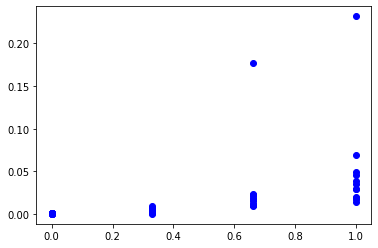

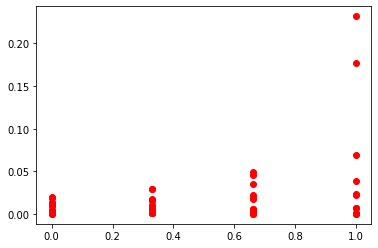

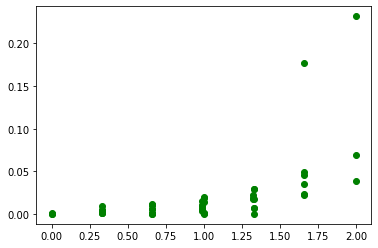

In [267]:
[plt.plot(modelData.iloc[0,i], max(modelData.iloc[3:33,i]), 'bo') for i in range(48)]
plt.figure()
[plt.plot(modelData.iloc[1,i], max(modelData.iloc[3:33,i]), 'ro') for i in range(48)]
plt.figure()
[plt.plot(modelData.iloc[0,i] + modelData.iloc[1,i], max(modelData.iloc[3:33,i]), 'go') for i in range(48)]

In [258]:
(max(modelData.iloc[3:33,2]))

0.0012292121618617828

In [259]:
nMales = 25
nFemales = 25
nAgents = nFemales + nMales
nPairs = min(nMales, nFemales)
ranks = range(nMales)
nDays = 100
rankFitnessCorrelation = 0.66
nGenerations = 1
model = evolvingModel()
profiler = cProfile.Profile()
profiler.enable()
#model.groups[0].runModel()
model.evolve()
profiler.disable()
stats = pstats.Stats(profiler).sort_stats('tottime')
stats.print_stats()


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


         164048 function calls (157658 primitive calls) in 0.668 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1000    0.152    0.000    0.152    0.000 <ipython-input-13-9e21b9846645>:40(setupCycleDay)
     1000    0.073    0.000    0.073    0.000 <ipython-input-13-9e21b9846645>:52(makeMatingPairs)
      532    0.030    0.000    0.127    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2275(cov)
     5965    0.030    0.000    0.030    0.000 {built-in method numpy.array}
 7072/688    0.025    0.000    0.216    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
     2050    0.024    0.000    0.025    0.000 {method 'randint' of 'numpy.random.mtrand.RandomState' objects}
     1030    0.017    0.000    0.023    0.000 {built-in method builtins.sorted}
       30    0.017    0.001    0.047    0.002 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/s

        1    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/pandas/core/dtypes/inference.py:360(is_sequence)
        1    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:1099(__len__)
        1    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/os.py:751(encode)
        7    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/threading.py:499(__init__)
       10    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(flip)
        3    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:153(__format__)
        3    0.000    0.000    0.005    0.002 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:296(fp_write)
        3    0.000    0.000    0.001    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3

## Everything below this point is for testing code

In [207]:
nDays = 60
nMales = 10
nFemales = 10
nAgents = nFemales + nMales
nPairs = min(nMales, nFemales)
ranks = range(nMales)
rankFitnessCorrelation = 1.0
cycleLength = 30
synchrony = 0.0
model = evolvingModel()

model.groups = [group(0)]

profiler = cProfile.Profile()
profiler.enable()

cycles = math.ceil(nDays / cycleLength)

IDs = [d for d in range(nFemales)] * nDays
cycleDays = [f.cycleDay-1
             for f
             in model.groups[0].females]

swellings = []
conceptionRisks = []

swellDictList = []

for i in range(nDays):
  swellings += [(f.swellingList  * nDays)[cycleDays[f.ID] + i] 
                for f 
                in model.groups[0].females]
  conceptionRisks += [(conceptionProbabilityList * nDays)[cycleDays[f.ID] + i]
                      for f
                      in model.groups[0].females]

fitnesses = model.groups[0].fitnessList


for day in range(nDays):
 swellDictList += [[[ID, swellings[day*nFemales + ID]
                     + model.groups[0].tieBreaker[day*nFemales + ID],conceptionRisks[day*nFemales + ID]]
                    for ID
                    in IDs[day*nFemales:day*nFemales+nFemales]]]


swellDictList = [sorted(swellDictList[i], key=lambda swelling: swelling[1])
                 for i
                 in range(nDays)]

swellDictList = [swellDictList[day][ID] + [ID] + [fitnesses[ID]] + [fitnesses[ID] * swellDictList[day][ID][2]]
                 for ID
                 in range(nFemales)
                 for day
                 in range(nDays)]

newSwellDictList = sorted(swellDictList, key=lambda swelling: swelling[0])

for lst in newSwellDictList:
    model.groups[0].females[lst[0]].reproductiveSuccess += lst[5]
    
profiler.disable()
stats = pstats.Stats(profiler).sort_stats('tottime')
stats.print_stats()

         1769 function calls in 0.050 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.026    0.026    0.026    0.026 <ipython-input-207-9058721d4904>:40(<listcomp>)
       60    0.008    0.000    0.008    0.000 <ipython-input-207-9058721d4904>:28(<listcomp>)
       60    0.007    0.000    0.007    0.000 <ipython-input-207-9058721d4904>:29(<listcomp>)
       60    0.002    0.000    0.002    0.000 <ipython-input-207-9058721d4904>:35(<listcomp>)
       14    0.002    0.000    0.002    0.000 {built-in method builtins.compile}
        1    0.001    0.001    0.001    0.001 <ipython-input-207-9058721d4904>:44(<module>)
       61    0.001    0.000    0.001    0.000 {built-in method builtins.sorted}
        1    0.001    0.001    0.016    0.016 <ipython-input-207-9058721d4904>:27(<module>)
       14    0.000    0.000    0.046    0.003 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/IPython/core/intera

In [206]:
newSwellDictList

[[0, 2.375946588243083e-13, 0, 0, 1.0, 0.0],
 [0, 1.4298990941111377e-12, 0, 0, 1.0, 0.0],
 [0, 5.7226828057453065e-12, 0, 1, 0.8888888888888888, 0.0],
 [0, 3.2571854648724327e-12, 0, 1, 0.8888888888888888, 0.0],
 [0, 5.030248194526099e-12, 0, 1, 0.8888888888888888, 0.0],
 [0, 2.3634193998023068e-12, 0, 1, 0.8888888888888888, 0.0],
 [0, 3.443951753116616e-12, 0, 2, 0.7777777777777778, 0.0],
 [0, 3.825825199580528e-12, 0, 2, 0.7777777777777778, 0.0],
 [0, 5.947000411462108e-12, 0, 2, 0.7777777777777778, 0.0],
 [0, 5.423573578834359e-12, 0, 2, 0.7777777777777778, 0.0],
 [0, 4.780975957410109e-12, 0, 2, 0.7777777777777778, 0.0],
 [0, 8.980646947588438e-12, 0, 2, 0.7777777777777778, 0.0],
 [0, 3.023103561828597e-12, 0, 2, 0.7777777777777778, 0.0],
 [0, 4.37622640858981e-12, 0, 2, 0.7777777777777778, 0.0],
 [0, 6.5589882764948764e-12, 0, 3, 0.6666666666666666, 0.0],
 [0, 5.16044168996973e-12, 0.05784435, 3, 0.6666666666666666, 0.0385629],
 [0, 7.473951939206705e-12, 0, 3, 0.6666666666666666

In [208]:
model = evolvingModel()

profiler = cProfile.Profile()
profiler.enable()

model.groups[0].runModel()

profiler.disable()
stats = pstats.Stats(profiler).sort_stats('tottime')
stats.print_stats()

         828 function calls in 0.006 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       60    0.003    0.000    0.003    0.000 <ipython-input-13-9e21b9846645>:40(setupCycleDay)
       60    0.002    0.000    0.002    0.000 <ipython-input-13-9e21b9846645>:52(makeMatingPairs)
       60    0.000    0.000    0.001    0.000 {built-in method builtins.sorted}
        1    0.000    0.000    0.006    0.006 <ipython-input-13-9e21b9846645>:25(runModel)
      600    0.000    0.000    0.000    0.000 <ipython-input-13-9e21b9846645>:49(sortSwelling)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        2    0.000    0.000    0.006    0.003 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3288(run_code)
        1    0.000    0.000    0.006    0.006 <ipython-input-208-8bf1dcaafa3a>:6(<module>)
        2    0.000    0.000    0.000    0.000 /Users/kevinros